# FURB - Processamento de Imagens (trabalho final)

> Identificação de alterações no solo

## Obtenção do Dataset

**Resgate de imagens do Google Earth Engine para dataset**\
As imagens foram obtidas através da API Google Earth Engine. Para obtenção, foi-se criado um script que resgata todas as imagens em dataset (definido pelo usuário e disponível no GEE) disponíveis, em todas as datas possíveis. As imagens resgatadas são salvas no Google Drive da conta autenticada que está executando, e posteriormente baixadas em máquina local para uso.

**Exemplo de output**:
    
    - BLU_2018-03-16.tif
    - BLU_2018-04-20.tif 

As datas presentes no nome de cada imagem foram resgatadas dos metadados da imagem em questão e por fim populadas em seu nome.

Obtivemos um retorno de 96 imagens utilizáveis para o estudo (excluindo imagens repetidas e imagens corrompidas). Todas as imagens são retornadas em formato GeoTIFF.

Dataset pode ser resgatado no link abaixo:
> [Link Dataset](https://drive.google.com/drive/folders/1WH33bZc7Rqw2LAgmJke73zgTIzAHUQ6C?usp=sharing)

As imagens foram obtidas através do dataset da missão 'Copernicus Sentinel-2'
> Possui imagens datadas entre 2016 a 2025

**Bandas resgatadas**
Informações resgatadas do próprio site do Google Earth Engine: [link](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED)
| Band | Scale Factor | Spatial Resolution | Central Wavelengths (S2A / S2B) | Description |
| ---- | ------------ | ------------------ | ------------------------------- | ----------- |
| B1   | 0.0001       | 60 m               | 443.9 nm / 442.3 nm             | Aerosols    |
| B2   | 0.0001       | 10 m               | 496.6 nm / 492.1 nm             | Blue        |
| B3   | 0.0001       | 10 m               | 560 nm / 559 nm                 | Green       |
| B4   | 0.0001       | 10 m               | 664.5 nm / 665 nm               | Red         |
| B5   | 0.0001       | 20 m               | 703.9 nm / 703.8 nm             | Red Edge 1  |
| B6   | 0.0001       | 20 m               | 740.2 nm / 739.1 nm             | Red Edge 2  |
| B7   | 0.0001       | 20 m               | 782.5 nm / 779.7 nm             | Red Edge 3  |
| B8   | 0.0001       | 10 m               | 835.1 nm / 833 nm               | NIR         |
| B8A  | 0.0001       | 20 m               | 864.8 nm / 864 nm               | Red Edge 4  |
| B9   | 0.0001       | 60 m               | 945 nm / 943.2 nm               | Water vapor |
| B10  | 0.0001       | 60 m               | 1373.5 nm / 1376.9 nm           | Cirrus      |
| B11  | 0.0001       | 20 m               | 1613.7 nm / 1610.4 nm           | SWIR 1      |
| B12  | 0.0001       | 20 m               | 2202.4 nm / 2185.7 nm           | SWIR 2      |




#### Bibliotecas necessárias para rodar as células de código

In [ ]:
%pip install ee rasterio numpy matplotlib tqdm

```python
import ee
import time

# Autenticação e inicialização
try:
    ee.Initialize(project='furb-pci-trabalho-final')
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# BLUMENAU INTEIRA
blumenau = ee.Geometry.Polygon([
    [-49.160627052203616,-26.965172045958347]
,[-48.98553244771143,-26.965172045958347]
,[-48.98553244771143,-26.815746390533665]
,[-49.160627052203616,-26.815746390533665]
,[-49.160627052203616,-26.965172045958347]
])

# Parâmetros do dataset
cloud_cover = 10  # Percentual máximo de cobertura de nuvens
output_folder = 'blumenau_imagens_ALLBANDS'
#output_folder = 'blumenau_imagens_RGB'
scale = 10  # Resolução em metros
prefix = 'BLU'

# Função para filtrar imagens
def get_processed_images(geometry, cloud_cover):
    collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')              
                 .filterBounds(geometry)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_cover))
                 .sort('system:time_start'))
    return collection

# Função para exportar imagem completa
def export_image(image, description, folder, geometry, scale):
    try:
        task = ee.batch.Export.image.toDrive(
            image=image,
            description=description[:100],
            folder=folder,
            region=geometry.getInfo()['coordinates'],
            scale=scale,
            maxPixels=1e13,
            fileFormat='GeoTIFF',
            formatOptions={'cloudOptimized': True}
        )
        task.start()
        return task.id
    except Exception as e:
        print(f"Erro ao exportar {description}: {str(e)}")
        return None

# Função para obter informações das imagens
def get_image_info(collection):
    image_list = collection.toList(collection.size())
    info_list = []
    
    for i in range(collection.size().getInfo()):
        img = ee.Image(image_list.get(i))
        date = img.date().format('YYYY-MM-dd').getInfo()
        info_list.append({
            'date': date,
            'image': img,
            'id': i
        })
    return info_list

# Execução principal
if __name__ == "__main__":
    print("Iniciando processamento...")
    
    collection = get_processed_images(blumenau, cloud_cover)
    image_count = collection.size().getInfo()
    image_info = get_image_info(collection)
    
    print(f"\nEncontradas {image_count} imagens que atendem aos critérios:")
    for img in image_info:
        print(f"- {img['date']}")
        
    print("Prosseguindo.")
    
    task_ids = []
    
    print("\nIniciando exportação de imagens...")
    for img in image_info:
        date_str = img['date']
        image_id = img['id']
        
        print(f"\nExportando imagem completa de {date_str} (ID: {image_id})")
        
        # Selecionar apenas as bandas relevantes
        useful_bands = [ 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', ]
        task_id = export_image(img['image'].select(useful_bands), f"{prefix}_{date_str}_FULL", output_folder, blumenau, scale)
        

        if task_id:
            task_ids.append(task_id)
            print(f"Exportando imagem: Tarefa {task_id}")
        
        time.sleep(1)

    
    print("\nResumo das tarefas de exportação:")
    for task_id in task_ids:
        print(f"- Tarefa ID: {task_id}")
    
    print(f"""
    Todas as tarefas foram enviadas para o Google Earth Engine.
    Total de tarefas: {len(task_ids)}
    
    Você pode monitorar o progresso em: https://code.earthengine.google.com/tasks
    
    Os arquivos exportados conterão todas as bandas originais da imagem Sentinel-2.
    """)
```

### Exemplo de imagem presente no dataset

OBS: todas as imagens do dataset são localizadas na mesma área da imagem abaixo. Para replicar a obtenção das imagens na mesma área do que a obtida por nós, segue o polígono selecionado na GEE abaixo:

```python
blumenau = ee.Geometry.Polygon([
    [-49.160627052203616,-26.965172045958347]
,[-48.98553244771143,-26.965172045958347]
,[-48.98553244771143,-26.815746390533665]
,[-49.160627052203616,-26.815746390533665]
,[-49.160627052203616,-26.965172045958347]
])
```

=== INFORMAÇÕES DO ARQUIVO ===
Número de bandas: 13
Coordinate Reference System (CRS): EPSG:32722
Dimensões da imagem: 1766 x 1683 pixels
Transform: | 10.00, 0.00, 682560.00|
| 0.00,-10.00, 7032650.00|
| 0.00, 0.00, 1.00|


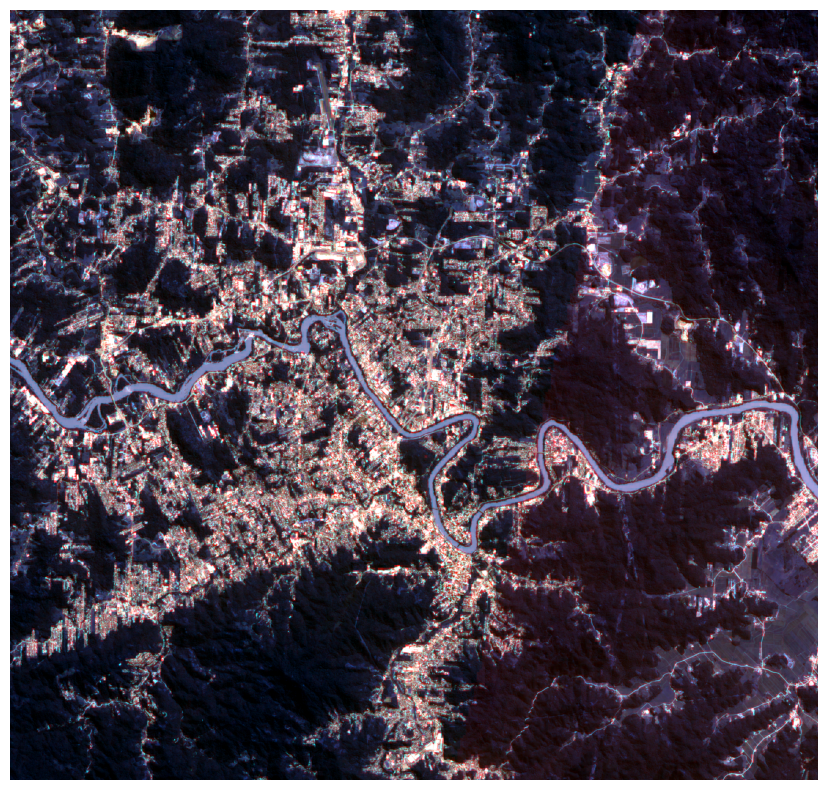

In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_only(file_path):
    try:
        # Abrir o arquivo
        with rasterio.open(file_path) as src:
            # Print de informações básicas sobre a imagem
            print("=== INFORMAÇÕES DO ARQUIVO ===")
            print(f"Número de bandas: {src.count}")
            print(f"Coordinate Reference System (CRS): {src.crs}")
            print(f"Dimensões da imagem: {src.width} x {src.height} pixels")
            print(f"Transform: {src.transform}")
            
            # Ler em RGB ou banda única
            if src.count >= 3:
                bands = [1, 2, 3]
            else:
                bands = [1]
            img = src.read(bands)
            
            # Normalização das bandas
            def normalize(band):
                lo, hi = np.nanpercentile(band, [2, 98])
                return np.clip((band - lo) / (hi - lo), 0, 1)
            
            img_norm = np.stack([normalize(b) for b in img], axis=0)
            
            # Prepare for plotting: (H, W, C) for multi-band, or (H, W) for single
            if img_norm.shape[0] == 3:
                plot_img = np.transpose(img_norm, (1, 2, 0))
            else:
                plot_img = img_norm[0]
            
            plt.figure(figsize=(10, 8))
            plt.imshow(plot_img)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error: {e}")


# Execução
if __name__ == "__main__":
    file_path = "BLU_2016-04-20_FULL.tif"
    visualize_image_only(file_path)

## Separação das imagens do dataset em quadrantes

Optamos por separar as imagens do dataset em quadrantes de tamanhos iguais (224x224 pixels) para aplicação das análises que serão realizadas posteriormente.

**OBS**: as partes que não estão divididas em quadrantes não havia possibilidade de construir um quadrante 224x224, por isso foram ignorados na criação dos quadrantes para este estudo.

![Imagem aérea de Blumenau separada por quadrantes](blumenau_quadrantes.png)

### Script para separação em quadrantes

As imagens são separadas em quadrantes de tamanho 224x224 pixels (conforme imagem acima).

Exemplo de saída:

    - quadrante1/BLU_2018-03-16_quadrante1.tif
    - quadrante1/BLU_2018-04-20_quadrante1.tif
    - quadrante1/BLU_2018-05-20_quadrante1.tif
    - quadrante1/BLU_2018-11-16_quadrante1.tif

    - quadrante2/BLU_2018-03-16_quadrante2.tif
    - quadrante2/BLU_2018-04-20_quadrante2.tif
    - quadrante2/BLU_2018-05-20_quadrante2.tif
    - quadrante2/BLU_2018-11-16_quadrante2.tif

    - quadrante3/BLU_2018-03-16_quadrante3.tif
    - quadrante3/BLU_2018-04-20_quadrante3.tif
    - quadrante3/BLU_2018-05-20_quadrante3.tif
    - quadrante3/BLU_2018-11-16_quadrante3.tif

    ....

O dataset, após separação em quadrantes, possui em torno de 4700 imagens (96 imagens x 49 quadrantes).

In [4]:
import os
import rasterio
from rasterio.windows import Window
from tqdm import tqdm

def separar_blumenau_quadrantes(input_path, output_dir):
    """Separação das imagens Sentinel-2 GeoTIFF em quadrantes 224x224 preservando os metadados."""
    os.makedirs(output_dir, exist_ok=True)
    
    with rasterio.open(input_path) as src:
        width, height = src.width, src.height
        transform = src.transform
        crs = src.crs
        profile = src.profile
        band_descriptions = src.descriptions
        tags = src.tags()
        band_tags = [src.tags(i+1) for i in range(src.count)]
        
        base_name = os.path.splitext(os.path.basename(input_path))[0]
        
        quadrant_num = 1
        for y in range(0, height, 224):
            for x in range(0, width, 224):
                window = Window(x, y, min(224, width - x), min(224, height - y))
                
                if window.width < 224 or window.height < 224:
                    continue
                
                # Ler todas as bandas
                data = src.read(window=window)
                
                new_transform = rasterio.windows.transform(window, transform)
                
                quadrant_dir = os.path.join(output_dir, f"quadrante{quadrant_num}")
                os.makedirs(quadrant_dir, exist_ok=True)
                
                # Atualizar perfil para output
                quadrant_profile = profile.copy()
                quadrant_profile.update({
                    'height': window.height,
                    'width': window.width,
                    'transform': new_transform,
                    'count': src.count  # Garantir que todas as bandas estejam inclusas
                })
                
                output_path = os.path.join(quadrant_dir, f"{base_name}_quadrante{quadrant_num}.tif")
                
                with rasterio.open(output_path, 'w', **quadrant_profile) as dst:
                    dst.write(data)

                    # Copiar descrições de banda
                    for i, desc in enumerate(band_descriptions, 1):
                        dst.set_band_description(i, desc)
                    
                    # Copiar tags globais
                    dst.update_tags(**tags)

                    # Copiar tags específicas de banda
                    for i, tags in enumerate(band_tags, 1):
                        dst.update_tags(i, **tags)
                
                quadrant_num += 1

import os
from tqdm import tqdm

if __name__ == "__main__":
    # Diretório contendo as imagens do dataset
    image_dir = "input/blumenau_imagens_ALLBANDS"

    # Resgatar todos os arquivos do diretório e filtrar por imagem .tif/.tiff
    input_images = [
        os.path.join(image_dir, f) 
        for f in os.listdir(image_dir) 
        if f.lower().endswith(('.tif', '.tiff'))
    ]
    
    output_directory = "output/quadrantes"
    
    print(f"Quantidade de imagens de entrada: {len(input_images)}")

    # Processamento de imagens (tqdm utilizada para mostrar barra de progresso)
    for image_path in tqdm(input_images, desc="Processando imagens", unit="image"):
        if os.path.exists(image_path):
            tqdm.write(f"\nProcessando {os.path.basename(image_path)}...")
            try:
                separar_blumenau_quadrantes(image_path, output_directory)
                tqdm.write(f"Processado com sucesso: {os.path.basename(image_path)}")
                tqdm.write(f"Criado {len(os.listdir(output_directory))} pastas de quadrantes")
            except Exception as e:
                tqdm.write(f"\nErro ao processar: {image_path}: {str(e)}")
        else:
            tqdm.write(f"\nErro: Arquivo não encontrado - {image_path}")

    print("\nTodas as imagens foram processadas!")

Quantidade de imagens de entrada: 94


Processando imagens:   0%|                                                                                                                                        | 0/94 [00:00<?, ?image/s]


Processando BLU_2025-05-05.tif...


Processando imagens:   1%|█▎                                                                                                                              | 1/94 [00:03<04:59,  3.22s/image]

Processado com sucesso: BLU_2025-05-05.tif
Criado 49 pastas de quadrantes

Processando BLU_2022-06-13.tif...


Processando imagens:   2%|██▋                                                                                                                             | 2/94 [00:06<04:57,  3.23s/image]

Processado com sucesso: BLU_2022-06-13.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-07-04.tif...


Processando imagens:   3%|████                                                                                                                            | 3/94 [00:09<05:00,  3.30s/image]

Processado com sucesso: BLU_2019-07-04.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-09-26.tif...


Processando imagens:   4%|█████▍                                                                                                                          | 4/94 [00:13<04:54,  3.28s/image]

Processado com sucesso: BLU_2020-09-26.tif
Criado 49 pastas de quadrantes

Processando BLU_2021-02-18.tif...


Processando imagens:   5%|██████▊                                                                                                                         | 5/94 [00:16<04:53,  3.29s/image]

Processado com sucesso: BLU_2021-02-18.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-11-16.tif...


Processando imagens:   6%|████████▏                                                                                                                       | 6/94 [00:19<04:50,  3.30s/image]

Processado com sucesso: BLU_2018-11-16.tif
Criado 49 pastas de quadrantes

Processando BLU_2024-08-26.tif...


Processando imagens:   7%|█████████▌                                                                                                                      | 7/94 [00:23<04:47,  3.30s/image]

Processado com sucesso: BLU_2024-08-26.tif
Criado 49 pastas de quadrantes

Processando BLU_2022-05-19.tif...


Processando imagens:   9%|██████████▉                                                                                                                     | 8/94 [00:26<04:46,  3.33s/image]

Processado com sucesso: BLU_2022-05-19.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-04-15.tif...


Processando imagens:  10%|████████████▎                                                                                                                   | 9/94 [00:29<04:46,  3.37s/image]

Processado com sucesso: BLU_2019-04-15.tif
Criado 49 pastas de quadrantes

Processando BLU_2025-03-09.tif...


Processando imagens:  11%|█████████████▌                                                                                                                 | 10/94 [00:33<04:45,  3.40s/image]

Processado com sucesso: BLU_2025-03-09.tif
Criado 49 pastas de quadrantes

Processando BLU_2024-07-22.tif...


Processando imagens:  12%|██████████████▊                                                                                                                | 11/94 [00:36<04:46,  3.45s/image]

Processado com sucesso: BLU_2024-07-22.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-01-30.tif...


Processando imagens:  13%|████████████████▏                                                                                                              | 12/94 [00:40<04:45,  3.49s/image]

Processado com sucesso: BLU_2018-01-30.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-05-24.tif...


Processando imagens:  14%|█████████████████▌                                                                                                             | 13/94 [00:44<04:47,  3.55s/image]

Processado com sucesso: BLU_2020-05-24.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-03-16.tif...


Processando imagens:  15%|██████████████████▉                                                                                                            | 14/94 [00:47<04:41,  3.52s/image]

Processado com sucesso: BLU_2018-03-16.tif
Criado 49 pastas de quadrantes

Processando BLU_2023-09-16.tif...


Processando imagens:  16%|████████████████████▎                                                                                                          | 15/94 [00:50<04:34,  3.47s/image]

Processado com sucesso: BLU_2023-09-16.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-05-20.tif...


Processando imagens:  17%|█████████████████████▌                                                                                                         | 16/94 [00:54<04:31,  3.47s/image]

Processado com sucesso: BLU_2018-05-20.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-04-04.tif...


Processando imagens:  18%|██████████████████████▉                                                                                                        | 17/94 [00:57<04:27,  3.47s/image]

Processado com sucesso: BLU_2020-04-04.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-03-10.tif...


Processando imagens:  19%|████████████████████████▎                                                                                                      | 18/94 [01:01<04:19,  3.41s/image]

Processado com sucesso: BLU_2020-03-10.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-05-29.tif...


Processando imagens:  20%|█████████████████████████▋                                                                                                     | 19/94 [01:04<04:12,  3.37s/image]

Processado com sucesso: BLU_2020-05-29.tif
Criado 49 pastas de quadrantes

Processando BLU_2024-07-02.tif...


Processando imagens:  21%|███████████████████████████                                                                                                    | 20/94 [01:07<04:07,  3.35s/image]

Processado com sucesso: BLU_2024-07-02.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-04-24.tif...


Processando imagens:  22%|████████████████████████████▎                                                                                                  | 21/94 [01:11<04:07,  3.40s/image]

Processado com sucesso: BLU_2020-04-24.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-07-23.tif...


Processando imagens:  23%|█████████████████████████████▋                                                                                                 | 22/94 [01:14<04:04,  3.39s/image]

Processado com sucesso: BLU_2020-07-23.tif
Criado 49 pastas de quadrantes

Processando BLU_2022-02-13.tif...


Processando imagens:  24%|███████████████████████████████                                                                                                | 23/94 [01:17<03:58,  3.37s/image]

Processado com sucesso: BLU_2022-02-13.tif
Criado 49 pastas de quadrantes

Processando BLU_2021-11-30.tif...


Processando imagens:  26%|████████████████████████████████▍                                                                                              | 24/94 [01:21<03:52,  3.32s/image]

Processado com sucesso: BLU_2021-11-30.tif
Criado 49 pastas de quadrantes

Processando BLU_2021-02-23.tif...


Processando imagens:  27%|█████████████████████████████████▊                                                                                             | 25/94 [01:24<03:46,  3.28s/image]

Processado com sucesso: BLU_2021-02-23.tif
Criado 49 pastas de quadrantes

Processando BLU_2021-07-18.tif...


Processando imagens:  28%|███████████████████████████████████▏                                                                                           | 26/94 [01:27<03:47,  3.34s/image]

Processado com sucesso: BLU_2021-07-18.tif
Criado 49 pastas de quadrantes

Processando BLU_2025-02-12.tif...


Processando imagens:  29%|████████████████████████████████████▍                                                                                          | 27/94 [01:31<03:42,  3.32s/image]

Processado com sucesso: BLU_2025-02-12.tif
Criado 49 pastas de quadrantes

Processando BLU_2025-05-18.tif...


Processando imagens:  30%|█████████████████████████████████████▊                                                                                         | 28/94 [01:34<03:38,  3.31s/image]

Processado com sucesso: BLU_2025-05-18.tif
Criado 49 pastas de quadrantes

Processando BLU_2021-03-10.tif...


Processando imagens:  31%|███████████████████████████████████████▏                                                                                       | 29/94 [01:37<03:34,  3.30s/image]

Processado com sucesso: BLU_2021-03-10.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-02-14.tif...


Processando imagens:  32%|████████████████████████████████████████▌                                                                                      | 30/94 [01:41<03:32,  3.31s/image]

Processado com sucesso: BLU_2020-02-14.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-12-11.tif...


Processando imagens:  33%|█████████████████████████████████████████▉                                                                                     | 31/94 [01:44<03:25,  3.26s/image]

Processado com sucesso: BLU_2018-12-11.tif
Criado 49 pastas de quadrantes

Processando BLU_2025-01-23.tif...


Processando imagens:  34%|███████████████████████████████████████████▏                                                                                   | 32/94 [01:47<03:21,  3.25s/image]

Processado com sucesso: BLU_2025-01-23.tif
Criado 49 pastas de quadrantes

Processando BLU_2022-06-18.tif...


Processando imagens:  35%|████████████████████████████████████████████▌                                                                                  | 33/94 [01:50<03:20,  3.29s/image]

Processado com sucesso: BLU_2022-06-18.tif
Criado 49 pastas de quadrantes

Processando BLU_2023-02-08.tif...


Processando imagens:  36%|█████████████████████████████████████████████▉                                                                                 | 34/94 [01:54<03:16,  3.27s/image]

Processado com sucesso: BLU_2023-02-08.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-11-05.tif...


Processando imagens:  37%|███████████████████████████████████████████████▎                                                                               | 35/94 [01:57<03:16,  3.33s/image]

Processado com sucesso: BLU_2020-11-05.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-04-20.tif...


Processando imagens:  38%|████████████████████████████████████████████████▋                                                                              | 36/94 [02:00<03:12,  3.32s/image]

Processado com sucesso: BLU_2018-04-20.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-05-09.tif...


Processando imagens:  39%|█████████████████████████████████████████████████▉                                                                             | 37/94 [02:04<03:09,  3.32s/image]

Processado com sucesso: BLU_2020-05-09.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-01-25.tif...


Processando imagens:  40%|███████████████████████████████████████████████████▎                                                                           | 38/94 [02:07<03:06,  3.33s/image]

Processado com sucesso: BLU_2020-01-25.tif
Criado 49 pastas de quadrantes

Processando BLU_2022-07-03.tif...


Processando imagens:  41%|████████████████████████████████████████████████████▋                                                                          | 39/94 [02:11<03:09,  3.44s/image]

Processado com sucesso: BLU_2022-07-03.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-03-11.tif...


Processando imagens:  43%|██████████████████████████████████████████████████████                                                                         | 40/94 [02:14<03:03,  3.40s/image]

Processado com sucesso: BLU_2018-03-11.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-03-15.tif...


Processando imagens:  44%|███████████████████████████████████████████████████████▍                                                                       | 41/94 [02:18<03:03,  3.45s/image]

Processado com sucesso: BLU_2020-03-15.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-01-30.tif...


Processando imagens:  45%|████████████████████████████████████████████████████████▋                                                                      | 42/94 [02:21<02:58,  3.44s/image]

Processado com sucesso: BLU_2019-01-30.tif
Criado 49 pastas de quadrantes

Processando BLU_2024-04-18.tif...


Processando imagens:  46%|██████████████████████████████████████████████████████████                                                                     | 43/94 [02:24<02:55,  3.44s/image]

Processado com sucesso: BLU_2024-04-18.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-02-09.tif...


Processando imagens:  47%|███████████████████████████████████████████████████████████▍                                                                   | 44/94 [02:28<02:51,  3.43s/image]

Processado com sucesso: BLU_2019-02-09.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-12-26.tif...


Processando imagens:  48%|████████████████████████████████████████████████████████████▊                                                                  | 45/94 [02:31<02:47,  3.42s/image]

Processado com sucesso: BLU_2019-12-26.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-05-19.tif...


Processando imagens:  49%|██████████████████████████████████████████████████████████████▏                                                                | 46/94 [02:35<02:45,  3.45s/image]

Processado com sucesso: BLU_2020-05-19.tif
Criado 49 pastas de quadrantes

Processando BLU_2023-08-07.tif...


Processando imagens:  50%|███████████████████████████████████████████████████████████████▌                                                               | 47/94 [02:38<02:42,  3.46s/image]

Processado com sucesso: BLU_2023-08-07.tif
Criado 49 pastas de quadrantes

Processando BLU_2016-08-28.tif...


Processando imagens:  51%|████████████████████████████████████████████████████████████████▊                                                              | 48/94 [02:42<02:41,  3.50s/image]

Processado com sucesso: BLU_2016-08-28.tif
Criado 49 pastas de quadrantes

Processando BLU_2017-05-15.tif...


Processando imagens:  52%|██████████████████████████████████████████████████████████████████▏                                                            | 49/94 [02:45<02:37,  3.50s/image]

Processado com sucesso: BLU_2017-05-15.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-05-25.tif...


Processando imagens:  53%|███████████████████████████████████████████████████████████████████▌                                                           | 50/94 [02:49<02:34,  3.50s/image]

Processado com sucesso: BLU_2019-05-25.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-06-04.tif...


Processando imagens:  54%|████████████████████████████████████████████████████████████████████▉                                                          | 51/94 [02:52<02:31,  3.53s/image]

Processado com sucesso: BLU_2019-06-04.tif
Criado 49 pastas de quadrantes

Processando BLU_2024-01-09.tif...


Processando imagens:  55%|██████████████████████████████████████████████████████████████████████▎                                                        | 52/94 [02:56<02:26,  3.49s/image]

Processado com sucesso: BLU_2024-01-09.tif
Criado 49 pastas de quadrantes

Processando BLU_2024-06-07.tif...


Processando imagens:  56%|███████████████████████████████████████████████████████████████████████▌                                                       | 53/94 [02:59<02:22,  3.48s/image]

Processado com sucesso: BLU_2024-06-07.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-07-19.tif...


Processando imagens:  57%|████████████████████████████████████████████████████████████████████████▉                                                      | 54/94 [03:03<02:17,  3.43s/image]

Processado com sucesso: BLU_2018-07-19.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-06-14.tif...


Processando imagens:  59%|██████████████████████████████████████████████████████████████████████████▎                                                    | 55/94 [03:06<02:12,  3.39s/image]

Processado com sucesso: BLU_2018-06-14.tif
Criado 49 pastas de quadrantes

Processando BLU_2017-07-29.tif...


Processando imagens:  60%|███████████████████████████████████████████████████████████████████████████▋                                                   | 56/94 [03:09<02:08,  3.39s/image]

Processado com sucesso: BLU_2017-07-29.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-07-14.tif...


Processando imagens:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 57/94 [03:14<02:20,  3.81s/image]

Processado com sucesso: BLU_2018-07-14.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-12-30.tif...


Processando imagens:  62%|██████████████████████████████████████████████████████████████████████████████▎                                                | 58/94 [03:17<02:12,  3.67s/image]

Processado com sucesso: BLU_2020-12-30.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-01-05.tif...


Processando imagens:  63%|███████████████████████████████████████████████████████████████████████████████▋                                               | 59/94 [03:21<02:04,  3.55s/image]

Processado com sucesso: BLU_2018-01-05.tif
Criado 49 pastas de quadrantes

Processando BLU_2025-01-03.tif...


Processando imagens:  64%|█████████████████████████████████████████████████████████████████████████████████                                              | 60/94 [03:24<01:58,  3.49s/image]

Processado com sucesso: BLU_2025-01-03.tif
Criado 49 pastas de quadrantes

Processando BLU_2023-01-24.tif...


Processando imagens:  65%|██████████████████████████████████████████████████████████████████████████████████▍                                            | 61/94 [03:29<02:09,  3.93s/image]

Processado com sucesso: BLU_2023-01-24.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-07-29.tif...


Processando imagens:  66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 62/94 [03:32<02:00,  3.76s/image]

Processado com sucesso: BLU_2018-07-29.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-10-01.tif...


Processando imagens:  67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 63/94 [03:36<01:53,  3.67s/image]

Processado com sucesso: BLU_2020-10-01.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-04-09.tif...


Processando imagens:  68%|██████████████████████████████████████████████████████████████████████████████████████▍                                        | 64/94 [03:39<01:47,  3.58s/image]

Processado com sucesso: BLU_2020-04-09.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-09-27.tif...


Processando imagens:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 65/94 [03:43<01:43,  3.58s/image]

Processado com sucesso: BLU_2019-09-27.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-03-20.tif...


Processando imagens:  70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 66/94 [03:46<01:39,  3.54s/image]

Processado com sucesso: BLU_2020-03-20.tif
Criado 49 pastas de quadrantes

Processando BLU_2024-08-16.tif...


Processando imagens:  71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 67/94 [03:50<01:35,  3.54s/image]

Processado com sucesso: BLU_2024-08-16.tif
Criado 49 pastas de quadrantes

Processando BLU_2023-05-14.tif...


Processando imagens:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 68/94 [03:53<01:31,  3.53s/image]

Processado com sucesso: BLU_2023-05-14.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-02-24.tif...


Processando imagens:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 69/94 [03:57<01:29,  3.58s/image]

Processado com sucesso: BLU_2019-02-24.tif
Criado 49 pastas de quadrantes

Processando BLU_2023-03-20.tif...


Processando imagens:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 70/94 [04:00<01:25,  3.54s/image]

Processado com sucesso: BLU_2023-03-20.tif
Criado 49 pastas de quadrantes

Processando BLU_2021-07-28.tif...


Processando imagens:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 71/94 [04:04<01:20,  3.48s/image]

Processado com sucesso: BLU_2021-07-28.tif
Criado 49 pastas de quadrantes

Processando BLU_2023-11-05.tif...


Processando imagens:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 72/94 [04:07<01:15,  3.41s/image]

Processado com sucesso: BLU_2023-11-05.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-06-29.tif...


Processando imagens:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 73/94 [04:10<01:11,  3.40s/image]

Processado com sucesso: BLU_2019-06-29.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-07-03.tif...


Processando imagens:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 74/94 [04:14<01:09,  3.49s/image]

Processado com sucesso: BLU_2020-07-03.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-04-29.tif...


Processando imagens:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 75/94 [04:18<01:06,  3.50s/image]

Processado com sucesso: BLU_2020-04-29.tif
Criado 49 pastas de quadrantes

Processando BLU_2016-12-06.tif...


Processando imagens:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 76/94 [04:21<01:02,  3.46s/image]

Processado com sucesso: BLU_2016-12-06.tif
Criado 49 pastas de quadrantes

Processando BLU_2016-04-20.tif...


Processando imagens:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 77/94 [04:24<00:58,  3.45s/image]

Processado com sucesso: BLU_2016-04-20.tif
Criado 49 pastas de quadrantes

Processando BLU_2024-08-11.tif...


Processando imagens:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 78/94 [04:28<00:54,  3.42s/image]

Processado com sucesso: BLU_2024-08-11.tif
Criado 49 pastas de quadrantes

Processando BLU_2021-06-13.tif...


Processando imagens:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 79/94 [04:31<00:51,  3.44s/image]

Processado com sucesso: BLU_2021-06-13.tif
Criado 49 pastas de quadrantes

Processando BLU_2017-11-16.tif...


Processando imagens:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 80/94 [04:34<00:47,  3.41s/image]

Processado com sucesso: BLU_2017-11-16.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-08-03.tif...


Processando imagens:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 81/94 [04:38<00:45,  3.50s/image]

Processado com sucesso: BLU_2019-08-03.tif
Criado 49 pastas de quadrantes

Processando BLU_2024-03-14.tif...


Processando imagens:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 82/94 [04:42<00:42,  3.55s/image]

Processado com sucesso: BLU_2024-03-14.tif
Criado 49 pastas de quadrantes

Processando BLU_2023-06-18.tif...


Processando imagens:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 83/94 [04:46<00:40,  3.69s/image]

Processado com sucesso: BLU_2023-06-18.tif
Criado 49 pastas de quadrantes

Processando BLU_2023-06-28.tif...


Processando imagens:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 84/94 [04:49<00:36,  3.60s/image]

Processado com sucesso: BLU_2023-06-28.tif
Criado 49 pastas de quadrantes

Processando BLU_2019-10-12.tif...


Processando imagens:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 85/94 [04:53<00:31,  3.49s/image]

Processado com sucesso: BLU_2019-10-12.tif
Criado 49 pastas de quadrantes

Processando BLU_2021-12-25.tif...


Processando imagens:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 86/94 [04:56<00:27,  3.41s/image]

Processado com sucesso: BLU_2021-12-25.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-06-08.tif...


Processando imagens:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 87/94 [04:59<00:23,  3.42s/image]

Processado com sucesso: BLU_2020-06-08.tif
Criado 49 pastas de quadrantes

Processando BLU_2024-06-27.tif...


Processando imagens:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 88/94 [05:03<00:20,  3.43s/image]

Processado com sucesso: BLU_2024-06-27.tif
Criado 49 pastas de quadrantes

Processando BLU_2022-09-01.tif...


Processando imagens:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 89/94 [05:06<00:17,  3.43s/image]

Processado com sucesso: BLU_2022-09-01.tif
Criado 49 pastas de quadrantes

Processando BLU_2022-11-15.tif...


Processando imagens:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 90/94 [05:09<00:13,  3.40s/image]

Processado com sucesso: BLU_2022-11-15.tif
Criado 49 pastas de quadrantes

Processando BLU_2017-09-07.tif...


Processando imagens:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 91/94 [05:13<00:10,  3.45s/image]

Processado com sucesso: BLU_2017-09-07.tif
Criado 49 pastas de quadrantes

Processando BLU_2017-11-11.tif...


Processando imagens:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 92/94 [05:16<00:06,  3.48s/image]

Processado com sucesso: BLU_2017-11-11.tif
Criado 49 pastas de quadrantes

Processando BLU_2020-08-22.tif...


Processando imagens:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 93/94 [05:20<00:03,  3.43s/image]

Processado com sucesso: BLU_2020-08-22.tif
Criado 49 pastas de quadrantes

Processando BLU_2018-04-25.tif...


Processando imagens: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [05:23<00:00,  3.44s/image]

Processado com sucesso: BLU_2018-04-25.tif
Criado 49 pastas de quadrantes

Todas as imagens foram processadas!


## Métodos para detecção de mudanças

Para realizarmos as detecções de mudanças nos quadrantes de Blumenau, utilizamos algumas abordagens:

### 1) Método por Subtração de Bandas/Índices

Para a aplicação deste método de detecção de mudanças, nós resgatamos as informações relacionadas as bandas de cada imagem, e construímos os índices espectrais relacionados a este tipo de alteração que buscamos detectar.

#### Cálculo de Índices Espectrais

O script abaixo percorre todas as imagens presentes em todos os quadrantes, e cria um arquivo .csv para cada quadrante, contendo os cálculos de índices de todas as imagens presentes por quadrante.

Exemplo de saída:

    - indices_quadrante1.csv
    - indices_quadrante2.csv
    - ...

Exemplo de conteúdo do .csv:

```csv
image,NDVI_mean,NDBI_mean,NDWI_mean
BLU_2016-04-20_quadrante1.tif,0.61207,-0.24758475,-0.28689378
BLU_2016-08-28_quadrante1.tif,0.5470865,-0.18164395,-0.2931683
BLU_2016-12-06_quadrante1.tif,0.6186532,-0.21854451,-0.3365644
...
```

Índices calculados e a função de cada um deles:
| Índice                                                   | Explicação resumida da função                                                                                               |
| -------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| **NDVI**<br>(Normalized Difference Vegetation Index)     | Realça vegetação viva e saudável, comparando bandas NIR (B8) e vermelho (B4) para indicar vigor vegetal.                    |
| **NDBI**<br>(Normalized Difference Built-up Index)       | Realça áreas construídas (concreto, asfalto), comparando bandas SWIR (B11) e NIR (B8) para identificar superfícies urbanas. |
| **NDWI**<br>(Modified Normalized Difference Water Index) | Realça corpos d’água e áreas alagadas, comparando bandas verde (B3) e SWIR (B11) para mapear água e zonas úmidas.           |


In [19]:
import os
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm  # Biblioteca para barras de progresso

# Caminho para a pasta com todos os quadrantes
QUADRANTES_DIR = "output/quadrantes"
INDICES_DIR = "output/quadrantes_indices"

# Funções de cálculo dos índices espectrais
def calc_ndvi(b8, b4):
    return (b8 - b4) / (b8 + b4 + 1e-10)

def calc_ndbi(b11, b8):
    return (b11 - b8) / (b11 + b8 + 1e-10)

def calc_ndwi(b3, b11):
    return (b3 - b11) / (b3 + b11 + 1e-10)

# Função para processar uma imagem e calcular os índices médios
def process_image(file_path):
    with rasterio.open(file_path) as src:
        bands = src.read()
        b3  = bands[2].astype('float32')   # B3 → índice 2
        b4  = bands[3].astype('float32')   # B4 → índice 3
        b8  = bands[7].astype('float32')   # B8 → índice 7
        b11 = bands[11].astype('float32')  # B11 → índice 11
        ndvi = calc_ndvi(b8, b4)
        ndbi = calc_ndbi(b11, b8)
        ndwi = calc_ndwi(b3, b11)
    return {
        "NDVI_mean": np.nanmean(ndvi),
        "NDBI_mean": np.nanmean(ndbi),
        "NDWI_mean": np.nanmean(ndwi)
    }

# Percorre todos os quadrantes com barra de progresso
for quadrant in tqdm(sorted(os.listdir(QUADRANTES_DIR)), desc="Processando quadrantes"):
    quad_path = os.path.join(QUADRANTES_DIR, quadrant)
    if not os.path.isdir(quad_path):
        continue

    records = []
    
    for fname in sorted(os.listdir(quad_path)):
        if not fname.lower().endswith(".tif"):
            continue
        fpath = os.path.join(quad_path, fname)
        try:
            index_values = process_image(fpath)
            record = {"image": fname, **index_values}
            records.append(record)
        except Exception as e:
            print(f"❌ Erro ao processar {fname} em {quadrant}: {e}")

    # Salva o DataFrame em CSV
    df = pd.DataFrame(records)
    csv_name = f"indices_{quadrant}.csv"
    df.to_csv(os.path.join(INDICES_DIR, csv_name), index=False)
    print(f"✅ Índices salvos: {csv_name}")


Processando quadrantes:   2%|██▌                                                                                                                             | 1/49 [00:01<01:29,  1.87s/it]

✅ Índices salvos: indices_quadrante1.csv


Processando quadrantes:   4%|█████▏                                                                                                                          | 2/49 [00:03<01:28,  1.89s/it]

✅ Índices salvos: indices_quadrante10.csv


Processando quadrantes:   6%|███████▊                                                                                                                        | 3/49 [00:05<01:27,  1.90s/it]

✅ Índices salvos: indices_quadrante11.csv


Processando quadrantes:   8%|██████████▍                                                                                                                     | 4/49 [00:07<01:26,  1.91s/it]

✅ Índices salvos: indices_quadrante12.csv


Processando quadrantes:  10%|█████████████                                                                                                                   | 5/49 [00:09<01:23,  1.90s/it]

✅ Índices salvos: indices_quadrante13.csv


Processando quadrantes:  12%|███████████████▋                                                                                                                | 6/49 [00:11<01:21,  1.89s/it]

✅ Índices salvos: indices_quadrante14.csv


Processando quadrantes:  14%|██████████████████▎                                                                                                             | 7/49 [00:13<01:19,  1.88s/it]

✅ Índices salvos: indices_quadrante15.csv


Processando quadrantes:  16%|████████████████████▉                                                                                                           | 8/49 [00:15<01:16,  1.87s/it]

✅ Índices salvos: indices_quadrante16.csv


Processando quadrantes:  18%|███████████████████████▌                                                                                                        | 9/49 [00:16<01:14,  1.87s/it]

✅ Índices salvos: indices_quadrante17.csv


Processando quadrantes:  20%|█████████████████████████▉                                                                                                     | 10/49 [00:18<01:12,  1.87s/it]

✅ Índices salvos: indices_quadrante18.csv


Processando quadrantes:  22%|████████████████████████████▌                                                                                                  | 11/49 [00:20<01:10,  1.86s/it]

✅ Índices salvos: indices_quadrante19.csv


Processando quadrantes:  24%|███████████████████████████████                                                                                                | 12/49 [00:22<01:08,  1.86s/it]

✅ Índices salvos: indices_quadrante2.csv


Processando quadrantes:  27%|█████████████████████████████████▋                                                                                             | 13/49 [00:24<01:07,  1.86s/it]

✅ Índices salvos: indices_quadrante20.csv


Processando quadrantes:  29%|████████████████████████████████████▎                                                                                          | 14/49 [00:26<01:05,  1.87s/it]

✅ Índices salvos: indices_quadrante21.csv


Processando quadrantes:  31%|██████████████████████████████████████▉                                                                                        | 15/49 [00:28<01:04,  1.89s/it]

✅ Índices salvos: indices_quadrante22.csv


Processando quadrantes:  33%|█████████████████████████████████████████▍                                                                                     | 16/49 [00:30<01:02,  1.90s/it]

✅ Índices salvos: indices_quadrante23.csv


Processando quadrantes:  35%|████████████████████████████████████████████                                                                                   | 17/49 [00:32<01:01,  1.91s/it]

✅ Índices salvos: indices_quadrante24.csv


Processando quadrantes:  37%|██████████████████████████████████████████████▋                                                                                | 18/49 [00:33<00:59,  1.92s/it]

✅ Índices salvos: indices_quadrante25.csv


Processando quadrantes:  39%|█████████████████████████████████████████████████▏                                                                             | 19/49 [00:35<00:57,  1.92s/it]

✅ Índices salvos: indices_quadrante26.csv


Processando quadrantes:  41%|███████████████████████████████████████████████████▊                                                                           | 20/49 [00:37<00:55,  1.91s/it]

✅ Índices salvos: indices_quadrante27.csv


Processando quadrantes:  43%|██████████████████████████████████████████████████████▍                                                                        | 21/49 [00:39<00:53,  1.92s/it]

✅ Índices salvos: indices_quadrante28.csv


Processando quadrantes:  45%|█████████████████████████████████████████████████████████                                                                      | 22/49 [00:41<00:51,  1.92s/it]

✅ Índices salvos: indices_quadrante29.csv


Processando quadrantes:  47%|███████████████████████████████████████████████████████████▌                                                                   | 23/49 [00:43<00:50,  1.93s/it]

✅ Índices salvos: indices_quadrante3.csv


Processando quadrantes:  49%|██████████████████████████████████████████████████████████████▏                                                                | 24/49 [00:45<00:48,  1.93s/it]

✅ Índices salvos: indices_quadrante30.csv


Processando quadrantes:  51%|████████████████████████████████████████████████████████████████▊                                                              | 25/49 [00:47<00:46,  1.92s/it]

✅ Índices salvos: indices_quadrante31.csv


Processando quadrantes:  53%|███████████████████████████████████████████████████████████████████▍                                                           | 26/49 [00:49<00:44,  1.93s/it]

✅ Índices salvos: indices_quadrante32.csv


Processando quadrantes:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 27/49 [00:51<00:42,  1.92s/it]

✅ Índices salvos: indices_quadrante33.csv


Processando quadrantes:  57%|████████████████████████████████████████████████████████████████████████▌                                                      | 28/49 [00:53<00:40,  1.91s/it]

✅ Índices salvos: indices_quadrante34.csv


Processando quadrantes:  59%|███████████████████████████████████████████████████████████████████████████▏                                                   | 29/49 [00:55<00:37,  1.90s/it]

✅ Índices salvos: indices_quadrante35.csv


Processando quadrantes:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 30/49 [00:56<00:36,  1.90s/it]

✅ Índices salvos: indices_quadrante36.csv


Processando quadrantes:  63%|████████████████████████████████████████████████████████████████████████████████▎                                              | 31/49 [00:58<00:34,  1.90s/it]

✅ Índices salvos: indices_quadrante37.csv


Processando quadrantes:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 32/49 [01:00<00:32,  1.89s/it]

✅ Índices salvos: indices_quadrante38.csv


Processando quadrantes:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 33/49 [01:02<00:30,  1.88s/it]

✅ Índices salvos: indices_quadrante39.csv


Processando quadrantes:  69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 34/49 [01:04<00:28,  1.88s/it]

✅ Índices salvos: indices_quadrante4.csv


Processando quadrantes:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 35/49 [01:06<00:26,  1.88s/it]

✅ Índices salvos: indices_quadrante40.csv


Processando quadrantes:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 36/49 [01:08<00:24,  1.88s/it]

✅ Índices salvos: indices_quadrante41.csv


Processando quadrantes:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 37/49 [01:10<00:22,  1.87s/it]

✅ Índices salvos: indices_quadrante42.csv


Processando quadrantes:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 38/49 [01:11<00:20,  1.88s/it]

✅ Índices salvos: indices_quadrante43.csv


Processando quadrantes:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 39/49 [01:13<00:18,  1.87s/it]

✅ Índices salvos: indices_quadrante44.csv


Processando quadrantes:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 40/49 [01:15<00:16,  1.86s/it]

✅ Índices salvos: indices_quadrante45.csv


Processando quadrantes:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 41/49 [01:17<00:14,  1.87s/it]

✅ Índices salvos: indices_quadrante46.csv


Processando quadrantes:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 42/49 [01:19<00:13,  1.89s/it]

✅ Índices salvos: indices_quadrante47.csv


Processando quadrantes:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/49 [01:21<00:11,  1.88s/it]

✅ Índices salvos: indices_quadrante48.csv


Processando quadrantes:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 44/49 [01:23<00:09,  1.87s/it]

✅ Índices salvos: indices_quadrante49.csv


Processando quadrantes:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 45/49 [01:25<00:07,  1.88s/it]

✅ Índices salvos: indices_quadrante5.csv


Processando quadrantes:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 46/49 [01:26<00:05,  1.87s/it]

✅ Índices salvos: indices_quadrante6.csv


Processando quadrantes:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 47/49 [01:28<00:03,  1.88s/it]

✅ Índices salvos: indices_quadrante7.csv


Processando quadrantes:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 48/49 [01:30<00:01,  1.88s/it]

✅ Índices salvos: indices_quadrante8.csv


Processando quadrantes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:32<00:00,  1.89s/it]

✅ Índices salvos: indices_quadrante9.csv


#### Cálculos de delta para os índices espectrais

Os cálculos de delta para os índices espectrais não são nada mais que cálculos de comparação entre os índices espectrais de uma imagem temporal para outra.

Por exemplo:
> 1° valor: Diferença dos índices NDVI, NDBI e NDWI entre as imagens de 20/04/2016 e 28/08/2016\
> 2° valor: Diferença dos índices NDVI, NDBI e NDWI entre as imagens de 28/08/2016 e 06/12/2016\
> E assim suscetivamente...

Os cálculos são salvos em arquivos .csv relacionados ao seu respectivo quadrante, exemplo abaixo:

```csv
image_before,image_after,date_before,date_after,delta_days,delta_NDVI,delta_NDBI,delta_NDWI
BLU_2016-04-20_quadrante1.tif,BLU_2016-08-28_quadrante1.tif,2016-04-20,2016-08-28,130,-0.06498349999999997,0.0659408,-0.006274520000000006
BLU_2016-08-28_quadrante1.tif,BLU_2016-12-06_quadrante1.tif,2016-08-28,2016-12-06,100,0.07156669999999998,-0.03690056,-0.04339609999999999

```

In [20]:
import os
import pandas as pd
from datetime import datetime

# Caminho para a pasta com os arquivos "indices_quadrantX.csv"
INDICES_DIR = "output/quadrantes_indices"
DELTA_DIR = "output/quadrantes_deltas_indices"

def extract_date_from_filename(filename):
    # Espera algo como: BLU_2016-04-20_FULL_quadrant1.tif
    try:
        parts = filename.split('_')
        date_str = parts[1]
        return datetime.strptime(date_str, "%Y-%m-%d")
    except Exception as e:
        print(f"❌ Falha ao extrair data de {filename}: {e}")
        return None

for fname in os.listdir(INDICES_DIR):
    if not fname.startswith("indices_") or not fname.endswith(".csv"):
        continue

    quadrant_name = fname.replace("indices_", "").replace(".csv", "")
    csv_path = os.path.join(INDICES_DIR, fname)
    df = pd.read_csv(csv_path)

    # Adiciona coluna de data para ordenação
    df["date"] = df["image"].apply(extract_date_from_filename)
    df = df.dropna(subset=["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Calcula as diferenças temporais consecutivas
    delta_records = []
    for i in range(1, len(df)):
        prev = df.iloc[i - 1]
        curr = df.iloc[i]

        delta = {
            "image_before": prev["image"],
            "image_after": curr["image"],
            "date_before": prev["date"].strftime("%Y-%m-%d"),
            "date_after": curr["date"].strftime("%Y-%m-%d"),
            "delta_days": (curr["date"] - prev["date"]).days,
            "delta_NDVI": curr["NDVI_mean"] - prev["NDVI_mean"],
            "delta_NDBI": curr["NDBI_mean"] - prev["NDBI_mean"],
            "delta_NDWI": curr["NDWI_mean"] - prev["NDWI_mean"],
        }
        delta_records.append(delta)

    delta_df = pd.DataFrame(delta_records)
    delta_csv_name = f"deltas_{quadrant_name}.csv"
    delta_df.to_csv(os.path.join(DELTA_DIR, delta_csv_name), index=False)
    print(f"✅ Mudanças temporais salvas em: {delta_csv_name}")


✅ Mudanças temporais salvas em: deltas_quadrante36.csv
✅ Mudanças temporais salvas em: deltas_quadrante22.csv
✅ Mudanças temporais salvas em: deltas_quadrante25.csv
✅ Mudanças temporais salvas em: deltas_quadrante4.csv
✅ Mudanças temporais salvas em: deltas_quadrante24.csv
✅ Mudanças temporais salvas em: deltas_quadrante34.csv
✅ Mudanças temporais salvas em: deltas_quadrante16.csv
✅ Mudanças temporais salvas em: deltas_quadrante40.csv
✅ Mudanças temporais salvas em: deltas_quadrante43.csv
✅ Mudanças temporais salvas em: deltas_quadrante41.csv
✅ Mudanças temporais salvas em: deltas_quadrante32.csv
✅ Mudanças temporais salvas em: deltas_quadrante3.csv
✅ Mudanças temporais salvas em: deltas_quadrante5.csv
✅ Mudanças temporais salvas em: deltas_quadrante13.csv
✅ Mudanças temporais salvas em: deltas_quadrante28.csv
✅ Mudanças temporais salvas em: deltas_quadrante29.csv
✅ Mudanças temporais salvas em: deltas_quadrante6.csv
✅ Mudanças temporais salvas em: deltas_quadrante10.csv
✅ Mudanças tem

#### Identificação dos quadrantes com maiores alterações nos índices (em média)

In [5]:
import pandas as pd
import glob
import os

# Pasta de output
csv_folder = 'output/quadrantes_deltas_indices'

def quadrantes_maiores_mudancas(csv_folder):
    pattern = os.path.join(csv_folder, 'deltas_quadrante*.csv')
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"Não há arquivos batendo o padrão: {pattern}")
    
    summary = {'NDVI': [], 'NDBI': [], 'NDWI': []}
    
    for fpath in files:
        df = pd.read_csv(fpath)
        quad = os.path.splitext(os.path.basename(fpath))[0].replace('deltas_quadrante', '')
        
        summary['NDVI'].append((quad, df['delta_NDVI'].abs().mean()))
        summary['NDBI'].append((quad, df['delta_NDBI'].abs().mean()))
        summary['NDWI'].append((quad, df['delta_NDWI'].abs().mean()))
    
    # sort descending and take top 5
    for idx in summary:
        summary[idx] = sorted(summary[idx], key=lambda x: x[1], reverse=True)[:5]
    
    return summary

# Run and display
results = quadrantes_maiores_mudancas(csv_folder)

print("Top 5 Quadrantes por Média ΔNDVI:")
for quad, val in results['NDVI']:
    print(f"  Quadrante {quad:>2} → {val:.4f}")

print("\nTop 5 Quadrantes por Média ΔNDBI:")
for quad, val in results['NDBI']:
    print(f"  Quadrante {quad:>2} → {val:.4f}")

print("\nTop 5 Quadrantes por Média ΔNDWI:")
for quad, val in results['NDWI']:
    print(f"  Quadrante {quad:>2} → {val:.4f}")


Top 5 Quadrantes por Média ΔNDVI:
  Quadrante  2 → 0.0836
  Quadrante  6 → 0.0800
  Quadrante 49 → 0.0774
  Quadrante 44 → 0.0738
  Quadrante 45 → 0.0725

Top 5 Quadrantes por Média ΔNDBI:
  Quadrante  6 → 0.0402
  Quadrante  2 → 0.0400
  Quadrante 49 → 0.0372
  Quadrante 28 → 0.0367
  Quadrante 45 → 0.0361

Top 5 Quadrantes por Média ΔNDWI:
  Quadrante 45 → 0.0627
  Quadrante 44 → 0.0621
  Quadrante 48 → 0.0596
  Quadrante 43 → 0.0591
  Quadrante 49 → 0.0586


#### Criação de linha temporal (GIF) de todos os quadrantes para cada índice espectral calculado

In [6]:
# %%
import os
import re
from glob import glob
from datetime import datetime

import numpy as np
import rasterio
import matplotlib.pyplot as plt
import imageio

BASE_INPUT_DIR = "output/quadrantes"
BASE_GIF_DIR = os.path.join("output", "gif_linha_temporal")

# (GeoTIFF n° de banda -> Sentinel-2 Banda):
#   2 -> B2 (Blue)
#   3 -> B3 (Green)
#   4 -> B4 (Red)
#   8 -> B8 (NIR)
#  12 -> B11 (SWIR1)
BAND_BLUE  = 2  # B2
BAND_GREEN = 3  # B3
BAND_RED   = 4  # B4
BAND_NIR   = 8  # B8
BAND_SWIR  = 12 # B11 (SWIR1)

# Colormap e frame rate
CMAP = plt.cm.viridis
FPS = 1

# Regex to extract date from filenames like "BLU_YYYY-MM-DD_quadranteX.tif"
# Regex p/ extrair data de arquivos com nomes como: "BLU_YYYY-MM-DD_quadranteX.tif"
DATE_RE = re.compile(r"_(\d{4}-\d{2}-\d{2})_")

def compute_index(b1, b2):
    """Diferença normalizada: (b1 - b2) / (b1 + b2)"""
    np.seterr(divide='ignore', invalid='ignore')
    idx = (b1.astype(float) - b2.astype(float)) / (b1 + b2)
    return np.nan_to_num(idx, nan=0.0, posinf=0.0, neginf=0.0)


def render_frame(idx_array):
    """Mapeia índice -1..1 para RGB via colormap"""
    norm = (idx_array + 1) / 2.0
    rgba = CMAP(norm)
    return (rgba[..., :3] * 255).astype(np.uint8)


def make_gif(frames, out_path):
    """Salvar lista de arrays RGB como GIF"""
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    imageio.mimsave(out_path, frames, fps=FPS)
    print(f"Salvo: {out_path}")


def process_quadrant(qpath):
    """Computar índices e construir GIFs para uma pasta de quadrante"""
    qname = os.path.basename(qpath.rstrip(os.sep))
    files = glob(os.path.join(qpath, "*.tif"))
    files.sort(key=lambda f: datetime.strptime(DATE_RE.search(os.path.basename(f)).group(1), "%Y-%m-%d"))

    frames = {'NDVI': [], 'NDBI': [], 'NDWI': []}
    for fn in files:
        with rasterio.open(fn) as src:
            b = src.read(BAND_BLUE)
            g = src.read(BAND_GREEN)
            r = src.read(BAND_RED)
            n = src.read(BAND_NIR)
            s = src.read(BAND_SWIR)

        frames['NDVI'].append(render_frame(compute_index(n, r)))
        frames['NDBI'].append(render_frame(compute_index(s, n)))
        frames['NDWI'].append(render_frame(compute_index(g, n)))

    out_base = os.path.join(BASE_GIF_DIR, qname)
    for idx in ('NDVI', 'NDBI', 'NDWI'):
        out_file = os.path.join(out_base, f"{qname}_{idx}.gif")
        make_gif(frames[idx], out_file)

# %%
# Execute for all quadrants
os.makedirs(BASE_GIF_DIR, exist_ok=True)
for quad in sorted(glob(os.path.join(BASE_INPUT_DIR, "quadrante*"))):
    print(f"Processando:  {quad}...")
    process_quadrant(quad)


Processando:  output/quadrantes/quadrante1...
Salvo: output/gif_linha_temporal/quadrante1/quadrante1_NDVI.gif
Salvo: output/gif_linha_temporal/quadrante1/quadrante1_NDBI.gif
Salvo: output/gif_linha_temporal/quadrante1/quadrante1_NDWI.gif
Processando:  output/quadrantes/quadrante10...
Salvo: output/gif_linha_temporal/quadrante10/quadrante10_NDVI.gif
Salvo: output/gif_linha_temporal/quadrante10/quadrante10_NDBI.gif
Salvo: output/gif_linha_temporal/quadrante10/quadrante10_NDWI.gif
Processando:  output/quadrantes/quadrante11...
Salvo: output/gif_linha_temporal/quadrante11/quadrante11_NDVI.gif
Salvo: output/gif_linha_temporal/quadrante11/quadrante11_NDBI.gif
Salvo: output/gif_linha_temporal/quadrante11/quadrante11_NDWI.gif
Processando:  output/quadrantes/quadrante12...
Salvo: output/gif_linha_temporal/quadrante12/quadrante12_NDVI.gif
Salvo: output/gif_linha_temporal/quadrante12/quadrante12_NDBI.gif
Salvo: output/gif_linha_temporal/quadrante12/quadrante12_NDWI.gif
Processando:  output/quadra

Índices calculados e a função de cada um deles:
| Índice                                                   | Explicação resumida da função                                                                                               |
| -------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| **NDVI**<br>(Normalized Difference Vegetation Index)     | Realça vegetação viva e saudável, comparando bandas NIR (B8) e vermelho (B4) para indicar vigor vegetal.                    |
| **NDBI**<br>(Normalized Difference Built-up Index)       | Realça áreas construídas (concreto, asfalto), comparando bandas SWIR (B11) e NIR (B8) para identificar superfícies urbanas. |
| **NDWI**<br>(Modified Normalized Difference Water Index) | Realça corpos d’água e áreas alagadas, comparando bandas verde (B3) e SWIR (B11) para mapear água e zonas úmidas.           |

##### Output do GIF -> Top 5 Quadrantes por Média ΔNDVI:

  Quadrante  2 → 0.0836\
  Quadrante  6 → 0.0800\
  Quadrante 49 → 0.0774\
  Quadrante 44 → 0.0738\
  Quadrante 45 → 0.0725

In [9]:
from IPython.display import display, HTML

gif_paths = ["output/gif_linha_temporal/quadrante2/quadrante2_NDVI.gif", 
             "output/gif_linha_temporal/quadrante6/quadrante6_NDVI.gif", 
             "output/gif_linha_temporal/quadrante49/quadrante49_NDVI.gif", 
             "output/gif_linha_temporal/quadrante44/quadrante44_NDVI.gif", 
             "output/gif_linha_temporal/quadrante45/quadrante45_NDVI.gif"]

html = '<div style="display: flex; gap: 10px;">'
for gif in gif_paths:
    html += f'<img src="{gif}" style="width: 150px;">'
html += '</div>'

# Display in notebook
display(HTML(html))


##### Output do GIF -> Top 5 Quadrantes por Média ΔNDBI:

  Quadrante  6 → 0.0402\
  Quadrante  2 → 0.0400\
  Quadrante 49 → 0.0372\
  Quadrante 28 → 0.0367\
  Quadrante 45 → 0.0361


In [13]:
from IPython.display import display, HTML

gif_paths = ["output/gif_linha_temporal/quadrante6/quadrante6_NDBI.gif", 
             "output/gif_linha_temporal/quadrante2/quadrante2_NDBI.gif", 
             "output/gif_linha_temporal/quadrante49/quadrante49_NDBI.gif", 
             "output/gif_linha_temporal/quadrante28/quadrante28_NDBI.gif", 
             "output/gif_linha_temporal/quadrante45/quadrante45_NDBI.gif"]

html = '<div style="display: flex; gap: 10px;">'
for gif in gif_paths:
    html += f'<img src="{gif}" style="width: 150px;">'
html += '</div>'

# Display in notebook
display(HTML(html))


##### Output do GIF -> Top 5 Quadrantes por Média ΔNDWI:

  Quadrante 45 → 0.0627\
  Quadrante 44 → 0.0621\
  Quadrante 48 → 0.0596\
  Quadrante 43 → 0.0591\
  Quadrante 49 → 0.0586

In [12]:
from IPython.display import display, HTML

gif_paths = ["output/gif_linha_temporal/quadrante45/quadrante45_NDWI.gif", 
             "output/gif_linha_temporal/quadrante44/quadrante44_NDWI.gif", 
             "output/gif_linha_temporal/quadrante48/quadrante48_NDWI.gif", 
             "output/gif_linha_temporal/quadrante43/quadrante43_NDWI.gif", 
             "output/gif_linha_temporal/quadrante49/quadrante49_NDWI.gif"]

html = '<div style="display: flex; gap: 10px;">'
for gif in gif_paths:
    html += f'<img src="{gif}" style="width: 150px;">'
html += '</div>'

# Display in notebook
display(HTML(html))


#### Discussão dos resultados

Os cálculos de média de índices espectrais foram efetivos para retornarem os quadrantes com maiores mudanças (em média).

Nota-se que as maiores diferenças de índices são calculados em áreas de mata, ou seja, áreas não-habitadas. Levando em conta as estações e períodos de chuva, seca e etc., acreditamos que seja o resultado esperado levando em conta estes cenários.

### 2) Deep Learning para detecção de mudanças (ignorar...)

#### EuroSat Resnet18 -> criação do modelo

In [ ]:
%matplotlib inline

import os
import tempfile

import timm
import torch
from lightning.pytorch import Trainer

from torchgeo.datamodules import EuroSAT100DataModule
from torchgeo.models import ResNet18_Weights
from torchgeo.trainers import ClassificationTask

# Variávies utilizadas para controlar o treinamento
batch_size = 10
num_workers = 2
max_epochs = 10
fast_dev_run = False

#EuroSAT 100
root = os.path.join(tempfile.gettempdir(), 'eurosat100')
datamodule = EuroSATSpatialDataModule(
    root=root, batch_size=batch_size, num_workers=num_workers, download=True
)

# Pesos (bandas)
weights = ResNet18_Weights.SENTINEL2_ALL_MOCO

task = ClassificationTask(
    model='resnet18',
    loss='ce',
    weights=weights,
    in_channels=13,
    num_classes=10,
    lr=0.001,
    patience=5,
)

# Treinamento
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
default_root_dir = os.path.join(tempfile.gettempdir(), 'experiments')

trainer = Trainer(
    accelerator=accelerator,
    default_root_dir=default_root_dir,
    fast_dev_run=fast_dev_run,
    log_every_n_steps=1,
    min_epochs=1,
    max_epochs=max_epochs,
)

trainer.fit(model=task, datamodule=datamodule)

### 3) KNN (Matheus)

In [3]:
import numpy as np
import rasterio
import os
import imageio
from io import BytesIO
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import pandas as pd
from collections import defaultdict


import matplotlib
matplotlib.use('Agg')


LAND_COVER_COLORS = {
    0: 'darkgreen',      # Denser forest
    1: '#004529',       # Dense forest
    2: '#238443',       # Medium vegetation
    3: '#78c679',       # Light vegetation
    4: '#ffffcc',       # Urban
    5: 'tan',           # Urban 1
    6: 'gray',          # Urban 2
    7: 'yellow',        # Cropland
    8: 'white',         # Snow/clouds
    9: '#8c510a'        # Burned areas
}

CLASS_NAMES = {
    0: "Deepforest",
    1: "Dense Forest",
    2: "Medium Vegetation",
    3: "Light Vegetation=",
    4: "Urban",
    5: "Urban 1",
    6: "Urban 2",
    7: "Cropland",
    8: "Snow/Clouds",
    9: "Burned Area"
}

def load_sentinel2_image(image_path):
    """Pegando imagens do Sentinel-2"""
    with rasterio.open(image_path) as src:
        bands = src.read()
        profile = src.profile
    return bands, profile

def get_band_order(band_count):
    """Determinando a ordenação de banda"""
    if band_count >= 6:  # 10m + 20m bands
        return ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
    elif band_count == 4:   # Common RGB+NIR
        return ['B2', 'B3', 'B4', 'B8']
    else:
        return [f'B{i}' for i in range(1, band_count+1)]

def calculate_indices(bands):
    """
    Calculando índices de vegetação
    """
    try:
        band_count = bands.shape[0]
        band_order = get_band_order(band_count)
        
        
        indices = np.zeros((7, *bands.shape[1:]), dtype=np.float32)
        
        
        def safe_get_band(band_name):
            try:
                return bands[band_order.index(band_name)]
            except (ValueError, IndexError):
                return np.zeros_like(bands[0])
        
        red = safe_get_band('B4')
        nir = safe_get_band('B8')
        blue = safe_get_band('B2')
        green = safe_get_band('B3')
        swir1 = safe_get_band('B11')
        swir2 = safe_get_band('B12')
        
        
        with np.errstate(divide='ignore', invalid='ignore'):
            if np.any(nir) and np.any(red):
                indices[0] = (nir - red) / (nir + red + 1e-10)  # NDVI
                indices[3] = ((nir - red) / (nir + red + 0.5)) * (1 + 0.5)  # SAVI
                
            if np.any(nir) and np.any(red) and np.any(blue):
                indices[1] = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1 + 1e-10)  # EVI
                
            if np.any(green) and np.any(nir):
                indices[2] = (green - nir) / (green + nir + 1e-10)  # NDWI
                
            if np.any(red) and np.any(nir):
                indices[4] = 1.0 / ((0.1 - red)**2 + (0.06 - nir)**2 + 1e-10)  # BAI
                
            if np.any(swir1) and np.any(nir):
                indices[5] = (swir1 - nir) / (swir1 + nir + 1e-10)  # NDBI
                indices[6] = swir1 / (nir + 1e-10)  # MSI
        
        
        enhanced_bands = np.vstack((bands, indices))
        return enhanced_bands
        
    except Exception as e:
        print(f"Error calculating indices: {str(e)}")
        return bands 

def improved_preprocess_data(bands):
    """Melhorando contraste com vegetação"""
    try:
        enhanced_bands = calculate_indices(bands)
        
        normalized = np.zeros_like(enhanced_bands, dtype=np.float32)
        for i in range(enhanced_bands.shape[0]):
            band = enhanced_bands[i]
            valid_pixels = band[np.isfinite(band)]
            
            if len(valid_pixels) > 0:
                band_min = np.min(valid_pixels)
                band_max = np.max(valid_pixels)
                
                if band_max > band_min:
                    normalized[i] = (band - band_min) / (band_max - band_min)
                else:
                    normalized[i] = np.zeros_like(band)
            else:
                normalized[i] = np.zeros_like(band)
        
        normalized = np.nan_to_num(normalized, nan=0.0, posinf=1.0, neginf=0.0)
        height, width = normalized.shape[1], normalized.shape[2]
        reshaped = normalized.reshape(normalized.shape[0], -1).T
        
        return reshaped, height, width
        
    except Exception as e:
        print(f"Error in preprocessing: {str(e)}")
        
        height, width = bands.shape[1], bands.shape[2]
        reshaped = bands.reshape(bands.shape[0], -1).T
        return reshaped, height, width

def standardize_clusters(data, n_classes=5, reference_model=None):
    """Aplicando K-Means"""
    if reference_model is None:
        model = KMeans(n_clusters=n_classes, random_state=42, n_init=10)
        model.fit(data)
    else:
        model = reference_model
    
    labels = model.predict(data)
    
    
    try:
        cluster_means = [np.mean(data[labels == i][:, -7], axis=0) for i in range(n_classes)]  # Usando NDVI
    except:
        cluster_means = [np.mean(data[labels == i], axis=0) for i in range(n_classes)] 
    
    sort_order = np.argsort(cluster_means)[::-1]
    label_mapping = {old: new for new, old in enumerate(sort_order)}
    standardized_labels = np.vectorize(label_mapping.get)(labels)
    
    return standardized_labels, model

def verify_bands(bands, filename):
    """Checando bandas"""
    band_count = bands.shape[0]
    if band_count < 4:
        print(f"Warning: {filename} has only {band_count} bands - vegetation detection may be limited")
    elif band_count >= 6:
        print(f"Processing {filename} with {band_count} bands - full analysis available")

def create_standardized_plot(labels, height, width, title=""):
    """Create plot with standardized colors"""
    classified = labels.reshape(height, width)
    n_classes = len(np.unique(labels))
    
    colors = [LAND_COVER_COLORS.get(i, 'black') for i in range(n_classes)]
    cmap = ListedColormap(colors)
    
    fig = plt.figure(figsize=(12, 10))
    plt.imshow(classified, cmap=cmap)
    
    
    cbar = plt.colorbar(label='Land Cover Class', ticks=range(n_classes))
    cbar.ax.set_yticklabels([CLASS_NAMES.get(i, f'Class {i}') for i in range(n_classes)])
    
    plt.title(f'Land Cover Classification\n{title}', pad=20)
    plt.axis('off')
    plt.tight_layout()
    
    buf = BytesIO()
    plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
    buf.seek(0)
    image = imageio.v2.imread(buf)
    plt.close(fig)
    buf.close()
    
    return image

def analyze_class_variations(class_variations, image_dates, output_dir):
    """Generate and save class variation analysis"""
    analysis_dir = os.path.join(output_dir, "analysis")
    os.makedirs(analysis_dir, exist_ok=True)
    
    
    df = pd.DataFrame(class_variations)
    df['Date'] = image_dates
    df.set_index('Date', inplace=True)
    
    
    df.to_csv(os.path.join(analysis_dir, "class_variations.csv"))
    
    
    plt.figure(figsize=(15, 8))
    for class_id in class_variations.keys():
        plt.plot(df.index, df[class_id], 
                label=CLASS_NAMES.get(class_id, f'Class {class_id}'),
                color=LAND_COVER_COLORS.get(class_id, 'black'),
                marker='o', linestyle='-')
    
    plt.title('Land Cover Class Variations Over Time', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Percentage Coverage (%)', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(analysis_dir, "temporal_variations.png"), dpi=150)
    plt.close()
    
    
    plt.figure(figsize=(15, 8))
    boxplot = plt.boxplot(df.values, 
                         patch_artist=True,
                         labels=[CLASS_NAMES.get(i, f'Class {i}') for i in df.columns])

    # Set colors for each box
    for patch, class_id in zip(boxplot['boxes'], df.columns):
        color = LAND_COVER_COLORS.get(class_id, '#000000')
        
        if isinstance(color, str) and color.startswith('#'):
            color = tuple(int(color.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))
        patch.set_facecolor(color)

    plt.title('Distribution of Land Cover Class Percentages', fontsize=14)
    plt.ylabel('Percentage Coverage (%)', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    
    plt.savefig(os.path.join(analysis_dir, "class_distribution.png"), dpi=150)
    plt.close() 
    
    
    stats = df.describe().transpose()
    stats['Class'] = [CLASS_NAMES.get(i, f'Class {i}') for i in stats.index]
    stats.to_csv(os.path.join(analysis_dir, "class_statistics.csv"))
    
    print(f"Class variation analysis saved to: {analysis_dir}")

def process_folder(input_folder, output_gif, output_dir="output", n_classes=6, duration=500):
    """Process all Sentinel-2 .tif files with class variation tracking"""
    os.makedirs(output_dir, exist_ok=True)
    tif_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.tif')])
    
    if not tif_files:
        print(f"No .tif files found in {input_folder}")
        return
    
    print(f"Processing {len(tif_files)} images with flexible band handling")
    
    reference_model = None
    images_for_gif = []
    class_variations = defaultdict(list)
    image_dates = []
    
    for tif_file in tqdm(tif_files, desc="Processing images"):
        try:
            file_path = os.path.join(input_folder, tif_file)
            bands, profile = load_sentinel2_image(file_path)
            verify_bands(bands, tif_file)
            data, height, width = improved_preprocess_data(bands)
            
            labels, reference_model = standardize_clusters(
                data, n_classes=n_classes, reference_model=reference_model
            )
            
            
            unique, counts = np.unique(labels, return_counts=True)
            total_pixels = height * width
            for class_id in range(n_classes):
                if class_id in unique:
                    percentage = (counts[unique == class_id][0] / total_pixels) * 100
                else:
                    percentage = 0
                class_variations[class_id].append(percentage)
            
            
            try:
                date_part = tif_file.split('_')[1]
                image_dates.append(date_part)
            except:
                image_dates.append(os.path.splitext(tif_file)[0])
            
            base_name = os.path.splitext(tif_file)[0]
            plot_image = create_standardized_plot(labels, height, width, base_name)
            images_for_gif.append(plot_image)
            
            
            
        except Exception as e:
            print(f"Error processing {tif_file}: {str(e)}")
            continue
    
    
    if class_variations:
        analyze_class_variations(class_variations, image_dates, output_dir)
    
    
    if images_for_gif:
        print(f"Creating GIF with {len(images_for_gif)} frames...")

        try:
    
            min_height = min(img.shape[0] for img in images_for_gif)
            min_width = min(img.shape[1] for img in images_for_gif)

            
            resized_images = []
            for img in images_for_gif:
                if len(img.shape) == 2:  
                    resized = img[:min_height, :min_width]
                else:  # RGB or RGBA
                    resized = img[:min_height, :min_width, :]
                resized_images.append(resized)

            
            gif_array = np.array(resized_images)

        
            analysis_dir = os.path.join(output_dir, "analysis")
            os.makedirs(analysis_dir, exist_ok=True)
            gif_path = os.path.join(analysis_dir, output_gif)
            imageio.mimsave(gif_path, gif_array, duration=duration, loop=0)
            print(f"Results saved to {output_dir}")
            print(f"Animation saved to {gif_path}")
        except Exception as e:
            print(f"Error creating GIF: {str(e)}")
    else:
        print("No valid images processed")

if __name__ == "__main__":
    
    for i in range(1, 50):

        input_folder = f"D:/7o Semestre/Processamento de Imagem/Trabalho Final/furb-pci-trabalhofinal-jupyter/quadrantes - Copia/quadrante{i}"
        output_gif = f"land_cover_animation_quadrante{i}.gif"
        output_dir = f"KNN_Results/classified_output_quadrante{i}"
        n_classes = 6  
        duration = 800  
        
        process_folder(
            input_folder=input_folder,
            output_gif=output_gif,
            output_dir=output_dir,
            n_classes=n_classes,
            duration=duration
        )

Processing 75 images with flexible band handling


Processing images:   0%|          | 0/75 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante1.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/75 [00:01<02:12,  1.79s/it]

Processing BLU_2016-08-28_quadrante1.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/75 [00:02<01:19,  1.08s/it]

Processing BLU_2016-12-06_quadrante1.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/75 [00:03<01:04,  1.11it/s]

Processing BLU_2017-05-15_quadrante1.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/75 [00:03<00:55,  1.28it/s]

Processing BLU_2017-07-29_quadrante1.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/75 [00:04<00:48,  1.45it/s]

Processing BLU_2017-11-11_quadrante1.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/75 [00:04<00:42,  1.61it/s]

Processing BLU_2018-01-05_quadrante1.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/75 [00:05<00:40,  1.69it/s]

Processing BLU_2018-01-30_quadrante1.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/75 [00:05<00:37,  1.78it/s]

Processing BLU_2018-03-11_quadrante1.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/75 [00:06<00:35,  1.84it/s]

Processing BLU_2018-03-16_quadrante1.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/75 [00:06<00:36,  1.80it/s]

Processing BLU_2018-04-20_quadrante1.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/75 [00:07<00:35,  1.82it/s]

Processing BLU_2018-04-25_quadrante1.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/75 [00:07<00:34,  1.85it/s]

Processing BLU_2018-05-20_quadrante1.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/75 [00:08<00:34,  1.79it/s]

Processing BLU_2018-07-14_quadrante1.tif with 13 bands - full analysis available


Processing images:  19%|█▊        | 14/75 [00:09<00:34,  1.74it/s]

Processing BLU_2018-07-19_quadrante1.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/75 [00:09<00:32,  1.85it/s]

Processing BLU_2018-07-29_quadrante1.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 16/75 [00:09<00:30,  1.92it/s]

Processing BLU_2018-11-16_quadrante1.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/75 [00:10<00:30,  1.89it/s]

Processing BLU_2018-12-11_quadrante1.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/75 [00:11<00:30,  1.85it/s]

Processing BLU_2019-01-30_quadrante1.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 19/75 [00:11<00:29,  1.88it/s]

Processing BLU_2019-04-15_quadrante1.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/75 [00:12<00:28,  1.93it/s]

Processing BLU_2019-05-25_quadrante1.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/75 [00:12<00:27,  1.97it/s]

Processing BLU_2019-06-04_quadrante1.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 22/75 [00:13<00:26,  2.02it/s]

Processing BLU_2019-06-29_quadrante1.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/75 [00:13<00:25,  2.03it/s]

Processing BLU_2019-07-04_quadrante1.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/75 [00:13<00:24,  2.09it/s]

Processing BLU_2019-08-03_quadrante1.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 25/75 [00:14<00:23,  2.13it/s]

Processing BLU_2019-10-12_quadrante1.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 26/75 [00:14<00:23,  2.11it/s]

Processing BLU_2020-02-14_quadrante1.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 27/75 [00:15<00:23,  2.08it/s]

Processing BLU_2020-03-20_quadrante1.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 28/75 [00:15<00:22,  2.07it/s]

Processing BLU_2020-04-04_quadrante1.tif with 13 bands - full analysis available


Processing images:  39%|███▊      | 29/75 [00:16<00:21,  2.09it/s]

Processing BLU_2020-04-09_quadrante1.tif with 13 bands - full analysis available


Processing images:  40%|████      | 30/75 [00:16<00:22,  2.02it/s]

Processing BLU_2020-04-24_quadrante1.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 31/75 [00:17<00:24,  1.78it/s]

Processing BLU_2020-05-09_quadrante1.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/75 [00:18<00:22,  1.88it/s]

Processing BLU_2020-05-24_quadrante1.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 33/75 [00:18<00:21,  1.95it/s]

Processing BLU_2020-05-29_quadrante1.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 34/75 [00:18<00:20,  2.03it/s]

Processing BLU_2020-06-08_quadrante1.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/75 [00:19<00:19,  2.09it/s]

Processing BLU_2020-07-03_quadrante1.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 36/75 [00:19<00:18,  2.15it/s]

Processing BLU_2020-07-23_quadrante1.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 37/75 [00:20<00:17,  2.12it/s]

Processing BLU_2020-08-22_quadrante1.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 38/75 [00:20<00:17,  2.14it/s]

Processing BLU_2020-09-26_quadrante1.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 39/75 [00:21<00:16,  2.18it/s]

Processing BLU_2020-10-01_quadrante1.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 40/75 [00:21<00:16,  2.11it/s]

Processing BLU_2020-12-30_quadrante1.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 41/75 [00:22<00:15,  2.15it/s]

Processing BLU_2021-02-18_quadrante1.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 42/75 [00:22<00:15,  2.12it/s]

Processing BLU_2021-03-10_quadrante1.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 43/75 [00:23<00:15,  2.10it/s]

Processing BLU_2021-06-13_quadrante1.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 44/75 [00:23<00:14,  2.10it/s]

Processing BLU_2021-07-18_quadrante1.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 45/75 [00:24<00:15,  1.99it/s]

Processing BLU_2021-07-28_quadrante1.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 46/75 [00:24<00:15,  1.92it/s]

Processing BLU_2021-11-30_quadrante1.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 47/75 [00:25<00:14,  1.89it/s]

Processing BLU_2022-02-13_quadrante1.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 48/75 [00:25<00:14,  1.91it/s]

Processing BLU_2022-05-19_quadrante1.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 49/75 [00:26<00:14,  1.73it/s]

Processing BLU_2022-06-13_quadrante1.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 50/75 [00:27<00:15,  1.59it/s]

Processing BLU_2022-06-18_quadrante1.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 51/75 [00:27<00:14,  1.60it/s]

Processing BLU_2022-07-03_quadrante1.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 52/75 [00:28<00:14,  1.64it/s]

Processing BLU_2022-11-15_quadrante1.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 53/75 [00:29<00:13,  1.61it/s]

Processing BLU_2023-01-24_quadrante1.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 54/75 [00:29<00:12,  1.64it/s]

Processing BLU_2023-02-08_quadrante1.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 55/75 [00:30<00:11,  1.73it/s]

Processing BLU_2023-03-20_quadrante1.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 56/75 [00:30<00:10,  1.79it/s]

Processing BLU_2023-05-14_quadrante1.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 57/75 [00:31<00:10,  1.65it/s]

Processing BLU_2023-06-18_quadrante1.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 58/75 [00:31<00:09,  1.72it/s]

Processing BLU_2023-06-28_quadrante1.tif with 13 bands - full analysis available


Processing images:  79%|███████▊  | 59/75 [00:32<00:09,  1.75it/s]

Processing BLU_2023-08-07_quadrante1.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 60/75 [00:33<00:08,  1.83it/s]

Processing BLU_2023-09-16_quadrante1.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 61/75 [00:33<00:07,  1.81it/s]

Processing BLU_2023-11-05_quadrante1.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 62/75 [00:34<00:07,  1.72it/s]

Processing BLU_2024-01-09_quadrante1.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 63/75 [00:35<00:08,  1.48it/s]

Processing BLU_2024-03-14_quadrante1.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 64/75 [00:35<00:07,  1.54it/s]

Processing BLU_2024-04-18_quadrante1.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 65/75 [00:36<00:06,  1.56it/s]

Processing BLU_2024-06-07_quadrante1.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 66/75 [00:37<00:05,  1.52it/s]

Processing BLU_2024-06-27_quadrante1.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 67/75 [00:37<00:05,  1.36it/s]

Processing BLU_2024-07-02_quadrante1.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 68/75 [00:38<00:05,  1.38it/s]

Processing BLU_2024-07-22_quadrante1.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 69/75 [00:39<00:04,  1.42it/s]

Processing BLU_2024-08-11_quadrante1.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 70/75 [00:40<00:03,  1.41it/s]

Processing BLU_2024-08-16_quadrante1.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 71/75 [00:40<00:02,  1.51it/s]

Processing BLU_2024-08-26_quadrante1.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 72/75 [00:41<00:02,  1.46it/s]

Processing BLU_2025-01-03_quadrante1.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 73/75 [00:41<00:01,  1.50it/s]

Processing BLU_2025-02-12_quadrante1.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 74/75 [00:42<00:00,  1.57it/s]

Processing BLU_2025-03-09_quadrante1.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 75/75 [00:43<00:00,  1.74it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante1\analysis
Creating GIF with 75 frames...
Results saved to KNN_Results/classified_output_quadrante1
Animation saved to KNN_Results/classified_output_quadrante1\analysis\land_cover_animation_quadrante1.gif
Processing 66 images with flexible band handling


Processing images:   0%|          | 0/66 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante2.tif with 13 bands - full analysis available


Processing images:   2%|▏         | 1/66 [00:01<01:53,  1.75s/it]

Processing BLU_2016-08-28_quadrante2.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/66 [00:02<01:18,  1.22s/it]

Processing BLU_2016-12-06_quadrante2.tif with 13 bands - full analysis available


Processing images:   5%|▍         | 3/66 [00:03<01:21,  1.30s/it]

Processing BLU_2017-05-15_quadrante2.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/66 [00:04<01:02,  1.01s/it]

Processing BLU_2017-11-11_quadrante2.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 5/66 [00:05<00:49,  1.22it/s]

Processing BLU_2018-03-11_quadrante2.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 6/66 [00:05<00:44,  1.36it/s]

Processing BLU_2018-03-16_quadrante2.tif with 13 bands - full analysis available


Processing images:  11%|█         | 7/66 [00:06<00:39,  1.49it/s]

Processing BLU_2018-04-20_quadrante2.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 8/66 [00:06<00:40,  1.44it/s]

Processing BLU_2018-04-25_quadrante2.tif with 13 bands - full analysis available


Processing images:  14%|█▎        | 9/66 [00:07<00:36,  1.55it/s]

Processing BLU_2018-05-20_quadrante2.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 10/66 [00:08<00:38,  1.44it/s]

Processing BLU_2018-07-14_quadrante2.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 11/66 [00:08<00:36,  1.49it/s]

Processing BLU_2018-07-19_quadrante2.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 12/66 [00:09<00:34,  1.58it/s]

Processing BLU_2018-07-29_quadrante2.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 13/66 [00:10<00:34,  1.56it/s]

Processing BLU_2019-01-30_quadrante2.tif with 13 bands - full analysis available


Processing images:  21%|██        | 14/66 [00:10<00:32,  1.59it/s]

Processing BLU_2019-02-24_quadrante2.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 15/66 [00:11<00:39,  1.31it/s]

Processing BLU_2019-04-15_quadrante2.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 16/66 [00:12<00:35,  1.41it/s]

Processing BLU_2019-05-25_quadrante2.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 17/66 [00:12<00:33,  1.46it/s]

Processing BLU_2019-06-04_quadrante2.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 18/66 [00:13<00:30,  1.59it/s]

Processing BLU_2019-06-29_quadrante2.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 19/66 [00:13<00:27,  1.68it/s]

Processing BLU_2019-07-04_quadrante2.tif with 13 bands - full analysis available


Processing images:  30%|███       | 20/66 [00:14<00:26,  1.74it/s]

Processing BLU_2019-08-03_quadrante2.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 21/66 [00:15<00:27,  1.66it/s]

Processing BLU_2019-10-12_quadrante2.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 22/66 [00:15<00:28,  1.54it/s]

Processing BLU_2019-12-26_quadrante2.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 23/66 [00:16<00:26,  1.62it/s]

Processing BLU_2020-03-20_quadrante2.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 24/66 [00:17<00:26,  1.59it/s]

Processing BLU_2020-04-04_quadrante2.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 25/66 [00:17<00:25,  1.60it/s]

Processing BLU_2020-04-09_quadrante2.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 26/66 [00:18<00:23,  1.71it/s]

Processing BLU_2020-05-09_quadrante2.tif with 13 bands - full analysis available


Processing images:  41%|████      | 27/66 [00:18<00:23,  1.68it/s]

Processing BLU_2020-05-24_quadrante2.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 28/66 [00:19<00:22,  1.66it/s]

Processing BLU_2020-06-08_quadrante2.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 29/66 [00:20<00:22,  1.66it/s]

Processing BLU_2020-07-03_quadrante2.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 30/66 [00:21<00:31,  1.15it/s]

Processing BLU_2020-07-23_quadrante2.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 31/66 [00:22<00:31,  1.10it/s]

Processing BLU_2020-08-22_quadrante2.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 32/66 [00:23<00:29,  1.15it/s]

Processing BLU_2020-10-01_quadrante2.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 33/66 [00:23<00:25,  1.30it/s]

Processing BLU_2020-11-05_quadrante2.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 34/66 [00:24<00:22,  1.43it/s]

Processing BLU_2020-12-30_quadrante2.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 35/66 [00:24<00:20,  1.52it/s]

Processing BLU_2021-02-18_quadrante2.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 36/66 [00:25<00:19,  1.58it/s]

Processing BLU_2021-02-23_quadrante2.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 37/66 [00:26<00:16,  1.72it/s]

Processing BLU_2021-06-13_quadrante2.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 38/66 [00:26<00:16,  1.72it/s]

Processing BLU_2021-07-18_quadrante2.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 39/66 [00:27<00:15,  1.76it/s]

Processing BLU_2021-07-28_quadrante2.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 40/66 [00:27<00:14,  1.78it/s]

Processing BLU_2021-11-30_quadrante2.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 41/66 [00:28<00:13,  1.81it/s]

Processing BLU_2022-02-13_quadrante2.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 42/66 [00:28<00:13,  1.80it/s]

Processing BLU_2022-05-19_quadrante2.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 43/66 [00:29<00:14,  1.56it/s]

Processing BLU_2022-06-13_quadrante2.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 44/66 [00:30<00:13,  1.64it/s]

Processing BLU_2022-06-18_quadrante2.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 45/66 [00:30<00:13,  1.57it/s]

Processing BLU_2022-07-03_quadrante2.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 46/66 [00:31<00:12,  1.61it/s]

Processing BLU_2022-11-15_quadrante2.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 47/66 [00:32<00:12,  1.46it/s]

Processing BLU_2023-01-24_quadrante2.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 48/66 [00:32<00:12,  1.50it/s]

Processing BLU_2023-03-20_quadrante2.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 49/66 [00:33<00:10,  1.55it/s]

Processing BLU_2023-05-14_quadrante2.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 50/66 [00:33<00:09,  1.69it/s]

Processing BLU_2023-06-18_quadrante2.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 51/66 [00:34<00:08,  1.83it/s]

Processing BLU_2023-06-28_quadrante2.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 52/66 [00:34<00:07,  1.94it/s]

Processing BLU_2023-08-07_quadrante2.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 53/66 [00:35<00:06,  1.93it/s]

Processing BLU_2023-11-05_quadrante2.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 54/66 [00:35<00:06,  1.94it/s]

Processing BLU_2024-01-09_quadrante2.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 55/66 [00:36<00:06,  1.77it/s]

Processing BLU_2024-04-18_quadrante2.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 56/66 [00:37<00:06,  1.59it/s]

Processing BLU_2024-06-07_quadrante2.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 57/66 [00:37<00:05,  1.65it/s]

Processing BLU_2024-06-27_quadrante2.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 58/66 [00:38<00:04,  1.69it/s]

Processing BLU_2024-07-02_quadrante2.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 59/66 [00:39<00:04,  1.70it/s]

Processing BLU_2024-07-22_quadrante2.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 60/66 [00:39<00:03,  1.70it/s]

Processing BLU_2024-08-11_quadrante2.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 61/66 [00:40<00:03,  1.64it/s]

Processing BLU_2024-08-16_quadrante2.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 62/66 [00:40<00:02,  1.60it/s]

Processing BLU_2024-08-26_quadrante2.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 63/66 [00:41<00:02,  1.44it/s]

Processing BLU_2025-01-03_quadrante2.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 64/66 [00:42<00:01,  1.56it/s]

Processing BLU_2025-02-12_quadrante2.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 65/66 [00:42<00:00,  1.59it/s]

Processing BLU_2025-03-09_quadrante2.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 66/66 [00:43<00:00,  1.52it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante2\analysis
Creating GIF with 66 frames...
Results saved to KNN_Results/classified_output_quadrante2
Animation saved to KNN_Results/classified_output_quadrante2\analysis\land_cover_animation_quadrante2.gif
Processing 71 images with flexible band handling


Processing images:   0%|          | 0/71 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante3.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/71 [00:01<01:34,  1.35s/it]

Processing BLU_2016-08-28_quadrante3.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/71 [00:01<01:04,  1.07it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2016-12-06_quadrante3.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/71 [00:02<00:48,  1.39it/s]

Processing BLU_2017-05-15_quadrante3.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/71 [00:02<00:42,  1.58it/s]

Processing BLU_2017-11-11_quadrante3.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/71 [00:03<00:40,  1.65it/s]

Processing BLU_2017-11-16_quadrante3.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/71 [00:04<00:43,  1.50it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-01-30_quadrante3.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 7/71 [00:04<00:39,  1.61it/s]

Processing BLU_2018-03-11_quadrante3.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 8/71 [00:05<00:39,  1.59it/s]

Processing BLU_2018-03-16_quadrante3.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 9/71 [00:05<00:36,  1.71it/s]

Processing BLU_2018-04-20_quadrante3.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 10/71 [00:06<00:36,  1.67it/s]

Processing BLU_2018-05-20_quadrante3.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 11/71 [00:07<00:34,  1.75it/s]

Processing BLU_2018-07-14_quadrante3.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 12/71 [00:07<00:32,  1.80it/s]

Processing BLU_2018-07-19_quadrante3.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/71 [00:08<00:30,  1.89it/s]

Processing BLU_2018-07-29_quadrante3.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 14/71 [00:08<00:28,  1.98it/s]

Processing BLU_2018-11-16_quadrante3.tif with 13 bands - full analysis available


Processing images:  21%|██        | 15/71 [00:08<00:27,  2.04it/s]

Processing BLU_2018-12-11_quadrante3.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 16/71 [00:09<00:26,  2.06it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-01-30_quadrante3.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 17/71 [00:09<00:25,  2.09it/s]

Processing BLU_2019-02-24_quadrante3.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 18/71 [00:10<00:25,  2.09it/s]

Processing BLU_2019-04-15_quadrante3.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 19/71 [00:11<00:27,  1.89it/s]

Processing BLU_2019-05-25_quadrante3.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 20/71 [00:11<00:25,  1.98it/s]

Processing BLU_2019-06-04_quadrante3.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 21/71 [00:11<00:24,  2.02it/s]

Processing BLU_2019-06-29_quadrante3.tif with 13 bands - full analysis available


Processing images:  31%|███       | 22/71 [00:12<00:23,  2.09it/s]

Processing BLU_2019-07-04_quadrante3.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 23/71 [00:12<00:23,  2.06it/s]

Processing BLU_2019-08-03_quadrante3.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 24/71 [00:13<00:22,  2.06it/s]

Processing BLU_2019-12-26_quadrante3.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 25/71 [00:13<00:22,  2.04it/s]

Processing BLU_2020-03-20_quadrante3.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 26/71 [00:14<00:22,  1.97it/s]

Processing BLU_2020-04-04_quadrante3.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 27/71 [00:15<00:23,  1.91it/s]

Processing BLU_2020-04-09_quadrante3.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 28/71 [00:15<00:25,  1.72it/s]

Processing BLU_2020-04-29_quadrante3.tif with 13 bands - full analysis available


Processing images:  41%|████      | 29/71 [00:16<00:24,  1.69it/s]

Processing BLU_2020-05-09_quadrante3.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 30/71 [00:16<00:23,  1.73it/s]

Processing BLU_2020-05-24_quadrante3.tif with 13 bands - full analysis available


Processing images:  44%|████▎     | 31/71 [00:17<00:22,  1.76it/s]

Processing BLU_2020-05-29_quadrante3.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 32/71 [00:17<00:21,  1.83it/s]

Processing BLU_2020-06-08_quadrante3.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 33/71 [00:18<00:19,  1.92it/s]

Processing BLU_2020-07-03_quadrante3.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 34/71 [00:18<00:18,  1.99it/s]

Processing BLU_2020-07-23_quadrante3.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 35/71 [00:19<00:19,  1.88it/s]

Processing BLU_2020-08-22_quadrante3.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 36/71 [00:19<00:18,  1.93it/s]

Processing BLU_2020-10-01_quadrante3.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 37/71 [00:20<00:17,  1.97it/s]

Processing BLU_2020-11-05_quadrante3.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 38/71 [00:21<00:19,  1.66it/s]

Processing BLU_2020-12-30_quadrante3.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 39/71 [00:21<00:18,  1.71it/s]

Processing BLU_2021-02-18_quadrante3.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 40/71 [00:22<00:17,  1.73it/s]

Processing BLU_2021-02-23_quadrante3.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 41/71 [00:22<00:16,  1.79it/s]

Processing BLU_2021-03-10_quadrante3.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 42/71 [00:23<00:15,  1.85it/s]

Processing BLU_2021-06-13_quadrante3.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 43/71 [00:23<00:15,  1.85it/s]

Processing BLU_2021-07-18_quadrante3.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 44/71 [00:24<00:14,  1.87it/s]

Processing BLU_2021-07-28_quadrante3.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 45/71 [00:24<00:13,  1.94it/s]

Processing BLU_2021-11-30_quadrante3.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 46/71 [00:25<00:12,  1.99it/s]

Processing BLU_2022-05-19_quadrante3.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 47/71 [00:25<00:11,  2.04it/s]

Processing BLU_2022-06-13_quadrante3.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 48/71 [00:26<00:11,  2.00it/s]

Processing BLU_2022-06-18_quadrante3.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 49/71 [00:26<00:10,  2.01it/s]

Processing BLU_2022-07-03_quadrante3.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 50/71 [00:27<00:10,  2.08it/s]

Processing BLU_2022-11-15_quadrante3.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 51/71 [00:27<00:09,  2.08it/s]

Processing BLU_2023-01-24_quadrante3.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 52/71 [00:28<00:09,  1.94it/s]

Processing BLU_2023-03-20_quadrante3.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 53/71 [00:28<00:09,  1.90it/s]

Processing BLU_2023-05-14_quadrante3.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 54/71 [00:29<00:08,  1.94it/s]

Processing BLU_2023-06-18_quadrante3.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 55/71 [00:29<00:07,  2.01it/s]

Processing BLU_2023-06-28_quadrante3.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 56/71 [00:30<00:07,  2.01it/s]

Processing BLU_2023-08-07_quadrante3.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 57/71 [00:30<00:07,  1.93it/s]

Processing BLU_2023-11-05_quadrante3.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 58/71 [00:31<00:06,  2.03it/s]

Processing BLU_2024-01-09_quadrante3.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 59/71 [00:31<00:05,  2.03it/s]

Processing BLU_2024-03-14_quadrante3.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 60/71 [00:32<00:05,  2.10it/s]

Processing BLU_2024-04-18_quadrante3.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 61/71 [00:32<00:04,  2.07it/s]

Processing BLU_2024-06-07_quadrante3.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 62/71 [00:33<00:04,  2.00it/s]

Processing BLU_2024-06-27_quadrante3.tif with 13 bands - full analysis available


Processing images:  89%|████████▊ | 63/71 [00:33<00:04,  1.93it/s]

Processing BLU_2024-07-02_quadrante3.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 64/71 [00:34<00:03,  1.93it/s]

Processing BLU_2024-07-22_quadrante3.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 65/71 [00:34<00:03,  1.94it/s]

Processing BLU_2024-08-11_quadrante3.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 66/71 [00:35<00:02,  1.92it/s]

Processing BLU_2024-08-16_quadrante3.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 67/71 [00:35<00:02,  1.92it/s]

Processing BLU_2024-08-26_quadrante3.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 68/71 [00:36<00:01,  1.91it/s]

Processing BLU_2025-01-03_quadrante3.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 69/71 [00:37<00:01,  1.89it/s]

Processing BLU_2025-02-12_quadrante3.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 70/71 [00:37<00:00,  1.55it/s]

Processing BLU_2025-03-09_quadrante3.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 71/71 [00:38<00:00,  1.84it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante3\analysis
Creating GIF with 71 frames...
Results saved to KNN_Results/classified_output_quadrante3
Animation saved to KNN_Results/classified_output_quadrante3\analysis\land_cover_animation_quadrante3.gif
Processing 71 images with flexible band handling


Processing images:   0%|          | 0/71 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante4.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/71 [00:01<01:28,  1.26s/it]

Processing BLU_2016-08-28_quadrante4.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/71 [00:01<01:03,  1.09it/s]

Processing BLU_2016-12-06_quadrante4.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/71 [00:02<00:49,  1.37it/s]

Processing BLU_2017-05-15_quadrante4.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/71 [00:02<00:41,  1.62it/s]

Processing BLU_2017-07-29_quadrante4.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/71 [00:03<00:37,  1.76it/s]

Processing BLU_2017-11-11_quadrante4.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/71 [00:03<00:35,  1.82it/s]

Processing BLU_2017-11-16_quadrante4.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 7/71 [00:04<00:34,  1.87it/s]

Processing BLU_2018-01-05_quadrante4.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 8/71 [00:04<00:32,  1.93it/s]

Processing BLU_2018-01-30_quadrante4.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 9/71 [00:05<00:32,  1.89it/s]

Processing BLU_2018-03-11_quadrante4.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 10/71 [00:05<00:31,  1.96it/s]

Processing BLU_2018-03-16_quadrante4.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 11/71 [00:06<00:30,  1.98it/s]

Processing BLU_2018-04-20_quadrante4.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 12/71 [00:06<00:29,  2.00it/s]

Processing BLU_2018-04-25_quadrante4.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/71 [00:07<00:29,  1.95it/s]

Processing BLU_2018-05-20_quadrante4.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 14/71 [00:07<00:28,  2.00it/s]

Processing BLU_2018-07-14_quadrante4.tif with 13 bands - full analysis available


Processing images:  21%|██        | 15/71 [00:08<00:28,  1.99it/s]

Processing BLU_2018-07-19_quadrante4.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 16/71 [00:08<00:27,  2.02it/s]

Processing BLU_2018-07-29_quadrante4.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 17/71 [00:09<00:28,  1.90it/s]

Processing BLU_2018-12-11_quadrante4.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 18/71 [00:09<00:27,  1.95it/s]

Processing BLU_2019-01-30_quadrante4.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 19/71 [00:10<00:25,  2.01it/s]

Processing BLU_2019-02-24_quadrante4.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 20/71 [00:10<00:26,  1.94it/s]

Processing BLU_2019-04-15_quadrante4.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 21/71 [00:11<00:26,  1.88it/s]

Processing BLU_2019-05-25_quadrante4.tif with 13 bands - full analysis available


Processing images:  31%|███       | 22/71 [00:12<00:29,  1.68it/s]

Processing BLU_2019-06-04_quadrante4.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 23/71 [00:12<00:28,  1.68it/s]

Processing BLU_2019-06-29_quadrante4.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 24/71 [00:13<00:27,  1.70it/s]

Processing BLU_2019-07-04_quadrante4.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 25/71 [00:14<00:28,  1.60it/s]

Processing BLU_2019-08-03_quadrante4.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 26/71 [00:15<00:31,  1.43it/s]

Processing BLU_2020-02-14_quadrante4.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 27/71 [00:15<00:28,  1.56it/s]

Processing BLU_2020-03-20_quadrante4.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 28/71 [00:16<00:25,  1.68it/s]

Processing BLU_2020-04-04_quadrante4.tif with 13 bands - full analysis available


Processing images:  41%|████      | 29/71 [00:16<00:23,  1.78it/s]

Processing BLU_2020-04-09_quadrante4.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 30/71 [00:16<00:22,  1.86it/s]

Processing BLU_2020-05-09_quadrante4.tif with 13 bands - full analysis available


Processing images:  44%|████▎     | 31/71 [00:17<00:20,  1.96it/s]

Processing BLU_2020-05-24_quadrante4.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 32/71 [00:17<00:19,  2.02it/s]

Processing BLU_2020-05-29_quadrante4.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 33/71 [00:18<00:19,  1.95it/s]

Processing BLU_2020-06-08_quadrante4.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 34/71 [00:18<00:19,  1.93it/s]

Processing BLU_2020-07-03_quadrante4.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 35/71 [00:19<00:18,  1.99it/s]

Processing BLU_2020-07-23_quadrante4.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 36/71 [00:19<00:17,  2.01it/s]

Processing BLU_2020-08-22_quadrante4.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 37/71 [00:20<00:16,  2.09it/s]

Processing BLU_2020-10-01_quadrante4.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 38/71 [00:20<00:15,  2.09it/s]

Processing BLU_2020-12-30_quadrante4.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 39/71 [00:21<00:14,  2.14it/s]

Processing BLU_2021-02-18_quadrante4.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 40/71 [00:21<00:14,  2.11it/s]

Processing BLU_2021-02-23_quadrante4.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 41/71 [00:22<00:14,  2.09it/s]

Processing BLU_2021-03-10_quadrante4.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 42/71 [00:22<00:15,  1.85it/s]

Processing BLU_2021-06-13_quadrante4.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 43/71 [00:23<00:15,  1.77it/s]

Processing BLU_2021-07-18_quadrante4.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 44/71 [00:24<00:15,  1.77it/s]

Processing BLU_2021-07-28_quadrante4.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 45/71 [00:24<00:15,  1.72it/s]

Processing BLU_2021-11-30_quadrante4.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 46/71 [00:25<00:14,  1.78it/s]

Processing BLU_2022-05-19_quadrante4.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 47/71 [00:25<00:13,  1.72it/s]

Processing BLU_2022-06-13_quadrante4.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 48/71 [00:26<00:14,  1.58it/s]

Processing BLU_2022-06-18_quadrante4.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 49/71 [00:27<00:14,  1.51it/s]

Processing BLU_2022-07-03_quadrante4.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 50/71 [00:28<00:16,  1.30it/s]

Processing BLU_2023-01-24_quadrante4.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 51/71 [00:29<00:16,  1.24it/s]

Processing BLU_2023-02-08_quadrante4.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 52/71 [00:29<00:14,  1.34it/s]

Processing BLU_2023-03-20_quadrante4.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 53/71 [00:30<00:13,  1.31it/s]

Processing BLU_2023-05-14_quadrante4.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 54/71 [00:31<00:11,  1.44it/s]

Processing BLU_2023-06-18_quadrante4.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 55/71 [00:31<00:11,  1.40it/s]

Processing BLU_2023-06-28_quadrante4.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 56/71 [00:32<00:10,  1.48it/s]

Processing BLU_2023-08-07_quadrante4.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 57/71 [00:33<00:09,  1.53it/s]

Processing BLU_2023-11-05_quadrante4.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 58/71 [00:34<00:10,  1.26it/s]

Processing BLU_2024-01-09_quadrante4.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 59/71 [00:34<00:08,  1.34it/s]

Processing BLU_2024-03-14_quadrante4.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 60/71 [00:35<00:07,  1.42it/s]

Processing BLU_2024-04-18_quadrante4.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 61/71 [00:36<00:06,  1.53it/s]

Processing BLU_2024-06-07_quadrante4.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 62/71 [00:36<00:05,  1.56it/s]

Processing BLU_2024-06-27_quadrante4.tif with 13 bands - full analysis available


Processing images:  89%|████████▊ | 63/71 [00:37<00:05,  1.56it/s]

Processing BLU_2024-07-02_quadrante4.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 64/71 [00:37<00:04,  1.64it/s]

Processing BLU_2024-07-22_quadrante4.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 65/71 [00:38<00:03,  1.60it/s]

Processing BLU_2024-08-11_quadrante4.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 66/71 [00:39<00:03,  1.55it/s]

Processing BLU_2024-08-16_quadrante4.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 67/71 [00:39<00:02,  1.62it/s]

Processing BLU_2024-08-26_quadrante4.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 68/71 [00:40<00:01,  1.69it/s]

Processing BLU_2025-01-03_quadrante4.tif with 13 bands - full analysis available


c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
Processing images:  97%|█████████▋| 69/71 [00:40<00:01,  1.70it/s]

Processing BLU_2025-03-09_quadrante4.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 70/71 [00:41<00:00,  1.67it/s]

Processing BLU_2025-05-18_quadrante4.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante4\analysis
Creating GIF with 71 frames...
Results saved to KNN_Results/classified_output_quadrante4
Animation saved to KNN_Results/classified_output_quadrante4\analysis\land_cover_animation_quadrante4.gif
Processing 64 images with flexible band handling


Processing images:   0%|          | 0/64 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante5.tif with 13 bands - full analysis available


Processing images:   2%|▏         | 1/64 [00:01<01:18,  1.25s/it]

Processing BLU_2016-08-28_quadrante5.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/64 [00:01<00:51,  1.20it/s]

Processing BLU_2016-12-06_quadrante5.tif with 13 bands - full analysis available


Processing images:   5%|▍         | 3/64 [00:02<00:42,  1.44it/s]

Processing BLU_2017-05-15_quadrante5.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 4/64 [00:02<00:37,  1.60it/s]

Processing BLU_2017-11-11_quadrante5.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 5/64 [00:03<00:37,  1.59it/s]

Processing BLU_2018-03-11_quadrante5.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 6/64 [00:04<00:34,  1.66it/s]

Processing BLU_2018-03-16_quadrante5.tif with 13 bands - full analysis available


Processing images:  11%|█         | 7/64 [00:04<00:34,  1.66it/s]

Processing BLU_2018-04-20_quadrante5.tif with 13 bands - full analysis available


Processing images:  12%|█▎        | 8/64 [00:05<00:34,  1.64it/s]

Processing BLU_2018-05-20_quadrante5.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 9/64 [00:06<00:39,  1.38it/s]

Processing BLU_2018-07-14_quadrante5.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 10/64 [00:06<00:35,  1.54it/s]

Processing BLU_2018-07-19_quadrante5.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 11/64 [00:07<00:32,  1.64it/s]

Processing BLU_2018-07-29_quadrante5.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 12/64 [00:07<00:30,  1.68it/s]

Processing BLU_2019-01-30_quadrante5.tif with 13 bands - full analysis available


Processing images:  20%|██        | 13/64 [00:08<00:29,  1.73it/s]

Processing BLU_2019-02-24_quadrante5.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 14/64 [00:09<00:31,  1.58it/s]

Processing BLU_2019-04-15_quadrante5.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 15/64 [00:09<00:31,  1.54it/s]

Processing BLU_2019-05-25_quadrante5.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 16/64 [00:10<00:29,  1.62it/s]

Processing BLU_2019-06-04_quadrante5.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 17/64 [00:11<00:30,  1.56it/s]

Processing BLU_2019-06-29_quadrante5.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 18/64 [00:11<00:29,  1.55it/s]

Processing BLU_2019-07-04_quadrante5.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 19/64 [00:12<00:29,  1.53it/s]

Processing BLU_2019-08-03_quadrante5.tif with 13 bands - full analysis available


Processing images:  31%|███▏      | 20/64 [00:12<00:27,  1.60it/s]

Processing BLU_2019-10-12_quadrante5.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 21/64 [00:13<00:26,  1.60it/s]

Processing BLU_2020-02-14_quadrante5.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 22/64 [00:14<00:25,  1.62it/s]

Processing BLU_2020-03-20_quadrante5.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 23/64 [00:14<00:26,  1.56it/s]

Processing BLU_2020-04-04_quadrante5.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 24/64 [00:15<00:26,  1.53it/s]

Processing BLU_2020-04-09_quadrante5.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 25/64 [00:16<00:28,  1.36it/s]

Processing BLU_2020-05-09_quadrante5.tif with 13 bands - full analysis available


Processing images:  41%|████      | 26/64 [00:17<00:27,  1.39it/s]

Processing BLU_2020-05-24_quadrante5.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 27/64 [00:17<00:27,  1.36it/s]

Processing BLU_2020-05-29_quadrante5.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 28/64 [00:18<00:26,  1.34it/s]

Processing BLU_2020-06-08_quadrante5.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 29/64 [00:19<00:24,  1.40it/s]

Processing BLU_2020-07-03_quadrante5.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 30/64 [00:19<00:23,  1.43it/s]

Processing BLU_2020-07-23_quadrante5.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 31/64 [00:20<00:22,  1.48it/s]

Processing BLU_2020-08-22_quadrante5.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 32/64 [00:21<00:21,  1.46it/s]

Processing BLU_2020-10-01_quadrante5.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 33/64 [00:22<00:21,  1.42it/s]

Processing BLU_2020-12-30_quadrante5.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 34/64 [00:23<00:25,  1.18it/s]

Processing BLU_2021-02-18_quadrante5.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 35/64 [00:23<00:23,  1.23it/s]

Processing BLU_2021-02-23_quadrante5.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 36/64 [00:24<00:24,  1.16it/s]

Processing BLU_2021-03-10_quadrante5.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 37/64 [00:25<00:21,  1.23it/s]

Processing BLU_2021-06-13_quadrante5.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 38/64 [00:26<00:21,  1.21it/s]

Processing BLU_2021-07-18_quadrante5.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 39/64 [00:27<00:20,  1.25it/s]

Processing BLU_2021-07-28_quadrante5.tif with 13 bands - full analysis available


Processing images:  62%|██████▎   | 40/64 [00:27<00:18,  1.27it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-11-30_quadrante5.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 41/64 [00:28<00:16,  1.37it/s]

Processing BLU_2022-05-19_quadrante5.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 42/64 [00:29<00:16,  1.37it/s]

Processing BLU_2022-06-13_quadrante5.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 43/64 [00:29<00:14,  1.40it/s]

Processing BLU_2022-06-18_quadrante5.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 44/64 [00:30<00:13,  1.43it/s]

Processing BLU_2022-07-03_quadrante5.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 45/64 [00:31<00:13,  1.46it/s]

Processing BLU_2022-11-15_quadrante5.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 46/64 [00:32<00:13,  1.33it/s]

Processing BLU_2023-01-24_quadrante5.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 47/64 [00:32<00:11,  1.44it/s]

Processing BLU_2023-03-20_quadrante5.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 48/64 [00:33<00:11,  1.45it/s]

Processing BLU_2023-05-14_quadrante5.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 49/64 [00:33<00:09,  1.58it/s]

Processing BLU_2023-06-18_quadrante5.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 50/64 [00:34<00:08,  1.64it/s]

Processing BLU_2023-06-28_quadrante5.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 51/64 [00:35<00:07,  1.69it/s]

Processing BLU_2023-08-07_quadrante5.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 52/64 [00:35<00:07,  1.65it/s]

Processing BLU_2023-11-05_quadrante5.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 53/64 [00:36<00:06,  1.65it/s]

Processing BLU_2024-01-09_quadrante5.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 54/64 [00:36<00:05,  1.72it/s]

Processing BLU_2024-04-18_quadrante5.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 55/64 [00:37<00:05,  1.78it/s]

Processing BLU_2024-06-07_quadrante5.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 56/64 [00:37<00:04,  1.80it/s]

Processing BLU_2024-06-27_quadrante5.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 57/64 [00:38<00:03,  1.78it/s]

Processing BLU_2024-07-02_quadrante5.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 58/64 [00:38<00:03,  1.81it/s]

Processing BLU_2024-07-22_quadrante5.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 59/64 [00:39<00:02,  1.79it/s]

Processing BLU_2024-08-11_quadrante5.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 60/64 [00:40<00:02,  1.81it/s]

Processing BLU_2024-08-16_quadrante5.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 61/64 [00:40<00:01,  1.98it/s]

Processing BLU_2024-08-26_quadrante5.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 62/64 [00:41<00:01,  1.96it/s]

Processing BLU_2025-01-03_quadrante5.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 63/64 [00:41<00:00,  1.91it/s]

Processing BLU_2025-03-09_quadrante5.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante5\analysis
Creating GIF with 64 frames...
Results saved to KNN_Results/classified_output_quadrante5
Animation saved to KNN_Results/classified_output_quadrante5\analysis\land_cover_animation_quadrante5.gif
Processing 66 images with flexible band handling


Processing images:   0%|          | 0/66 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante6.tif with 13 bands - full analysis available


Processing images:   2%|▏         | 1/66 [00:01<01:45,  1.62s/it]

Processing BLU_2016-08-28_quadrante6.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/66 [00:02<01:09,  1.08s/it]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2016-12-06_quadrante6.tif with 13 bands - full analysis available


Processing images:   5%|▍         | 3/66 [00:02<00:55,  1.14it/s]

Processing BLU_2017-05-15_quadrante6.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/66 [00:03<00:46,  1.32it/s]

Processing BLU_2017-09-07_quadrante6.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 5/66 [00:04<00:41,  1.47it/s]

Processing BLU_2017-11-11_quadrante6.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 6/66 [00:04<00:37,  1.60it/s]

Processing BLU_2017-11-16_quadrante6.tif with 13 bands - full analysis available


Processing images:  11%|█         | 7/66 [00:05<00:37,  1.59it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-01-30_quadrante6.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 8/66 [00:05<00:33,  1.71it/s]

Processing BLU_2018-03-11_quadrante6.tif with 13 bands - full analysis available


Processing images:  14%|█▎        | 9/66 [00:06<00:36,  1.55it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-03-16_quadrante6.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 10/66 [00:07<00:33,  1.65it/s]

Processing BLU_2018-04-20_quadrante6.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 11/66 [00:07<00:34,  1.58it/s]

Processing BLU_2018-05-20_quadrante6.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 12/66 [00:08<00:35,  1.51it/s]

Processing BLU_2018-07-14_quadrante6.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 13/66 [00:09<00:34,  1.52it/s]

Processing BLU_2018-07-19_quadrante6.tif with 13 bands - full analysis available


Processing images:  21%|██        | 14/66 [00:09<00:34,  1.49it/s]

Processing BLU_2018-07-29_quadrante6.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 15/66 [00:10<00:33,  1.54it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-01-30_quadrante6.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 16/66 [00:11<00:32,  1.53it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-02-24_quadrante6.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 17/66 [00:11<00:30,  1.60it/s]

Processing BLU_2019-05-25_quadrante6.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 18/66 [00:12<00:28,  1.66it/s]

Processing BLU_2019-06-29_quadrante6.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 19/66 [00:12<00:31,  1.51it/s]

Processing BLU_2019-07-04_quadrante6.tif with 13 bands - full analysis available


Processing images:  30%|███       | 20/66 [00:13<00:31,  1.45it/s]

Processing BLU_2019-08-03_quadrante6.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 21/66 [00:14<00:31,  1.44it/s]

Processing BLU_2019-10-12_quadrante6.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 22/66 [00:15<00:29,  1.48it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Processing BLU_2020-02-14_quadrante6.tif with 13 bands - full analysis available


c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
Processing images:  35%|███▍      | 23/66 [00:15<00:28,  1.52it/s]

Processing BLU_2020-04-04_quadrante6.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 24/66 [00:16<00:31,  1.32it/s]

Processing BLU_2020-04-09_quadrante6.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 25/66 [00:17<00:31,  1.32it/s]

Processing BLU_2020-05-09_quadrante6.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 26/66 [00:18<00:30,  1.30it/s]

Processing BLU_2020-05-24_quadrante6.tif with 13 bands - full analysis available


Processing images:  41%|████      | 27/66 [00:18<00:29,  1.34it/s]

Processing BLU_2020-05-29_quadrante6.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 28/66 [00:19<00:26,  1.41it/s]

Processing BLU_2020-06-08_quadrante6.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 29/66 [00:20<00:25,  1.48it/s]

Processing BLU_2020-07-03_quadrante6.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 30/66 [00:20<00:22,  1.57it/s]

Processing BLU_2020-07-23_quadrante6.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 31/66 [00:21<00:23,  1.49it/s]

Processing BLU_2020-08-22_quadrante6.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 32/66 [00:22<00:25,  1.36it/s]

Processing BLU_2020-10-01_quadrante6.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 33/66 [00:22<00:23,  1.40it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-12-30_quadrante6.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 34/66 [00:23<00:21,  1.46it/s]

Processing BLU_2021-02-18_quadrante6.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 35/66 [00:24<00:21,  1.45it/s]

Processing BLU_2021-02-23_quadrante6.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 36/66 [00:24<00:20,  1.45it/s]

Processing BLU_2021-06-13_quadrante6.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 37/66 [00:25<00:19,  1.48it/s]

Processing BLU_2021-07-18_quadrante6.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 38/66 [00:26<00:19,  1.42it/s]

Processing BLU_2021-07-28_quadrante6.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 39/66 [00:27<00:18,  1.46it/s]

Processing BLU_2021-11-30_quadrante6.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 40/66 [00:27<00:17,  1.49it/s]

Processing BLU_2022-05-19_quadrante6.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 41/66 [00:28<00:17,  1.43it/s]

Processing BLU_2022-06-13_quadrante6.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 42/66 [00:29<00:21,  1.11it/s]

Processing BLU_2022-06-18_quadrante6.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 43/66 [00:30<00:18,  1.21it/s]

Processing BLU_2022-07-03_quadrante6.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 44/66 [00:31<00:18,  1.22it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2022-11-15_quadrante6.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 45/66 [00:31<00:16,  1.31it/s]

Processing BLU_2023-01-24_quadrante6.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 46/66 [00:32<00:13,  1.45it/s]

Processing BLU_2023-02-08_quadrante6.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 47/66 [00:33<00:13,  1.39it/s]

Processing BLU_2023-03-20_quadrante6.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 48/66 [00:33<00:11,  1.51it/s]

Processing BLU_2023-05-14_quadrante6.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 49/66 [00:34<00:10,  1.55it/s]

Processing BLU_2023-06-18_quadrante6.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 50/66 [00:34<00:09,  1.63it/s]

Processing BLU_2023-06-28_quadrante6.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 51/66 [00:35<00:08,  1.70it/s]

Processing BLU_2023-08-07_quadrante6.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 52/66 [00:36<00:08,  1.69it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-11-05_quadrante6.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 53/66 [00:36<00:07,  1.72it/s]

Processing BLU_2024-01-09_quadrante6.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 54/66 [00:37<00:07,  1.65it/s]

Processing BLU_2024-03-14_quadrante6.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 55/66 [00:37<00:06,  1.69it/s]

Processing BLU_2024-04-18_quadrante6.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 56/66 [00:38<00:05,  1.77it/s]

Processing BLU_2024-06-07_quadrante6.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 57/66 [00:39<00:06,  1.44it/s]

Processing BLU_2024-06-27_quadrante6.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 58/66 [00:40<00:06,  1.17it/s]

Processing BLU_2024-07-02_quadrante6.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 59/66 [00:41<00:06,  1.16it/s]

Processing BLU_2024-07-22_quadrante6.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 60/66 [00:41<00:04,  1.32it/s]

Processing BLU_2024-08-11_quadrante6.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 61/66 [00:42<00:03,  1.46it/s]

Processing BLU_2024-08-16_quadrante6.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 62/66 [00:42<00:02,  1.58it/s]

Processing BLU_2024-08-26_quadrante6.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 63/66 [00:43<00:01,  1.61it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2025-01-03_quadrante6.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 64/66 [00:43<00:01,  1.76it/s]

Processing BLU_2025-02-12_quadrante6.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 65/66 [00:44<00:00,  1.84it/s]

Processing BLU_2025-03-09_quadrante6.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 66/66 [00:44<00:00,  1.47it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante6\analysis
Creating GIF with 66 frames...
Results saved to KNN_Results/classified_output_quadrante6
Animation saved to KNN_Results/classified_output_quadrante6\analysis\land_cover_animation_quadrante6.gif
Processing 76 images with flexible band handling


Processing images:   0%|          | 0/76 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante7.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/76 [00:01<02:18,  1.85s/it]

Processing BLU_2016-08-28_quadrante7.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/76 [00:02<01:34,  1.27s/it]

Processing BLU_2016-12-06_quadrante7.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/76 [00:03<01:20,  1.10s/it]

Processing BLU_2017-05-15_quadrante7.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/76 [00:04<01:07,  1.07it/s]

Processing BLU_2017-11-11_quadrante7.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/76 [00:04<00:57,  1.24it/s]

Processing BLU_2017-11-16_quadrante7.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/76 [00:05<00:51,  1.36it/s]

Processing BLU_2018-01-05_quadrante7.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/76 [00:06<00:46,  1.48it/s]

Processing BLU_2018-01-30_quadrante7.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/76 [00:06<00:42,  1.58it/s]

Processing BLU_2018-03-11_quadrante7.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/76 [00:07<00:41,  1.63it/s]

Processing BLU_2018-03-16_quadrante7.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/76 [00:07<00:40,  1.63it/s]

Processing BLU_2018-04-20_quadrante7.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/76 [00:08<00:41,  1.57it/s]

Processing BLU_2018-04-25_quadrante7.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/76 [00:09<00:40,  1.58it/s]

Processing BLU_2018-05-20_quadrante7.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/76 [00:09<00:37,  1.66it/s]

Processing BLU_2018-07-14_quadrante7.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/76 [00:10<00:36,  1.69it/s]

Processing BLU_2018-07-19_quadrante7.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 15/76 [00:10<00:35,  1.70it/s]

Processing BLU_2018-07-29_quadrante7.tif with 13 bands - full analysis available


Processing images:  21%|██        | 16/76 [00:11<00:44,  1.35it/s]

Processing BLU_2018-12-11_quadrante7.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/76 [00:12<00:44,  1.34it/s]

Processing BLU_2019-01-30_quadrante7.tif with 13 bands - full analysis available


Processing images:  24%|██▎       | 18/76 [00:13<00:43,  1.34it/s]

Processing BLU_2019-02-24_quadrante7.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 19/76 [00:13<00:40,  1.42it/s]

Processing BLU_2019-04-15_quadrante7.tif with 13 bands - full analysis available


Processing images:  26%|██▋       | 20/76 [00:14<00:37,  1.48it/s]

Processing BLU_2019-05-25_quadrante7.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/76 [00:15<00:34,  1.61it/s]

Processing BLU_2019-06-04_quadrante7.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 22/76 [00:15<00:33,  1.61it/s]

Processing BLU_2019-06-29_quadrante7.tif with 13 bands - full analysis available


Processing images:  30%|███       | 23/76 [00:16<00:32,  1.64it/s]

Processing BLU_2019-07-04_quadrante7.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/76 [00:16<00:32,  1.58it/s]

Processing BLU_2019-08-03_quadrante7.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 25/76 [00:17<00:31,  1.64it/s]

Processing BLU_2019-10-12_quadrante7.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 26/76 [00:18<00:30,  1.62it/s]

Processing BLU_2019-12-26_quadrante7.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 27/76 [00:18<00:31,  1.56it/s]

Processing BLU_2020-02-14_quadrante7.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 28/76 [00:19<00:29,  1.61it/s]

Processing BLU_2020-03-20_quadrante7.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 29/76 [00:20<00:29,  1.58it/s]

Processing BLU_2020-04-04_quadrante7.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 30/76 [00:20<00:28,  1.61it/s]

Processing BLU_2020-04-09_quadrante7.tif with 13 bands - full analysis available


Processing images:  41%|████      | 31/76 [00:21<00:28,  1.56it/s]

Processing BLU_2020-04-29_quadrante7.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 32/76 [00:22<00:29,  1.51it/s]

Processing BLU_2020-05-09_quadrante7.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 33/76 [00:23<00:35,  1.22it/s]

Processing BLU_2020-05-24_quadrante7.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 34/76 [00:23<00:29,  1.43it/s]

Processing BLU_2020-05-29_quadrante7.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 35/76 [00:24<00:27,  1.49it/s]

Processing BLU_2020-06-08_quadrante7.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 36/76 [00:24<00:26,  1.54it/s]

Processing BLU_2020-07-03_quadrante7.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 37/76 [00:25<00:28,  1.38it/s]

Processing BLU_2020-07-23_quadrante7.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 38/76 [00:26<00:27,  1.37it/s]

Processing BLU_2020-08-22_quadrante7.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 39/76 [00:27<00:25,  1.45it/s]

Processing BLU_2020-09-26_quadrante7.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 40/76 [00:27<00:24,  1.49it/s]

Processing BLU_2020-10-01_quadrante7.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 41/76 [00:28<00:23,  1.50it/s]

Processing BLU_2020-11-05_quadrante7.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 42/76 [00:28<00:21,  1.55it/s]

Processing BLU_2020-12-30_quadrante7.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 43/76 [00:29<00:21,  1.56it/s]

Processing BLU_2021-02-18_quadrante7.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 44/76 [00:30<00:22,  1.42it/s]

Processing BLU_2021-02-23_quadrante7.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 45/76 [00:31<00:21,  1.41it/s]

Processing BLU_2021-03-10_quadrante7.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 46/76 [00:31<00:20,  1.47it/s]

Processing BLU_2021-06-13_quadrante7.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 47/76 [00:32<00:18,  1.54it/s]

Processing BLU_2021-07-18_quadrante7.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 48/76 [00:32<00:17,  1.58it/s]

Processing BLU_2021-07-28_quadrante7.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 49/76 [00:33<00:16,  1.62it/s]

Processing BLU_2021-11-30_quadrante7.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 50/76 [00:34<00:15,  1.66it/s]

Processing BLU_2022-05-19_quadrante7.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 51/76 [00:34<00:15,  1.63it/s]

Processing BLU_2022-06-13_quadrante7.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 52/76 [00:35<00:14,  1.65it/s]

Processing BLU_2022-06-18_quadrante7.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 53/76 [00:35<00:13,  1.65it/s]

Processing BLU_2022-07-03_quadrante7.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 54/76 [00:36<00:14,  1.54it/s]

Processing BLU_2022-11-15_quadrante7.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 55/76 [00:37<00:14,  1.45it/s]

Processing BLU_2023-01-24_quadrante7.tif with 13 bands - full analysis available


Processing images:  74%|███████▎  | 56/76 [00:38<00:13,  1.52it/s]

Processing BLU_2023-02-08_quadrante7.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 57/76 [00:38<00:11,  1.59it/s]

Processing BLU_2023-03-20_quadrante7.tif with 13 bands - full analysis available


Processing images:  76%|███████▋  | 58/76 [00:39<00:11,  1.61it/s]

Processing BLU_2023-05-14_quadrante7.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 59/76 [00:39<00:10,  1.60it/s]

Processing BLU_2023-06-18_quadrante7.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 60/76 [00:40<00:09,  1.61it/s]

Processing BLU_2023-06-28_quadrante7.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 61/76 [00:41<00:09,  1.61it/s]

Processing BLU_2023-08-07_quadrante7.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 62/76 [00:41<00:08,  1.61it/s]

Processing BLU_2023-11-05_quadrante7.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 63/76 [00:42<00:07,  1.73it/s]

Processing BLU_2024-01-09_quadrante7.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 64/76 [00:42<00:06,  1.84it/s]

Processing BLU_2024-03-14_quadrante7.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 65/76 [00:43<00:06,  1.62it/s]

Processing BLU_2024-04-18_quadrante7.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 66/76 [00:43<00:05,  1.69it/s]

Processing BLU_2024-06-07_quadrante7.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 67/76 [00:44<00:04,  1.81it/s]

Processing BLU_2024-06-27_quadrante7.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 68/76 [00:44<00:04,  1.89it/s]

Processing BLU_2024-07-02_quadrante7.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 69/76 [00:45<00:03,  1.98it/s]

Processing BLU_2024-07-22_quadrante7.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 70/76 [00:45<00:03,  1.99it/s]

Processing BLU_2024-08-11_quadrante7.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 71/76 [00:46<00:02,  2.02it/s]

Processing BLU_2024-08-16_quadrante7.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 72/76 [00:46<00:01,  2.09it/s]

Processing BLU_2024-08-26_quadrante7.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 73/76 [00:47<00:01,  2.11it/s]

Processing BLU_2025-01-03_quadrante7.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 74/76 [00:47<00:00,  2.12it/s]

Processing BLU_2025-02-12_quadrante7.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 75/76 [00:48<00:00,  2.14it/s]

Processing BLU_2025-03-09_quadrante7.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 76/76 [00:48<00:00,  1.56it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante7\analysis
Creating GIF with 76 frames...
Results saved to KNN_Results/classified_output_quadrante7
Animation saved to KNN_Results/classified_output_quadrante7\analysis\land_cover_animation_quadrante7.gif
Processing 77 images with flexible band handling


Processing images:   0%|          | 0/77 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante8.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/77 [00:02<02:38,  2.09s/it]

Processing BLU_2016-08-28_quadrante8.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/77 [00:02<01:28,  1.19s/it]

Processing BLU_2016-12-06_quadrante8.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/77 [00:03<01:05,  1.13it/s]

Processing BLU_2017-05-15_quadrante8.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/77 [00:03<00:54,  1.34it/s]

Processing BLU_2017-07-29_quadrante8.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/77 [00:04<00:48,  1.48it/s]

Processing BLU_2017-11-11_quadrante8.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/77 [00:04<00:45,  1.57it/s]

Processing BLU_2017-11-16_quadrante8.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/77 [00:05<00:44,  1.56it/s]

Processing BLU_2018-01-05_quadrante8.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/77 [00:06<00:42,  1.63it/s]

Processing BLU_2018-01-30_quadrante8.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/77 [00:06<00:43,  1.56it/s]

Processing BLU_2018-03-11_quadrante8.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/77 [00:07<00:41,  1.63it/s]

Processing BLU_2018-03-16_quadrante8.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/77 [00:07<00:40,  1.62it/s]

Processing BLU_2018-04-20_quadrante8.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/77 [00:08<00:38,  1.70it/s]

Processing BLU_2018-04-25_quadrante8.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/77 [00:08<00:36,  1.74it/s]

Processing BLU_2018-05-20_quadrante8.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/77 [00:09<00:36,  1.72it/s]

Processing BLU_2018-07-14_quadrante8.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/77 [00:10<00:35,  1.76it/s]

Processing BLU_2018-07-19_quadrante8.tif with 13 bands - full analysis available


Processing images:  21%|██        | 16/77 [00:10<00:36,  1.67it/s]

Processing BLU_2018-07-29_quadrante8.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/77 [00:11<00:37,  1.61it/s]

Processing BLU_2018-12-11_quadrante8.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 18/77 [00:12<00:43,  1.36it/s]

Processing BLU_2019-01-30_quadrante8.tif with 13 bands - full analysis available


Processing images:  25%|██▍       | 19/77 [00:13<00:40,  1.42it/s]

Processing BLU_2019-02-24_quadrante8.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 20/77 [00:13<00:38,  1.48it/s]

Processing BLU_2019-04-15_quadrante8.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 21/77 [00:14<00:38,  1.45it/s]

Processing BLU_2019-05-25_quadrante8.tif with 13 bands - full analysis available


Processing images:  29%|██▊       | 22/77 [00:15<00:37,  1.45it/s]

Processing BLU_2019-06-04_quadrante8.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 23/77 [00:15<00:35,  1.52it/s]

Processing BLU_2019-06-29_quadrante8.tif with 13 bands - full analysis available


Processing images:  31%|███       | 24/77 [00:16<00:33,  1.57it/s]

Processing BLU_2019-07-04_quadrante8.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 25/77 [00:17<00:35,  1.45it/s]

Processing BLU_2019-08-03_quadrante8.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 26/77 [00:17<00:33,  1.51it/s]

Processing BLU_2019-10-12_quadrante8.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 27/77 [00:18<00:33,  1.51it/s]

Processing BLU_2020-02-14_quadrante8.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 28/77 [00:19<00:34,  1.42it/s]

Processing BLU_2020-03-20_quadrante8.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 29/77 [00:19<00:35,  1.36it/s]

Processing BLU_2020-04-04_quadrante8.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 30/77 [00:20<00:33,  1.42it/s]

Processing BLU_2020-04-09_quadrante8.tif with 13 bands - full analysis available


Processing images:  40%|████      | 31/77 [00:21<00:34,  1.33it/s]

Processing BLU_2020-04-24_quadrante8.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 32/77 [00:22<00:32,  1.41it/s]

Processing BLU_2020-04-29_quadrante8.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 33/77 [00:22<00:30,  1.45it/s]

Processing BLU_2020-05-09_quadrante8.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 34/77 [00:23<00:27,  1.57it/s]

Processing BLU_2020-05-24_quadrante8.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 35/77 [00:23<00:27,  1.51it/s]

Processing BLU_2020-05-29_quadrante8.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 36/77 [00:24<00:26,  1.57it/s]

Processing BLU_2020-06-08_quadrante8.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 37/77 [00:25<00:25,  1.60it/s]

Processing BLU_2020-07-03_quadrante8.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 38/77 [00:25<00:24,  1.56it/s]

Processing BLU_2020-07-23_quadrante8.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 39/77 [00:26<00:23,  1.61it/s]

Processing BLU_2020-08-22_quadrante8.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 40/77 [00:27<00:23,  1.58it/s]

Processing BLU_2020-09-26_quadrante8.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 41/77 [00:27<00:24,  1.48it/s]

Processing BLU_2020-10-01_quadrante8.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 42/77 [00:28<00:25,  1.39it/s]

Processing BLU_2020-11-05_quadrante8.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 43/77 [00:29<00:28,  1.21it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-12-30_quadrante8.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 44/77 [00:30<00:26,  1.25it/s]

Processing BLU_2021-02-18_quadrante8.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 45/77 [00:31<00:23,  1.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-02-23_quadrante8.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 46/77 [00:31<00:23,  1.30it/s]

Processing BLU_2021-03-10_quadrante8.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 47/77 [00:32<00:24,  1.23it/s]

Processing BLU_2021-06-13_quadrante8.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 48/77 [00:33<00:20,  1.41it/s]

Processing BLU_2021-07-18_quadrante8.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 49/77 [00:33<00:17,  1.58it/s]

Processing BLU_2021-07-28_quadrante8.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 50/77 [00:34<00:17,  1.52it/s]

Processing BLU_2021-11-30_quadrante8.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 51/77 [00:34<00:15,  1.63it/s]

Processing BLU_2022-02-13_quadrante8.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 52/77 [00:35<00:14,  1.76it/s]

Processing BLU_2022-05-19_quadrante8.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 53/77 [00:35<00:13,  1.77it/s]

Processing BLU_2022-06-13_quadrante8.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 54/77 [00:36<00:14,  1.55it/s]

Processing BLU_2022-06-18_quadrante8.tif with 13 bands - full analysis available


Processing images:  71%|███████▏  | 55/77 [00:37<00:14,  1.48it/s]

Processing BLU_2022-07-03_quadrante8.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 56/77 [00:38<00:13,  1.54it/s]

Processing BLU_2023-01-24_quadrante8.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 57/77 [00:38<00:13,  1.51it/s]

Processing BLU_2023-02-08_quadrante8.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 58/77 [00:39<00:13,  1.37it/s]

Processing BLU_2023-03-20_quadrante8.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 59/77 [00:40<00:12,  1.39it/s]

Processing BLU_2023-05-14_quadrante8.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 60/77 [00:41<00:12,  1.37it/s]

Processing BLU_2023-06-18_quadrante8.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 61/77 [00:41<00:10,  1.46it/s]

Processing BLU_2023-06-28_quadrante8.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 62/77 [00:42<00:10,  1.42it/s]

Processing BLU_2023-08-07_quadrante8.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 63/77 [00:43<00:09,  1.43it/s]

Processing BLU_2023-09-16_quadrante8.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 64/77 [00:43<00:08,  1.48it/s]

Processing BLU_2023-11-05_quadrante8.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 65/77 [00:44<00:08,  1.49it/s]

Processing BLU_2024-01-09_quadrante8.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 66/77 [00:45<00:07,  1.52it/s]

Processing BLU_2024-03-14_quadrante8.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 67/77 [00:45<00:06,  1.54it/s]

Processing BLU_2024-04-18_quadrante8.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 68/77 [00:46<00:06,  1.46it/s]

Processing BLU_2024-06-07_quadrante8.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 69/77 [00:47<00:05,  1.47it/s]

Processing BLU_2024-06-27_quadrante8.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 70/77 [00:47<00:04,  1.46it/s]

Processing BLU_2024-07-02_quadrante8.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 71/77 [00:48<00:04,  1.49it/s]

Processing BLU_2024-07-22_quadrante8.tif with 13 bands - full analysis available


Processing images:  94%|█████████▎| 72/77 [00:49<00:03,  1.52it/s]

Processing BLU_2024-08-11_quadrante8.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 73/77 [00:49<00:02,  1.53it/s]

Processing BLU_2024-08-16_quadrante8.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 74/77 [00:50<00:02,  1.49it/s]

Processing BLU_2024-08-26_quadrante8.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 75/77 [00:51<00:01,  1.44it/s]

Processing BLU_2025-01-03_quadrante8.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 76/77 [00:51<00:00,  1.50it/s]

Processing BLU_2025-03-09_quadrante8.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 77/77 [00:52<00:00,  1.46it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante8\analysis
Creating GIF with 77 frames...
Results saved to KNN_Results/classified_output_quadrante8
Animation saved to KNN_Results/classified_output_quadrante8\analysis\land_cover_animation_quadrante8.gif
Processing 79 images with flexible band handling


Processing images:   0%|          | 0/79 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante9.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/79 [00:01<02:08,  1.65s/it]

Processing BLU_2016-08-28_quadrante9.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/79 [00:02<01:18,  1.02s/it]

Processing BLU_2016-12-06_quadrante9.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/79 [00:02<01:06,  1.14it/s]

Processing BLU_2017-05-15_quadrante9.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/79 [00:03<00:59,  1.26it/s]

Processing BLU_2017-11-11_quadrante9.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/79 [00:04<00:52,  1.41it/s]

Processing BLU_2017-11-16_quadrante9.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/79 [00:04<00:51,  1.43it/s]

Processing BLU_2018-01-30_quadrante9.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/79 [00:05<00:49,  1.45it/s]

Processing BLU_2018-03-11_quadrante9.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/79 [00:06<00:45,  1.55it/s]

Processing BLU_2018-03-16_quadrante9.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 9/79 [00:06<00:45,  1.55it/s]

Processing BLU_2018-04-20_quadrante9.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/79 [00:07<00:46,  1.49it/s]

Processing BLU_2018-04-25_quadrante9.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/79 [00:08<00:44,  1.54it/s]

Processing BLU_2018-05-20_quadrante9.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 12/79 [00:08<00:41,  1.60it/s]

Processing BLU_2018-07-14_quadrante9.tif with 13 bands - full analysis available


Processing images:  16%|█▋        | 13/79 [00:09<00:40,  1.62it/s]

Processing BLU_2018-07-19_quadrante9.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/79 [00:09<00:39,  1.64it/s]

Processing BLU_2018-07-29_quadrante9.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/79 [00:10<00:38,  1.68it/s]

Processing BLU_2018-11-16_quadrante9.tif with 13 bands - full analysis available


Processing images:  20%|██        | 16/79 [00:10<00:37,  1.70it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-12-11_quadrante9.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/79 [00:11<00:36,  1.72it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-01-30_quadrante9.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 18/79 [00:12<00:35,  1.71it/s]

Processing BLU_2019-02-24_quadrante9.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 19/79 [00:12<00:35,  1.69it/s]

Processing BLU_2019-04-15_quadrante9.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 20/79 [00:13<00:35,  1.65it/s]

Processing BLU_2019-05-25_quadrante9.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 21/79 [00:14<00:38,  1.50it/s]

Processing BLU_2019-06-04_quadrante9.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 22/79 [00:14<00:38,  1.47it/s]

Processing BLU_2019-06-29_quadrante9.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 23/79 [00:15<00:36,  1.52it/s]

Processing BLU_2019-07-04_quadrante9.tif with 13 bands - full analysis available


Processing images:  30%|███       | 24/79 [00:16<00:39,  1.41it/s]

Processing BLU_2019-08-03_quadrante9.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 25/79 [00:17<00:39,  1.38it/s]

Processing BLU_2019-10-12_quadrante9.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 26/79 [00:17<00:38,  1.37it/s]

Processing BLU_2019-12-26_quadrante9.tif with 13 bands - full analysis available


c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
Processing images:  34%|███▍      | 27/79 [00:19<00:48,  1.08it/s]

Processing BLU_2020-02-14_quadrante9.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 28/79 [00:19<00:44,  1.15it/s]

Processing BLU_2020-03-20_quadrante9.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 29/79 [00:20<00:40,  1.24it/s]

Processing BLU_2020-04-04_quadrante9.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 30/79 [00:21<00:40,  1.21it/s]

Processing BLU_2020-04-09_quadrante9.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 31/79 [00:22<00:35,  1.34it/s]

Processing BLU_2020-04-29_quadrante9.tif with 13 bands - full analysis available


Processing images:  41%|████      | 32/79 [00:22<00:33,  1.42it/s]

Processing BLU_2020-05-09_quadrante9.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 33/79 [00:23<00:31,  1.47it/s]

Processing BLU_2020-05-24_quadrante9.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 34/79 [00:24<00:31,  1.42it/s]

Processing BLU_2020-05-29_quadrante9.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 35/79 [00:24<00:33,  1.33it/s]

Processing BLU_2020-06-08_quadrante9.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 36/79 [00:25<00:34,  1.24it/s]

Processing BLU_2020-07-03_quadrante9.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 37/79 [00:26<00:32,  1.28it/s]

Processing BLU_2020-07-23_quadrante9.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 38/79 [00:27<00:30,  1.34it/s]

Processing BLU_2020-08-22_quadrante9.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 39/79 [00:27<00:28,  1.41it/s]

Processing BLU_2020-09-26_quadrante9.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 40/79 [00:28<00:28,  1.38it/s]

Processing BLU_2020-10-01_quadrante9.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 41/79 [00:29<00:29,  1.27it/s]

Processing BLU_2020-12-30_quadrante9.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 42/79 [00:30<00:28,  1.30it/s]

Processing BLU_2021-02-18_quadrante9.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 43/79 [00:30<00:26,  1.37it/s]

Processing BLU_2021-02-23_quadrante9.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 44/79 [00:31<00:25,  1.38it/s]

Processing BLU_2021-03-10_quadrante9.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 45/79 [00:32<00:23,  1.42it/s]

Processing BLU_2021-06-13_quadrante9.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 46/79 [00:33<00:23,  1.38it/s]

Processing BLU_2021-07-18_quadrante9.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 47/79 [00:33<00:23,  1.35it/s]

Processing BLU_2021-07-28_quadrante9.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 48/79 [00:34<00:23,  1.32it/s]

Processing BLU_2021-11-30_quadrante9.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 49/79 [00:35<00:22,  1.31it/s]

Processing BLU_2021-12-25_quadrante9.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 50/79 [00:35<00:20,  1.38it/s]

Processing BLU_2022-05-19_quadrante9.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 51/79 [00:36<00:20,  1.40it/s]

Processing BLU_2022-06-13_quadrante9.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 52/79 [00:37<00:18,  1.46it/s]

Processing BLU_2022-06-18_quadrante9.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 53/79 [00:37<00:16,  1.55it/s]

Processing BLU_2022-07-03_quadrante9.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 54/79 [00:38<00:15,  1.58it/s]

Processing BLU_2022-11-15_quadrante9.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 55/79 [00:39<00:14,  1.61it/s]

Processing BLU_2023-01-24_quadrante9.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 56/79 [00:39<00:14,  1.61it/s]

Processing BLU_2023-02-08_quadrante9.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 57/79 [00:40<00:15,  1.40it/s]

Processing BLU_2023-03-20_quadrante9.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 58/79 [00:41<00:14,  1.49it/s]

Processing BLU_2023-05-14_quadrante9.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 59/79 [00:41<00:12,  1.57it/s]

Processing BLU_2023-06-18_quadrante9.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 60/79 [00:42<00:11,  1.63it/s]

Processing BLU_2023-06-28_quadrante9.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 61/79 [00:42<00:11,  1.59it/s]

Processing BLU_2023-08-07_quadrante9.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 62/79 [00:43<00:10,  1.58it/s]

Processing BLU_2023-09-16_quadrante9.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 63/79 [00:44<00:09,  1.62it/s]

Processing BLU_2023-11-05_quadrante9.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 64/79 [00:44<00:09,  1.64it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-01-09_quadrante9.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 65/79 [00:45<00:08,  1.63it/s]

Processing BLU_2024-03-14_quadrante9.tif with 13 bands - full analysis available


Processing images:  84%|████████▎ | 66/79 [00:46<00:08,  1.57it/s]

Processing BLU_2024-04-18_quadrante9.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 67/79 [00:46<00:07,  1.59it/s]

Processing BLU_2024-06-07_quadrante9.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 68/79 [00:47<00:06,  1.61it/s]

Processing BLU_2024-06-27_quadrante9.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 69/79 [00:47<00:05,  1.67it/s]

Processing BLU_2024-07-02_quadrante9.tif with 13 bands - full analysis available


Processing images:  89%|████████▊ | 70/79 [00:48<00:05,  1.70it/s]

Processing BLU_2024-07-22_quadrante9.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 71/79 [00:48<00:04,  1.70it/s]

Processing BLU_2024-08-11_quadrante9.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 72/79 [00:49<00:04,  1.51it/s]

Processing BLU_2024-08-16_quadrante9.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 73/79 [00:50<00:04,  1.37it/s]

Processing BLU_2024-08-26_quadrante9.tif with 13 bands - full analysis available


Processing images:  94%|█████████▎| 74/79 [00:51<00:03,  1.44it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2025-01-03_quadrante9.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 75/79 [00:52<00:02,  1.43it/s]

Processing BLU_2025-01-23_quadrante9.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 76/79 [00:52<00:02,  1.42it/s]

Processing BLU_2025-02-12_quadrante9.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 77/79 [00:53<00:01,  1.35it/s]

Processing BLU_2025-03-09_quadrante9.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 78/79 [00:54<00:00,  1.34it/s]

Processing BLU_2025-05-18_quadrante9.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 79/79 [00:54<00:00,  1.44it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante9\analysis
Creating GIF with 79 frames...
Results saved to KNN_Results/classified_output_quadrante9
Animation saved to KNN_Results/classified_output_quadrante9\analysis\land_cover_animation_quadrante9.gif
Processing 80 images with flexible band handling


Processing images:   0%|          | 0/80 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante10.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/80 [00:01<02:04,  1.57s/it]

Processing BLU_2016-08-28_quadrante10.tif with 13 bands - full analysis available


Processing images:   2%|▎         | 2/80 [00:02<01:19,  1.02s/it]

Processing BLU_2016-12-06_quadrante10.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/80 [00:02<01:05,  1.17it/s]

Processing BLU_2017-05-15_quadrante10.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/80 [00:03<00:59,  1.27it/s]

Processing BLU_2017-07-29_quadrante10.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/80 [00:04<01:04,  1.16it/s]

Processing BLU_2017-11-11_quadrante10.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/80 [00:05<01:01,  1.21it/s]

Processing BLU_2017-11-16_quadrante10.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/80 [00:05<00:53,  1.36it/s]

Processing BLU_2018-01-30_quadrante10.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/80 [00:06<00:50,  1.42it/s]

Processing BLU_2018-03-11_quadrante10.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 9/80 [00:07<00:47,  1.48it/s]

Processing BLU_2018-03-16_quadrante10.tif with 13 bands - full analysis available


Processing images:  12%|█▎        | 10/80 [00:07<00:49,  1.41it/s]

Processing BLU_2018-04-20_quadrante10.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/80 [00:08<00:45,  1.53it/s]

Processing BLU_2018-04-25_quadrante10.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 12/80 [00:09<00:46,  1.46it/s]

Processing BLU_2018-05-20_quadrante10.tif with 13 bands - full analysis available


Processing images:  16%|█▋        | 13/80 [00:09<00:48,  1.38it/s]

Processing BLU_2018-06-14_quadrante10.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/80 [00:10<00:52,  1.25it/s]

Processing BLU_2018-07-14_quadrante10.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/80 [00:11<00:48,  1.35it/s]

Processing BLU_2018-07-19_quadrante10.tif with 13 bands - full analysis available


Processing images:  20%|██        | 16/80 [00:12<00:45,  1.41it/s]

Processing BLU_2018-07-29_quadrante10.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 17/80 [00:12<00:45,  1.39it/s]

Processing BLU_2018-12-11_quadrante10.tif with 13 bands - full analysis available


Processing images:  22%|██▎       | 18/80 [00:13<00:44,  1.38it/s]

Processing BLU_2019-01-30_quadrante10.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 19/80 [00:14<00:42,  1.44it/s]

Processing BLU_2019-02-09_quadrante10.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 20/80 [00:14<00:41,  1.45it/s]

Processing BLU_2019-02-24_quadrante10.tif with 13 bands - full analysis available


Processing images:  26%|██▋       | 21/80 [00:15<00:40,  1.45it/s]

Processing BLU_2019-04-15_quadrante10.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 22/80 [00:16<00:37,  1.55it/s]

Processing BLU_2019-05-25_quadrante10.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 23/80 [00:16<00:38,  1.48it/s]

Processing BLU_2019-06-04_quadrante10.tif with 13 bands - full analysis available


Processing images:  30%|███       | 24/80 [00:17<00:35,  1.56it/s]

Processing BLU_2019-06-29_quadrante10.tif with 13 bands - full analysis available


Processing images:  31%|███▏      | 25/80 [00:18<00:36,  1.51it/s]

Processing BLU_2019-07-04_quadrante10.tif with 13 bands - full analysis available


Processing images:  32%|███▎      | 26/80 [00:19<00:40,  1.34it/s]

Processing BLU_2019-08-03_quadrante10.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 27/80 [00:19<00:37,  1.42it/s]

Processing BLU_2019-09-27_quadrante10.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 28/80 [00:20<00:35,  1.46it/s]

Processing BLU_2019-10-12_quadrante10.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 29/80 [00:21<00:35,  1.43it/s]

Processing BLU_2020-02-14_quadrante10.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 30/80 [00:21<00:34,  1.46it/s]

Processing BLU_2020-03-15_quadrante10.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 31/80 [00:22<00:32,  1.50it/s]

Processing BLU_2020-03-20_quadrante10.tif with 13 bands - full analysis available


Processing images:  40%|████      | 32/80 [00:23<00:32,  1.47it/s]

Processing BLU_2020-04-04_quadrante10.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 33/80 [00:23<00:33,  1.39it/s]

Processing BLU_2020-04-09_quadrante10.tif with 13 bands - full analysis available


Processing images:  42%|████▎     | 34/80 [00:24<00:31,  1.48it/s]

Processing BLU_2020-04-29_quadrante10.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 35/80 [00:25<00:30,  1.47it/s]

Processing BLU_2020-05-09_quadrante10.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 36/80 [00:26<00:35,  1.23it/s]

Processing BLU_2020-05-19_quadrante10.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 37/80 [00:27<00:33,  1.27it/s]

Processing BLU_2020-05-24_quadrante10.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 38/80 [00:27<00:31,  1.32it/s]

Processing BLU_2020-05-29_quadrante10.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 39/80 [00:28<00:30,  1.36it/s]

Processing BLU_2020-06-08_quadrante10.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 40/80 [00:29<00:28,  1.41it/s]

Processing BLU_2020-07-03_quadrante10.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 41/80 [00:29<00:29,  1.30it/s]

Processing BLU_2020-07-23_quadrante10.tif with 13 bands - full analysis available


Processing images:  52%|█████▎    | 42/80 [00:30<00:29,  1.28it/s]

Processing BLU_2020-08-22_quadrante10.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 43/80 [00:31<00:27,  1.33it/s]

Processing BLU_2020-10-01_quadrante10.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 44/80 [00:32<00:25,  1.43it/s]

Processing BLU_2020-12-30_quadrante10.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 45/80 [00:32<00:24,  1.41it/s]

Processing BLU_2021-02-18_quadrante10.tif with 13 bands - full analysis available


Processing images:  57%|█████▊    | 46/80 [00:33<00:24,  1.37it/s]

Processing BLU_2021-02-23_quadrante10.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 47/80 [00:34<00:24,  1.34it/s]

Processing BLU_2021-03-10_quadrante10.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 48/80 [00:34<00:22,  1.40it/s]

Processing BLU_2021-06-13_quadrante10.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 49/80 [00:35<00:22,  1.41it/s]

Processing BLU_2021-07-18_quadrante10.tif with 13 bands - full analysis available


Processing images:  62%|██████▎   | 50/80 [00:36<00:20,  1.49it/s]

Processing BLU_2021-07-28_quadrante10.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 51/80 [00:36<00:19,  1.50it/s]

Processing BLU_2021-11-30_quadrante10.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 52/80 [00:37<00:18,  1.53it/s]

Processing BLU_2022-05-19_quadrante10.tif with 13 bands - full analysis available


Processing images:  66%|██████▋   | 53/80 [00:38<00:17,  1.56it/s]

Processing BLU_2022-06-13_quadrante10.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 54/80 [00:38<00:15,  1.63it/s]

Processing BLU_2022-06-18_quadrante10.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 55/80 [00:39<00:15,  1.64it/s]

Processing BLU_2022-07-03_quadrante10.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 56/80 [00:39<00:14,  1.65it/s]

Processing BLU_2022-11-15_quadrante10.tif with 13 bands - full analysis available


Processing images:  71%|███████▏  | 57/80 [00:40<00:13,  1.65it/s]

Processing BLU_2023-01-24_quadrante10.tif with 13 bands - full analysis available


Processing images:  72%|███████▎  | 58/80 [00:41<00:13,  1.67it/s]

Processing BLU_2023-02-08_quadrante10.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 59/80 [00:41<00:13,  1.51it/s]

Processing BLU_2023-03-20_quadrante10.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 60/80 [00:42<00:12,  1.55it/s]

Processing BLU_2023-05-14_quadrante10.tif with 13 bands - full analysis available


Processing images:  76%|███████▋  | 61/80 [00:43<00:11,  1.59it/s]

Processing BLU_2023-06-18_quadrante10.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 62/80 [00:43<00:11,  1.51it/s]

Processing BLU_2023-06-28_quadrante10.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 63/80 [00:44<00:11,  1.54it/s]

Processing BLU_2023-08-07_quadrante10.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 64/80 [00:45<00:10,  1.57it/s]

Processing BLU_2023-09-16_quadrante10.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 65/80 [00:45<00:10,  1.40it/s]

Processing BLU_2023-11-05_quadrante10.tif with 13 bands - full analysis available


Processing images:  82%|████████▎ | 66/80 [00:46<00:09,  1.45it/s]

Processing BLU_2024-01-09_quadrante10.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 67/80 [00:47<00:08,  1.52it/s]

Processing BLU_2024-03-14_quadrante10.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 68/80 [00:47<00:07,  1.56it/s]

Processing BLU_2024-04-18_quadrante10.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 69/80 [00:48<00:06,  1.60it/s]

Processing BLU_2024-06-07_quadrante10.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 70/80 [00:49<00:06,  1.55it/s]

Processing BLU_2024-06-27_quadrante10.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 71/80 [00:49<00:05,  1.60it/s]

Processing BLU_2024-07-02_quadrante10.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 72/80 [00:50<00:05,  1.59it/s]

Processing BLU_2024-07-22_quadrante10.tif with 13 bands - full analysis available


Processing images:  91%|█████████▏| 73/80 [00:51<00:04,  1.43it/s]

Processing BLU_2024-08-11_quadrante10.tif with 13 bands - full analysis available


Processing images:  92%|█████████▎| 74/80 [00:51<00:03,  1.51it/s]

Processing BLU_2024-08-16_quadrante10.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 75/80 [00:52<00:03,  1.59it/s]

Processing BLU_2024-08-26_quadrante10.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 76/80 [00:52<00:02,  1.63it/s]

Processing BLU_2025-01-03_quadrante10.tif with 13 bands - full analysis available


Processing images:  96%|█████████▋| 77/80 [00:53<00:01,  1.65it/s]

Processing BLU_2025-02-12_quadrante10.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 78/80 [00:54<00:01,  1.67it/s]

Processing BLU_2025-03-09_quadrante10.tif with 13 bands - full analysis available


Processing images:  99%|█████████▉| 79/80 [00:54<00:00,  1.62it/s]

Processing BLU_2025-05-18_quadrante10.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 80/80 [00:55<00:00,  1.45it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante10\analysis
Creating GIF with 80 frames...
Results saved to KNN_Results/classified_output_quadrante10
Animation saved to KNN_Results/classified_output_quadrante10\analysis\land_cover_animation_quadrante10.gif
Processing 80 images with flexible band handling


Processing images:   0%|          | 0/80 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante11.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/80 [00:02<02:54,  2.21s/it]

Processing BLU_2016-08-28_quadrante11.tif with 13 bands - full analysis available


Processing images:   2%|▎         | 2/80 [00:03<01:53,  1.46s/it]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Processing BLU_2016-12-06_quadrante11.tif with 13 bands - full analysis available


c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
Processing images:   4%|▍         | 3/80 [00:03<01:27,  1.13s/it]

Processing BLU_2017-05-15_quadrante11.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/80 [00:04<01:09,  1.09it/s]

Processing BLU_2017-07-29_quadrante11.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/80 [00:05<00:59,  1.26it/s]

Processing BLU_2017-11-11_quadrante11.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/80 [00:05<00:53,  1.37it/s]

Processing BLU_2017-11-16_quadrante11.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/80 [00:06<00:51,  1.41it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-01-30_quadrante11.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/80 [00:07<00:54,  1.33it/s]

Processing BLU_2018-03-11_quadrante11.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 9/80 [00:07<00:51,  1.37it/s]

Processing BLU_2018-03-16_quadrante11.tif with 13 bands - full analysis available


Processing images:  12%|█▎        | 10/80 [00:08<00:58,  1.20it/s]

Processing BLU_2018-04-20_quadrante11.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/80 [00:09<00:55,  1.25it/s]

Processing BLU_2018-04-25_quadrante11.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 12/80 [00:10<00:56,  1.21it/s]

Processing BLU_2018-05-20_quadrante11.tif with 13 bands - full analysis available


Processing images:  16%|█▋        | 13/80 [00:11<00:51,  1.30it/s]

Processing BLU_2018-06-14_quadrante11.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/80 [00:12<00:52,  1.25it/s]

Processing BLU_2018-07-14_quadrante11.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/80 [00:13<01:02,  1.05it/s]

Processing BLU_2018-07-19_quadrante11.tif with 13 bands - full analysis available


Processing images:  20%|██        | 16/80 [00:14<00:59,  1.07it/s]

Processing BLU_2018-07-29_quadrante11.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 17/80 [00:15<01:04,  1.02s/it]

Processing BLU_2018-12-11_quadrante11.tif with 13 bands - full analysis available


c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
Processing images:  22%|██▎       | 18/80 [00:16<01:01,  1.02it/s]

Processing BLU_2019-01-30_quadrante11.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 19/80 [00:17<00:54,  1.11it/s]

Processing BLU_2019-02-24_quadrante11.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 20/80 [00:18<00:55,  1.08it/s]

Processing BLU_2019-04-15_quadrante11.tif with 13 bands - full analysis available


Processing images:  26%|██▋       | 21/80 [00:18<00:51,  1.14it/s]

Processing BLU_2019-05-25_quadrante11.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 22/80 [00:19<00:47,  1.23it/s]

Processing BLU_2019-06-04_quadrante11.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 23/80 [00:20<00:43,  1.30it/s]

Processing BLU_2019-06-29_quadrante11.tif with 13 bands - full analysis available


Processing images:  30%|███       | 24/80 [00:20<00:39,  1.41it/s]

Processing BLU_2019-07-04_quadrante11.tif with 13 bands - full analysis available


Processing images:  31%|███▏      | 25/80 [00:21<00:38,  1.42it/s]

Processing BLU_2019-08-03_quadrante11.tif with 13 bands - full analysis available


Processing images:  32%|███▎      | 26/80 [00:22<00:37,  1.46it/s]

Processing BLU_2019-10-12_quadrante11.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 27/80 [00:22<00:35,  1.51it/s]

Processing BLU_2019-12-26_quadrante11.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 28/80 [00:23<00:35,  1.46it/s]

Processing BLU_2020-02-14_quadrante11.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 29/80 [00:24<00:34,  1.50it/s]

Processing BLU_2020-03-15_quadrante11.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 30/80 [00:24<00:33,  1.51it/s]

Processing BLU_2020-03-20_quadrante11.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 31/80 [00:25<00:32,  1.51it/s]

Processing BLU_2020-04-04_quadrante11.tif with 13 bands - full analysis available


Processing images:  40%|████      | 32/80 [00:26<00:32,  1.47it/s]

Processing BLU_2020-04-09_quadrante11.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 33/80 [00:26<00:31,  1.48it/s]

Processing BLU_2020-04-24_quadrante11.tif with 13 bands - full analysis available


Processing images:  42%|████▎     | 34/80 [00:27<00:30,  1.52it/s]

Processing BLU_2020-04-29_quadrante11.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 35/80 [00:27<00:28,  1.60it/s]

Processing BLU_2020-05-09_quadrante11.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 36/80 [00:28<00:27,  1.60it/s]

Processing BLU_2020-05-24_quadrante11.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 37/80 [00:29<00:28,  1.52it/s]

Processing BLU_2020-05-29_quadrante11.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 38/80 [00:29<00:28,  1.46it/s]

Processing BLU_2020-06-08_quadrante11.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 39/80 [00:31<00:33,  1.22it/s]

Processing BLU_2020-07-03_quadrante11.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 40/80 [00:31<00:29,  1.34it/s]

Processing BLU_2020-07-23_quadrante11.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 41/80 [00:32<00:27,  1.42it/s]

Processing BLU_2020-08-22_quadrante11.tif with 13 bands - full analysis available


Processing images:  52%|█████▎    | 42/80 [00:32<00:24,  1.53it/s]

Processing BLU_2020-09-26_quadrante11.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 43/80 [00:33<00:23,  1.56it/s]

Processing BLU_2020-10-01_quadrante11.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 44/80 [00:34<00:24,  1.47it/s]

Processing BLU_2020-12-30_quadrante11.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 45/80 [00:34<00:24,  1.41it/s]

Processing BLU_2021-02-18_quadrante11.tif with 13 bands - full analysis available


Processing images:  57%|█████▊    | 46/80 [00:36<00:28,  1.21it/s]

Processing BLU_2021-02-23_quadrante11.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 47/80 [00:36<00:25,  1.29it/s]

Processing BLU_2021-03-10_quadrante11.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 48/80 [00:37<00:23,  1.35it/s]

Processing BLU_2021-06-13_quadrante11.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 49/80 [00:38<00:22,  1.40it/s]

Processing BLU_2021-07-18_quadrante11.tif with 13 bands - full analysis available


Processing images:  62%|██████▎   | 50/80 [00:38<00:21,  1.41it/s]

Processing BLU_2021-07-28_quadrante11.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 51/80 [00:39<00:21,  1.35it/s]

Processing BLU_2021-11-30_quadrante11.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 52/80 [00:40<00:21,  1.28it/s]

Processing BLU_2022-02-13_quadrante11.tif with 13 bands - full analysis available


Processing images:  66%|██████▋   | 53/80 [00:41<00:21,  1.27it/s]

Processing BLU_2022-05-19_quadrante11.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 54/80 [00:41<00:19,  1.33it/s]

Processing BLU_2022-06-13_quadrante11.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 55/80 [00:42<00:18,  1.38it/s]

Processing BLU_2022-06-18_quadrante11.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 56/80 [00:43<00:17,  1.41it/s]

Processing BLU_2022-07-03_quadrante11.tif with 13 bands - full analysis available


Processing images:  71%|███████▏  | 57/80 [00:43<00:16,  1.44it/s]

Processing BLU_2022-11-15_quadrante11.tif with 13 bands - full analysis available


Processing images:  72%|███████▎  | 58/80 [00:44<00:15,  1.42it/s]

Processing BLU_2023-01-24_quadrante11.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 59/80 [00:45<00:14,  1.48it/s]

Processing BLU_2023-02-08_quadrante11.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 60/80 [00:45<00:13,  1.44it/s]

Processing BLU_2023-03-20_quadrante11.tif with 13 bands - full analysis available


Processing images:  76%|███████▋  | 61/80 [00:46<00:13,  1.43it/s]

Processing BLU_2023-05-14_quadrante11.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 62/80 [00:47<00:12,  1.46it/s]

Processing BLU_2023-06-18_quadrante11.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 63/80 [00:48<00:11,  1.43it/s]

Processing BLU_2023-06-28_quadrante11.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 64/80 [00:48<00:10,  1.52it/s]

Processing BLU_2023-08-07_quadrante11.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 65/80 [00:49<00:10,  1.39it/s]

Processing BLU_2023-09-16_quadrante11.tif with 13 bands - full analysis available


Processing images:  82%|████████▎ | 66/80 [00:50<00:10,  1.39it/s]

Processing BLU_2023-11-05_quadrante11.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 67/80 [00:50<00:09,  1.42it/s]

Processing BLU_2024-01-09_quadrante11.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 68/80 [00:51<00:09,  1.22it/s]

Processing BLU_2024-03-14_quadrante11.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 69/80 [00:52<00:08,  1.29it/s]

Processing BLU_2024-04-18_quadrante11.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 70/80 [00:53<00:08,  1.22it/s]

Processing BLU_2024-06-07_quadrante11.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 71/80 [00:54<00:06,  1.30it/s]

Processing BLU_2024-06-27_quadrante11.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 72/80 [00:54<00:05,  1.34it/s]

Processing BLU_2024-07-02_quadrante11.tif with 13 bands - full analysis available


Processing images:  91%|█████████▏| 73/80 [00:55<00:05,  1.32it/s]

Processing BLU_2024-07-22_quadrante11.tif with 13 bands - full analysis available


Processing images:  92%|█████████▎| 74/80 [00:56<00:04,  1.23it/s]

Processing BLU_2024-08-11_quadrante11.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 75/80 [00:57<00:03,  1.25it/s]

Processing BLU_2024-08-16_quadrante11.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 76/80 [00:57<00:02,  1.37it/s]

Processing BLU_2024-08-26_quadrante11.tif with 13 bands - full analysis available


Processing images:  96%|█████████▋| 77/80 [00:58<00:02,  1.41it/s]

Processing BLU_2025-01-03_quadrante11.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 78/80 [00:59<00:01,  1.18it/s]

Processing BLU_2025-03-09_quadrante11.tif with 13 bands - full analysis available


Processing images:  99%|█████████▉| 79/80 [01:00<00:00,  1.19it/s]

Processing BLU_2025-05-18_quadrante11.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 80/80 [01:01<00:00,  1.31it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante11\analysis
Creating GIF with 80 frames...
Results saved to KNN_Results/classified_output_quadrante11
Animation saved to KNN_Results/classified_output_quadrante11\analysis\land_cover_animation_quadrante11.gif
Processing 79 images with flexible band handling


Processing images:   0%|          | 0/79 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante12.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/79 [00:02<02:41,  2.07s/it]

Processing BLU_2016-08-28_quadrante12.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/79 [00:02<01:27,  1.13s/it]

Processing BLU_2016-12-06_quadrante12.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/79 [00:03<01:11,  1.06it/s]

Processing BLU_2017-05-15_quadrante12.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/79 [00:03<00:59,  1.25it/s]

Processing BLU_2017-07-29_quadrante12.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/79 [00:04<00:56,  1.30it/s]

Processing BLU_2017-11-11_quadrante12.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/79 [00:05<00:52,  1.39it/s]

Processing BLU_2017-11-16_quadrante12.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/79 [00:05<00:48,  1.49it/s]

Processing BLU_2018-01-05_quadrante12.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/79 [00:06<00:45,  1.56it/s]

Processing BLU_2018-01-30_quadrante12.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 9/79 [00:06<00:45,  1.55it/s]

Processing BLU_2018-03-11_quadrante12.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/79 [00:07<00:47,  1.46it/s]

Processing BLU_2018-03-16_quadrante12.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/79 [00:08<00:49,  1.38it/s]

Processing BLU_2018-04-20_quadrante12.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 12/79 [00:09<00:47,  1.41it/s]

Processing BLU_2018-04-25_quadrante12.tif with 13 bands - full analysis available


Processing images:  16%|█▋        | 13/79 [00:11<01:12,  1.09s/it]

Processing BLU_2018-05-20_quadrante12.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/79 [00:11<01:04,  1.01it/s]

Processing BLU_2018-07-14_quadrante12.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/79 [00:12<00:57,  1.12it/s]

Processing BLU_2018-07-19_quadrante12.tif with 13 bands - full analysis available


Processing images:  20%|██        | 16/79 [00:13<00:52,  1.20it/s]

Processing BLU_2018-07-29_quadrante12.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/79 [00:13<00:47,  1.32it/s]

Processing BLU_2018-11-16_quadrante12.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 18/79 [00:14<00:43,  1.42it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-12-11_quadrante12.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 19/79 [00:15<00:39,  1.54it/s]

Processing BLU_2019-01-30_quadrante12.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 20/79 [00:15<00:39,  1.50it/s]

Processing BLU_2019-02-24_quadrante12.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 21/79 [00:16<00:43,  1.32it/s]

Processing BLU_2019-04-15_quadrante12.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 22/79 [00:17<00:44,  1.30it/s]

Processing BLU_2019-05-25_quadrante12.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 23/79 [00:18<00:43,  1.29it/s]

Processing BLU_2019-06-04_quadrante12.tif with 13 bands - full analysis available


Processing images:  30%|███       | 24/79 [00:19<00:44,  1.25it/s]

Processing BLU_2019-06-29_quadrante12.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 25/79 [00:19<00:39,  1.35it/s]

Processing BLU_2019-07-04_quadrante12.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 26/79 [00:20<00:36,  1.47it/s]

Processing BLU_2019-08-03_quadrante12.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 27/79 [00:20<00:35,  1.47it/s]

Processing BLU_2019-10-12_quadrante12.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 28/79 [00:21<00:33,  1.51it/s]

Processing BLU_2020-02-14_quadrante12.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 29/79 [00:22<00:32,  1.53it/s]

Processing BLU_2020-03-15_quadrante12.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 30/79 [00:22<00:30,  1.58it/s]

Processing BLU_2020-03-20_quadrante12.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 31/79 [00:23<00:31,  1.52it/s]

Processing BLU_2020-04-04_quadrante12.tif with 13 bands - full analysis available


Processing images:  41%|████      | 32/79 [00:24<00:29,  1.58it/s]

Processing BLU_2020-04-09_quadrante12.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 33/79 [00:24<00:29,  1.55it/s]

Processing BLU_2020-05-09_quadrante12.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 34/79 [00:25<00:30,  1.49it/s]

Processing BLU_2020-05-24_quadrante12.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 35/79 [00:26<00:28,  1.56it/s]

Processing BLU_2020-05-29_quadrante12.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 36/79 [00:27<00:31,  1.37it/s]

Processing BLU_2020-06-08_quadrante12.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 37/79 [00:27<00:29,  1.42it/s]

Processing BLU_2020-07-03_quadrante12.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 38/79 [00:28<00:28,  1.44it/s]

Processing BLU_2020-07-23_quadrante12.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 39/79 [00:28<00:27,  1.47it/s]

Processing BLU_2020-08-22_quadrante12.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 40/79 [00:29<00:26,  1.46it/s]

Processing BLU_2020-09-26_quadrante12.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 41/79 [00:30<00:25,  1.51it/s]

Processing BLU_2020-10-01_quadrante12.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 42/79 [00:31<00:28,  1.31it/s]

Processing BLU_2020-11-05_quadrante12.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 43/79 [00:31<00:25,  1.41it/s]

Processing BLU_2020-12-30_quadrante12.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 44/79 [00:32<00:23,  1.46it/s]

Processing BLU_2021-02-18_quadrante12.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 45/79 [00:33<00:23,  1.47it/s]

Processing BLU_2021-02-23_quadrante12.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 46/79 [00:33<00:23,  1.40it/s]

Processing BLU_2021-03-10_quadrante12.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 47/79 [00:34<00:21,  1.47it/s]

Processing BLU_2021-06-13_quadrante12.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 48/79 [00:35<00:20,  1.51it/s]

Processing BLU_2021-07-18_quadrante12.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 49/79 [00:35<00:19,  1.52it/s]

Processing BLU_2021-07-28_quadrante12.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 50/79 [00:36<00:18,  1.55it/s]

Processing BLU_2021-11-30_quadrante12.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 51/79 [00:37<00:18,  1.50it/s]

Processing BLU_2022-02-13_quadrante12.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 52/79 [00:37<00:16,  1.59it/s]

Processing BLU_2022-05-19_quadrante12.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 53/79 [00:38<00:16,  1.55it/s]

Processing BLU_2022-06-13_quadrante12.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 54/79 [00:39<00:16,  1.54it/s]

Processing BLU_2022-06-18_quadrante12.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 55/79 [00:39<00:15,  1.56it/s]

Processing BLU_2022-07-03_quadrante12.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 56/79 [00:40<00:14,  1.59it/s]

Processing BLU_2022-11-15_quadrante12.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 57/79 [00:40<00:13,  1.60it/s]

Processing BLU_2023-01-24_quadrante12.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 58/79 [00:41<00:12,  1.63it/s]

Processing BLU_2023-02-08_quadrante12.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 59/79 [00:42<00:13,  1.52it/s]

Processing BLU_2023-03-20_quadrante12.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 60/79 [00:42<00:12,  1.53it/s]

Processing BLU_2023-05-14_quadrante12.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 61/79 [00:43<00:13,  1.37it/s]

Processing BLU_2023-06-18_quadrante12.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 62/79 [00:44<00:12,  1.31it/s]

Processing BLU_2023-06-28_quadrante12.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 63/79 [00:45<00:12,  1.24it/s]

Processing BLU_2023-08-07_quadrante12.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 64/79 [00:46<00:12,  1.20it/s]

Processing BLU_2023-09-16_quadrante12.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 65/79 [00:47<00:11,  1.23it/s]

Processing BLU_2023-11-05_quadrante12.tif with 13 bands - full analysis available


Processing images:  84%|████████▎ | 66/79 [00:48<00:10,  1.19it/s]

Processing BLU_2024-01-09_quadrante12.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 67/79 [00:48<00:09,  1.25it/s]

Processing BLU_2024-03-14_quadrante12.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 68/79 [00:49<00:08,  1.36it/s]

Processing BLU_2024-04-18_quadrante12.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 69/79 [00:50<00:07,  1.40it/s]

Processing BLU_2024-06-07_quadrante12.tif with 13 bands - full analysis available


Processing images:  89%|████████▊ | 70/79 [00:50<00:06,  1.46it/s]

Processing BLU_2024-06-27_quadrante12.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 71/79 [00:51<00:06,  1.21it/s]

Processing BLU_2024-07-02_quadrante12.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 72/79 [00:52<00:05,  1.25it/s]

Processing BLU_2024-07-22_quadrante12.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 73/79 [00:53<00:04,  1.30it/s]

Processing BLU_2024-08-11_quadrante12.tif with 13 bands - full analysis available


Processing images:  94%|█████████▎| 74/79 [00:54<00:03,  1.26it/s]

Processing BLU_2024-08-26_quadrante12.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 75/79 [00:54<00:03,  1.29it/s]

Processing BLU_2025-01-03_quadrante12.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 76/79 [00:55<00:02,  1.31it/s]

Processing BLU_2025-02-12_quadrante12.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 77/79 [00:56<00:01,  1.41it/s]

Processing BLU_2025-03-09_quadrante12.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 78/79 [00:56<00:00,  1.47it/s]

Processing BLU_2025-05-18_quadrante12.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 79/79 [00:57<00:00,  1.38it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante12\analysis
Creating GIF with 79 frames...
Results saved to KNN_Results/classified_output_quadrante12
Animation saved to KNN_Results/classified_output_quadrante12\analysis\land_cover_animation_quadrante12.gif
Processing 72 images with flexible band handling


Processing images:   0%|          | 0/72 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante13.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/72 [00:01<01:52,  1.58s/it]

Processing BLU_2016-08-28_quadrante13.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/72 [00:02<01:13,  1.05s/it]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2016-12-06_quadrante13.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/72 [00:02<00:57,  1.21it/s]

Processing BLU_2017-05-15_quadrante13.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/72 [00:03<00:50,  1.35it/s]

Processing BLU_2017-07-29_quadrante13.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/72 [00:03<00:45,  1.48it/s]

Processing BLU_2017-11-11_quadrante13.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/72 [00:04<00:41,  1.57it/s]

Processing BLU_2017-11-16_quadrante13.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 7/72 [00:05<00:40,  1.62it/s]

Processing BLU_2018-01-05_quadrante13.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/72 [00:05<00:39,  1.62it/s]

Processing BLU_2018-01-30_quadrante13.tif with 13 bands - full analysis available


Processing images:  12%|█▎        | 9/72 [00:06<00:37,  1.67it/s]

Processing BLU_2018-03-11_quadrante13.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 10/72 [00:06<00:35,  1.73it/s]

Processing BLU_2018-03-16_quadrante13.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 11/72 [00:07<00:34,  1.76it/s]

Processing BLU_2018-04-20_quadrante13.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 12/72 [00:07<00:34,  1.74it/s]

Processing BLU_2018-04-25_quadrante13.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/72 [00:08<00:33,  1.74it/s]

Processing BLU_2018-05-20_quadrante13.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 14/72 [00:09<00:36,  1.61it/s]

Processing BLU_2018-07-14_quadrante13.tif with 13 bands - full analysis available


Processing images:  21%|██        | 15/72 [00:09<00:35,  1.60it/s]

Processing BLU_2018-07-19_quadrante13.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 16/72 [00:10<00:40,  1.37it/s]

Processing BLU_2018-07-29_quadrante13.tif with 13 bands - full analysis available


Processing images:  24%|██▎       | 17/72 [00:11<00:38,  1.43it/s]

Processing BLU_2018-12-11_quadrante13.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 18/72 [00:12<00:35,  1.51it/s]

Processing BLU_2019-01-30_quadrante13.tif with 13 bands - full analysis available


Processing images:  26%|██▋       | 19/72 [00:13<00:40,  1.31it/s]

Processing BLU_2019-02-09_quadrante13.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 20/72 [00:13<00:38,  1.34it/s]

Processing BLU_2019-02-24_quadrante13.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 21/72 [00:14<00:34,  1.49it/s]

Processing BLU_2019-04-15_quadrante13.tif with 13 bands - full analysis available


Processing images:  31%|███       | 22/72 [00:14<00:29,  1.68it/s]

Processing BLU_2019-05-25_quadrante13.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 23/72 [00:15<00:30,  1.61it/s]

Processing BLU_2019-06-04_quadrante13.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 24/72 [00:16<00:29,  1.61it/s]

Processing BLU_2019-06-29_quadrante13.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 25/72 [00:16<00:29,  1.59it/s]

Processing BLU_2019-07-04_quadrante13.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 26/72 [00:17<00:31,  1.45it/s]

Processing BLU_2019-08-03_quadrante13.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 27/72 [00:18<00:30,  1.50it/s]

Processing BLU_2019-10-12_quadrante13.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 28/72 [00:18<00:26,  1.67it/s]

Processing BLU_2020-03-20_quadrante13.tif with 13 bands - full analysis available


Processing images:  40%|████      | 29/72 [00:19<00:25,  1.71it/s]

Processing BLU_2020-04-04_quadrante13.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 30/72 [00:19<00:25,  1.66it/s]

Processing BLU_2020-04-09_quadrante13.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 31/72 [00:20<00:26,  1.57it/s]

Processing BLU_2020-05-09_quadrante13.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 32/72 [00:21<00:24,  1.62it/s]

Processing BLU_2020-05-24_quadrante13.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 33/72 [00:21<00:23,  1.65it/s]

Processing BLU_2020-05-29_quadrante13.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 34/72 [00:22<00:23,  1.59it/s]

Processing BLU_2020-06-08_quadrante13.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 35/72 [00:23<00:24,  1.50it/s]

Processing BLU_2020-07-03_quadrante13.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 36/72 [00:23<00:24,  1.48it/s]

Processing BLU_2020-07-23_quadrante13.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 37/72 [00:24<00:24,  1.41it/s]

Processing BLU_2020-08-22_quadrante13.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 38/72 [00:25<00:23,  1.48it/s]

Processing BLU_2020-10-01_quadrante13.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 39/72 [00:25<00:21,  1.50it/s]

Processing BLU_2020-12-30_quadrante13.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 40/72 [00:26<00:20,  1.55it/s]

Processing BLU_2021-02-18_quadrante13.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 41/72 [00:26<00:19,  1.60it/s]

Processing BLU_2021-02-23_quadrante13.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 42/72 [00:27<00:22,  1.36it/s]

Processing BLU_2021-03-10_quadrante13.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 43/72 [00:28<00:21,  1.35it/s]

Processing BLU_2021-06-13_quadrante13.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 44/72 [00:29<00:21,  1.33it/s]

Processing BLU_2021-07-18_quadrante13.tif with 13 bands - full analysis available


Processing images:  62%|██████▎   | 45/72 [00:30<00:19,  1.39it/s]

Processing BLU_2021-07-28_quadrante13.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 46/72 [00:31<00:20,  1.29it/s]

Processing BLU_2021-11-30_quadrante13.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 47/72 [00:31<00:18,  1.34it/s]

Processing BLU_2022-05-19_quadrante13.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 48/72 [00:32<00:17,  1.36it/s]

Processing BLU_2022-06-13_quadrante13.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 49/72 [00:33<00:21,  1.09it/s]

Processing BLU_2022-06-18_quadrante13.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 50/72 [00:34<00:18,  1.19it/s]

Processing BLU_2022-07-03_quadrante13.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 51/72 [00:35<00:18,  1.15it/s]

Processing BLU_2022-11-15_quadrante13.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 52/72 [00:36<00:17,  1.14it/s]

Processing BLU_2023-01-24_quadrante13.tif with 13 bands - full analysis available


Processing images:  74%|███████▎  | 53/72 [00:37<00:16,  1.12it/s]

Processing BLU_2023-02-08_quadrante13.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 54/72 [00:37<00:15,  1.15it/s]

Processing BLU_2023-03-20_quadrante13.tif with 13 bands - full analysis available


Processing images:  76%|███████▋  | 55/72 [00:38<00:13,  1.22it/s]

Processing BLU_2023-05-14_quadrante13.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 56/72 [00:39<00:12,  1.29it/s]

Processing BLU_2023-06-18_quadrante13.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 57/72 [00:40<00:11,  1.26it/s]

Processing BLU_2023-06-28_quadrante13.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 58/72 [00:40<00:10,  1.30it/s]

Processing BLU_2023-08-07_quadrante13.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 59/72 [00:41<00:09,  1.36it/s]

Processing BLU_2023-09-16_quadrante13.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 60/72 [00:42<00:08,  1.48it/s]

Processing BLU_2023-11-05_quadrante13.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 61/72 [00:42<00:06,  1.64it/s]

Processing BLU_2024-01-09_quadrante13.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 62/72 [00:43<00:06,  1.59it/s]

Processing BLU_2024-03-14_quadrante13.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 63/72 [00:44<00:06,  1.43it/s]

Processing BLU_2024-04-18_quadrante13.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 64/72 [00:44<00:05,  1.46it/s]

Processing BLU_2024-06-07_quadrante13.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 65/72 [00:45<00:04,  1.46it/s]

Processing BLU_2024-06-27_quadrante13.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 66/72 [00:46<00:04,  1.38it/s]

Processing BLU_2024-07-02_quadrante13.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 67/72 [00:46<00:03,  1.39it/s]

Processing BLU_2024-07-22_quadrante13.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 68/72 [00:47<00:02,  1.44it/s]

Processing BLU_2024-08-11_quadrante13.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 69/72 [00:48<00:02,  1.38it/s]

Processing BLU_2024-08-26_quadrante13.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 70/72 [00:49<00:01,  1.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Processing BLU_2025-01-03_quadrante13.tif with 13 bands - full analysis available


c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
Processing images:  99%|█████████▊| 71/72 [00:49<00:00,  1.33it/s]

Processing BLU_2025-03-09_quadrante13.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 72/72 [00:50<00:00,  1.42it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante13\analysis
Creating GIF with 72 frames...
Results saved to KNN_Results/classified_output_quadrante13
Animation saved to KNN_Results/classified_output_quadrante13\analysis\land_cover_animation_quadrante13.gif
Processing 74 images with flexible band handling


Processing images:   0%|          | 0/74 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante14.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/74 [00:02<02:46,  2.28s/it]

Processing BLU_2016-08-28_quadrante14.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/74 [00:03<01:47,  1.49s/it]

Processing BLU_2016-12-06_quadrante14.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/74 [00:04<01:23,  1.18s/it]

Processing BLU_2017-05-15_quadrante14.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/74 [00:04<01:07,  1.04it/s]

Processing BLU_2017-11-11_quadrante14.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/74 [00:05<01:01,  1.12it/s]

Processing BLU_2017-11-16_quadrante14.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/74 [00:06<00:53,  1.26it/s]

Processing BLU_2018-01-05_quadrante14.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/74 [00:06<00:49,  1.34it/s]

Processing BLU_2018-01-30_quadrante14.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/74 [00:07<00:48,  1.37it/s]

Processing BLU_2018-03-11_quadrante14.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/74 [00:08<00:47,  1.37it/s]

Processing BLU_2018-03-16_quadrante14.tif with 13 bands - full analysis available


Processing images:  14%|█▎        | 10/74 [00:08<00:45,  1.40it/s]

Processing BLU_2018-04-20_quadrante14.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/74 [00:09<00:42,  1.49it/s]

Processing BLU_2018-04-25_quadrante14.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/74 [00:09<00:38,  1.59it/s]

Processing BLU_2018-05-20_quadrante14.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/74 [00:10<00:36,  1.68it/s]

Processing BLU_2018-07-14_quadrante14.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 14/74 [00:10<00:34,  1.73it/s]

Processing BLU_2018-07-19_quadrante14.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/74 [00:11<00:36,  1.62it/s]

Processing BLU_2018-07-29_quadrante14.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 16/74 [00:12<00:42,  1.37it/s]

Processing BLU_2018-11-16_quadrante14.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/74 [00:13<00:41,  1.36it/s]

Processing BLU_2018-12-11_quadrante14.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/74 [00:14<00:42,  1.32it/s]

Processing BLU_2019-01-30_quadrante14.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 19/74 [00:14<00:41,  1.33it/s]

Processing BLU_2019-02-24_quadrante14.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/74 [00:15<00:38,  1.41it/s]

Processing BLU_2019-04-15_quadrante14.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/74 [00:16<00:34,  1.52it/s]

Processing BLU_2019-05-25_quadrante14.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 22/74 [00:16<00:32,  1.58it/s]

Processing BLU_2019-06-04_quadrante14.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/74 [00:17<00:32,  1.55it/s]

Processing BLU_2019-06-29_quadrante14.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/74 [00:17<00:32,  1.56it/s]

Processing BLU_2019-07-04_quadrante14.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 25/74 [00:18<00:32,  1.53it/s]

Processing BLU_2019-08-03_quadrante14.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 26/74 [00:19<00:31,  1.54it/s]

Processing BLU_2019-10-12_quadrante14.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 27/74 [00:19<00:29,  1.60it/s]

Processing BLU_2020-02-14_quadrante14.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 28/74 [00:20<00:27,  1.64it/s]

Processing BLU_2020-03-15_quadrante14.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 29/74 [00:20<00:26,  1.69it/s]

Processing BLU_2020-03-20_quadrante14.tif with 13 bands - full analysis available


Processing images:  41%|████      | 30/74 [00:21<00:25,  1.73it/s]

Processing BLU_2020-04-04_quadrante14.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 31/74 [00:22<00:24,  1.77it/s]

Processing BLU_2020-04-09_quadrante14.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/74 [00:22<00:27,  1.55it/s]

Processing BLU_2020-05-09_quadrante14.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 33/74 [00:23<00:30,  1.35it/s]

Processing BLU_2020-05-24_quadrante14.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 34/74 [00:24<00:27,  1.45it/s]

Processing BLU_2020-05-29_quadrante14.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/74 [00:24<00:25,  1.53it/s]

Processing BLU_2020-06-08_quadrante14.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 36/74 [00:25<00:23,  1.59it/s]

Processing BLU_2020-07-03_quadrante14.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 37/74 [00:26<00:22,  1.64it/s]

Processing BLU_2020-07-23_quadrante14.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 38/74 [00:26<00:22,  1.58it/s]

Processing BLU_2020-08-22_quadrante14.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 39/74 [00:27<00:22,  1.55it/s]

Processing BLU_2020-10-01_quadrante14.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 40/74 [00:28<00:22,  1.53it/s]

Processing BLU_2020-11-05_quadrante14.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 41/74 [00:28<00:21,  1.55it/s]

Processing BLU_2020-12-30_quadrante14.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 42/74 [00:29<00:20,  1.54it/s]

Processing BLU_2021-02-18_quadrante14.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 43/74 [00:30<00:19,  1.57it/s]

Processing BLU_2021-02-23_quadrante14.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 44/74 [00:30<00:19,  1.51it/s]

Processing BLU_2021-03-10_quadrante14.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 45/74 [00:31<00:18,  1.55it/s]

Processing BLU_2021-06-13_quadrante14.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 46/74 [00:31<00:17,  1.61it/s]

Processing BLU_2021-07-18_quadrante14.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 47/74 [00:32<00:18,  1.46it/s]

Processing BLU_2021-07-28_quadrante14.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 48/74 [00:33<00:17,  1.49it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-11-30_quadrante14.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 49/74 [00:33<00:15,  1.59it/s]

Processing BLU_2022-05-19_quadrante14.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 50/74 [00:34<00:14,  1.69it/s]

Processing BLU_2022-06-13_quadrante14.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 51/74 [00:35<00:13,  1.65it/s]

Processing BLU_2022-06-18_quadrante14.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 52/74 [00:35<00:13,  1.69it/s]

Processing BLU_2022-07-03_quadrante14.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 53/74 [00:36<00:12,  1.65it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2022-11-15_quadrante14.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 54/74 [00:36<00:12,  1.57it/s]

Processing BLU_2023-01-24_quadrante14.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 55/74 [00:37<00:12,  1.54it/s]

Processing BLU_2023-02-08_quadrante14.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 56/74 [00:38<00:11,  1.53it/s]

Processing BLU_2023-03-20_quadrante14.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 57/74 [00:38<00:10,  1.57it/s]

Processing BLU_2023-05-14_quadrante14.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 58/74 [00:39<00:10,  1.52it/s]

Processing BLU_2023-06-18_quadrante14.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 59/74 [00:40<00:09,  1.54it/s]

Processing BLU_2023-06-28_quadrante14.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 60/74 [00:40<00:09,  1.50it/s]

Processing BLU_2023-08-07_quadrante14.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 61/74 [00:41<00:08,  1.49it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-11-05_quadrante14.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 62/74 [00:42<00:08,  1.40it/s]

Processing BLU_2024-01-09_quadrante14.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 63/74 [00:43<00:07,  1.47it/s]

Processing BLU_2024-03-14_quadrante14.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 64/74 [00:43<00:06,  1.50it/s]

Processing BLU_2024-04-18_quadrante14.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 65/74 [00:44<00:05,  1.51it/s]

Processing BLU_2024-06-07_quadrante14.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 66/74 [00:45<00:06,  1.31it/s]

Processing BLU_2024-06-27_quadrante14.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 67/74 [00:45<00:04,  1.41it/s]

Processing BLU_2024-07-02_quadrante14.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 68/74 [00:46<00:04,  1.46it/s]

Processing BLU_2024-07-22_quadrante14.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 69/74 [00:47<00:03,  1.48it/s]

Processing BLU_2024-08-11_quadrante14.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 70/74 [00:47<00:02,  1.50it/s]

Processing BLU_2024-08-26_quadrante14.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 71/74 [00:48<00:02,  1.45it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Processing BLU_2025-01-03_quadrante14.tif with 13 bands - full analysis available


c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
Processing images:  97%|█████████▋| 72/74 [00:49<00:01,  1.34it/s]

Processing BLU_2025-02-12_quadrante14.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 73/74 [00:50<00:00,  1.26it/s]

Processing BLU_2025-03-09_quadrante14.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 74/74 [00:51<00:00,  1.45it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante14\analysis
Creating GIF with 74 frames...
Results saved to KNN_Results/classified_output_quadrante14
Animation saved to KNN_Results/classified_output_quadrante14\analysis\land_cover_animation_quadrante14.gif
Processing 74 images with flexible band handling


Processing images:   0%|          | 0/74 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante15.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/74 [00:01<02:23,  1.96s/it]

Processing BLU_2016-08-28_quadrante15.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/74 [00:02<01:30,  1.25s/it]

Processing BLU_2016-12-06_quadrante15.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/74 [00:03<01:06,  1.06it/s]

Processing BLU_2017-05-15_quadrante15.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/74 [00:04<00:59,  1.18it/s]

Processing BLU_2017-07-29_quadrante15.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/74 [00:04<00:53,  1.29it/s]

Processing BLU_2017-11-11_quadrante15.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/74 [00:05<00:48,  1.39it/s]

Processing BLU_2018-01-30_quadrante15.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/74 [00:05<00:47,  1.41it/s]

Processing BLU_2018-03-11_quadrante15.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/74 [00:06<00:44,  1.47it/s]

Processing BLU_2018-03-16_quadrante15.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/74 [00:07<00:43,  1.51it/s]

Processing BLU_2018-04-20_quadrante15.tif with 13 bands - full analysis available


Processing images:  14%|█▎        | 10/74 [00:07<00:42,  1.50it/s]

Processing BLU_2018-04-25_quadrante15.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/74 [00:08<00:42,  1.49it/s]

Processing BLU_2018-05-20_quadrante15.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/74 [00:09<00:41,  1.50it/s]

Processing BLU_2018-07-14_quadrante15.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/74 [00:09<00:41,  1.45it/s]

Processing BLU_2018-07-19_quadrante15.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 14/74 [00:10<00:43,  1.38it/s]

Processing BLU_2018-07-29_quadrante15.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/74 [00:11<00:41,  1.43it/s]

Processing BLU_2018-11-16_quadrante15.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 16/74 [00:12<00:39,  1.48it/s]

Processing BLU_2018-12-11_quadrante15.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/74 [00:13<00:46,  1.21it/s]

Processing BLU_2019-01-30_quadrante15.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/74 [00:13<00:44,  1.27it/s]

Processing BLU_2019-02-24_quadrante15.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 19/74 [00:14<00:43,  1.28it/s]

Processing BLU_2019-04-15_quadrante15.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/74 [00:15<00:41,  1.30it/s]

Processing BLU_2019-05-25_quadrante15.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/74 [00:16<00:38,  1.36it/s]

Processing BLU_2019-06-04_quadrante15.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 22/74 [00:16<00:36,  1.42it/s]

Processing BLU_2019-06-29_quadrante15.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/74 [00:17<00:34,  1.48it/s]

Processing BLU_2019-07-04_quadrante15.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/74 [00:17<00:33,  1.50it/s]

Processing BLU_2019-08-03_quadrante15.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 25/74 [00:18<00:32,  1.51it/s]

Processing BLU_2019-10-12_quadrante15.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 26/74 [00:19<00:31,  1.53it/s]

Processing BLU_2020-01-25_quadrante15.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 27/74 [00:19<00:29,  1.58it/s]

Processing BLU_2020-02-14_quadrante15.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 28/74 [00:20<00:29,  1.55it/s]

Processing BLU_2020-03-20_quadrante15.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 29/74 [00:21<00:28,  1.58it/s]

Processing BLU_2020-04-04_quadrante15.tif with 13 bands - full analysis available


Processing images:  41%|████      | 30/74 [00:21<00:27,  1.59it/s]

Processing BLU_2020-04-09_quadrante15.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 31/74 [00:22<00:26,  1.60it/s]

Processing BLU_2020-04-29_quadrante15.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/74 [00:22<00:25,  1.66it/s]

Processing BLU_2020-05-09_quadrante15.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 33/74 [00:23<00:25,  1.63it/s]

Processing BLU_2020-05-19_quadrante15.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 34/74 [00:24<00:25,  1.56it/s]

Processing BLU_2020-05-24_quadrante15.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/74 [00:25<00:27,  1.42it/s]

Processing BLU_2020-05-29_quadrante15.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 36/74 [00:25<00:25,  1.48it/s]

Processing BLU_2020-06-08_quadrante15.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 37/74 [00:26<00:24,  1.49it/s]

Processing BLU_2020-07-03_quadrante15.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 38/74 [00:27<00:24,  1.49it/s]

Processing BLU_2020-07-23_quadrante15.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 39/74 [00:27<00:23,  1.51it/s]

Processing BLU_2020-08-22_quadrante15.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 40/74 [00:28<00:23,  1.46it/s]

Processing BLU_2020-10-01_quadrante15.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 41/74 [00:29<00:23,  1.40it/s]

Processing BLU_2020-11-05_quadrante15.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 42/74 [00:29<00:22,  1.41it/s]

Processing BLU_2020-12-30_quadrante15.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 43/74 [00:30<00:21,  1.48it/s]

Processing BLU_2021-02-18_quadrante15.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 44/74 [00:31<00:20,  1.46it/s]

Processing BLU_2021-02-23_quadrante15.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 45/74 [00:31<00:19,  1.51it/s]

Processing BLU_2021-03-10_quadrante15.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 46/74 [00:32<00:19,  1.46it/s]

Processing BLU_2021-06-13_quadrante15.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 47/74 [00:33<00:21,  1.28it/s]

Processing BLU_2021-07-18_quadrante15.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 48/74 [00:34<00:18,  1.37it/s]

Processing BLU_2021-07-28_quadrante15.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 49/74 [00:34<00:17,  1.41it/s]

Processing BLU_2021-11-30_quadrante15.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 50/74 [00:35<00:16,  1.46it/s]

Processing BLU_2022-02-13_quadrante15.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 51/74 [00:36<00:15,  1.47it/s]

Processing BLU_2022-05-19_quadrante15.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 52/74 [00:36<00:15,  1.43it/s]

Processing BLU_2022-06-13_quadrante15.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 53/74 [00:37<00:14,  1.48it/s]

Processing BLU_2022-06-18_quadrante15.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 54/74 [00:38<00:13,  1.54it/s]

Processing BLU_2022-07-03_quadrante15.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 55/74 [00:38<00:13,  1.44it/s]

Processing BLU_2023-01-24_quadrante15.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 56/74 [00:39<00:12,  1.42it/s]

Processing BLU_2023-02-08_quadrante15.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 57/74 [00:40<00:11,  1.45it/s]

Processing BLU_2023-03-20_quadrante15.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 58/74 [00:41<00:12,  1.30it/s]

Processing BLU_2023-05-14_quadrante15.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 59/74 [00:41<00:11,  1.35it/s]

Processing BLU_2023-06-18_quadrante15.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 60/74 [00:42<00:10,  1.39it/s]

Processing BLU_2023-06-28_quadrante15.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 61/74 [00:43<00:09,  1.41it/s]

Processing BLU_2023-08-07_quadrante15.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 62/74 [00:43<00:08,  1.40it/s]

Processing BLU_2023-09-16_quadrante15.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 63/74 [00:44<00:07,  1.43it/s]

Processing BLU_2023-11-05_quadrante15.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 64/74 [00:45<00:07,  1.43it/s]

Processing BLU_2024-01-09_quadrante15.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 65/74 [00:45<00:06,  1.45it/s]

Processing BLU_2024-04-18_quadrante15.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 66/74 [00:46<00:05,  1.41it/s]

Processing BLU_2024-06-07_quadrante15.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 67/74 [00:47<00:05,  1.40it/s]

Processing BLU_2024-06-27_quadrante15.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 68/74 [00:48<00:04,  1.41it/s]

Processing BLU_2024-07-02_quadrante15.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 69/74 [00:48<00:03,  1.39it/s]

Processing BLU_2024-07-22_quadrante15.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 70/74 [00:49<00:02,  1.46it/s]

Processing BLU_2024-08-11_quadrante15.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 71/74 [00:50<00:01,  1.51it/s]

Processing BLU_2024-08-26_quadrante15.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 72/74 [00:50<00:01,  1.54it/s]

Processing BLU_2025-01-03_quadrante15.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 73/74 [00:51<00:00,  1.36it/s]

Processing BLU_2025-03-09_quadrante15.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 74/74 [00:52<00:00,  1.41it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante15\analysis
Creating GIF with 74 frames...
Results saved to KNN_Results/classified_output_quadrante15
Animation saved to KNN_Results/classified_output_quadrante15\analysis\land_cover_animation_quadrante15.gif
Processing 79 images with flexible band handling


Processing images:   0%|          | 0/79 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante16.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/79 [00:01<02:08,  1.65s/it]

Processing BLU_2016-08-28_quadrante16.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/79 [00:02<01:31,  1.18s/it]

Processing BLU_2016-12-06_quadrante16.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/79 [00:03<01:28,  1.16s/it]

Processing BLU_2017-05-15_quadrante16.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/79 [00:05<01:37,  1.30s/it]

Processing BLU_2017-07-29_quadrante16.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/79 [00:06<01:32,  1.25s/it]

Processing BLU_2017-11-11_quadrante16.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/79 [00:07<01:24,  1.16s/it]

Processing BLU_2017-11-16_quadrante16.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/79 [00:07<01:12,  1.01s/it]

Processing BLU_2018-01-05_quadrante16.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/79 [00:09<01:12,  1.03s/it]

Processing BLU_2018-01-30_quadrante16.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 9/79 [00:09<01:02,  1.11it/s]

Processing BLU_2018-03-11_quadrante16.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/79 [00:10<00:54,  1.28it/s]

Processing BLU_2018-03-16_quadrante16.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/79 [00:10<00:48,  1.41it/s]

Processing BLU_2018-04-20_quadrante16.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 12/79 [00:11<00:44,  1.50it/s]

Processing BLU_2018-04-25_quadrante16.tif with 13 bands - full analysis available


Processing images:  16%|█▋        | 13/79 [00:11<00:40,  1.64it/s]

Processing BLU_2018-05-20_quadrante16.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/79 [00:12<00:38,  1.68it/s]

Processing BLU_2018-07-14_quadrante16.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/79 [00:12<00:38,  1.68it/s]

Processing BLU_2018-07-19_quadrante16.tif with 13 bands - full analysis available


Processing images:  20%|██        | 16/79 [00:13<00:41,  1.53it/s]

Processing BLU_2018-07-29_quadrante16.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/79 [00:14<00:41,  1.49it/s]

Processing BLU_2018-11-16_quadrante16.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 18/79 [00:15<00:42,  1.43it/s]

Processing BLU_2018-12-11_quadrante16.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 19/79 [00:15<00:37,  1.58it/s]

Processing BLU_2019-01-30_quadrante16.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 20/79 [00:16<00:36,  1.63it/s]

Processing BLU_2019-02-24_quadrante16.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 21/79 [00:17<00:38,  1.51it/s]

Processing BLU_2019-04-15_quadrante16.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 22/79 [00:17<00:36,  1.57it/s]

Processing BLU_2019-05-25_quadrante16.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 23/79 [00:18<00:39,  1.42it/s]

Processing BLU_2019-06-04_quadrante16.tif with 13 bands - full analysis available


Processing images:  30%|███       | 24/79 [00:18<00:35,  1.55it/s]

Processing BLU_2019-06-29_quadrante16.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 25/79 [00:19<00:36,  1.49it/s]

Processing BLU_2019-07-04_quadrante16.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 26/79 [00:20<00:34,  1.55it/s]

Processing BLU_2019-08-03_quadrante16.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 27/79 [00:20<00:32,  1.62it/s]

Processing BLU_2019-10-12_quadrante16.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 28/79 [00:21<00:30,  1.70it/s]

Processing BLU_2020-02-14_quadrante16.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 29/79 [00:21<00:28,  1.76it/s]

Processing BLU_2020-03-20_quadrante16.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 30/79 [00:22<00:32,  1.52it/s]

Processing BLU_2020-04-04_quadrante16.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 31/79 [00:23<00:28,  1.66it/s]

Processing BLU_2020-04-09_quadrante16.tif with 13 bands - full analysis available


Processing images:  41%|████      | 32/79 [00:23<00:25,  1.81it/s]

Processing BLU_2020-04-24_quadrante16.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 33/79 [00:24<00:24,  1.89it/s]

Processing BLU_2020-04-29_quadrante16.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 34/79 [00:24<00:22,  1.97it/s]

Processing BLU_2020-05-09_quadrante16.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 35/79 [00:25<00:22,  1.94it/s]

Processing BLU_2020-05-29_quadrante16.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 36/79 [00:25<00:24,  1.74it/s]

Processing BLU_2020-06-08_quadrante16.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 37/79 [00:26<00:22,  1.85it/s]

Processing BLU_2020-07-03_quadrante16.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 38/79 [00:26<00:22,  1.86it/s]

Processing BLU_2020-07-23_quadrante16.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 39/79 [00:27<00:24,  1.64it/s]

Processing BLU_2020-08-22_quadrante16.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 40/79 [00:28<00:26,  1.49it/s]

Processing BLU_2020-09-26_quadrante16.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 41/79 [00:29<00:27,  1.39it/s]

Processing BLU_2020-10-01_quadrante16.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 42/79 [00:30<00:27,  1.36it/s]

Processing BLU_2020-11-05_quadrante16.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 43/79 [00:30<00:28,  1.26it/s]

Processing BLU_2020-12-30_quadrante16.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 44/79 [00:31<00:26,  1.30it/s]

Processing BLU_2021-02-18_quadrante16.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 45/79 [00:32<00:24,  1.38it/s]

Processing BLU_2021-02-23_quadrante16.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 46/79 [00:33<00:25,  1.30it/s]

Processing BLU_2021-03-10_quadrante16.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 47/79 [00:33<00:24,  1.31it/s]

Processing BLU_2021-06-13_quadrante16.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 48/79 [00:34<00:24,  1.29it/s]

Processing BLU_2021-07-18_quadrante16.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 49/79 [00:35<00:21,  1.37it/s]

Processing BLU_2021-07-28_quadrante16.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 50/79 [00:36<00:22,  1.28it/s]

Processing BLU_2021-11-30_quadrante16.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 51/79 [00:36<00:21,  1.32it/s]

Processing BLU_2022-02-13_quadrante16.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 52/79 [00:37<00:20,  1.32it/s]

Processing BLU_2022-05-19_quadrante16.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 53/79 [00:38<00:18,  1.39it/s]

Processing BLU_2022-06-13_quadrante16.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 54/79 [00:39<00:17,  1.42it/s]

Processing BLU_2022-06-18_quadrante16.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 55/79 [00:39<00:16,  1.41it/s]

Processing BLU_2022-07-03_quadrante16.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 56/79 [00:40<00:16,  1.43it/s]

Processing BLU_2022-11-15_quadrante16.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 57/79 [00:40<00:14,  1.57it/s]

Processing BLU_2023-01-24_quadrante16.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 58/79 [00:41<00:12,  1.64it/s]

Processing BLU_2023-02-08_quadrante16.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 59/79 [00:42<00:11,  1.68it/s]

Processing BLU_2023-03-20_quadrante16.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 60/79 [00:42<00:11,  1.67it/s]

Processing BLU_2023-05-14_quadrante16.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 61/79 [00:43<00:10,  1.73it/s]

Processing BLU_2023-06-18_quadrante16.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 62/79 [00:43<00:11,  1.51it/s]

Processing BLU_2023-06-28_quadrante16.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 63/79 [00:44<00:10,  1.59it/s]

Processing BLU_2023-08-07_quadrante16.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 64/79 [00:45<00:09,  1.60it/s]

Processing BLU_2023-09-16_quadrante16.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 65/79 [00:45<00:08,  1.69it/s]

Processing BLU_2023-11-05_quadrante16.tif with 13 bands - full analysis available


Processing images:  84%|████████▎ | 66/79 [00:46<00:07,  1.74it/s]

Processing BLU_2024-01-09_quadrante16.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 67/79 [00:46<00:06,  1.75it/s]

Processing BLU_2024-03-14_quadrante16.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 68/79 [00:47<00:06,  1.63it/s]

Processing BLU_2024-04-18_quadrante16.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 69/79 [00:48<00:06,  1.64it/s]

Processing BLU_2024-06-07_quadrante16.tif with 13 bands - full analysis available


Processing images:  89%|████████▊ | 70/79 [00:48<00:05,  1.70it/s]

Processing BLU_2024-06-27_quadrante16.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 71/79 [00:49<00:04,  1.73it/s]

Processing BLU_2024-07-02_quadrante16.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 72/79 [00:49<00:03,  1.77it/s]

Processing BLU_2024-07-22_quadrante16.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 73/79 [00:50<00:03,  1.66it/s]

Processing BLU_2024-08-11_quadrante16.tif with 13 bands - full analysis available


Processing images:  94%|█████████▎| 74/79 [00:51<00:03,  1.56it/s]

Processing BLU_2024-08-26_quadrante16.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 75/79 [00:51<00:02,  1.60it/s]

Processing BLU_2025-01-03_quadrante16.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 76/79 [00:52<00:01,  1.64it/s]

Processing BLU_2025-02-12_quadrante16.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 77/79 [00:53<00:01,  1.56it/s]

Processing BLU_2025-03-09_quadrante16.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 78/79 [00:53<00:00,  1.61it/s]

Processing BLU_2025-05-18_quadrante16.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 79/79 [00:54<00:00,  1.46it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante16\analysis
Creating GIF with 79 frames...
Results saved to KNN_Results/classified_output_quadrante16
Animation saved to KNN_Results/classified_output_quadrante16\analysis\land_cover_animation_quadrante16.gif
Processing 82 images with flexible band handling


Processing images:   0%|          | 0/82 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante17.tif with 13 bands - full analysis available


Processing images:   1%|          | 1/82 [00:02<03:04,  2.27s/it]

Processing BLU_2016-08-28_quadrante17.tif with 13 bands - full analysis available


Processing images:   2%|▏         | 2/82 [00:04<02:44,  2.06s/it]

Processing BLU_2016-12-06_quadrante17.tif with 13 bands - full analysis available


Processing images:   4%|▎         | 3/82 [00:06<02:43,  2.07s/it]

Processing BLU_2017-05-15_quadrante17.tif with 13 bands - full analysis available


Processing images:   5%|▍         | 4/82 [00:07<02:26,  1.88s/it]

Processing BLU_2017-07-29_quadrante17.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 5/82 [00:09<02:04,  1.62s/it]

Processing BLU_2017-11-11_quadrante17.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 6/82 [00:09<01:37,  1.29s/it]

Processing BLU_2017-11-16_quadrante17.tif with 13 bands - full analysis available


Processing images:   9%|▊         | 7/82 [00:10<01:19,  1.06s/it]

Processing BLU_2018-01-05_quadrante17.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 8/82 [00:11<01:14,  1.00s/it]

Processing BLU_2018-01-30_quadrante17.tif with 13 bands - full analysis available


Processing images:  11%|█         | 9/82 [00:12<01:12,  1.01it/s]

Processing BLU_2018-03-11_quadrante17.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 10/82 [00:13<01:13,  1.01s/it]

Processing BLU_2018-03-16_quadrante17.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 11/82 [00:14<01:12,  1.02s/it]

Processing BLU_2018-04-20_quadrante17.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 12/82 [00:14<01:00,  1.15it/s]

Processing BLU_2018-04-25_quadrante17.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 13/82 [00:15<00:54,  1.27it/s]

Processing BLU_2018-05-20_quadrante17.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 14/82 [00:15<00:48,  1.40it/s]

Processing BLU_2018-06-14_quadrante17.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 15/82 [00:16<00:44,  1.49it/s]

Processing BLU_2018-07-14_quadrante17.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 16/82 [00:17<00:46,  1.43it/s]

Processing BLU_2018-07-19_quadrante17.tif with 13 bands - full analysis available


Processing images:  21%|██        | 17/82 [00:17<00:43,  1.50it/s]

Processing BLU_2018-07-29_quadrante17.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 18/82 [00:18<00:41,  1.56it/s]

Processing BLU_2018-11-16_quadrante17.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 19/82 [00:18<00:39,  1.59it/s]

Processing BLU_2018-12-11_quadrante17.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 20/82 [00:19<00:37,  1.67it/s]

Processing BLU_2019-01-30_quadrante17.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 21/82 [00:20<00:35,  1.71it/s]

Processing BLU_2019-02-24_quadrante17.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 22/82 [00:20<00:36,  1.66it/s]

Processing BLU_2019-04-15_quadrante17.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 23/82 [00:21<00:36,  1.63it/s]

Processing BLU_2019-05-25_quadrante17.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 24/82 [00:21<00:35,  1.63it/s]

Processing BLU_2019-06-04_quadrante17.tif with 13 bands - full analysis available


Processing images:  30%|███       | 25/82 [00:22<00:33,  1.68it/s]

Processing BLU_2019-06-29_quadrante17.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 26/82 [00:23<00:32,  1.75it/s]

Processing BLU_2019-07-04_quadrante17.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 27/82 [00:23<00:33,  1.64it/s]

Processing BLU_2019-08-03_quadrante17.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 28/82 [00:24<00:34,  1.56it/s]

Processing BLU_2019-10-12_quadrante17.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 29/82 [00:25<00:34,  1.54it/s]

Processing BLU_2020-02-14_quadrante17.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 30/82 [00:25<00:35,  1.47it/s]

Processing BLU_2020-03-10_quadrante17.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 31/82 [00:26<00:33,  1.54it/s]

Processing BLU_2020-03-15_quadrante17.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 32/82 [00:26<00:30,  1.65it/s]

Processing BLU_2020-03-20_quadrante17.tif with 13 bands - full analysis available


Processing images:  40%|████      | 33/82 [00:27<00:28,  1.72it/s]

Processing BLU_2020-04-04_quadrante17.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 34/82 [00:28<00:27,  1.74it/s]

Processing BLU_2020-04-09_quadrante17.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 35/82 [00:28<00:27,  1.74it/s]

Processing BLU_2020-04-29_quadrante17.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 36/82 [00:29<00:25,  1.78it/s]

Processing BLU_2020-05-09_quadrante17.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 37/82 [00:29<00:25,  1.79it/s]

Processing BLU_2020-05-24_quadrante17.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 38/82 [00:30<00:24,  1.79it/s]

Processing BLU_2020-05-29_quadrante17.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 39/82 [00:30<00:23,  1.85it/s]

Processing BLU_2020-06-08_quadrante17.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 40/82 [00:31<00:22,  1.90it/s]

Processing BLU_2020-07-03_quadrante17.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 41/82 [00:31<00:21,  1.94it/s]

Processing BLU_2020-07-23_quadrante17.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 42/82 [00:32<00:20,  2.00it/s]

Processing BLU_2020-08-22_quadrante17.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 43/82 [00:32<00:23,  1.67it/s]

Processing BLU_2020-09-26_quadrante17.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 44/82 [00:33<00:22,  1.72it/s]

Processing BLU_2020-10-01_quadrante17.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 45/82 [00:34<00:22,  1.67it/s]

Processing BLU_2020-11-05_quadrante17.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 46/82 [00:34<00:20,  1.76it/s]

Processing BLU_2020-12-30_quadrante17.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 47/82 [00:35<00:19,  1.78it/s]

Processing BLU_2021-02-18_quadrante17.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 48/82 [00:35<00:18,  1.79it/s]

Processing BLU_2021-02-23_quadrante17.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 49/82 [00:36<00:20,  1.59it/s]

Processing BLU_2021-03-10_quadrante17.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 50/82 [00:37<00:18,  1.70it/s]

Processing BLU_2021-06-13_quadrante17.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 51/82 [00:37<00:19,  1.56it/s]

Processing BLU_2021-07-18_quadrante17.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 52/82 [00:38<00:21,  1.41it/s]

Processing BLU_2021-07-28_quadrante17.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 53/82 [00:39<00:20,  1.40it/s]

Processing BLU_2021-11-30_quadrante17.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 54/82 [00:39<00:18,  1.51it/s]

Processing BLU_2022-05-19_quadrante17.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 55/82 [00:40<00:17,  1.54it/s]

Processing BLU_2022-06-13_quadrante17.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 56/82 [00:41<00:15,  1.64it/s]

Processing BLU_2022-06-18_quadrante17.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 57/82 [00:41<00:14,  1.75it/s]

Processing BLU_2022-07-03_quadrante17.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 58/82 [00:42<00:13,  1.82it/s]

Processing BLU_2022-11-15_quadrante17.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 59/82 [00:42<00:12,  1.83it/s]

Processing BLU_2023-01-24_quadrante17.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 60/82 [00:43<00:11,  1.83it/s]

Processing BLU_2023-02-08_quadrante17.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 61/82 [00:44<00:14,  1.42it/s]

Processing BLU_2023-03-20_quadrante17.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 62/82 [00:47<00:30,  1.51s/it]

Processing BLU_2023-05-14_quadrante17.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 63/82 [00:51<00:41,  2.16s/it]

Processing BLU_2023-06-18_quadrante17.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 64/82 [00:52<00:35,  1.99s/it]

Processing BLU_2023-06-28_quadrante17.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 65/82 [00:53<00:27,  1.60s/it]

Processing BLU_2023-08-07_quadrante17.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 66/82 [00:54<00:20,  1.31s/it]

Processing BLU_2023-09-16_quadrante17.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 67/82 [00:55<00:17,  1.16s/it]

Processing BLU_2023-11-05_quadrante17.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 68/82 [00:55<00:13,  1.04it/s]

Processing BLU_2024-01-09_quadrante17.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 69/82 [00:56<00:10,  1.21it/s]

Processing BLU_2024-03-14_quadrante17.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 70/82 [00:56<00:08,  1.34it/s]

Processing BLU_2024-04-18_quadrante17.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 71/82 [00:57<00:08,  1.32it/s]

Processing BLU_2024-06-07_quadrante17.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 72/82 [00:57<00:06,  1.45it/s]

Processing BLU_2024-06-27_quadrante17.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 73/82 [00:58<00:05,  1.57it/s]

Processing BLU_2024-07-02_quadrante17.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 74/82 [00:58<00:04,  1.68it/s]

Processing BLU_2024-07-22_quadrante17.tif with 13 bands - full analysis available


Processing images:  91%|█████████▏| 75/82 [00:59<00:04,  1.71it/s]

Processing BLU_2024-08-11_quadrante17.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 76/82 [01:00<00:03,  1.55it/s]

Processing BLU_2024-08-16_quadrante17.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 77/82 [01:00<00:03,  1.58it/s]

Processing BLU_2024-08-26_quadrante17.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 78/82 [01:01<00:02,  1.68it/s]

Processing BLU_2025-01-03_quadrante17.tif with 13 bands - full analysis available


Processing images:  96%|█████████▋| 79/82 [01:01<00:01,  1.77it/s]

Processing BLU_2025-02-12_quadrante17.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 80/82 [01:02<00:01,  1.85it/s]

Processing BLU_2025-03-09_quadrante17.tif with 13 bands - full analysis available


Processing images:  99%|█████████▉| 81/82 [01:02<00:00,  1.90it/s]

Processing BLU_2025-05-18_quadrante17.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 82/82 [01:03<00:00,  1.29it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante17\analysis
Creating GIF with 82 frames...
Results saved to KNN_Results/classified_output_quadrante17
Animation saved to KNN_Results/classified_output_quadrante17\analysis\land_cover_animation_quadrante17.gif
Processing 84 images with flexible band handling


Processing images:   0%|          | 0/84 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante18.tif with 13 bands - full analysis available


Processing images:   1%|          | 1/84 [00:01<01:42,  1.24s/it]

Processing BLU_2016-08-28_quadrante18.tif with 13 bands - full analysis available


Processing images:   2%|▏         | 2/84 [00:01<01:06,  1.23it/s]

Processing BLU_2016-12-06_quadrante18.tif with 13 bands - full analysis available


Processing images:   4%|▎         | 3/84 [00:02<00:59,  1.37it/s]

Processing BLU_2017-05-15_quadrante18.tif with 13 bands - full analysis available


Processing images:   5%|▍         | 4/84 [00:03<00:55,  1.44it/s]

Processing BLU_2017-07-29_quadrante18.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 5/84 [00:03<00:51,  1.54it/s]

Processing BLU_2017-11-11_quadrante18.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 6/84 [00:04<00:47,  1.64it/s]

Processing BLU_2017-11-16_quadrante18.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 7/84 [00:04<00:47,  1.61it/s]

Processing BLU_2018-01-05_quadrante18.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 8/84 [00:05<00:44,  1.70it/s]

Processing BLU_2018-01-30_quadrante18.tif with 13 bands - full analysis available


Processing images:  11%|█         | 9/84 [00:05<00:42,  1.78it/s]

Processing BLU_2018-03-11_quadrante18.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 10/84 [00:06<00:38,  1.92it/s]

Processing BLU_2018-03-16_quadrante18.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 11/84 [00:06<00:37,  1.93it/s]

Processing BLU_2018-04-20_quadrante18.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 12/84 [00:07<00:38,  1.88it/s]

Processing BLU_2018-04-25_quadrante18.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 13/84 [00:07<00:36,  1.97it/s]

Processing BLU_2018-05-20_quadrante18.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 14/84 [00:08<00:34,  2.05it/s]

Processing BLU_2018-06-14_quadrante18.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 15/84 [00:08<00:33,  2.07it/s]

Processing BLU_2018-07-14_quadrante18.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 16/84 [00:09<00:31,  2.13it/s]

Processing BLU_2018-07-19_quadrante18.tif with 13 bands - full analysis available


Processing images:  20%|██        | 17/84 [00:09<00:30,  2.18it/s]

Processing BLU_2018-07-29_quadrante18.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 18/84 [00:10<00:31,  2.12it/s]

Processing BLU_2018-11-16_quadrante18.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 19/84 [00:10<00:30,  2.10it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-12-11_quadrante18.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 20/84 [00:11<00:36,  1.74it/s]

Processing BLU_2019-01-30_quadrante18.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 21/84 [00:11<00:34,  1.81it/s]

Processing BLU_2019-02-09_quadrante18.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 22/84 [00:12<00:33,  1.88it/s]

Processing BLU_2019-02-24_quadrante18.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 23/84 [00:12<00:32,  1.85it/s]

Processing BLU_2019-04-15_quadrante18.tif with 13 bands - full analysis available


Processing images:  29%|██▊       | 24/84 [00:13<00:32,  1.87it/s]

Processing BLU_2019-05-25_quadrante18.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 25/84 [00:13<00:30,  1.93it/s]

Processing BLU_2019-06-04_quadrante18.tif with 13 bands - full analysis available


Processing images:  31%|███       | 26/84 [00:14<00:29,  2.00it/s]

Processing BLU_2019-06-29_quadrante18.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 27/84 [00:14<00:27,  2.11it/s]

Processing BLU_2019-07-04_quadrante18.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 28/84 [00:15<00:25,  2.20it/s]

Processing BLU_2019-08-03_quadrante18.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 29/84 [00:15<00:24,  2.21it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-09-27_quadrante18.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 30/84 [00:16<00:23,  2.28it/s]

Processing BLU_2019-10-12_quadrante18.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 31/84 [00:16<00:23,  2.23it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-12-26_quadrante18.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 32/84 [00:16<00:22,  2.29it/s]

Processing BLU_2020-01-25_quadrante18.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 33/84 [00:17<00:21,  2.38it/s]

Processing BLU_2020-02-14_quadrante18.tif with 13 bands - full analysis available


Processing images:  40%|████      | 34/84 [00:17<00:21,  2.31it/s]

Processing BLU_2020-04-04_quadrante18.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 35/84 [00:18<00:21,  2.27it/s]

Processing BLU_2020-04-09_quadrante18.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 36/84 [00:18<00:22,  2.17it/s]

Processing BLU_2020-04-24_quadrante18.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 37/84 [00:19<00:21,  2.19it/s]

Processing BLU_2020-04-29_quadrante18.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 38/84 [00:19<00:19,  2.30it/s]

Processing BLU_2020-05-09_quadrante18.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 39/84 [00:19<00:19,  2.32it/s]

Processing BLU_2020-05-19_quadrante18.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 40/84 [00:20<00:18,  2.32it/s]

Processing BLU_2020-05-24_quadrante18.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 41/84 [00:20<00:18,  2.27it/s]

Processing BLU_2020-05-29_quadrante18.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 42/84 [00:21<00:18,  2.22it/s]

Processing BLU_2020-06-08_quadrante18.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 43/84 [00:21<00:18,  2.24it/s]

Processing BLU_2020-07-03_quadrante18.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 44/84 [00:22<00:17,  2.32it/s]

Processing BLU_2020-07-23_quadrante18.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 45/84 [00:22<00:16,  2.42it/s]

Processing BLU_2020-08-22_quadrante18.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 46/84 [00:23<00:16,  2.31it/s]

Processing BLU_2020-10-01_quadrante18.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 47/84 [00:23<00:16,  2.26it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-12-30_quadrante18.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 48/84 [00:23<00:15,  2.27it/s]

Processing BLU_2021-02-18_quadrante18.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 49/84 [00:24<00:15,  2.30it/s]

Processing BLU_2021-02-23_quadrante18.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 50/84 [00:24<00:16,  2.05it/s]

Processing BLU_2021-03-10_quadrante18.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 51/84 [00:25<00:15,  2.14it/s]

Processing BLU_2021-06-13_quadrante18.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 52/84 [00:25<00:14,  2.20it/s]

Processing BLU_2021-07-18_quadrante18.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 53/84 [00:26<00:14,  2.14it/s]

Processing BLU_2021-07-28_quadrante18.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 54/84 [00:26<00:13,  2.23it/s]

Processing BLU_2021-11-30_quadrante18.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 55/84 [00:27<00:12,  2.24it/s]

Processing BLU_2022-05-19_quadrante18.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 56/84 [00:27<00:12,  2.26it/s]

Processing BLU_2022-06-13_quadrante18.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 57/84 [00:27<00:11,  2.34it/s]

Processing BLU_2022-06-18_quadrante18.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 58/84 [00:28<00:11,  2.31it/s]

Processing BLU_2022-07-03_quadrante18.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 59/84 [00:28<00:10,  2.29it/s]

Processing BLU_2022-09-01_quadrante18.tif with 13 bands - full analysis available


Processing images:  71%|███████▏  | 60/84 [00:29<00:10,  2.35it/s]

Processing BLU_2022-11-15_quadrante18.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 61/84 [00:29<00:09,  2.36it/s]

Processing BLU_2023-01-24_quadrante18.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 62/84 [00:30<00:09,  2.36it/s]

Processing BLU_2023-02-08_quadrante18.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 63/84 [00:30<00:08,  2.41it/s]

Processing BLU_2023-03-20_quadrante18.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 64/84 [00:30<00:08,  2.39it/s]

Processing BLU_2023-05-14_quadrante18.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 65/84 [00:31<00:07,  2.40it/s]

Processing BLU_2023-06-18_quadrante18.tif with 13 bands - full analysis available


Processing images:  79%|███████▊  | 66/84 [00:31<00:07,  2.43it/s]

Processing BLU_2023-06-28_quadrante18.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 67/84 [00:32<00:06,  2.44it/s]

Processing BLU_2023-08-07_quadrante18.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 68/84 [00:32<00:06,  2.44it/s]

Processing BLU_2023-09-16_quadrante18.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 69/84 [00:33<00:06,  2.33it/s]

Processing BLU_2023-11-05_quadrante18.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 70/84 [00:33<00:05,  2.36it/s]

Processing BLU_2024-01-09_quadrante18.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 71/84 [00:33<00:05,  2.38it/s]

Processing BLU_2024-03-14_quadrante18.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 72/84 [00:34<00:05,  2.37it/s]

Processing BLU_2024-04-18_quadrante18.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 73/84 [00:34<00:04,  2.38it/s]

Processing BLU_2024-06-07_quadrante18.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 74/84 [00:35<00:04,  2.39it/s]

Processing BLU_2024-06-27_quadrante18.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 75/84 [00:35<00:03,  2.37it/s]

Processing BLU_2024-07-02_quadrante18.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 76/84 [00:35<00:03,  2.39it/s]

Processing BLU_2024-07-22_quadrante18.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 77/84 [00:36<00:02,  2.42it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-08-11_quadrante18.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 78/84 [00:36<00:02,  2.49it/s]

Processing BLU_2024-08-16_quadrante18.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 79/84 [00:37<00:02,  2.49it/s]

Processing BLU_2024-08-26_quadrante18.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 80/84 [00:37<00:01,  2.42it/s]

Processing BLU_2025-01-03_quadrante18.tif with 13 bands - full analysis available


Processing images:  96%|█████████▋| 81/84 [00:38<00:01,  2.35it/s]

Processing BLU_2025-02-12_quadrante18.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 82/84 [00:38<00:00,  2.26it/s]

Processing BLU_2025-03-09_quadrante18.tif with 13 bands - full analysis available


Processing images:  99%|█████████▉| 83/84 [00:39<00:00,  1.87it/s]

Processing BLU_2025-05-05_quadrante18.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 84/84 [00:39<00:00,  2.11it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante18\analysis
Creating GIF with 84 frames...
Results saved to KNN_Results/classified_output_quadrante18
Animation saved to KNN_Results/classified_output_quadrante18\analysis\land_cover_animation_quadrante18.gif
Processing 78 images with flexible band handling


Processing images:   0%|          | 0/78 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante19.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/78 [00:00<01:11,  1.07it/s]

Processing BLU_2016-08-28_quadrante19.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/78 [00:01<00:53,  1.43it/s]

Processing BLU_2016-12-06_quadrante19.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/78 [00:01<00:46,  1.61it/s]

Processing BLU_2017-05-15_quadrante19.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/78 [00:02<00:43,  1.70it/s]

Processing BLU_2017-07-29_quadrante19.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/78 [00:03<00:40,  1.79it/s]

Processing BLU_2017-11-11_quadrante19.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/78 [00:03<00:37,  1.90it/s]

Processing BLU_2017-11-16_quadrante19.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/78 [00:03<00:34,  2.06it/s]

Processing BLU_2018-01-05_quadrante19.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/78 [00:04<00:32,  2.15it/s]

Processing BLU_2018-01-30_quadrante19.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/78 [00:04<00:32,  2.15it/s]

Processing BLU_2018-03-11_quadrante19.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/78 [00:05<00:31,  2.19it/s]

Processing BLU_2018-03-16_quadrante19.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/78 [00:05<00:31,  2.11it/s]

Processing BLU_2018-04-20_quadrante19.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 12/78 [00:06<00:33,  1.96it/s]

Processing BLU_2018-04-25_quadrante19.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/78 [00:06<00:34,  1.87it/s]

Processing BLU_2018-05-20_quadrante19.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/78 [00:07<00:32,  2.00it/s]

Processing BLU_2018-06-14_quadrante19.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/78 [00:07<00:30,  2.10it/s]

Processing BLU_2018-07-14_quadrante19.tif with 13 bands - full analysis available


Processing images:  21%|██        | 16/78 [00:08<00:28,  2.19it/s]

Processing BLU_2018-07-19_quadrante19.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/78 [00:08<00:27,  2.21it/s]

Processing BLU_2018-07-29_quadrante19.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 18/78 [00:09<00:27,  2.22it/s]

Processing BLU_2018-11-16_quadrante19.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 19/78 [00:09<00:25,  2.27it/s]

Processing BLU_2019-01-30_quadrante19.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 20/78 [00:09<00:24,  2.38it/s]

Processing BLU_2019-02-24_quadrante19.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 21/78 [00:10<00:23,  2.41it/s]

Processing BLU_2019-04-15_quadrante19.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 22/78 [00:10<00:24,  2.30it/s]

Processing BLU_2019-05-25_quadrante19.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 23/78 [00:11<00:27,  2.01it/s]

Processing BLU_2019-06-04_quadrante19.tif with 13 bands - full analysis available


Processing images:  31%|███       | 24/78 [00:11<00:27,  1.97it/s]

Processing BLU_2019-06-29_quadrante19.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 25/78 [00:12<00:26,  2.02it/s]

Processing BLU_2019-07-04_quadrante19.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 26/78 [00:12<00:25,  2.02it/s]

Processing BLU_2019-08-03_quadrante19.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 27/78 [00:13<00:24,  2.07it/s]

Processing BLU_2019-10-12_quadrante19.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 28/78 [00:13<00:24,  2.00it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-12-26_quadrante19.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 29/78 [00:14<00:23,  2.11it/s]

Processing BLU_2020-02-14_quadrante19.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 30/78 [00:14<00:22,  2.17it/s]

Processing BLU_2020-03-20_quadrante19.tif with 13 bands - full analysis available


Processing images:  40%|███▉      | 31/78 [00:15<00:20,  2.29it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-04-04_quadrante19.tif with 13 bands - full analysis available


Processing images:  41%|████      | 32/78 [00:15<00:19,  2.36it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-04-09_quadrante19.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 33/78 [00:15<00:19,  2.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-04-24_quadrante19.tif with 13 bands - full analysis available


Processing images:  44%|████▎     | 34/78 [00:16<00:18,  2.40it/s]

Processing BLU_2020-04-29_quadrante19.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 35/78 [00:16<00:17,  2.40it/s]

Processing BLU_2020-05-09_quadrante19.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 36/78 [00:17<00:16,  2.48it/s]

Processing BLU_2020-05-24_quadrante19.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 37/78 [00:17<00:16,  2.50it/s]

Processing BLU_2020-05-29_quadrante19.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 38/78 [00:17<00:16,  2.45it/s]

Processing BLU_2020-06-08_quadrante19.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 39/78 [00:18<00:16,  2.43it/s]

Processing BLU_2020-07-03_quadrante19.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 40/78 [00:18<00:15,  2.48it/s]

Processing BLU_2020-07-23_quadrante19.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 41/78 [00:19<00:15,  2.40it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-08-22_quadrante19.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 42/78 [00:19<00:14,  2.44it/s]

Processing BLU_2020-09-26_quadrante19.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 43/78 [00:19<00:13,  2.51it/s]

Processing BLU_2020-10-01_quadrante19.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 44/78 [00:20<00:14,  2.41it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-12-30_quadrante19.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 45/78 [00:20<00:13,  2.42it/s]

Processing BLU_2021-02-18_quadrante19.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 46/78 [00:21<00:13,  2.46it/s]

Processing BLU_2021-02-23_quadrante19.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 47/78 [00:21<00:12,  2.43it/s]

Processing BLU_2021-03-10_quadrante19.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 48/78 [00:22<00:12,  2.36it/s]

Processing BLU_2021-06-13_quadrante19.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 49/78 [00:22<00:11,  2.45it/s]

Processing BLU_2021-07-18_quadrante19.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 50/78 [00:22<00:11,  2.42it/s]

Processing BLU_2021-07-28_quadrante19.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 51/78 [00:23<00:11,  2.41it/s]

Processing BLU_2021-11-30_quadrante19.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 52/78 [00:23<00:10,  2.41it/s]

Processing BLU_2022-05-19_quadrante19.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 53/78 [00:24<00:10,  2.42it/s]

Processing BLU_2022-06-13_quadrante19.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 54/78 [00:24<00:10,  2.39it/s]

Processing BLU_2022-06-18_quadrante19.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 55/78 [00:24<00:09,  2.38it/s]

Processing BLU_2022-07-03_quadrante19.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 56/78 [00:25<00:11,  1.96it/s]

Processing BLU_2022-11-15_quadrante19.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 57/78 [00:26<00:09,  2.11it/s]

Processing BLU_2023-01-24_quadrante19.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 58/78 [00:26<00:09,  2.18it/s]

Processing BLU_2023-02-08_quadrante19.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 59/78 [00:26<00:08,  2.24it/s]

Processing BLU_2023-03-20_quadrante19.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 60/78 [00:27<00:07,  2.30it/s]

Processing BLU_2023-05-14_quadrante19.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 61/78 [00:27<00:07,  2.27it/s]

Processing BLU_2023-06-18_quadrante19.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 62/78 [00:28<00:06,  2.38it/s]

Processing BLU_2023-06-28_quadrante19.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 63/78 [00:28<00:06,  2.39it/s]

Processing BLU_2023-08-07_quadrante19.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 64/78 [00:28<00:05,  2.40it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-09-16_quadrante19.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 65/78 [00:29<00:05,  2.38it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-11-05_quadrante19.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 66/78 [00:29<00:05,  2.26it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-01-09_quadrante19.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 67/78 [00:30<00:04,  2.24it/s]

Processing BLU_2024-03-14_quadrante19.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 68/78 [00:30<00:04,  2.11it/s]

Processing BLU_2024-04-18_quadrante19.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 69/78 [00:31<00:04,  2.04it/s]

Processing BLU_2024-06-07_quadrante19.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 70/78 [00:31<00:03,  2.14it/s]

Processing BLU_2024-06-27_quadrante19.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 71/78 [00:32<00:03,  2.16it/s]

Processing BLU_2024-07-02_quadrante19.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 72/78 [00:32<00:02,  2.23it/s]

Processing BLU_2024-07-22_quadrante19.tif with 13 bands - full analysis available


Processing images:  94%|█████████▎| 73/78 [00:33<00:02,  2.28it/s]

Processing BLU_2024-08-11_quadrante19.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 74/78 [00:33<00:01,  2.29it/s]

Processing BLU_2024-08-16_quadrante19.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 75/78 [00:33<00:01,  2.36it/s]

Processing BLU_2024-08-26_quadrante19.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 76/78 [00:34<00:00,  2.37it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2025-01-03_quadrante19.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 77/78 [00:34<00:00,  2.29it/s]

Processing BLU_2025-03-09_quadrante19.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante19\analysis
Creating GIF with 78 frames...
Results saved to KNN_Results/classified_output_quadrante19
Animation saved to KNN_Results/classified_output_quadrante19\analysis\land_cover_animation_quadrante19.gif
Processing 82 images with flexible band handling


Processing images:   0%|          | 0/82 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante20.tif with 13 bands - full analysis available


Processing images:   1%|          | 1/82 [00:01<01:33,  1.16s/it]

Processing BLU_2016-08-28_quadrante20.tif with 13 bands - full analysis available


Processing images:   2%|▏         | 2/82 [00:01<01:01,  1.29it/s]

Processing BLU_2016-12-06_quadrante20.tif with 13 bands - full analysis available


Processing images:   4%|▎         | 3/82 [00:02<00:49,  1.59it/s]

Processing BLU_2017-05-15_quadrante20.tif with 13 bands - full analysis available


Processing images:   5%|▍         | 4/82 [00:02<00:48,  1.59it/s]

Processing BLU_2017-07-29_quadrante20.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 5/82 [00:03<00:41,  1.87it/s]

Processing BLU_2017-09-07_quadrante20.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 6/82 [00:03<00:36,  2.06it/s]

Processing BLU_2017-11-11_quadrante20.tif with 13 bands - full analysis available


Processing images:   9%|▊         | 7/82 [00:03<00:35,  2.12it/s]

Processing BLU_2017-11-16_quadrante20.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 8/82 [00:04<00:33,  2.19it/s]

Processing BLU_2018-01-05_quadrante20.tif with 13 bands - full analysis available


Processing images:  11%|█         | 9/82 [00:04<00:33,  2.17it/s]

Processing BLU_2018-01-30_quadrante20.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 10/82 [00:05<00:32,  2.20it/s]

Processing BLU_2018-03-11_quadrante20.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 11/82 [00:05<00:34,  2.05it/s]

Processing BLU_2018-03-16_quadrante20.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 12/82 [00:06<00:35,  2.00it/s]

Processing BLU_2018-04-20_quadrante20.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 13/82 [00:06<00:35,  1.94it/s]

Processing BLU_2018-04-25_quadrante20.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 14/82 [00:07<00:34,  1.99it/s]

Processing BLU_2018-05-20_quadrante20.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 15/82 [00:07<00:32,  2.04it/s]

Processing BLU_2018-07-14_quadrante20.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 16/82 [00:08<00:33,  1.99it/s]

Processing BLU_2018-07-19_quadrante20.tif with 13 bands - full analysis available


Processing images:  21%|██        | 17/82 [00:08<00:30,  2.10it/s]

Processing BLU_2018-07-29_quadrante20.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 18/82 [00:09<00:29,  2.17it/s]

Processing BLU_2019-01-30_quadrante20.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 19/82 [00:09<00:29,  2.17it/s]

Processing BLU_2019-02-24_quadrante20.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 20/82 [00:10<00:27,  2.24it/s]

Processing BLU_2019-04-15_quadrante20.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 21/82 [00:10<00:26,  2.26it/s]

Processing BLU_2019-05-25_quadrante20.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 22/82 [00:10<00:25,  2.34it/s]

Processing BLU_2019-06-04_quadrante20.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 23/82 [00:11<00:24,  2.40it/s]

Processing BLU_2019-06-29_quadrante20.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 24/82 [00:11<00:24,  2.35it/s]

Processing BLU_2019-07-04_quadrante20.tif with 13 bands - full analysis available


Processing images:  30%|███       | 25/82 [00:12<00:24,  2.36it/s]

Processing BLU_2019-08-03_quadrante20.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 26/82 [00:12<00:23,  2.42it/s]

Processing BLU_2019-10-12_quadrante20.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 27/82 [00:13<00:23,  2.31it/s]

Processing BLU_2019-12-26_quadrante20.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 28/82 [00:13<00:22,  2.35it/s]

Processing BLU_2020-02-14_quadrante20.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 29/82 [00:13<00:23,  2.28it/s]

Processing BLU_2020-03-10_quadrante20.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 30/82 [00:14<00:21,  2.37it/s]

Processing BLU_2020-03-15_quadrante20.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 31/82 [00:14<00:21,  2.35it/s]

Processing BLU_2020-03-20_quadrante20.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 32/82 [00:15<00:21,  2.38it/s]

Processing BLU_2020-04-04_quadrante20.tif with 13 bands - full analysis available


Processing images:  40%|████      | 33/82 [00:15<00:20,  2.37it/s]

Processing BLU_2020-04-09_quadrante20.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 34/82 [00:16<00:20,  2.35it/s]

Processing BLU_2020-04-24_quadrante20.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 35/82 [00:16<00:19,  2.41it/s]

Processing BLU_2020-04-29_quadrante20.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 36/82 [00:16<00:21,  2.15it/s]

Processing BLU_2020-05-09_quadrante20.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 37/82 [00:17<00:19,  2.29it/s]

Processing BLU_2020-05-19_quadrante20.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 38/82 [00:17<00:19,  2.28it/s]

Processing BLU_2020-05-24_quadrante20.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 39/82 [00:18<00:18,  2.27it/s]

Processing BLU_2020-05-29_quadrante20.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 40/82 [00:18<00:17,  2.35it/s]

Processing BLU_2020-06-08_quadrante20.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 41/82 [00:19<00:17,  2.39it/s]

Processing BLU_2020-07-03_quadrante20.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 42/82 [00:19<00:16,  2.40it/s]

Processing BLU_2020-07-23_quadrante20.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 43/82 [00:19<00:15,  2.46it/s]

Processing BLU_2020-08-22_quadrante20.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 44/82 [00:20<00:15,  2.44it/s]

Processing BLU_2020-09-26_quadrante20.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 45/82 [00:20<00:15,  2.42it/s]

Processing BLU_2020-10-01_quadrante20.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 46/82 [00:21<00:15,  2.34it/s]

Processing BLU_2020-12-30_quadrante20.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 47/82 [00:21<00:14,  2.34it/s]

Processing BLU_2021-02-18_quadrante20.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 48/82 [00:21<00:14,  2.41it/s]

Processing BLU_2021-02-23_quadrante20.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 49/82 [00:22<00:13,  2.45it/s]

Processing BLU_2021-03-10_quadrante20.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 50/82 [00:22<00:13,  2.38it/s]

Processing BLU_2021-06-13_quadrante20.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 51/82 [00:23<00:12,  2.39it/s]

Processing BLU_2021-07-18_quadrante20.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 52/82 [00:23<00:12,  2.43it/s]

Processing BLU_2021-07-28_quadrante20.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 53/82 [00:24<00:12,  2.37it/s]

Processing BLU_2021-11-30_quadrante20.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 54/82 [00:24<00:12,  2.27it/s]

Processing BLU_2022-02-13_quadrante20.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 55/82 [00:24<00:11,  2.31it/s]

Processing BLU_2022-05-19_quadrante20.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 56/82 [00:25<00:11,  2.34it/s]

Processing BLU_2022-06-13_quadrante20.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 57/82 [00:25<00:10,  2.42it/s]

Processing BLU_2022-06-18_quadrante20.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 58/82 [00:26<00:10,  2.35it/s]

Processing BLU_2022-07-03_quadrante20.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 59/82 [00:26<00:09,  2.35it/s]

Processing BLU_2022-11-15_quadrante20.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 60/82 [00:27<00:09,  2.38it/s]

Processing BLU_2023-01-24_quadrante20.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 61/82 [00:27<00:08,  2.38it/s]

Processing BLU_2023-02-08_quadrante20.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 62/82 [00:27<00:08,  2.32it/s]

Processing BLU_2023-03-20_quadrante20.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 63/82 [00:28<00:08,  2.29it/s]

Processing BLU_2023-05-14_quadrante20.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 64/82 [00:28<00:07,  2.31it/s]

Processing BLU_2023-06-18_quadrante20.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 65/82 [00:29<00:07,  2.42it/s]

Processing BLU_2023-06-28_quadrante20.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 66/82 [00:29<00:06,  2.39it/s]

Processing BLU_2023-08-07_quadrante20.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 67/82 [00:30<00:06,  2.30it/s]

Processing BLU_2023-09-16_quadrante20.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 68/82 [00:30<00:06,  2.03it/s]

Processing BLU_2023-11-05_quadrante20.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 69/82 [00:31<00:05,  2.18it/s]

Processing BLU_2024-01-09_quadrante20.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 70/82 [00:31<00:05,  2.26it/s]

Processing BLU_2024-04-18_quadrante20.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 71/82 [00:31<00:04,  2.33it/s]

Processing BLU_2024-06-07_quadrante20.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 72/82 [00:32<00:04,  2.36it/s]

Processing BLU_2024-06-27_quadrante20.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 73/82 [00:32<00:03,  2.33it/s]

Processing BLU_2024-07-02_quadrante20.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 74/82 [00:33<00:03,  2.42it/s]

Processing BLU_2024-07-22_quadrante20.tif with 13 bands - full analysis available


Processing images:  91%|█████████▏| 75/82 [00:33<00:02,  2.49it/s]

Processing BLU_2024-08-11_quadrante20.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 76/82 [00:33<00:02,  2.40it/s]

Processing BLU_2024-08-16_quadrante20.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 77/82 [00:34<00:02,  2.30it/s]

Processing BLU_2024-08-26_quadrante20.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 78/82 [00:34<00:01,  2.32it/s]

Processing BLU_2025-01-03_quadrante20.tif with 13 bands - full analysis available


Processing images:  96%|█████████▋| 79/82 [00:35<00:01,  2.33it/s]

Processing BLU_2025-02-12_quadrante20.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 80/82 [00:35<00:00,  2.35it/s]

Processing BLU_2025-03-09_quadrante20.tif with 13 bands - full analysis available


Processing images:  99%|█████████▉| 81/82 [00:36<00:00,  2.38it/s]

Processing BLU_2025-05-18_quadrante20.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 82/82 [00:36<00:00,  2.25it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante20\analysis
Creating GIF with 82 frames...
Results saved to KNN_Results/classified_output_quadrante20
Animation saved to KNN_Results/classified_output_quadrante20\analysis\land_cover_animation_quadrante20.gif
Processing 76 images with flexible band handling


Processing images:   0%|          | 0/76 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante21.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/76 [00:00<01:13,  1.01it/s]

Processing BLU_2016-08-28_quadrante21.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/76 [00:01<00:53,  1.39it/s]

Processing BLU_2016-12-06_quadrante21.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/76 [00:01<00:40,  1.79it/s]

Processing BLU_2017-05-15_quadrante21.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/76 [00:02<00:37,  1.95it/s]

Processing BLU_2017-07-29_quadrante21.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/76 [00:02<00:34,  2.08it/s]

Processing BLU_2017-11-11_quadrante21.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/76 [00:03<00:31,  2.20it/s]

Processing BLU_2017-11-16_quadrante21.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/76 [00:03<00:30,  2.30it/s]

Processing BLU_2018-01-30_quadrante21.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/76 [00:03<00:29,  2.31it/s]

Processing BLU_2018-03-11_quadrante21.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/76 [00:04<00:28,  2.34it/s]

Processing BLU_2018-03-16_quadrante21.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/76 [00:04<00:27,  2.39it/s]

Processing BLU_2018-04-20_quadrante21.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/76 [00:05<00:27,  2.40it/s]

Processing BLU_2018-05-20_quadrante21.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/76 [00:05<00:26,  2.41it/s]

Processing BLU_2018-07-14_quadrante21.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/76 [00:06<00:29,  2.12it/s]

Processing BLU_2018-07-19_quadrante21.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/76 [00:06<00:28,  2.14it/s]

Processing BLU_2018-07-29_quadrante21.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 15/76 [00:07<00:26,  2.27it/s]

Processing BLU_2018-11-16_quadrante21.tif with 13 bands - full analysis available


Processing images:  21%|██        | 16/76 [00:07<00:26,  2.29it/s]

Processing BLU_2019-01-30_quadrante21.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/76 [00:07<00:25,  2.29it/s]

Processing BLU_2019-02-24_quadrante21.tif with 13 bands - full analysis available


Processing images:  24%|██▎       | 18/76 [00:08<00:24,  2.34it/s]

Processing BLU_2019-04-15_quadrante21.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 19/76 [00:08<00:23,  2.43it/s]

Processing BLU_2019-05-25_quadrante21.tif with 13 bands - full analysis available


Processing images:  26%|██▋       | 20/76 [00:09<00:23,  2.38it/s]

Processing BLU_2019-06-04_quadrante21.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/76 [00:09<00:22,  2.43it/s]

Processing BLU_2019-06-29_quadrante21.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 22/76 [00:09<00:22,  2.36it/s]

Processing BLU_2019-07-04_quadrante21.tif with 13 bands - full analysis available


Processing images:  30%|███       | 23/76 [00:10<00:23,  2.22it/s]

Processing BLU_2019-08-03_quadrante21.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/76 [00:10<00:22,  2.26it/s]

Processing BLU_2019-10-12_quadrante21.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 25/76 [00:11<00:23,  2.18it/s]

Processing BLU_2020-02-14_quadrante21.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 26/76 [00:11<00:21,  2.29it/s]

Processing BLU_2020-03-20_quadrante21.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 27/76 [00:12<00:21,  2.24it/s]

Processing BLU_2020-04-04_quadrante21.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 28/76 [00:12<00:20,  2.32it/s]

Processing BLU_2020-04-09_quadrante21.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 29/76 [00:13<00:19,  2.37it/s]

Processing BLU_2020-04-29_quadrante21.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 30/76 [00:13<00:20,  2.25it/s]

Processing BLU_2020-05-09_quadrante21.tif with 13 bands - full analysis available


Processing images:  41%|████      | 31/76 [00:14<00:20,  2.22it/s]

Processing BLU_2020-05-24_quadrante21.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 32/76 [00:14<00:19,  2.29it/s]

Processing BLU_2020-05-29_quadrante21.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 33/76 [00:14<00:19,  2.19it/s]

Processing BLU_2020-06-08_quadrante21.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 34/76 [00:15<00:18,  2.22it/s]

Processing BLU_2020-07-03_quadrante21.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 35/76 [00:15<00:18,  2.23it/s]

Processing BLU_2020-07-23_quadrante21.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 36/76 [00:16<00:17,  2.28it/s]

Processing BLU_2020-08-22_quadrante21.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 37/76 [00:16<00:16,  2.34it/s]

Processing BLU_2020-09-26_quadrante21.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 38/76 [00:17<00:15,  2.42it/s]

Processing BLU_2020-10-01_quadrante21.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 39/76 [00:17<00:15,  2.45it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-12-30_quadrante21.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 40/76 [00:17<00:15,  2.38it/s]

Processing BLU_2021-02-18_quadrante21.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 41/76 [00:18<00:14,  2.40it/s]

Processing BLU_2021-02-23_quadrante21.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 42/76 [00:18<00:14,  2.32it/s]

Processing BLU_2021-03-10_quadrante21.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 43/76 [00:19<00:15,  2.09it/s]

Processing BLU_2021-06-13_quadrante21.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 44/76 [00:19<00:14,  2.16it/s]

Processing BLU_2021-07-18_quadrante21.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 45/76 [00:20<00:13,  2.22it/s]

Processing BLU_2021-07-28_quadrante21.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 46/76 [00:20<00:13,  2.19it/s]

Processing BLU_2021-11-30_quadrante21.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 47/76 [00:21<00:12,  2.28it/s]

Processing BLU_2022-05-19_quadrante21.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 48/76 [00:21<00:12,  2.30it/s]

Processing BLU_2022-06-13_quadrante21.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 49/76 [00:21<00:11,  2.36it/s]

Processing BLU_2022-06-18_quadrante21.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 50/76 [00:22<00:11,  2.29it/s]

Processing BLU_2022-07-03_quadrante21.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 51/76 [00:22<00:10,  2.37it/s]

Processing BLU_2022-11-15_quadrante21.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 52/76 [00:23<00:11,  2.17it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-01-24_quadrante21.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 53/76 [00:23<00:10,  2.27it/s]

Processing BLU_2023-02-08_quadrante21.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 54/76 [00:24<00:09,  2.35it/s]

Processing BLU_2023-03-20_quadrante21.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 55/76 [00:24<00:09,  2.27it/s]

Processing BLU_2023-05-14_quadrante21.tif with 13 bands - full analysis available


Processing images:  74%|███████▎  | 56/76 [00:24<00:08,  2.34it/s]

Processing BLU_2023-06-18_quadrante21.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 57/76 [00:25<00:08,  2.34it/s]

Processing BLU_2023-06-28_quadrante21.tif with 13 bands - full analysis available


Processing images:  76%|███████▋  | 58/76 [00:25<00:07,  2.36it/s]

Processing BLU_2023-08-07_quadrante21.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 59/76 [00:26<00:07,  2.38it/s]

Processing BLU_2023-09-16_quadrante21.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 60/76 [00:26<00:06,  2.36it/s]

Processing BLU_2023-11-05_quadrante21.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 61/76 [00:27<00:06,  2.38it/s]

Processing BLU_2024-01-09_quadrante21.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 62/76 [00:27<00:05,  2.45it/s]

Processing BLU_2024-04-18_quadrante21.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 63/76 [00:27<00:05,  2.46it/s]

Processing BLU_2024-06-07_quadrante21.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 64/76 [00:28<00:04,  2.48it/s]

Processing BLU_2024-06-27_quadrante21.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 65/76 [00:28<00:04,  2.41it/s]

Processing BLU_2024-07-02_quadrante21.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 66/76 [00:29<00:04,  2.42it/s]

Processing BLU_2024-07-22_quadrante21.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 67/76 [00:29<00:03,  2.40it/s]

Processing BLU_2024-08-11_quadrante21.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 68/76 [00:29<00:03,  2.41it/s]

Processing BLU_2024-08-16_quadrante21.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 69/76 [00:30<00:02,  2.45it/s]

Processing BLU_2024-08-26_quadrante21.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 70/76 [00:30<00:02,  2.37it/s]

Processing BLU_2025-01-03_quadrante21.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 71/76 [00:31<00:02,  2.45it/s]

Processing BLU_2025-01-23_quadrante21.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 72/76 [00:31<00:01,  2.50it/s]

Processing BLU_2025-02-12_quadrante21.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 73/76 [00:31<00:01,  2.43it/s]

Processing BLU_2025-03-09_quadrante21.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 74/76 [00:32<00:00,  2.48it/s]

Processing BLU_2025-05-05_quadrante21.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 75/76 [00:32<00:00,  2.20it/s]

Processing BLU_2025-05-18_quadrante21.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 76/76 [00:33<00:00,  2.28it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante21\analysis
Creating GIF with 76 frames...
Results saved to KNN_Results/classified_output_quadrante21
Animation saved to KNN_Results/classified_output_quadrante21\analysis\land_cover_animation_quadrante21.gif
Processing 85 images with flexible band handling


Processing images:   0%|          | 0/85 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante22.tif with 13 bands - full analysis available


Processing images:   1%|          | 1/85 [00:01<01:28,  1.05s/it]

Processing BLU_2016-08-28_quadrante22.tif with 13 bands - full analysis available


Processing images:   2%|▏         | 2/85 [00:01<00:55,  1.50it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2016-12-06_quadrante22.tif with 13 bands - full analysis available


Processing images:   4%|▎         | 3/85 [00:01<00:44,  1.83it/s]

Processing BLU_2017-05-15_quadrante22.tif with 13 bands - full analysis available


Processing images:   5%|▍         | 4/85 [00:02<00:40,  1.98it/s]

Processing BLU_2017-07-29_quadrante22.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 5/85 [00:02<00:37,  2.11it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2017-11-11_quadrante22.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 6/85 [00:03<00:34,  2.26it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-01-05_quadrante22.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 7/85 [00:03<00:32,  2.38it/s]

Processing BLU_2018-01-30_quadrante22.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 8/85 [00:03<00:33,  2.27it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-03-11_quadrante22.tif with 13 bands - full analysis available


Processing images:  11%|█         | 9/85 [00:04<00:32,  2.31it/s]

Processing BLU_2018-03-16_quadrante22.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 10/85 [00:04<00:31,  2.37it/s]

Processing BLU_2018-04-20_quadrante22.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 11/85 [00:05<00:31,  2.38it/s]

Processing BLU_2018-04-25_quadrante22.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 12/85 [00:05<00:29,  2.46it/s]

Processing BLU_2018-05-20_quadrante22.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 13/85 [00:06<00:30,  2.37it/s]

Processing BLU_2018-06-14_quadrante22.tif with 13 bands - full analysis available


Processing images:  16%|█▋        | 14/85 [00:06<00:29,  2.39it/s]

Processing BLU_2018-07-14_quadrante22.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 15/85 [00:06<00:29,  2.40it/s]

Processing BLU_2018-07-19_quadrante22.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 16/85 [00:07<00:28,  2.39it/s]

Processing BLU_2018-07-29_quadrante22.tif with 13 bands - full analysis available


Processing images:  20%|██        | 17/85 [00:07<00:29,  2.29it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-11-16_quadrante22.tif with 13 bands - full analysis available


Processing images:  21%|██        | 18/85 [00:08<00:28,  2.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-12-11_quadrante22.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 19/85 [00:08<00:28,  2.32it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-01-30_quadrante22.tif with 13 bands - full analysis available


Processing images:  24%|██▎       | 20/85 [00:09<00:28,  2.30it/s]

Processing BLU_2019-02-24_quadrante22.tif with 13 bands - full analysis available


Processing images:  25%|██▍       | 21/85 [00:09<00:27,  2.37it/s]

Processing BLU_2019-04-15_quadrante22.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 22/85 [00:09<00:27,  2.30it/s]

Processing BLU_2019-05-25_quadrante22.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 23/85 [00:10<00:25,  2.40it/s]

Processing BLU_2019-06-04_quadrante22.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 24/85 [00:10<00:25,  2.42it/s]

Processing BLU_2019-06-29_quadrante22.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 25/85 [00:11<00:24,  2.44it/s]

Processing BLU_2019-07-04_quadrante22.tif with 13 bands - full analysis available


Processing images:  31%|███       | 26/85 [00:11<00:25,  2.30it/s]

Processing BLU_2019-08-03_quadrante22.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 27/85 [00:11<00:25,  2.28it/s]

Processing BLU_2019-09-27_quadrante22.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 28/85 [00:12<00:24,  2.32it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-10-12_quadrante22.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 29/85 [00:13<00:27,  2.07it/s]

Processing BLU_2019-12-26_quadrante22.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 30/85 [00:13<00:25,  2.15it/s]

Processing BLU_2020-01-25_quadrante22.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 31/85 [00:13<00:25,  2.16it/s]

Processing BLU_2020-02-14_quadrante22.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 32/85 [00:14<00:23,  2.24it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-03-10_quadrante22.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 33/85 [00:14<00:22,  2.31it/s]

Processing BLU_2020-03-20_quadrante22.tif with 13 bands - full analysis available


Processing images:  40%|████      | 34/85 [00:15<00:21,  2.34it/s]

Processing BLU_2020-04-04_quadrante22.tif with 13 bands - full analysis available


Processing images:  41%|████      | 35/85 [00:15<00:21,  2.35it/s]

Processing BLU_2020-04-09_quadrante22.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 36/85 [00:16<00:21,  2.25it/s]

Processing BLU_2020-04-24_quadrante22.tif with 13 bands - full analysis available


Processing images:  44%|████▎     | 37/85 [00:16<00:21,  2.24it/s]

Processing BLU_2020-04-29_quadrante22.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 38/85 [00:16<00:20,  2.29it/s]

Processing BLU_2020-05-09_quadrante22.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 39/85 [00:17<00:19,  2.35it/s]

Processing BLU_2020-05-19_quadrante22.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 40/85 [00:17<00:19,  2.33it/s]

Processing BLU_2020-05-24_quadrante22.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 41/85 [00:18<00:18,  2.41it/s]

Processing BLU_2020-05-29_quadrante22.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 42/85 [00:18<00:18,  2.34it/s]

Processing BLU_2020-06-08_quadrante22.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 43/85 [00:18<00:17,  2.38it/s]

Processing BLU_2020-07-03_quadrante22.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 44/85 [00:19<00:17,  2.36it/s]

Processing BLU_2020-07-23_quadrante22.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 45/85 [00:19<00:16,  2.39it/s]

Processing BLU_2020-08-22_quadrante22.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 46/85 [00:20<00:16,  2.39it/s]

Processing BLU_2020-09-26_quadrante22.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 47/85 [00:20<00:16,  2.32it/s]

Processing BLU_2020-10-01_quadrante22.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 48/85 [00:21<00:15,  2.32it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-11-05_quadrante22.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 49/85 [00:21<00:15,  2.34it/s]

Processing BLU_2020-12-30_quadrante22.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 50/85 [00:21<00:14,  2.36it/s]

Processing BLU_2021-02-18_quadrante22.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 51/85 [00:22<00:14,  2.43it/s]

Processing BLU_2021-02-23_quadrante22.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 52/85 [00:22<00:14,  2.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-03-10_quadrante22.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 53/85 [00:23<00:13,  2.36it/s]

Processing BLU_2021-06-13_quadrante22.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 54/85 [00:23<00:13,  2.32it/s]

Processing BLU_2021-07-18_quadrante22.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 55/85 [00:24<00:12,  2.41it/s]

Processing BLU_2021-07-28_quadrante22.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 56/85 [00:24<00:12,  2.33it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-11-30_quadrante22.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 57/85 [00:24<00:11,  2.36it/s]

Processing BLU_2022-05-19_quadrante22.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 58/85 [00:25<00:11,  2.34it/s]

Processing BLU_2022-06-13_quadrante22.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 59/85 [00:25<00:10,  2.38it/s]

Processing BLU_2022-06-18_quadrante22.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 60/85 [00:26<00:10,  2.41it/s]

Processing BLU_2022-07-03_quadrante22.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 61/85 [00:26<00:12,  2.00it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2022-11-15_quadrante22.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 62/85 [00:27<00:10,  2.11it/s]

Processing BLU_2023-01-24_quadrante22.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 63/85 [00:27<00:10,  2.19it/s]

Processing BLU_2023-02-08_quadrante22.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 64/85 [00:28<00:09,  2.27it/s]

Processing BLU_2023-03-20_quadrante22.tif with 13 bands - full analysis available


Processing images:  76%|███████▋  | 65/85 [00:28<00:09,  2.21it/s]

Processing BLU_2023-05-14_quadrante22.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 66/85 [00:29<00:08,  2.17it/s]

Processing BLU_2023-06-18_quadrante22.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 67/85 [00:29<00:08,  2.24it/s]

Processing BLU_2023-06-28_quadrante22.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 68/85 [00:29<00:07,  2.33it/s]

Processing BLU_2023-08-07_quadrante22.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 69/85 [00:30<00:06,  2.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-09-16_quadrante22.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 70/85 [00:30<00:06,  2.29it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-11-05_quadrante22.tif with 13 bands - full analysis available


Processing images:  84%|████████▎ | 71/85 [00:31<00:06,  2.33it/s]

Processing BLU_2024-01-09_quadrante22.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 72/85 [00:31<00:05,  2.36it/s]

Processing BLU_2024-04-18_quadrante22.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 73/85 [00:32<00:05,  2.31it/s]

Processing BLU_2024-06-07_quadrante22.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 74/85 [00:32<00:04,  2.40it/s]

Processing BLU_2024-06-27_quadrante22.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 75/85 [00:32<00:04,  2.46it/s]

Processing BLU_2024-07-02_quadrante22.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 76/85 [00:33<00:03,  2.38it/s]

Processing BLU_2024-07-22_quadrante22.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 77/85 [00:33<00:03,  2.40it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-08-11_quadrante22.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 78/85 [00:34<00:02,  2.39it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-08-16_quadrante22.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 79/85 [00:34<00:02,  2.41it/s]

Processing BLU_2024-08-26_quadrante22.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 80/85 [00:34<00:02,  2.48it/s]

Processing BLU_2025-01-03_quadrante22.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 81/85 [00:35<00:01,  2.48it/s]

Processing BLU_2025-01-23_quadrante22.tif with 13 bands - full analysis available


Processing images:  96%|█████████▋| 82/85 [00:35<00:01,  2.32it/s]

Processing BLU_2025-02-12_quadrante22.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 83/85 [00:36<00:00,  2.16it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2025-03-09_quadrante22.tif with 13 bands - full analysis available


Processing images:  99%|█████████▉| 84/85 [00:36<00:00,  2.05it/s]

Processing BLU_2025-05-18_quadrante22.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 85/85 [00:37<00:00,  2.28it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante22\analysis
Creating GIF with 85 frames...
Results saved to KNN_Results/classified_output_quadrante22
Animation saved to KNN_Results/classified_output_quadrante22\analysis\land_cover_animation_quadrante22.gif
Processing 84 images with flexible band handling


Processing images:   0%|          | 0/84 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante23.tif with 13 bands - full analysis available


Processing images:   1%|          | 1/84 [00:01<01:25,  1.03s/it]

Processing BLU_2016-08-28_quadrante23.tif with 13 bands - full analysis available


Processing images:   2%|▏         | 2/84 [00:01<00:56,  1.46it/s]

Processing BLU_2016-12-06_quadrante23.tif with 13 bands - full analysis available


Processing images:   4%|▎         | 3/84 [00:02<00:53,  1.53it/s]

Processing BLU_2017-05-15_quadrante23.tif with 13 bands - full analysis available


Processing images:   5%|▍         | 4/84 [00:02<00:45,  1.74it/s]

Processing BLU_2017-07-29_quadrante23.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 5/84 [00:02<00:40,  1.95it/s]

Processing BLU_2017-09-07_quadrante23.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 6/84 [00:03<00:36,  2.15it/s]

Processing BLU_2017-11-11_quadrante23.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 7/84 [00:03<00:35,  2.20it/s]

Processing BLU_2017-11-16_quadrante23.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 8/84 [00:04<00:34,  2.20it/s]

Processing BLU_2018-01-05_quadrante23.tif with 13 bands - full analysis available


Processing images:  11%|█         | 9/84 [00:04<00:34,  2.18it/s]

Processing BLU_2018-01-30_quadrante23.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 10/84 [00:05<00:32,  2.29it/s]

Processing BLU_2018-03-11_quadrante23.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 11/84 [00:05<00:31,  2.31it/s]

Processing BLU_2018-03-16_quadrante23.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 12/84 [00:05<00:31,  2.29it/s]

Processing BLU_2018-04-20_quadrante23.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 13/84 [00:06<00:31,  2.27it/s]

Processing BLU_2018-04-25_quadrante23.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 14/84 [00:06<00:31,  2.21it/s]

Processing BLU_2018-05-20_quadrante23.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 15/84 [00:07<00:30,  2.27it/s]

Processing BLU_2018-07-14_quadrante23.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 16/84 [00:07<00:29,  2.32it/s]

Processing BLU_2018-07-19_quadrante23.tif with 13 bands - full analysis available


Processing images:  20%|██        | 17/84 [00:08<00:29,  2.29it/s]

Processing BLU_2018-07-29_quadrante23.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 18/84 [00:08<00:29,  2.25it/s]

Processing BLU_2018-11-16_quadrante23.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 19/84 [00:09<00:28,  2.30it/s]

Processing BLU_2018-12-11_quadrante23.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 20/84 [00:09<00:27,  2.33it/s]

Processing BLU_2019-01-30_quadrante23.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 21/84 [00:09<00:26,  2.35it/s]

Processing BLU_2019-02-24_quadrante23.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 22/84 [00:10<00:25,  2.43it/s]

Processing BLU_2019-04-15_quadrante23.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 23/84 [00:10<00:25,  2.42it/s]

Processing BLU_2019-05-25_quadrante23.tif with 13 bands - full analysis available


Processing images:  29%|██▊       | 24/84 [00:11<00:25,  2.36it/s]

Processing BLU_2019-06-04_quadrante23.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 25/84 [00:11<00:24,  2.43it/s]

Processing BLU_2019-06-29_quadrante23.tif with 13 bands - full analysis available


Processing images:  31%|███       | 26/84 [00:11<00:23,  2.47it/s]

Processing BLU_2019-07-04_quadrante23.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 27/84 [00:12<00:22,  2.48it/s]

Processing BLU_2019-08-03_quadrante23.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 28/84 [00:12<00:22,  2.52it/s]

Processing BLU_2019-09-27_quadrante23.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 29/84 [00:13<00:23,  2.36it/s]

Processing BLU_2019-10-12_quadrante23.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 30/84 [00:13<00:23,  2.27it/s]

Processing BLU_2020-02-14_quadrante23.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 31/84 [00:14<00:23,  2.26it/s]

Processing BLU_2020-03-20_quadrante23.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 32/84 [00:14<00:22,  2.28it/s]

Processing BLU_2020-04-04_quadrante23.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 33/84 [00:15<00:24,  2.05it/s]

Processing BLU_2020-04-09_quadrante23.tif with 13 bands - full analysis available


Processing images:  40%|████      | 34/84 [00:15<00:23,  2.11it/s]

Processing BLU_2020-04-24_quadrante23.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 35/84 [00:15<00:22,  2.18it/s]

Processing BLU_2020-04-29_quadrante23.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 36/84 [00:16<00:21,  2.20it/s]

Processing BLU_2020-05-09_quadrante23.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 37/84 [00:16<00:20,  2.29it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-05-19_quadrante23.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 38/84 [00:17<00:20,  2.26it/s]

Processing BLU_2020-05-24_quadrante23.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 39/84 [00:17<00:19,  2.33it/s]

Processing BLU_2020-05-29_quadrante23.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 40/84 [00:18<00:18,  2.34it/s]

Processing BLU_2020-06-08_quadrante23.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 41/84 [00:18<00:18,  2.37it/s]

Processing BLU_2020-07-03_quadrante23.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 42/84 [00:18<00:17,  2.43it/s]

Processing BLU_2020-07-23_quadrante23.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 43/84 [00:19<00:17,  2.32it/s]

Processing BLU_2020-08-22_quadrante23.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 44/84 [00:19<00:16,  2.41it/s]

Processing BLU_2020-09-26_quadrante23.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 45/84 [00:20<00:15,  2.46it/s]

Processing BLU_2020-10-01_quadrante23.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 46/84 [00:20<00:15,  2.43it/s]

Processing BLU_2020-11-05_quadrante23.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 47/84 [00:20<00:15,  2.42it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-12-30_quadrante23.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 48/84 [00:21<00:14,  2.48it/s]

Processing BLU_2021-02-18_quadrante23.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 49/84 [00:21<00:14,  2.48it/s]

Processing BLU_2021-02-23_quadrante23.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 50/84 [00:22<00:14,  2.41it/s]

Processing BLU_2021-03-10_quadrante23.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 51/84 [00:22<00:13,  2.41it/s]

Processing BLU_2021-06-13_quadrante23.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 52/84 [00:23<00:13,  2.35it/s]

Processing BLU_2021-07-18_quadrante23.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 53/84 [00:23<00:13,  2.35it/s]

Processing BLU_2021-07-28_quadrante23.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 54/84 [00:23<00:12,  2.37it/s]

Processing BLU_2021-11-30_quadrante23.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 55/84 [00:24<00:12,  2.37it/s]

Processing BLU_2022-02-13_quadrante23.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 56/84 [00:24<00:11,  2.40it/s]

Processing BLU_2022-05-19_quadrante23.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 57/84 [00:25<00:11,  2.37it/s]

Processing BLU_2022-06-13_quadrante23.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 58/84 [00:25<00:11,  2.35it/s]

Processing BLU_2022-06-18_quadrante23.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 59/84 [00:25<00:10,  2.43it/s]

Processing BLU_2022-07-03_quadrante23.tif with 13 bands - full analysis available


Processing images:  71%|███████▏  | 60/84 [00:26<00:09,  2.49it/s]

Processing BLU_2022-11-15_quadrante23.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 61/84 [00:26<00:09,  2.41it/s]

Processing BLU_2023-01-24_quadrante23.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 62/84 [00:27<00:09,  2.34it/s]

Processing BLU_2023-02-08_quadrante23.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 63/84 [00:27<00:09,  2.22it/s]

Processing BLU_2023-03-20_quadrante23.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 64/84 [00:28<00:09,  2.03it/s]

Processing BLU_2023-05-14_quadrante23.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 65/84 [00:28<00:10,  1.85it/s]

Processing BLU_2023-06-18_quadrante23.tif with 13 bands - full analysis available


Processing images:  79%|███████▊  | 66/84 [00:29<00:10,  1.80it/s]

Processing BLU_2023-06-28_quadrante23.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 67/84 [00:30<00:09,  1.79it/s]

Processing BLU_2023-08-07_quadrante23.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 68/84 [00:30<00:08,  1.94it/s]

Processing BLU_2023-09-16_quadrante23.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 69/84 [00:30<00:07,  2.07it/s]

Processing BLU_2023-11-05_quadrante23.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 70/84 [00:31<00:06,  2.16it/s]

Processing BLU_2024-01-09_quadrante23.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 71/84 [00:31<00:05,  2.21it/s]

Processing BLU_2024-04-18_quadrante23.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 72/84 [00:32<00:05,  2.26it/s]

Processing BLU_2024-06-07_quadrante23.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 73/84 [00:32<00:04,  2.30it/s]

Processing BLU_2024-06-27_quadrante23.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 74/84 [00:33<00:04,  2.32it/s]

Processing BLU_2024-07-02_quadrante23.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 75/84 [00:33<00:03,  2.32it/s]

Processing BLU_2024-07-22_quadrante23.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 76/84 [00:33<00:03,  2.27it/s]

Processing BLU_2024-08-11_quadrante23.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 77/84 [00:34<00:02,  2.36it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-08-16_quadrante23.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 78/84 [00:34<00:02,  2.40it/s]

Processing BLU_2024-08-26_quadrante23.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 79/84 [00:35<00:02,  2.49it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2025-01-03_quadrante23.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 80/84 [00:35<00:01,  2.54it/s]

Processing BLU_2025-01-23_quadrante23.tif with 13 bands - full analysis available


Processing images:  96%|█████████▋| 81/84 [00:35<00:01,  2.42it/s]

Processing BLU_2025-02-12_quadrante23.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 82/84 [00:36<00:00,  2.38it/s]

Processing BLU_2025-03-09_quadrante23.tif with 13 bands - full analysis available


Processing images:  99%|█████████▉| 83/84 [00:36<00:00,  2.38it/s]

Processing BLU_2025-05-18_quadrante23.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 84/84 [00:37<00:00,  2.25it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante23\analysis
Creating GIF with 84 frames...
Results saved to KNN_Results/classified_output_quadrante23
Animation saved to KNN_Results/classified_output_quadrante23\analysis\land_cover_animation_quadrante23.gif
Processing 82 images with flexible band handling


Processing images:   0%|          | 0/82 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante24.tif with 13 bands - full analysis available


Processing images:   1%|          | 1/82 [00:00<01:12,  1.12it/s]

Processing BLU_2016-08-28_quadrante24.tif with 13 bands - full analysis available


Processing images:   2%|▏         | 2/82 [00:01<00:47,  1.69it/s]

Processing BLU_2016-12-06_quadrante24.tif with 13 bands - full analysis available


Processing images:   4%|▎         | 3/82 [00:01<00:40,  1.95it/s]

Processing BLU_2017-05-15_quadrante24.tif with 13 bands - full analysis available


Processing images:   5%|▍         | 4/82 [00:02<00:36,  2.11it/s]

Processing BLU_2017-07-29_quadrante24.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 5/82 [00:02<00:38,  2.02it/s]

Processing BLU_2017-09-07_quadrante24.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 6/82 [00:03<00:37,  2.05it/s]

Processing BLU_2017-11-11_quadrante24.tif with 13 bands - full analysis available


Processing images:   9%|▊         | 7/82 [00:03<00:35,  2.10it/s]

Processing BLU_2017-11-16_quadrante24.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 8/82 [00:04<00:40,  1.83it/s]

Processing BLU_2018-01-05_quadrante24.tif with 13 bands - full analysis available


Processing images:  11%|█         | 9/82 [00:04<00:37,  1.93it/s]

Processing BLU_2018-01-30_quadrante24.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 10/82 [00:05<00:37,  1.90it/s]

Processing BLU_2018-03-11_quadrante24.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 11/82 [00:05<00:36,  1.96it/s]

Processing BLU_2018-03-16_quadrante24.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 12/82 [00:06<00:33,  2.09it/s]

Processing BLU_2018-04-20_quadrante24.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 13/82 [00:06<00:31,  2.16it/s]

Processing BLU_2018-04-25_quadrante24.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 14/82 [00:07<00:31,  2.19it/s]

Processing BLU_2018-05-20_quadrante24.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 15/82 [00:07<00:29,  2.28it/s]

Processing BLU_2018-06-14_quadrante24.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 16/82 [00:07<00:28,  2.29it/s]

Processing BLU_2018-07-14_quadrante24.tif with 13 bands - full analysis available


Processing images:  21%|██        | 17/82 [00:08<00:27,  2.33it/s]

Processing BLU_2018-07-19_quadrante24.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 18/82 [00:08<00:28,  2.26it/s]

Processing BLU_2018-07-29_quadrante24.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 19/82 [00:09<00:26,  2.36it/s]

Processing BLU_2018-11-16_quadrante24.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 20/82 [00:09<00:25,  2.44it/s]

Processing BLU_2018-12-11_quadrante24.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 21/82 [00:09<00:25,  2.42it/s]

Processing BLU_2019-01-30_quadrante24.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 22/82 [00:10<00:25,  2.37it/s]

Processing BLU_2019-02-24_quadrante24.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 23/82 [00:10<00:25,  2.31it/s]

Processing BLU_2019-04-15_quadrante24.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 24/82 [00:11<00:24,  2.40it/s]

Processing BLU_2019-05-25_quadrante24.tif with 13 bands - full analysis available


Processing images:  30%|███       | 25/82 [00:11<00:23,  2.39it/s]

Processing BLU_2019-06-04_quadrante24.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 26/82 [00:12<00:23,  2.34it/s]

Processing BLU_2019-06-29_quadrante24.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 27/82 [00:12<00:24,  2.21it/s]

Processing BLU_2019-07-04_quadrante24.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 28/82 [00:12<00:23,  2.31it/s]

Processing BLU_2019-08-03_quadrante24.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 29/82 [00:13<00:22,  2.39it/s]

Processing BLU_2019-09-27_quadrante24.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 30/82 [00:13<00:21,  2.42it/s]

Processing BLU_2019-10-12_quadrante24.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 31/82 [00:14<00:21,  2.39it/s]

Processing BLU_2020-02-14_quadrante24.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 32/82 [00:14<00:21,  2.38it/s]

Processing BLU_2020-03-10_quadrante24.tif with 13 bands - full analysis available


Processing images:  40%|████      | 33/82 [00:14<00:19,  2.45it/s]

Processing BLU_2020-03-15_quadrante24.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 34/82 [00:15<00:19,  2.42it/s]

Processing BLU_2020-03-20_quadrante24.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 35/82 [00:15<00:18,  2.48it/s]

Processing BLU_2020-04-04_quadrante24.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 36/82 [00:16<00:19,  2.37it/s]

Processing BLU_2020-04-09_quadrante24.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 37/82 [00:16<00:19,  2.32it/s]

Processing BLU_2020-04-29_quadrante24.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 38/82 [00:17<00:21,  2.01it/s]

Processing BLU_2020-05-09_quadrante24.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 39/82 [00:17<00:20,  2.06it/s]

Processing BLU_2020-05-24_quadrante24.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 40/82 [00:18<00:19,  2.19it/s]

Processing BLU_2020-05-29_quadrante24.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 41/82 [00:18<00:17,  2.30it/s]

Processing BLU_2020-06-08_quadrante24.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 42/82 [00:19<00:17,  2.31it/s]

Processing BLU_2020-07-03_quadrante24.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 43/82 [00:19<00:16,  2.32it/s]

Processing BLU_2020-07-23_quadrante24.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 44/82 [00:19<00:16,  2.37it/s]

Processing BLU_2020-08-22_quadrante24.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 45/82 [00:20<00:15,  2.43it/s]

Processing BLU_2020-09-26_quadrante24.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 46/82 [00:20<00:15,  2.36it/s]

Processing BLU_2020-10-01_quadrante24.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 47/82 [00:21<00:15,  2.31it/s]

Processing BLU_2020-11-05_quadrante24.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 48/82 [00:21<00:15,  2.25it/s]

Processing BLU_2020-12-30_quadrante24.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 49/82 [00:22<00:15,  2.10it/s]

Processing BLU_2021-02-18_quadrante24.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 50/82 [00:22<00:15,  2.13it/s]

Processing BLU_2021-02-23_quadrante24.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 51/82 [00:23<00:14,  2.15it/s]

Processing BLU_2021-03-10_quadrante24.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 52/82 [00:23<00:13,  2.23it/s]

Processing BLU_2021-06-13_quadrante24.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 53/82 [00:23<00:13,  2.22it/s]

Processing BLU_2021-07-18_quadrante24.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 54/82 [00:24<00:12,  2.31it/s]

Processing BLU_2021-07-28_quadrante24.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 55/82 [00:24<00:11,  2.34it/s]

Processing BLU_2021-11-30_quadrante24.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 56/82 [00:25<00:11,  2.35it/s]

Processing BLU_2022-02-13_quadrante24.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 57/82 [00:25<00:10,  2.35it/s]

Processing BLU_2022-05-19_quadrante24.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 58/82 [00:25<00:09,  2.42it/s]

Processing BLU_2022-06-13_quadrante24.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 59/82 [00:26<00:09,  2.40it/s]

Processing BLU_2022-06-18_quadrante24.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 60/82 [00:26<00:09,  2.39it/s]

Processing BLU_2022-07-03_quadrante24.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 61/82 [00:27<00:09,  2.21it/s]

Processing BLU_2022-11-15_quadrante24.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 62/82 [00:27<00:09,  2.15it/s]

Processing BLU_2023-01-24_quadrante24.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 63/82 [00:28<00:08,  2.15it/s]

Processing BLU_2023-02-08_quadrante24.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 64/82 [00:28<00:08,  2.02it/s]

Processing BLU_2023-03-20_quadrante24.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 65/82 [00:29<00:07,  2.15it/s]

Processing BLU_2023-05-14_quadrante24.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 66/82 [00:29<00:07,  2.24it/s]

Processing BLU_2023-06-18_quadrante24.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 67/82 [00:30<00:06,  2.32it/s]

Processing BLU_2023-06-28_quadrante24.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 68/82 [00:30<00:05,  2.34it/s]

Processing BLU_2023-08-07_quadrante24.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 69/82 [00:30<00:05,  2.33it/s]

Processing BLU_2023-09-16_quadrante24.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 70/82 [00:31<00:05,  2.03it/s]

Processing BLU_2023-11-05_quadrante24.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 71/82 [00:31<00:05,  2.14it/s]

Processing BLU_2024-04-18_quadrante24.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 72/82 [00:32<00:04,  2.08it/s]

Processing BLU_2024-06-07_quadrante24.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 73/82 [00:32<00:04,  2.12it/s]

Processing BLU_2024-06-27_quadrante24.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 74/82 [00:33<00:03,  2.19it/s]

Processing BLU_2024-07-02_quadrante24.tif with 13 bands - full analysis available


Processing images:  91%|█████████▏| 75/82 [00:33<00:03,  2.18it/s]

Processing BLU_2024-07-22_quadrante24.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 76/82 [00:34<00:02,  2.29it/s]

Processing BLU_2024-08-11_quadrante24.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 77/82 [00:34<00:02,  2.37it/s]

Processing BLU_2024-08-26_quadrante24.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 78/82 [00:35<00:01,  2.30it/s]

Processing BLU_2025-01-03_quadrante24.tif with 13 bands - full analysis available


Processing images:  96%|█████████▋| 79/82 [00:35<00:01,  2.37it/s]

Processing BLU_2025-02-12_quadrante24.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 80/82 [00:35<00:00,  2.33it/s]

Processing BLU_2025-03-09_quadrante24.tif with 13 bands - full analysis available


Processing images:  99%|█████████▉| 81/82 [00:36<00:00,  2.36it/s]

Processing BLU_2025-05-18_quadrante24.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 82/82 [00:36<00:00,  2.24it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante24\analysis
Creating GIF with 82 frames...
Results saved to KNN_Results/classified_output_quadrante24
Animation saved to KNN_Results/classified_output_quadrante24\analysis\land_cover_animation_quadrante24.gif
Processing 73 images with flexible band handling


Processing images:   0%|          | 0/73 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante25.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/73 [00:00<01:08,  1.05it/s]

Processing BLU_2016-08-28_quadrante25.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/73 [00:01<00:46,  1.52it/s]

Processing BLU_2016-12-06_quadrante25.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/73 [00:01<00:37,  1.86it/s]

Processing BLU_2017-05-15_quadrante25.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/73 [00:02<00:34,  2.00it/s]

Processing BLU_2017-07-29_quadrante25.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/73 [00:02<00:31,  2.17it/s]

Processing BLU_2017-11-11_quadrante25.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/73 [00:03<00:29,  2.27it/s]

Processing BLU_2017-11-16_quadrante25.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 7/73 [00:03<00:28,  2.31it/s]

Processing BLU_2018-01-30_quadrante25.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/73 [00:03<00:28,  2.28it/s]

Processing BLU_2018-03-11_quadrante25.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/73 [00:04<00:30,  2.13it/s]

Processing BLU_2018-03-16_quadrante25.tif with 13 bands - full analysis available


Processing images:  14%|█▎        | 10/73 [00:04<00:28,  2.23it/s]

Processing BLU_2018-04-20_quadrante25.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 11/73 [00:05<00:27,  2.29it/s]

Processing BLU_2018-04-25_quadrante25.tif with 13 bands - full analysis available


Processing images:  16%|█▋        | 12/73 [00:05<00:27,  2.24it/s]

Processing BLU_2018-05-20_quadrante25.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/73 [00:06<00:26,  2.27it/s]

Processing BLU_2018-06-14_quadrante25.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 14/73 [00:06<00:25,  2.28it/s]

Processing BLU_2018-07-14_quadrante25.tif with 13 bands - full analysis available


Processing images:  21%|██        | 15/73 [00:07<00:28,  2.04it/s]

Processing BLU_2018-07-19_quadrante25.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 16/73 [00:07<00:28,  2.00it/s]

Processing BLU_2018-07-29_quadrante25.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/73 [00:08<00:27,  2.06it/s]

Processing BLU_2018-11-16_quadrante25.tif with 13 bands - full analysis available


Processing images:  25%|██▍       | 18/73 [00:08<00:25,  2.13it/s]

Processing BLU_2019-01-30_quadrante25.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 19/73 [00:09<00:27,  1.99it/s]

Processing BLU_2019-02-24_quadrante25.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/73 [00:09<00:27,  1.91it/s]

Processing BLU_2019-04-15_quadrante25.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 21/73 [00:10<00:25,  2.00it/s]

Processing BLU_2019-05-25_quadrante25.tif with 13 bands - full analysis available


Processing images:  30%|███       | 22/73 [00:10<00:24,  2.05it/s]

Processing BLU_2019-06-04_quadrante25.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 23/73 [00:11<00:24,  2.07it/s]

Processing BLU_2019-06-29_quadrante25.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 24/73 [00:11<00:25,  1.95it/s]

Processing BLU_2019-07-04_quadrante25.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 25/73 [00:12<00:23,  2.01it/s]

Processing BLU_2019-08-03_quadrante25.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 26/73 [00:12<00:22,  2.11it/s]

Processing BLU_2019-10-12_quadrante25.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 27/73 [00:13<00:21,  2.15it/s]

Processing BLU_2019-12-26_quadrante25.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 28/73 [00:13<00:21,  2.12it/s]

Processing BLU_2020-02-14_quadrante25.tif with 13 bands - full analysis available


Processing images:  40%|███▉      | 29/73 [00:13<00:20,  2.13it/s]

Processing BLU_2020-03-20_quadrante25.tif with 13 bands - full analysis available


Processing images:  41%|████      | 30/73 [00:14<00:19,  2.19it/s]

Processing BLU_2020-04-04_quadrante25.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 31/73 [00:14<00:18,  2.31it/s]

Processing BLU_2020-04-09_quadrante25.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 32/73 [00:15<00:18,  2.25it/s]

Processing BLU_2020-04-29_quadrante25.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 33/73 [00:15<00:17,  2.31it/s]

Processing BLU_2020-05-09_quadrante25.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 34/73 [00:16<00:17,  2.20it/s]

Processing BLU_2020-05-24_quadrante25.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 35/73 [00:16<00:17,  2.21it/s]

Processing BLU_2020-05-29_quadrante25.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 36/73 [00:17<00:16,  2.20it/s]

Processing BLU_2020-06-08_quadrante25.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 37/73 [00:17<00:15,  2.31it/s]

Processing BLU_2020-07-03_quadrante25.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 38/73 [00:17<00:14,  2.33it/s]

Processing BLU_2020-07-23_quadrante25.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 39/73 [00:18<00:14,  2.34it/s]

Processing BLU_2020-08-22_quadrante25.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 40/73 [00:18<00:14,  2.30it/s]

Processing BLU_2020-10-01_quadrante25.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 41/73 [00:19<00:13,  2.33it/s]

Processing BLU_2020-11-05_quadrante25.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 42/73 [00:19<00:13,  2.34it/s]

Processing BLU_2020-12-30_quadrante25.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 43/73 [00:20<00:12,  2.36it/s]

Processing BLU_2021-02-18_quadrante25.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 44/73 [00:20<00:12,  2.24it/s]

Processing BLU_2021-02-23_quadrante25.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 45/73 [00:21<00:14,  1.97it/s]

Processing BLU_2021-03-10_quadrante25.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 46/73 [00:21<00:13,  2.04it/s]

Processing BLU_2021-06-13_quadrante25.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 47/73 [00:22<00:12,  2.14it/s]

Processing BLU_2021-07-18_quadrante25.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 48/73 [00:22<00:11,  2.19it/s]

Processing BLU_2021-07-28_quadrante25.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 49/73 [00:22<00:10,  2.23it/s]

Processing BLU_2021-11-30_quadrante25.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 50/73 [00:23<00:10,  2.27it/s]

Processing BLU_2022-05-19_quadrante25.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 51/73 [00:23<00:09,  2.33it/s]

Processing BLU_2022-06-13_quadrante25.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 52/73 [00:24<00:09,  2.27it/s]

Processing BLU_2022-06-18_quadrante25.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 53/73 [00:24<00:08,  2.39it/s]

Processing BLU_2022-07-03_quadrante25.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 54/73 [00:24<00:08,  2.36it/s]

Processing BLU_2022-11-15_quadrante25.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 55/73 [00:25<00:07,  2.40it/s]

Processing BLU_2023-01-24_quadrante25.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 56/73 [00:25<00:07,  2.33it/s]

Processing BLU_2023-02-08_quadrante25.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 57/73 [00:26<00:07,  2.24it/s]

Processing BLU_2023-03-20_quadrante25.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 58/73 [00:26<00:06,  2.25it/s]

Processing BLU_2023-05-14_quadrante25.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 59/73 [00:27<00:06,  2.31it/s]

Processing BLU_2023-06-18_quadrante25.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 60/73 [00:27<00:05,  2.30it/s]

Processing BLU_2023-06-28_quadrante25.tif with 13 bands - full analysis available


Processing images:  84%|████████▎ | 61/73 [00:27<00:05,  2.39it/s]

Processing BLU_2023-09-16_quadrante25.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 62/73 [00:28<00:04,  2.41it/s]

Processing BLU_2023-11-05_quadrante25.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 63/73 [00:28<00:04,  2.48it/s]

Processing BLU_2024-04-18_quadrante25.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 64/73 [00:29<00:03,  2.45it/s]

Processing BLU_2024-06-07_quadrante25.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 65/73 [00:29<00:03,  2.40it/s]

Processing BLU_2024-06-27_quadrante25.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 66/73 [00:30<00:02,  2.44it/s]

Processing BLU_2024-07-02_quadrante25.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 67/73 [00:30<00:02,  2.49it/s]

Processing BLU_2024-07-22_quadrante25.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 68/73 [00:30<00:02,  2.43it/s]

Processing BLU_2024-08-11_quadrante25.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 69/73 [00:31<00:01,  2.51it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-08-16_quadrante25.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 70/73 [00:31<00:01,  2.50it/s]

Processing BLU_2024-08-26_quadrante25.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 71/73 [00:32<00:00,  2.46it/s]

Processing BLU_2025-01-03_quadrante25.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 72/73 [00:32<00:00,  2.38it/s]

Processing BLU_2025-03-09_quadrante25.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 73/73 [00:32<00:00,  2.22it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante25\analysis
Creating GIF with 73 frames...
Results saved to KNN_Results/classified_output_quadrante25
Animation saved to KNN_Results/classified_output_quadrante25\analysis\land_cover_animation_quadrante25.gif
Processing 77 images with flexible band handling


Processing images:   0%|          | 0/77 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante26.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/77 [00:00<01:11,  1.07it/s]

Processing BLU_2016-08-28_quadrante26.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/77 [00:01<00:46,  1.60it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2016-12-06_quadrante26.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/77 [00:01<00:37,  1.95it/s]

Processing BLU_2017-05-15_quadrante26.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/77 [00:02<00:35,  2.07it/s]

Processing BLU_2017-07-29_quadrante26.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/77 [00:02<00:32,  2.23it/s]

Processing BLU_2017-11-11_quadrante26.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/77 [00:02<00:31,  2.27it/s]

Processing BLU_2017-11-16_quadrante26.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/77 [00:03<00:30,  2.29it/s]

Processing BLU_2018-01-05_quadrante26.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/77 [00:03<00:30,  2.28it/s]

Processing BLU_2018-01-30_quadrante26.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/77 [00:04<00:29,  2.31it/s]

Processing BLU_2018-03-11_quadrante26.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/77 [00:04<00:27,  2.40it/s]

Processing BLU_2018-03-16_quadrante26.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/77 [00:05<00:27,  2.39it/s]

Processing BLU_2018-04-20_quadrante26.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/77 [00:05<00:27,  2.36it/s]

Processing BLU_2018-04-25_quadrante26.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/77 [00:05<00:27,  2.36it/s]

Processing BLU_2018-05-20_quadrante26.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/77 [00:06<00:28,  2.25it/s]

Processing BLU_2018-07-14_quadrante26.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/77 [00:06<00:27,  2.28it/s]

Processing BLU_2018-07-19_quadrante26.tif with 13 bands - full analysis available


Processing images:  21%|██        | 16/77 [00:07<00:27,  2.26it/s]

Processing BLU_2018-07-29_quadrante26.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/77 [00:07<00:26,  2.30it/s]

Processing BLU_2019-01-30_quadrante26.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 18/77 [00:08<00:25,  2.30it/s]

Processing BLU_2019-02-24_quadrante26.tif with 13 bands - full analysis available


Processing images:  25%|██▍       | 19/77 [00:08<00:25,  2.26it/s]

Processing BLU_2019-04-15_quadrante26.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 20/77 [00:09<00:24,  2.29it/s]

Processing BLU_2019-05-25_quadrante26.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 21/77 [00:09<00:23,  2.40it/s]

Processing BLU_2019-06-04_quadrante26.tif with 13 bands - full analysis available


Processing images:  29%|██▊       | 22/77 [00:09<00:22,  2.41it/s]

Processing BLU_2019-06-29_quadrante26.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 23/77 [00:10<00:23,  2.33it/s]

Processing BLU_2019-07-04_quadrante26.tif with 13 bands - full analysis available


Processing images:  31%|███       | 24/77 [00:10<00:24,  2.17it/s]

Processing BLU_2019-08-03_quadrante26.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 25/77 [00:11<00:22,  2.29it/s]

Processing BLU_2019-10-12_quadrante26.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 26/77 [00:11<00:21,  2.38it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-12-26_quadrante26.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 27/77 [00:11<00:20,  2.42it/s]

Processing BLU_2020-02-14_quadrante26.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 28/77 [00:12<00:20,  2.41it/s]

Processing BLU_2020-03-15_quadrante26.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 29/77 [00:12<00:19,  2.43it/s]

Processing BLU_2020-04-04_quadrante26.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 30/77 [00:13<00:19,  2.40it/s]

Processing BLU_2020-04-09_quadrante26.tif with 13 bands - full analysis available


Processing images:  40%|████      | 31/77 [00:13<00:19,  2.38it/s]

Processing BLU_2020-04-24_quadrante26.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 32/77 [00:14<00:18,  2.47it/s]

Processing BLU_2020-04-29_quadrante26.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 33/77 [00:14<00:20,  2.10it/s]

Processing BLU_2020-05-09_quadrante26.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 34/77 [00:15<00:19,  2.19it/s]

Processing BLU_2020-05-19_quadrante26.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 35/77 [00:15<00:18,  2.25it/s]

Processing BLU_2020-05-24_quadrante26.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 36/77 [00:15<00:17,  2.36it/s]

Processing BLU_2020-05-29_quadrante26.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 37/77 [00:16<00:16,  2.38it/s]

Processing BLU_2020-06-08_quadrante26.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 38/77 [00:16<00:16,  2.37it/s]

Processing BLU_2020-07-03_quadrante26.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 39/77 [00:17<00:16,  2.36it/s]

Processing BLU_2020-07-23_quadrante26.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 40/77 [00:17<00:15,  2.33it/s]

Processing BLU_2020-08-22_quadrante26.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 41/77 [00:17<00:15,  2.33it/s]

Processing BLU_2020-10-01_quadrante26.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 42/77 [00:18<00:14,  2.43it/s]

Processing BLU_2020-11-05_quadrante26.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 43/77 [00:18<00:14,  2.42it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-12-30_quadrante26.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 44/77 [00:19<00:13,  2.42it/s]

Processing BLU_2021-02-18_quadrante26.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 45/77 [00:19<00:13,  2.43it/s]

Processing BLU_2021-02-23_quadrante26.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 46/77 [00:20<00:12,  2.43it/s]

Processing BLU_2021-03-10_quadrante26.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 47/77 [00:20<00:12,  2.46it/s]

Processing BLU_2021-06-13_quadrante26.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 48/77 [00:20<00:11,  2.43it/s]

Processing BLU_2021-07-18_quadrante26.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 49/77 [00:21<00:11,  2.42it/s]

Processing BLU_2021-07-28_quadrante26.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 50/77 [00:21<00:11,  2.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-11-30_quadrante26.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 51/77 [00:22<00:11,  2.30it/s]

Processing BLU_2022-05-19_quadrante26.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 52/77 [00:22<00:10,  2.37it/s]

Processing BLU_2022-06-13_quadrante26.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 53/77 [00:23<00:10,  2.29it/s]

Processing BLU_2022-06-18_quadrante26.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 54/77 [00:23<00:10,  2.26it/s]

Processing BLU_2022-07-03_quadrante26.tif with 13 bands - full analysis available


Processing images:  71%|███████▏  | 55/77 [00:23<00:09,  2.35it/s]

Processing BLU_2022-11-15_quadrante26.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 56/77 [00:24<00:08,  2.41it/s]

Processing BLU_2023-01-24_quadrante26.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 57/77 [00:24<00:08,  2.38it/s]

Processing BLU_2023-02-08_quadrante26.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 58/77 [00:25<00:07,  2.38it/s]

Processing BLU_2023-03-20_quadrante26.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 59/77 [00:25<00:07,  2.45it/s]

Processing BLU_2023-05-14_quadrante26.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 60/77 [00:25<00:06,  2.46it/s]

Processing BLU_2023-06-18_quadrante26.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 61/77 [00:26<00:06,  2.43it/s]

Processing BLU_2023-06-28_quadrante26.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 62/77 [00:26<00:06,  2.33it/s]

Processing BLU_2023-08-07_quadrante26.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 63/77 [00:27<00:06,  2.01it/s]

Processing BLU_2023-09-16_quadrante26.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 64/77 [00:27<00:05,  2.17it/s]

Processing BLU_2023-11-05_quadrante26.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 65/77 [00:28<00:05,  2.29it/s]

Processing BLU_2024-01-09_quadrante26.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 66/77 [00:28<00:04,  2.24it/s]

Processing BLU_2024-04-18_quadrante26.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 67/77 [00:29<00:04,  2.35it/s]

Processing BLU_2024-06-07_quadrante26.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 68/77 [00:29<00:03,  2.43it/s]

Processing BLU_2024-06-27_quadrante26.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 69/77 [00:29<00:03,  2.41it/s]

Processing BLU_2024-07-02_quadrante26.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 70/77 [00:30<00:02,  2.41it/s]

Processing BLU_2024-07-22_quadrante26.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 71/77 [00:30<00:02,  2.46it/s]

Processing BLU_2024-08-11_quadrante26.tif with 13 bands - full analysis available


Processing images:  94%|█████████▎| 72/77 [00:31<00:02,  2.35it/s]

Processing BLU_2024-08-16_quadrante26.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 73/77 [00:31<00:01,  2.35it/s]

Processing BLU_2024-08-26_quadrante26.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 74/77 [00:31<00:01,  2.38it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2025-01-03_quadrante26.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 75/77 [00:32<00:00,  2.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2025-02-12_quadrante26.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 76/77 [00:32<00:00,  2.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2025-03-09_quadrante26.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 77/77 [00:33<00:00,  2.32it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante26\analysis
Creating GIF with 77 frames...
Results saved to KNN_Results/classified_output_quadrante26
Animation saved to KNN_Results/classified_output_quadrante26\analysis\land_cover_animation_quadrante26.gif
Processing 71 images with flexible band handling


Processing images:   0%|          | 0/71 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante27.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/71 [00:01<01:21,  1.16s/it]

Processing BLU_2016-08-28_quadrante27.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/71 [00:01<00:54,  1.26it/s]

Processing BLU_2016-12-06_quadrante27.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/71 [00:02<00:42,  1.60it/s]

Processing BLU_2017-05-15_quadrante27.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/71 [00:02<00:35,  1.90it/s]

Processing BLU_2017-07-29_quadrante27.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/71 [00:02<00:32,  2.04it/s]

Processing BLU_2017-11-11_quadrante27.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/71 [00:03<00:29,  2.20it/s]

Processing BLU_2017-11-16_quadrante27.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 7/71 [00:03<00:28,  2.28it/s]

Processing BLU_2018-01-05_quadrante27.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 8/71 [00:04<00:27,  2.26it/s]

Processing BLU_2018-03-11_quadrante27.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 9/71 [00:04<00:26,  2.30it/s]

Processing BLU_2018-03-16_quadrante27.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 10/71 [00:05<00:26,  2.30it/s]

Processing BLU_2018-04-20_quadrante27.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 11/71 [00:05<00:25,  2.36it/s]

Processing BLU_2018-04-25_quadrante27.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 12/71 [00:05<00:26,  2.22it/s]

Processing BLU_2018-07-14_quadrante27.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/71 [00:06<00:29,  1.95it/s]

Processing BLU_2018-07-19_quadrante27.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 14/71 [00:06<00:27,  2.11it/s]

Processing BLU_2018-07-29_quadrante27.tif with 13 bands - full analysis available


Processing images:  21%|██        | 15/71 [00:07<00:25,  2.18it/s]

Processing BLU_2018-12-11_quadrante27.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 16/71 [00:07<00:24,  2.23it/s]

Processing BLU_2019-01-30_quadrante27.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 17/71 [00:08<00:23,  2.28it/s]

Processing BLU_2019-02-24_quadrante27.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 18/71 [00:08<00:22,  2.34it/s]

Processing BLU_2019-04-15_quadrante27.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 19/71 [00:09<00:21,  2.37it/s]

Processing BLU_2019-05-25_quadrante27.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 20/71 [00:09<00:20,  2.45it/s]

Processing BLU_2019-06-04_quadrante27.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 21/71 [00:09<00:20,  2.40it/s]

Processing BLU_2019-06-29_quadrante27.tif with 13 bands - full analysis available


Processing images:  31%|███       | 22/71 [00:10<00:20,  2.44it/s]

Processing BLU_2019-07-04_quadrante27.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 23/71 [00:10<00:19,  2.49it/s]

Processing BLU_2019-08-03_quadrante27.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 24/71 [00:11<00:19,  2.42it/s]

Processing BLU_2019-10-12_quadrante27.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 25/71 [00:11<00:19,  2.39it/s]

Processing BLU_2019-12-26_quadrante27.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 26/71 [00:11<00:18,  2.47it/s]

Processing BLU_2020-02-14_quadrante27.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 27/71 [00:12<00:18,  2.41it/s]

Processing BLU_2020-04-04_quadrante27.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 28/71 [00:12<00:18,  2.31it/s]

Processing BLU_2020-04-09_quadrante27.tif with 13 bands - full analysis available


Processing images:  41%|████      | 29/71 [00:13<00:17,  2.38it/s]

Processing BLU_2020-04-29_quadrante27.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 30/71 [00:13<00:17,  2.35it/s]

Processing BLU_2020-05-09_quadrante27.tif with 13 bands - full analysis available


Processing images:  44%|████▎     | 31/71 [00:14<00:16,  2.39it/s]

Processing BLU_2020-05-19_quadrante27.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 32/71 [00:14<00:16,  2.33it/s]

Processing BLU_2020-05-24_quadrante27.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 33/71 [00:14<00:15,  2.39it/s]

Processing BLU_2020-05-29_quadrante27.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 34/71 [00:15<00:15,  2.39it/s]

Processing BLU_2020-06-08_quadrante27.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 35/71 [00:15<00:15,  2.35it/s]

Processing BLU_2020-07-03_quadrante27.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 36/71 [00:16<00:14,  2.42it/s]

Processing BLU_2020-07-23_quadrante27.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 37/71 [00:16<00:14,  2.37it/s]

Processing BLU_2020-08-22_quadrante27.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 38/71 [00:17<00:14,  2.32it/s]

Processing BLU_2020-10-01_quadrante27.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 39/71 [00:17<00:14,  2.21it/s]

Processing BLU_2020-12-30_quadrante27.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 40/71 [00:17<00:14,  2.18it/s]

Processing BLU_2021-02-18_quadrante27.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 41/71 [00:18<00:13,  2.17it/s]

Processing BLU_2021-02-23_quadrante27.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 42/71 [00:19<00:14,  2.03it/s]

Processing BLU_2021-03-10_quadrante27.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 43/71 [00:19<00:15,  1.85it/s]

Processing BLU_2021-06-13_quadrante27.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 44/71 [00:20<00:13,  1.96it/s]

Processing BLU_2021-07-18_quadrante27.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 45/71 [00:20<00:13,  2.00it/s]

Processing BLU_2021-07-28_quadrante27.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 46/71 [00:20<00:11,  2.14it/s]

Processing BLU_2021-11-30_quadrante27.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 47/71 [00:21<00:11,  2.07it/s]

Processing BLU_2022-05-19_quadrante27.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 48/71 [00:21<00:10,  2.12it/s]

Processing BLU_2022-06-13_quadrante27.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 49/71 [00:22<00:10,  2.17it/s]

Processing BLU_2022-06-18_quadrante27.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 50/71 [00:22<00:10,  2.01it/s]

Processing BLU_2022-07-03_quadrante27.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 51/71 [00:23<00:09,  2.03it/s]

Processing BLU_2022-11-15_quadrante27.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 52/71 [00:23<00:08,  2.12it/s]

Processing BLU_2023-01-24_quadrante27.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 53/71 [00:24<00:08,  2.20it/s]

Processing BLU_2023-02-08_quadrante27.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 54/71 [00:24<00:07,  2.24it/s]

Processing BLU_2023-03-20_quadrante27.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 55/71 [00:25<00:07,  2.25it/s]

Processing BLU_2023-05-14_quadrante27.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 56/71 [00:25<00:06,  2.30it/s]

Processing BLU_2023-06-18_quadrante27.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 57/71 [00:25<00:06,  2.33it/s]

Processing BLU_2023-06-28_quadrante27.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 58/71 [00:26<00:05,  2.42it/s]

Processing BLU_2023-08-07_quadrante27.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 59/71 [00:26<00:05,  2.34it/s]

Processing BLU_2023-09-16_quadrante27.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 60/71 [00:27<00:04,  2.37it/s]

Processing BLU_2023-11-05_quadrante27.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 61/71 [00:27<00:04,  2.29it/s]

Processing BLU_2024-01-09_quadrante27.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 62/71 [00:28<00:03,  2.36it/s]

Processing BLU_2024-04-18_quadrante27.tif with 13 bands - full analysis available


Processing images:  89%|████████▊ | 63/71 [00:28<00:03,  2.33it/s]

Processing BLU_2024-06-07_quadrante27.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 64/71 [00:28<00:02,  2.35it/s]

Processing BLU_2024-06-27_quadrante27.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 65/71 [00:29<00:02,  2.43it/s]

Processing BLU_2024-07-02_quadrante27.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 66/71 [00:29<00:02,  2.35it/s]

Processing BLU_2024-07-22_quadrante27.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 67/71 [00:30<00:01,  2.36it/s]

Processing BLU_2024-08-11_quadrante27.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 68/71 [00:30<00:01,  2.43it/s]

Processing BLU_2024-08-26_quadrante27.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 69/71 [00:31<00:00,  2.35it/s]

Processing BLU_2025-01-03_quadrante27.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 70/71 [00:31<00:00,  2.37it/s]

Processing BLU_2025-03-09_quadrante27.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 71/71 [00:31<00:00,  2.22it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante27\analysis
Creating GIF with 71 frames...
Results saved to KNN_Results/classified_output_quadrante27
Animation saved to KNN_Results/classified_output_quadrante27\analysis\land_cover_animation_quadrante27.gif
Processing 75 images with flexible band handling


Processing images:   0%|          | 0/75 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante28.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/75 [00:00<01:07,  1.09it/s]

Processing BLU_2016-08-28_quadrante28.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/75 [00:01<00:47,  1.53it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2016-12-06_quadrante28.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/75 [00:01<00:38,  1.87it/s]

Processing BLU_2017-05-15_quadrante28.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/75 [00:02<00:35,  2.01it/s]

Processing BLU_2017-07-29_quadrante28.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/75 [00:02<00:32,  2.15it/s]

Processing BLU_2017-11-11_quadrante28.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/75 [00:03<00:31,  2.20it/s]

Processing BLU_2017-11-16_quadrante28.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/75 [00:03<00:31,  2.17it/s]

Processing BLU_2018-01-05_quadrante28.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/75 [00:03<00:30,  2.17it/s]

Processing BLU_2018-01-30_quadrante28.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/75 [00:04<00:29,  2.20it/s]

Processing BLU_2018-03-11_quadrante28.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/75 [00:04<00:28,  2.28it/s]

Processing BLU_2018-03-16_quadrante28.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/75 [00:05<00:28,  2.26it/s]

Processing BLU_2018-04-20_quadrante28.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/75 [00:05<00:27,  2.28it/s]

Processing BLU_2018-04-25_quadrante28.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/75 [00:06<00:29,  2.08it/s]

Processing BLU_2018-05-20_quadrante28.tif with 13 bands - full analysis available


Processing images:  19%|█▊        | 14/75 [00:06<00:28,  2.16it/s]

Processing BLU_2018-06-14_quadrante28.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/75 [00:07<00:26,  2.27it/s]

Processing BLU_2018-07-14_quadrante28.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 16/75 [00:07<00:26,  2.23it/s]

Processing BLU_2018-07-19_quadrante28.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/75 [00:08<00:27,  2.14it/s]

Processing BLU_2018-07-29_quadrante28.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/75 [00:08<00:25,  2.27it/s]

Processing BLU_2018-11-16_quadrante28.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 19/75 [00:08<00:24,  2.29it/s]

Processing BLU_2018-12-11_quadrante28.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/75 [00:09<00:23,  2.31it/s]

Processing BLU_2019-01-30_quadrante28.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/75 [00:09<00:23,  2.35it/s]

Processing BLU_2019-02-09_quadrante28.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 22/75 [00:10<00:21,  2.42it/s]

Processing BLU_2019-02-24_quadrante28.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/75 [00:10<00:21,  2.40it/s]

Processing BLU_2019-04-15_quadrante28.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/75 [00:10<00:21,  2.38it/s]

Processing BLU_2019-05-25_quadrante28.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 25/75 [00:11<00:22,  2.26it/s]

Processing BLU_2019-06-04_quadrante28.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 26/75 [00:11<00:22,  2.20it/s]

Processing BLU_2019-06-29_quadrante28.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 27/75 [00:12<00:22,  2.16it/s]

Processing BLU_2019-07-04_quadrante28.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 28/75 [00:12<00:21,  2.20it/s]

Processing BLU_2019-08-03_quadrante28.tif with 13 bands - full analysis available


Processing images:  39%|███▊      | 29/75 [00:13<00:24,  1.91it/s]

Processing BLU_2019-10-12_quadrante28.tif with 13 bands - full analysis available


Processing images:  40%|████      | 30/75 [00:13<00:22,  2.03it/s]

Processing BLU_2019-12-26_quadrante28.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 31/75 [00:14<00:21,  2.01it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-02-14_quadrante28.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/75 [00:14<00:20,  2.14it/s]

Processing BLU_2020-04-04_quadrante28.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 33/75 [00:15<00:19,  2.18it/s]

Processing BLU_2020-04-09_quadrante28.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 34/75 [00:15<00:19,  2.10it/s]

Processing BLU_2020-05-09_quadrante28.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/75 [00:16<00:18,  2.11it/s]

Processing BLU_2020-05-24_quadrante28.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 36/75 [00:16<00:17,  2.18it/s]

Processing BLU_2020-05-29_quadrante28.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 37/75 [00:17<00:17,  2.23it/s]

Processing BLU_2020-06-08_quadrante28.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 38/75 [00:17<00:16,  2.21it/s]

Processing BLU_2020-07-03_quadrante28.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 39/75 [00:18<00:15,  2.28it/s]

Processing BLU_2020-07-23_quadrante28.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 40/75 [00:18<00:15,  2.28it/s]

Processing BLU_2020-08-22_quadrante28.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 41/75 [00:18<00:15,  2.25it/s]

Processing BLU_2020-10-01_quadrante28.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 42/75 [00:19<00:14,  2.28it/s]

Processing BLU_2020-11-05_quadrante28.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 43/75 [00:19<00:13,  2.33it/s]

Processing BLU_2020-12-30_quadrante28.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 44/75 [00:20<00:13,  2.28it/s]

Processing BLU_2021-02-18_quadrante28.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 45/75 [00:20<00:12,  2.34it/s]

Processing BLU_2021-02-23_quadrante28.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 46/75 [00:21<00:12,  2.35it/s]

Processing BLU_2021-03-10_quadrante28.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 47/75 [00:21<00:12,  2.31it/s]

Processing BLU_2021-06-13_quadrante28.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 48/75 [00:21<00:11,  2.38it/s]

Processing BLU_2021-07-18_quadrante28.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 49/75 [00:22<00:10,  2.38it/s]

Processing BLU_2021-07-28_quadrante28.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 50/75 [00:22<00:10,  2.38it/s]

Processing BLU_2021-11-30_quadrante28.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 51/75 [00:23<00:10,  2.32it/s]

Processing BLU_2022-05-19_quadrante28.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 52/75 [00:23<00:09,  2.34it/s]

Processing BLU_2022-06-13_quadrante28.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 53/75 [00:23<00:09,  2.40it/s]

Processing BLU_2022-06-18_quadrante28.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 54/75 [00:24<00:08,  2.34it/s]

Processing BLU_2022-07-03_quadrante28.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 55/75 [00:24<00:08,  2.36it/s]

Processing BLU_2022-11-15_quadrante28.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 56/75 [00:25<00:08,  2.36it/s]

Processing BLU_2023-01-24_quadrante28.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 57/75 [00:25<00:07,  2.44it/s]

Processing BLU_2023-02-08_quadrante28.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 58/75 [00:26<00:07,  2.35it/s]

Processing BLU_2023-03-20_quadrante28.tif with 13 bands - full analysis available


Processing images:  79%|███████▊  | 59/75 [00:26<00:06,  2.36it/s]

Processing BLU_2023-05-14_quadrante28.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 60/75 [00:26<00:06,  2.29it/s]

Processing BLU_2023-06-18_quadrante28.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 61/75 [00:27<00:06,  2.24it/s]

Processing BLU_2023-06-28_quadrante28.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 62/75 [00:28<00:06,  1.94it/s]

Processing BLU_2023-08-07_quadrante28.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 63/75 [00:28<00:05,  2.01it/s]

Processing BLU_2023-09-16_quadrante28.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 64/75 [00:28<00:05,  2.16it/s]

Processing BLU_2023-11-05_quadrante28.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 65/75 [00:29<00:04,  2.21it/s]

Processing BLU_2024-01-09_quadrante28.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 66/75 [00:29<00:03,  2.27it/s]

Processing BLU_2024-04-18_quadrante28.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 67/75 [00:30<00:03,  2.37it/s]

Processing BLU_2024-06-07_quadrante28.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 68/75 [00:30<00:02,  2.38it/s]

Processing BLU_2024-06-27_quadrante28.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 69/75 [00:31<00:02,  2.38it/s]

Processing BLU_2024-07-02_quadrante28.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 70/75 [00:31<00:02,  2.45it/s]

Processing BLU_2024-07-22_quadrante28.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 71/75 [00:31<00:01,  2.33it/s]

Processing BLU_2024-08-11_quadrante28.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 72/75 [00:32<00:01,  2.25it/s]

Processing BLU_2024-08-26_quadrante28.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 73/75 [00:32<00:00,  2.25it/s]

Processing BLU_2025-01-03_quadrante28.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 74/75 [00:33<00:00,  2.21it/s]

Processing BLU_2025-03-09_quadrante28.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 75/75 [00:33<00:00,  2.23it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante28\analysis
Creating GIF with 75 frames...
Results saved to KNN_Results/classified_output_quadrante28
Animation saved to KNN_Results/classified_output_quadrante28\analysis\land_cover_animation_quadrante28.gif
Processing 74 images with flexible band handling


Processing images:   0%|          | 0/74 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante29.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/74 [00:01<01:17,  1.06s/it]

Processing BLU_2016-08-28_quadrante29.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/74 [00:01<00:51,  1.39it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2016-12-06_quadrante29.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/74 [00:01<00:40,  1.77it/s]

Processing BLU_2017-05-15_quadrante29.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/74 [00:02<00:35,  1.95it/s]

Processing BLU_2017-07-29_quadrante29.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/74 [00:02<00:32,  2.11it/s]

Processing BLU_2017-11-11_quadrante29.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/74 [00:03<00:31,  2.17it/s]

Processing BLU_2017-11-16_quadrante29.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/74 [00:03<00:29,  2.26it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-01-05_quadrante29.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/74 [00:04<00:29,  2.25it/s]

Processing BLU_2018-03-11_quadrante29.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/74 [00:04<00:28,  2.31it/s]

Processing BLU_2018-03-16_quadrante29.tif with 13 bands - full analysis available


Processing images:  14%|█▎        | 10/74 [00:04<00:27,  2.33it/s]

Processing BLU_2018-04-20_quadrante29.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/74 [00:05<00:27,  2.25it/s]

Processing BLU_2018-04-25_quadrante29.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/74 [00:06<00:31,  1.97it/s]

Processing BLU_2018-05-20_quadrante29.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/74 [00:06<00:29,  2.04it/s]

Processing BLU_2018-06-14_quadrante29.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 14/74 [00:06<00:28,  2.14it/s]

Processing BLU_2018-07-14_quadrante29.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/74 [00:07<00:26,  2.24it/s]

Processing BLU_2018-07-19_quadrante29.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 16/74 [00:07<00:25,  2.25it/s]

Processing BLU_2018-07-29_quadrante29.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/74 [00:08<00:24,  2.31it/s]

Processing BLU_2018-11-16_quadrante29.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/74 [00:08<00:24,  2.29it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-12-11_quadrante29.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 19/74 [00:09<00:24,  2.21it/s]

Processing BLU_2019-01-30_quadrante29.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/74 [00:09<00:24,  2.23it/s]

Processing BLU_2019-02-24_quadrante29.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/74 [00:09<00:23,  2.23it/s]

Processing BLU_2019-04-15_quadrante29.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 22/74 [00:10<00:22,  2.33it/s]

Processing BLU_2019-05-25_quadrante29.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/74 [00:10<00:21,  2.36it/s]

Processing BLU_2019-06-04_quadrante29.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/74 [00:11<00:21,  2.36it/s]

Processing BLU_2019-06-29_quadrante29.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 25/74 [00:11<00:20,  2.39it/s]

Processing BLU_2019-07-04_quadrante29.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 26/74 [00:11<00:20,  2.39it/s]

Processing BLU_2019-08-03_quadrante29.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 27/74 [00:12<00:19,  2.39it/s]

Processing BLU_2019-10-12_quadrante29.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 28/74 [00:12<00:19,  2.31it/s]

Processing BLU_2020-02-14_quadrante29.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 29/74 [00:13<00:19,  2.29it/s]

Processing BLU_2020-03-10_quadrante29.tif with 13 bands - full analysis available


Processing images:  41%|████      | 30/74 [00:13<00:19,  2.27it/s]

Processing BLU_2020-03-20_quadrante29.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 31/74 [00:14<00:19,  2.22it/s]

Processing BLU_2020-04-04_quadrante29.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/74 [00:14<00:18,  2.29it/s]

Processing BLU_2020-04-09_quadrante29.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 33/74 [00:15<00:18,  2.25it/s]

Processing BLU_2020-04-29_quadrante29.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 34/74 [00:15<00:17,  2.27it/s]

Processing BLU_2020-05-09_quadrante29.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/74 [00:15<00:16,  2.31it/s]

Processing BLU_2020-05-29_quadrante29.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 36/74 [00:16<00:16,  2.28it/s]

Processing BLU_2020-06-08_quadrante29.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 37/74 [00:16<00:15,  2.32it/s]

Processing BLU_2020-07-03_quadrante29.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 38/74 [00:17<00:15,  2.31it/s]

Processing BLU_2020-07-23_quadrante29.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 39/74 [00:17<00:15,  2.31it/s]

Processing BLU_2020-08-22_quadrante29.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 40/74 [00:18<00:14,  2.31it/s]

Processing BLU_2020-09-26_quadrante29.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 41/74 [00:18<00:14,  2.35it/s]

Processing BLU_2020-10-01_quadrante29.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 42/74 [00:19<00:15,  2.06it/s]

Processing BLU_2020-12-30_quadrante29.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 43/74 [00:19<00:14,  2.09it/s]

Processing BLU_2021-02-18_quadrante29.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 44/74 [00:20<00:13,  2.19it/s]

Processing BLU_2021-02-23_quadrante29.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 45/74 [00:20<00:13,  2.17it/s]

Processing BLU_2021-06-13_quadrante29.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 46/74 [00:20<00:12,  2.19it/s]

Processing BLU_2021-07-18_quadrante29.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 47/74 [00:21<00:12,  2.23it/s]

Processing BLU_2021-07-28_quadrante29.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 48/74 [00:21<00:11,  2.22it/s]

Processing BLU_2021-11-30_quadrante29.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 49/74 [00:22<00:10,  2.33it/s]

Processing BLU_2022-05-19_quadrante29.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 50/74 [00:22<00:10,  2.38it/s]

Processing BLU_2022-06-13_quadrante29.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 51/74 [00:23<00:09,  2.35it/s]

Processing BLU_2022-06-18_quadrante29.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 52/74 [00:23<00:09,  2.39it/s]

Processing BLU_2022-07-03_quadrante29.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 53/74 [00:23<00:08,  2.36it/s]

Processing BLU_2022-11-15_quadrante29.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 54/74 [00:24<00:08,  2.31it/s]

Processing BLU_2023-01-24_quadrante29.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 55/74 [00:24<00:08,  2.33it/s]

Processing BLU_2023-03-20_quadrante29.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 56/74 [00:25<00:07,  2.26it/s]

Processing BLU_2023-05-14_quadrante29.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 57/74 [00:25<00:07,  2.30it/s]

Processing BLU_2023-06-18_quadrante29.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 58/74 [00:26<00:06,  2.38it/s]

Processing BLU_2023-06-28_quadrante29.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 59/74 [00:26<00:06,  2.34it/s]

Processing BLU_2023-08-07_quadrante29.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 60/74 [00:26<00:05,  2.37it/s]

Processing BLU_2023-09-16_quadrante29.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 61/74 [00:27<00:05,  2.33it/s]

Processing BLU_2023-11-05_quadrante29.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 62/74 [00:27<00:05,  2.37it/s]

Processing BLU_2024-01-09_quadrante29.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 63/74 [00:28<00:04,  2.34it/s]

Processing BLU_2024-04-18_quadrante29.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 64/74 [00:28<00:04,  2.36it/s]

Processing BLU_2024-06-07_quadrante29.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 65/74 [00:29<00:03,  2.26it/s]

Processing BLU_2024-06-27_quadrante29.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 66/74 [00:29<00:03,  2.08it/s]

Processing BLU_2024-07-02_quadrante29.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 67/74 [00:30<00:03,  2.12it/s]

Processing BLU_2024-07-22_quadrante29.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 68/74 [00:30<00:02,  2.12it/s]

Processing BLU_2024-08-11_quadrante29.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 69/74 [00:30<00:02,  2.23it/s]

Processing BLU_2024-08-26_quadrante29.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 70/74 [00:31<00:01,  2.29it/s]

Processing BLU_2025-01-03_quadrante29.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 71/74 [00:31<00:01,  2.35it/s]

Processing BLU_2025-01-23_quadrante29.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 72/74 [00:32<00:00,  2.35it/s]

Processing BLU_2025-02-12_quadrante29.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 73/74 [00:32<00:00,  2.08it/s]

Processing BLU_2025-03-09_quadrante29.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 74/74 [00:33<00:00,  2.23it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante29\analysis
Creating GIF with 74 frames...
Results saved to KNN_Results/classified_output_quadrante29
Animation saved to KNN_Results/classified_output_quadrante29\analysis\land_cover_animation_quadrante29.gif
Processing 76 images with flexible band handling


Processing images:   0%|          | 0/76 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante30.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/76 [00:00<01:10,  1.07it/s]

Processing BLU_2016-08-28_quadrante30.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/76 [00:01<00:44,  1.66it/s]

Processing BLU_2016-12-06_quadrante30.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/76 [00:01<00:36,  2.01it/s]

Processing BLU_2017-05-15_quadrante30.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/76 [00:02<00:34,  2.07it/s]

Processing BLU_2017-07-29_quadrante30.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/76 [00:02<00:32,  2.16it/s]

Processing BLU_2017-09-07_quadrante30.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/76 [00:03<00:34,  2.04it/s]

Processing BLU_2017-11-11_quadrante30.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/76 [00:03<00:32,  2.10it/s]

Processing BLU_2017-11-16_quadrante30.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/76 [00:04<00:32,  2.07it/s]

Processing BLU_2018-01-05_quadrante30.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/76 [00:04<00:33,  2.02it/s]

Processing BLU_2018-03-16_quadrante30.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/76 [00:05<00:32,  2.03it/s]

Processing BLU_2018-04-20_quadrante30.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/76 [00:05<00:30,  2.15it/s]

Processing BLU_2018-04-25_quadrante30.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/76 [00:05<00:29,  2.19it/s]

Processing BLU_2018-05-20_quadrante30.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/76 [00:06<00:27,  2.31it/s]

Processing BLU_2018-06-14_quadrante30.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/76 [00:06<00:27,  2.26it/s]

Processing BLU_2018-07-14_quadrante30.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 15/76 [00:07<00:26,  2.31it/s]

Processing BLU_2018-07-19_quadrante30.tif with 13 bands - full analysis available


Processing images:  21%|██        | 16/76 [00:07<00:25,  2.37it/s]

Processing BLU_2018-07-29_quadrante30.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/76 [00:08<00:27,  2.16it/s]

Processing BLU_2018-11-16_quadrante30.tif with 13 bands - full analysis available


Processing images:  24%|██▎       | 18/76 [00:08<00:25,  2.24it/s]

Processing BLU_2018-12-11_quadrante30.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 19/76 [00:08<00:25,  2.23it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-01-30_quadrante30.tif with 13 bands - full analysis available


Processing images:  26%|██▋       | 20/76 [00:09<00:23,  2.34it/s]

Processing BLU_2019-02-24_quadrante30.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/76 [00:09<00:23,  2.39it/s]

Processing BLU_2019-04-15_quadrante30.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 22/76 [00:10<00:22,  2.41it/s]

Processing BLU_2019-05-25_quadrante30.tif with 13 bands - full analysis available


Processing images:  30%|███       | 23/76 [00:10<00:22,  2.32it/s]

Processing BLU_2019-06-04_quadrante30.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/76 [00:11<00:25,  2.05it/s]

Processing BLU_2019-06-29_quadrante30.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 25/76 [00:11<00:24,  2.09it/s]

Processing BLU_2019-07-04_quadrante30.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 26/76 [00:12<00:22,  2.19it/s]

Processing BLU_2019-08-03_quadrante30.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 27/76 [00:12<00:22,  2.17it/s]

Processing BLU_2019-10-12_quadrante30.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 28/76 [00:12<00:20,  2.29it/s]

Processing BLU_2019-12-26_quadrante30.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 29/76 [00:13<00:19,  2.38it/s]

Processing BLU_2020-02-14_quadrante30.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 30/76 [00:13<00:19,  2.32it/s]

Processing BLU_2020-04-04_quadrante30.tif with 13 bands - full analysis available


Processing images:  41%|████      | 31/76 [00:14<00:18,  2.40it/s]

Processing BLU_2020-04-09_quadrante30.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 32/76 [00:14<00:18,  2.37it/s]

Processing BLU_2020-04-24_quadrante30.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 33/76 [00:15<00:18,  2.37it/s]

Processing BLU_2020-05-09_quadrante30.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 34/76 [00:15<00:17,  2.38it/s]

Processing BLU_2020-05-29_quadrante30.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 35/76 [00:15<00:17,  2.35it/s]

Processing BLU_2020-06-08_quadrante30.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 36/76 [00:16<00:16,  2.41it/s]

Processing BLU_2020-07-03_quadrante30.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 37/76 [00:16<00:16,  2.43it/s]

Processing BLU_2020-07-23_quadrante30.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 38/76 [00:17<00:16,  2.37it/s]

Processing BLU_2020-08-22_quadrante30.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 39/76 [00:17<00:16,  2.27it/s]

Processing BLU_2020-09-26_quadrante30.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 40/76 [00:18<00:15,  2.33it/s]

Processing BLU_2020-10-01_quadrante30.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 41/76 [00:18<00:15,  2.28it/s]

Processing BLU_2020-12-30_quadrante30.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 42/76 [00:18<00:14,  2.33it/s]

Processing BLU_2021-02-18_quadrante30.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 43/76 [00:19<00:14,  2.36it/s]

Processing BLU_2021-02-23_quadrante30.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 44/76 [00:19<00:13,  2.33it/s]

Processing BLU_2021-03-10_quadrante30.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 45/76 [00:20<00:13,  2.35it/s]

Processing BLU_2021-06-13_quadrante30.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 46/76 [00:20<00:12,  2.33it/s]

Processing BLU_2021-07-18_quadrante30.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 47/76 [00:20<00:12,  2.39it/s]

Processing BLU_2021-07-28_quadrante30.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 48/76 [00:21<00:12,  2.30it/s]

Processing BLU_2021-11-30_quadrante30.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 49/76 [00:21<00:11,  2.33it/s]

Processing BLU_2022-05-19_quadrante30.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 50/76 [00:22<00:11,  2.23it/s]

Processing BLU_2022-06-13_quadrante30.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 51/76 [00:22<00:11,  2.23it/s]

Processing BLU_2022-06-18_quadrante30.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 52/76 [00:23<00:10,  2.34it/s]

Processing BLU_2022-07-03_quadrante30.tif with 13 bands - full analysis available


Processing images:  70%|██████▉   | 53/76 [00:23<00:10,  2.30it/s]

Processing BLU_2022-11-15_quadrante30.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 54/76 [00:24<00:10,  2.05it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-01-24_quadrante30.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 55/76 [00:24<00:10,  2.09it/s]

Processing BLU_2023-03-20_quadrante30.tif with 13 bands - full analysis available


Processing images:  74%|███████▎  | 56/76 [00:25<00:09,  2.16it/s]

Processing BLU_2023-05-14_quadrante30.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 57/76 [00:25<00:08,  2.24it/s]

Processing BLU_2023-06-18_quadrante30.tif with 13 bands - full analysis available


Processing images:  76%|███████▋  | 58/76 [00:25<00:07,  2.28it/s]

Processing BLU_2023-06-28_quadrante30.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 59/76 [00:26<00:07,  2.35it/s]

Processing BLU_2023-08-07_quadrante30.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 60/76 [00:26<00:06,  2.30it/s]

Processing BLU_2023-09-16_quadrante30.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 61/76 [00:27<00:06,  2.39it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-11-05_quadrante30.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 62/76 [00:27<00:06,  2.30it/s]

Processing BLU_2024-01-09_quadrante30.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 63/76 [00:28<00:05,  2.35it/s]

Processing BLU_2024-04-18_quadrante30.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 64/76 [00:28<00:05,  2.37it/s]

Processing BLU_2024-06-07_quadrante30.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 65/76 [00:28<00:04,  2.37it/s]

Processing BLU_2024-06-27_quadrante30.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 66/76 [00:29<00:04,  2.31it/s]

Processing BLU_2024-07-02_quadrante30.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 67/76 [00:29<00:03,  2.34it/s]

Processing BLU_2024-07-22_quadrante30.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 68/76 [00:30<00:03,  2.31it/s]

Processing BLU_2024-08-11_quadrante30.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 69/76 [00:30<00:03,  2.32it/s]

Processing BLU_2024-08-16_quadrante30.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 70/76 [00:31<00:02,  2.33it/s]

Processing BLU_2024-08-26_quadrante30.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 71/76 [00:31<00:02,  2.34it/s]

Processing BLU_2025-01-03_quadrante30.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 72/76 [00:31<00:01,  2.38it/s]

Processing BLU_2025-01-23_quadrante30.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 73/76 [00:32<00:01,  2.36it/s]

Processing BLU_2025-02-12_quadrante30.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 74/76 [00:32<00:00,  2.37it/s]

Processing BLU_2025-03-09_quadrante30.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 75/76 [00:33<00:00,  2.36it/s]

Processing BLU_2025-05-05_quadrante30.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 76/76 [00:33<00:00,  2.26it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante30\analysis
Creating GIF with 76 frames...
Results saved to KNN_Results/classified_output_quadrante30
Animation saved to KNN_Results/classified_output_quadrante30\analysis\land_cover_animation_quadrante30.gif
Processing 75 images with flexible band handling


Processing images:   0%|          | 0/75 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante31.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/75 [00:01<01:19,  1.08s/it]

Processing BLU_2016-08-28_quadrante31.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/75 [00:01<00:50,  1.45it/s]

Processing BLU_2016-12-06_quadrante31.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/75 [00:01<00:40,  1.76it/s]

Processing BLU_2017-05-15_quadrante31.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/75 [00:02<00:37,  1.92it/s]

Processing BLU_2017-07-29_quadrante31.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/75 [00:03<00:39,  1.78it/s]

Processing BLU_2017-09-07_quadrante31.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/75 [00:03<00:34,  1.99it/s]

Processing BLU_2017-11-11_quadrante31.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/75 [00:03<00:32,  2.11it/s]

Processing BLU_2017-11-16_quadrante31.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/75 [00:04<00:30,  2.19it/s]

Processing BLU_2018-01-05_quadrante31.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/75 [00:04<00:30,  2.13it/s]

Processing BLU_2018-03-11_quadrante31.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/75 [00:05<00:30,  2.16it/s]

Processing BLU_2018-03-16_quadrante31.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/75 [00:05<00:28,  2.25it/s]

Processing BLU_2018-04-20_quadrante31.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/75 [00:05<00:27,  2.28it/s]

Processing BLU_2018-04-25_quadrante31.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/75 [00:06<00:26,  2.30it/s]

Processing BLU_2018-06-14_quadrante31.tif with 13 bands - full analysis available


Processing images:  19%|█▊        | 14/75 [00:06<00:26,  2.27it/s]

Processing BLU_2018-07-14_quadrante31.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/75 [00:07<00:26,  2.29it/s]

Processing BLU_2018-07-19_quadrante31.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 16/75 [00:07<00:25,  2.29it/s]

Processing BLU_2018-07-29_quadrante31.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/75 [00:08<00:25,  2.25it/s]

Processing BLU_2018-11-16_quadrante31.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/75 [00:08<00:24,  2.30it/s]

Processing BLU_2018-12-11_quadrante31.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 19/75 [00:09<00:24,  2.26it/s]

Processing BLU_2019-01-30_quadrante31.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/75 [00:09<00:23,  2.34it/s]

Processing BLU_2019-02-09_quadrante31.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/75 [00:09<00:23,  2.35it/s]

Processing BLU_2019-02-24_quadrante31.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 22/75 [00:10<00:24,  2.18it/s]

Processing BLU_2019-04-15_quadrante31.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/75 [00:10<00:22,  2.29it/s]

Processing BLU_2019-05-25_quadrante31.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/75 [00:11<00:22,  2.27it/s]

Processing BLU_2019-06-04_quadrante31.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 25/75 [00:11<00:21,  2.35it/s]

Processing BLU_2019-06-29_quadrante31.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 26/75 [00:12<00:20,  2.36it/s]

Processing BLU_2019-07-04_quadrante31.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 27/75 [00:12<00:20,  2.35it/s]

Processing BLU_2019-08-03_quadrante31.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 28/75 [00:12<00:20,  2.31it/s]

Processing BLU_2019-10-12_quadrante31.tif with 13 bands - full analysis available


Processing images:  39%|███▊      | 29/75 [00:13<00:19,  2.32it/s]

Processing BLU_2019-12-26_quadrante31.tif with 13 bands - full analysis available


Processing images:  40%|████      | 30/75 [00:13<00:19,  2.36it/s]

Processing BLU_2020-02-14_quadrante31.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 31/75 [00:14<00:18,  2.37it/s]

Processing BLU_2020-04-04_quadrante31.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/75 [00:14<00:18,  2.35it/s]

Processing BLU_2020-04-09_quadrante31.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 33/75 [00:15<00:17,  2.36it/s]

Processing BLU_2020-05-09_quadrante31.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 34/75 [00:15<00:17,  2.32it/s]

Processing BLU_2020-05-19_quadrante31.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/75 [00:16<00:19,  2.01it/s]

Processing BLU_2020-05-29_quadrante31.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 36/75 [00:16<00:18,  2.07it/s]

Processing BLU_2020-06-08_quadrante31.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 37/75 [00:17<00:17,  2.13it/s]

Processing BLU_2020-07-03_quadrante31.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 38/75 [00:17<00:17,  2.15it/s]

Processing BLU_2020-07-23_quadrante31.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 39/75 [00:17<00:16,  2.20it/s]

Processing BLU_2020-08-22_quadrante31.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 40/75 [00:18<00:15,  2.26it/s]

Processing BLU_2020-09-26_quadrante31.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 41/75 [00:18<00:15,  2.20it/s]

Processing BLU_2020-10-01_quadrante31.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 42/75 [00:19<00:14,  2.30it/s]

Processing BLU_2020-12-30_quadrante31.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 43/75 [00:19<00:13,  2.31it/s]

Processing BLU_2021-02-18_quadrante31.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 44/75 [00:20<00:13,  2.31it/s]

Processing BLU_2021-02-23_quadrante31.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 45/75 [00:20<00:13,  2.25it/s]

Processing BLU_2021-03-10_quadrante31.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 46/75 [00:20<00:12,  2.28it/s]

Processing BLU_2021-06-13_quadrante31.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 47/75 [00:21<00:11,  2.38it/s]

Processing BLU_2021-07-18_quadrante31.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 48/75 [00:21<00:11,  2.35it/s]

Processing BLU_2021-07-28_quadrante31.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 49/75 [00:22<00:11,  2.35it/s]

Processing BLU_2021-11-30_quadrante31.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 50/75 [00:22<00:10,  2.29it/s]

Processing BLU_2022-05-19_quadrante31.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 51/75 [00:23<00:10,  2.39it/s]

Processing BLU_2022-06-13_quadrante31.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 52/75 [00:23<00:09,  2.33it/s]

Processing BLU_2022-06-18_quadrante31.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 53/75 [00:23<00:09,  2.26it/s]

Processing BLU_2022-07-03_quadrante31.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 54/75 [00:24<00:09,  2.31it/s]

Processing BLU_2022-11-15_quadrante31.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 55/75 [00:24<00:08,  2.31it/s]

Processing BLU_2023-01-24_quadrante31.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 56/75 [00:25<00:08,  2.35it/s]

Processing BLU_2023-03-20_quadrante31.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 57/75 [00:25<00:07,  2.36it/s]

Processing BLU_2023-05-14_quadrante31.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 58/75 [00:26<00:07,  2.40it/s]

Processing BLU_2023-06-18_quadrante31.tif with 13 bands - full analysis available


Processing images:  79%|███████▊  | 59/75 [00:26<00:06,  2.40it/s]

Processing BLU_2023-06-28_quadrante31.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 60/75 [00:26<00:06,  2.41it/s]

Processing BLU_2023-08-07_quadrante31.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 61/75 [00:27<00:05,  2.35it/s]

Processing BLU_2023-09-16_quadrante31.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 62/75 [00:27<00:05,  2.42it/s]

Processing BLU_2023-11-05_quadrante31.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 63/75 [00:28<00:04,  2.41it/s]

Processing BLU_2024-01-09_quadrante31.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 64/75 [00:28<00:04,  2.43it/s]

Processing BLU_2024-04-18_quadrante31.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 65/75 [00:28<00:04,  2.41it/s]

Processing BLU_2024-06-07_quadrante31.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 66/75 [00:29<00:03,  2.33it/s]

Processing BLU_2024-06-27_quadrante31.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 67/75 [00:30<00:03,  2.10it/s]

Processing BLU_2024-07-02_quadrante31.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 68/75 [00:30<00:03,  2.19it/s]

Processing BLU_2024-07-22_quadrante31.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 69/75 [00:30<00:02,  2.29it/s]

Processing BLU_2024-08-11_quadrante31.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 70/75 [00:31<00:02,  2.34it/s]

Processing BLU_2024-08-16_quadrante31.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 71/75 [00:31<00:01,  2.34it/s]

Processing BLU_2024-08-26_quadrante31.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 72/75 [00:32<00:01,  2.44it/s]

Processing BLU_2025-01-03_quadrante31.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 73/75 [00:32<00:00,  2.47it/s]

Processing BLU_2025-02-12_quadrante31.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 74/75 [00:32<00:00,  2.34it/s]

Processing BLU_2025-03-09_quadrante31.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 75/75 [00:33<00:00,  2.25it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante31\analysis
Creating GIF with 75 frames...
Results saved to KNN_Results/classified_output_quadrante31
Animation saved to KNN_Results/classified_output_quadrante31\analysis\land_cover_animation_quadrante31.gif
Processing 81 images with flexible band handling


Processing images:   0%|          | 0/81 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante32.tif with 13 bands - full analysis available


Processing images:   1%|          | 1/81 [00:00<01:11,  1.12it/s]

Processing BLU_2016-08-28_quadrante32.tif with 13 bands - full analysis available


Processing images:   2%|▏         | 2/81 [00:01<00:48,  1.62it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2016-12-06_quadrante32.tif with 13 bands - full analysis available


Processing images:   4%|▎         | 3/81 [00:01<00:39,  1.99it/s]

Processing BLU_2017-05-15_quadrante32.tif with 13 bands - full analysis available


Processing images:   5%|▍         | 4/81 [00:02<00:36,  2.08it/s]

Processing BLU_2017-07-29_quadrante32.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 5/81 [00:02<00:34,  2.18it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2017-11-11_quadrante32.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 6/81 [00:02<00:32,  2.30it/s]

Processing BLU_2017-11-16_quadrante32.tif with 13 bands - full analysis available


Processing images:   9%|▊         | 7/81 [00:03<00:31,  2.33it/s]

Processing BLU_2018-01-05_quadrante32.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 8/81 [00:03<00:30,  2.37it/s]

Processing BLU_2018-01-30_quadrante32.tif with 13 bands - full analysis available


Processing images:  11%|█         | 9/81 [00:04<00:30,  2.33it/s]

Processing BLU_2018-03-11_quadrante32.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 10/81 [00:04<00:29,  2.39it/s]

Processing BLU_2018-03-16_quadrante32.tif with 13 bands - full analysis available


Processing images:  14%|█▎        | 11/81 [00:05<00:29,  2.35it/s]

Processing BLU_2018-04-20_quadrante32.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 12/81 [00:05<00:29,  2.33it/s]

Processing BLU_2018-04-25_quadrante32.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 13/81 [00:05<00:28,  2.37it/s]

Processing BLU_2018-05-20_quadrante32.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 14/81 [00:06<00:28,  2.36it/s]

Processing BLU_2018-06-14_quadrante32.tif with 13 bands - full analysis available


Processing images:  19%|█▊        | 15/81 [00:06<00:29,  2.25it/s]

Processing BLU_2018-07-14_quadrante32.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 16/81 [00:07<00:28,  2.27it/s]

Processing BLU_2018-07-19_quadrante32.tif with 13 bands - full analysis available


Processing images:  21%|██        | 17/81 [00:07<00:27,  2.29it/s]

Processing BLU_2018-07-29_quadrante32.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 18/81 [00:08<00:26,  2.37it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-11-16_quadrante32.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 19/81 [00:08<00:28,  2.15it/s]

Processing BLU_2018-12-11_quadrante32.tif with 13 bands - full analysis available


Processing images:  25%|██▍       | 20/81 [00:09<00:31,  1.94it/s]

Processing BLU_2019-01-30_quadrante32.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 21/81 [00:09<00:29,  2.02it/s]

Processing BLU_2019-02-24_quadrante32.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 22/81 [00:10<00:28,  2.04it/s]

Processing BLU_2019-04-15_quadrante32.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 23/81 [00:10<00:26,  2.17it/s]

Processing BLU_2019-05-25_quadrante32.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 24/81 [00:11<00:26,  2.15it/s]

Processing BLU_2019-06-04_quadrante32.tif with 13 bands - full analysis available


Processing images:  31%|███       | 25/81 [00:11<00:25,  2.20it/s]

Processing BLU_2019-06-29_quadrante32.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 26/81 [00:11<00:24,  2.24it/s]

Processing BLU_2019-07-04_quadrante32.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 27/81 [00:12<00:25,  2.14it/s]

Processing BLU_2019-08-03_quadrante32.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 28/81 [00:12<00:23,  2.21it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-10-12_quadrante32.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 29/81 [00:13<00:22,  2.28it/s]

Processing BLU_2019-12-26_quadrante32.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 30/81 [00:13<00:22,  2.24it/s]

Processing BLU_2020-02-14_quadrante32.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 31/81 [00:14<00:22,  2.27it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-03-20_quadrante32.tif with 13 bands - full analysis available


Processing images:  40%|███▉      | 32/81 [00:14<00:22,  2.19it/s]

Processing BLU_2020-04-04_quadrante32.tif with 13 bands - full analysis available


Processing images:  41%|████      | 33/81 [00:15<00:21,  2.21it/s]

Processing BLU_2020-04-09_quadrante32.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 34/81 [00:15<00:21,  2.18it/s]

Processing BLU_2020-04-24_quadrante32.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 35/81 [00:15<00:20,  2.23it/s]

Processing BLU_2020-04-29_quadrante32.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 36/81 [00:16<00:20,  2.22it/s]

Processing BLU_2020-05-09_quadrante32.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 37/81 [00:16<00:19,  2.25it/s]

Processing BLU_2020-05-19_quadrante32.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 38/81 [00:17<00:19,  2.20it/s]

Processing BLU_2020-05-24_quadrante32.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 39/81 [00:17<00:18,  2.25it/s]

Processing BLU_2020-05-29_quadrante32.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 40/81 [00:18<00:17,  2.29it/s]

Processing BLU_2020-06-08_quadrante32.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 41/81 [00:18<00:17,  2.26it/s]

Processing BLU_2020-07-03_quadrante32.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 42/81 [00:19<00:16,  2.30it/s]

Processing BLU_2020-07-23_quadrante32.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 43/81 [00:19<00:17,  2.23it/s]

Processing BLU_2020-08-22_quadrante32.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 44/81 [00:19<00:16,  2.27it/s]

Processing BLU_2020-09-26_quadrante32.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 45/81 [00:20<00:16,  2.22it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-10-01_quadrante32.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 46/81 [00:20<00:15,  2.31it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-11-05_quadrante32.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 47/81 [00:21<00:14,  2.30it/s]

Processing BLU_2020-12-30_quadrante32.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 48/81 [00:21<00:14,  2.35it/s]

Processing BLU_2021-02-18_quadrante32.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 49/81 [00:22<00:13,  2.30it/s]

Processing BLU_2021-02-23_quadrante32.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 50/81 [00:22<00:14,  2.19it/s]

Processing BLU_2021-03-10_quadrante32.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 51/81 [00:23<00:13,  2.14it/s]

Processing BLU_2021-06-13_quadrante32.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 52/81 [00:23<00:13,  2.08it/s]

Processing BLU_2021-07-18_quadrante32.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 53/81 [00:24<00:15,  1.78it/s]

Processing BLU_2021-07-28_quadrante32.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 54/81 [00:24<00:13,  1.93it/s]

Processing BLU_2021-11-30_quadrante32.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 55/81 [00:25<00:12,  2.01it/s]

Processing BLU_2022-05-19_quadrante32.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 56/81 [00:25<00:11,  2.15it/s]

Processing BLU_2022-06-13_quadrante32.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 57/81 [00:26<00:10,  2.20it/s]

Processing BLU_2022-06-18_quadrante32.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 58/81 [00:26<00:10,  2.25it/s]

Processing BLU_2022-07-03_quadrante32.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 59/81 [00:26<00:09,  2.29it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2022-11-15_quadrante32.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 60/81 [00:27<00:08,  2.34it/s]

Processing BLU_2023-01-24_quadrante32.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 61/81 [00:27<00:08,  2.38it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-03-20_quadrante32.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 62/81 [00:28<00:08,  2.34it/s]

Processing BLU_2023-05-14_quadrante32.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 63/81 [00:28<00:07,  2.37it/s]

Processing BLU_2023-06-18_quadrante32.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 64/81 [00:29<00:07,  2.30it/s]

Processing BLU_2023-06-28_quadrante32.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 65/81 [00:29<00:06,  2.32it/s]

Processing BLU_2023-08-07_quadrante32.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 66/81 [00:29<00:06,  2.35it/s]

Processing BLU_2023-09-16_quadrante32.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 67/81 [00:30<00:05,  2.41it/s]

Processing BLU_2023-11-05_quadrante32.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 68/81 [00:30<00:05,  2.34it/s]

Processing BLU_2024-01-09_quadrante32.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 69/81 [00:31<00:05,  2.33it/s]

Processing BLU_2024-04-18_quadrante32.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 70/81 [00:31<00:04,  2.23it/s]

Processing BLU_2024-06-07_quadrante32.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 71/81 [00:32<00:04,  2.34it/s]

Processing BLU_2024-06-27_quadrante32.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 72/81 [00:32<00:03,  2.33it/s]

Processing BLU_2024-07-02_quadrante32.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 73/81 [00:32<00:03,  2.36it/s]

Processing BLU_2024-07-22_quadrante32.tif with 13 bands - full analysis available


Processing images:  91%|█████████▏| 74/81 [00:33<00:03,  2.28it/s]

Processing BLU_2024-08-11_quadrante32.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 75/81 [00:33<00:02,  2.30it/s]

Processing BLU_2024-08-16_quadrante32.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 76/81 [00:34<00:02,  2.26it/s]

Processing BLU_2024-08-26_quadrante32.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 77/81 [00:34<00:01,  2.30it/s]

Processing BLU_2025-01-03_quadrante32.tif with 13 bands - full analysis available


Processing images:  96%|█████████▋| 78/81 [00:35<00:01,  2.32it/s]

Processing BLU_2025-01-23_quadrante32.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 79/81 [00:35<00:00,  2.33it/s]

Processing BLU_2025-02-12_quadrante32.tif with 13 bands - full analysis available


Processing images:  99%|█████████▉| 80/81 [00:35<00:00,  2.30it/s]

Processing BLU_2025-03-09_quadrante32.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 81/81 [00:36<00:00,  2.23it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante32\analysis
Creating GIF with 81 frames...
Results saved to KNN_Results/classified_output_quadrante32
Animation saved to KNN_Results/classified_output_quadrante32\analysis\land_cover_animation_quadrante32.gif
Processing 78 images with flexible band handling


Processing images:   0%|          | 0/78 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante33.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/78 [00:01<01:27,  1.14s/it]

Processing BLU_2016-08-28_quadrante33.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/78 [00:01<00:53,  1.42it/s]

Processing BLU_2016-12-06_quadrante33.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/78 [00:01<00:43,  1.74it/s]

Processing BLU_2017-05-15_quadrante33.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/78 [00:02<00:39,  1.89it/s]

Processing BLU_2017-07-29_quadrante33.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/78 [00:02<00:35,  2.06it/s]

Processing BLU_2017-09-07_quadrante33.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/78 [00:03<00:32,  2.22it/s]

Processing BLU_2017-11-11_quadrante33.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/78 [00:03<00:31,  2.25it/s]

Processing BLU_2017-11-16_quadrante33.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/78 [00:04<00:30,  2.33it/s]

Processing BLU_2018-01-05_quadrante33.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/78 [00:04<00:29,  2.38it/s]

Processing BLU_2018-01-30_quadrante33.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/78 [00:04<00:29,  2.32it/s]

Processing BLU_2018-03-11_quadrante33.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/78 [00:05<00:27,  2.40it/s]

Processing BLU_2018-03-16_quadrante33.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 12/78 [00:05<00:27,  2.40it/s]

Processing BLU_2018-04-20_quadrante33.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/78 [00:06<00:26,  2.41it/s]

Processing BLU_2018-04-25_quadrante33.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/78 [00:06<00:27,  2.36it/s]

Processing BLU_2018-05-20_quadrante33.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/78 [00:06<00:25,  2.44it/s]

Processing BLU_2018-06-14_quadrante33.tif with 13 bands - full analysis available


Processing images:  21%|██        | 16/78 [00:07<00:27,  2.25it/s]

Processing BLU_2018-07-14_quadrante33.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/78 [00:07<00:26,  2.29it/s]

Processing BLU_2018-07-19_quadrante33.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 18/78 [00:08<00:25,  2.37it/s]

Processing BLU_2018-07-29_quadrante33.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 19/78 [00:08<00:24,  2.36it/s]

Processing BLU_2019-01-30_quadrante33.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 20/78 [00:09<00:24,  2.33it/s]

Processing BLU_2019-02-24_quadrante33.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 21/78 [00:09<00:23,  2.38it/s]

Processing BLU_2019-04-15_quadrante33.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 22/78 [00:09<00:23,  2.40it/s]

Processing BLU_2019-05-25_quadrante33.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 23/78 [00:10<00:22,  2.39it/s]

Processing BLU_2019-06-04_quadrante33.tif with 13 bands - full analysis available


Processing images:  31%|███       | 24/78 [00:10<00:21,  2.46it/s]

Processing BLU_2019-06-29_quadrante33.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 25/78 [00:11<00:21,  2.42it/s]

Processing BLU_2019-07-04_quadrante33.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 26/78 [00:11<00:21,  2.42it/s]

Processing BLU_2019-08-03_quadrante33.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 27/78 [00:12<00:22,  2.31it/s]

Processing BLU_2019-10-12_quadrante33.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 28/78 [00:12<00:23,  2.17it/s]

Processing BLU_2020-02-14_quadrante33.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 29/78 [00:13<00:25,  1.91it/s]

Processing BLU_2020-03-20_quadrante33.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 30/78 [00:13<00:23,  2.05it/s]

Processing BLU_2020-04-04_quadrante33.tif with 13 bands - full analysis available


Processing images:  40%|███▉      | 31/78 [00:14<00:21,  2.15it/s]

Processing BLU_2020-04-09_quadrante33.tif with 13 bands - full analysis available


Processing images:  41%|████      | 32/78 [00:14<00:20,  2.20it/s]

Processing BLU_2020-04-24_quadrante33.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 33/78 [00:14<00:20,  2.20it/s]

Processing BLU_2020-04-29_quadrante33.tif with 13 bands - full analysis available


Processing images:  44%|████▎     | 34/78 [00:15<00:20,  2.16it/s]

Processing BLU_2020-05-09_quadrante33.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 35/78 [00:15<00:20,  2.14it/s]

Processing BLU_2020-05-19_quadrante33.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 36/78 [00:16<00:19,  2.19it/s]

Processing BLU_2020-05-24_quadrante33.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 37/78 [00:16<00:17,  2.29it/s]

Processing BLU_2020-05-29_quadrante33.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 38/78 [00:17<00:17,  2.24it/s]

Processing BLU_2020-06-08_quadrante33.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 39/78 [00:17<00:17,  2.24it/s]

Processing BLU_2020-07-03_quadrante33.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 40/78 [00:18<00:16,  2.27it/s]

Processing BLU_2020-07-23_quadrante33.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 41/78 [00:18<00:15,  2.37it/s]

Processing BLU_2020-08-22_quadrante33.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 42/78 [00:18<00:15,  2.36it/s]

Processing BLU_2020-10-01_quadrante33.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 43/78 [00:19<00:14,  2.44it/s]

Processing BLU_2020-11-05_quadrante33.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 44/78 [00:19<00:13,  2.48it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-12-30_quadrante33.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 45/78 [00:20<00:13,  2.40it/s]

Processing BLU_2021-02-18_quadrante33.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 46/78 [00:20<00:13,  2.44it/s]

Processing BLU_2021-02-23_quadrante33.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 47/78 [00:20<00:12,  2.41it/s]

Processing BLU_2021-03-10_quadrante33.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 48/78 [00:21<00:12,  2.34it/s]

Processing BLU_2021-06-13_quadrante33.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 49/78 [00:21<00:12,  2.38it/s]

Processing BLU_2021-07-18_quadrante33.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 50/78 [00:22<00:11,  2.44it/s]

Processing BLU_2021-07-28_quadrante33.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 51/78 [00:22<00:11,  2.43it/s]

Processing BLU_2021-11-30_quadrante33.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 52/78 [00:22<00:10,  2.42it/s]

Processing BLU_2022-05-19_quadrante33.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 53/78 [00:23<00:10,  2.49it/s]

Processing BLU_2022-06-13_quadrante33.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 54/78 [00:23<00:09,  2.57it/s]

Processing BLU_2022-06-18_quadrante33.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 55/78 [00:24<00:09,  2.47it/s]

Processing BLU_2022-07-03_quadrante33.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 56/78 [00:24<00:08,  2.46it/s]

Processing BLU_2023-01-24_quadrante33.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 57/78 [00:24<00:08,  2.46it/s]

Processing BLU_2023-03-20_quadrante33.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 58/78 [00:25<00:08,  2.38it/s]

Processing BLU_2023-05-14_quadrante33.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 59/78 [00:26<00:09,  2.11it/s]

Processing BLU_2023-06-18_quadrante33.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 60/78 [00:26<00:08,  2.18it/s]

Processing BLU_2023-06-28_quadrante33.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 61/78 [00:27<00:08,  2.06it/s]

Processing BLU_2023-08-07_quadrante33.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 62/78 [00:27<00:07,  2.19it/s]

Processing BLU_2023-09-16_quadrante33.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 63/78 [00:27<00:06,  2.20it/s]

Processing BLU_2023-11-05_quadrante33.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 64/78 [00:28<00:06,  2.23it/s]

Processing BLU_2024-01-09_quadrante33.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 65/78 [00:28<00:05,  2.23it/s]

Processing BLU_2024-04-18_quadrante33.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 66/78 [00:29<00:05,  2.32it/s]

Processing BLU_2024-06-07_quadrante33.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 67/78 [00:29<00:04,  2.32it/s]

Processing BLU_2024-06-27_quadrante33.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 68/78 [00:29<00:04,  2.34it/s]

Processing BLU_2024-07-02_quadrante33.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 69/78 [00:30<00:03,  2.32it/s]

Processing BLU_2024-07-22_quadrante33.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 70/78 [00:30<00:03,  2.33it/s]

Processing BLU_2024-08-11_quadrante33.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 71/78 [00:31<00:02,  2.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-08-16_quadrante33.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 72/78 [00:31<00:02,  2.30it/s]

Processing BLU_2024-08-26_quadrante33.tif with 13 bands - full analysis available


Processing images:  94%|█████████▎| 73/78 [00:32<00:02,  2.32it/s]

Processing BLU_2025-01-03_quadrante33.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 74/78 [00:32<00:01,  2.30it/s]

Processing BLU_2025-01-23_quadrante33.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 75/78 [00:32<00:01,  2.33it/s]

Processing BLU_2025-02-12_quadrante33.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 76/78 [00:33<00:00,  2.32it/s]

Processing BLU_2025-03-09_quadrante33.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 77/78 [00:33<00:00,  2.34it/s]

Processing BLU_2025-05-05_quadrante33.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 78/78 [00:34<00:00,  2.27it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante33\analysis
Creating GIF with 78 frames...
Results saved to KNN_Results/classified_output_quadrante33
Animation saved to KNN_Results/classified_output_quadrante33\analysis\land_cover_animation_quadrante33.gif
Processing 78 images with flexible band handling


Processing images:   0%|          | 0/78 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante34.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/78 [00:00<01:09,  1.11it/s]

Processing BLU_2016-08-28_quadrante34.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/78 [00:01<00:46,  1.63it/s]

Processing BLU_2016-12-06_quadrante34.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/78 [00:01<00:39,  1.88it/s]

Processing BLU_2017-05-15_quadrante34.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/78 [00:02<00:35,  2.09it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2017-07-29_quadrante34.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/78 [00:02<00:33,  2.21it/s]

Processing BLU_2017-11-11_quadrante34.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/78 [00:03<00:32,  2.22it/s]

Processing BLU_2017-11-16_quadrante34.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/78 [00:03<00:35,  2.02it/s]

Processing BLU_2018-01-05_quadrante34.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/78 [00:04<00:33,  2.10it/s]

Processing BLU_2018-01-30_quadrante34.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/78 [00:04<00:32,  2.09it/s]

Processing BLU_2018-03-11_quadrante34.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/78 [00:04<00:30,  2.21it/s]

Processing BLU_2018-03-16_quadrante34.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/78 [00:05<00:30,  2.22it/s]

Processing BLU_2018-04-20_quadrante34.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 12/78 [00:05<00:30,  2.18it/s]

Processing BLU_2018-04-25_quadrante34.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/78 [00:06<00:28,  2.28it/s]

Processing BLU_2018-05-20_quadrante34.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/78 [00:06<00:27,  2.33it/s]

Processing BLU_2018-06-14_quadrante34.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/78 [00:07<00:27,  2.29it/s]

Processing BLU_2018-07-14_quadrante34.tif with 13 bands - full analysis available


Processing images:  21%|██        | 16/78 [00:07<00:27,  2.26it/s]

Processing BLU_2018-07-19_quadrante34.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/78 [00:07<00:26,  2.30it/s]

Processing BLU_2018-07-29_quadrante34.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 18/78 [00:08<00:27,  2.21it/s]

Processing BLU_2018-11-16_quadrante34.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 19/78 [00:08<00:27,  2.18it/s]

Processing BLU_2018-12-11_quadrante34.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 20/78 [00:09<00:28,  2.06it/s]

Processing BLU_2019-01-30_quadrante34.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 21/78 [00:09<00:28,  2.02it/s]

Processing BLU_2019-02-24_quadrante34.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 22/78 [00:10<00:28,  2.00it/s]

Processing BLU_2019-04-15_quadrante34.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 23/78 [00:10<00:27,  2.01it/s]

Processing BLU_2019-05-25_quadrante34.tif with 13 bands - full analysis available


Processing images:  31%|███       | 24/78 [00:11<00:25,  2.08it/s]

Processing BLU_2019-06-04_quadrante34.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 25/78 [00:11<00:25,  2.11it/s]

Processing BLU_2019-06-29_quadrante34.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 26/78 [00:12<00:25,  2.06it/s]

Processing BLU_2019-07-04_quadrante34.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 27/78 [00:12<00:24,  2.10it/s]

Processing BLU_2019-08-03_quadrante34.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 28/78 [00:13<00:23,  2.17it/s]

Processing BLU_2019-10-12_quadrante34.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 29/78 [00:13<00:22,  2.21it/s]

Processing BLU_2019-12-26_quadrante34.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 30/78 [00:14<00:20,  2.30it/s]

Processing BLU_2020-02-14_quadrante34.tif with 13 bands - full analysis available


Processing images:  40%|███▉      | 31/78 [00:14<00:20,  2.24it/s]

Processing BLU_2020-03-10_quadrante34.tif with 13 bands - full analysis available


Processing images:  41%|████      | 32/78 [00:15<00:20,  2.27it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-04-04_quadrante34.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 33/78 [00:15<00:19,  2.30it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-04-09_quadrante34.tif with 13 bands - full analysis available


Processing images:  44%|████▎     | 34/78 [00:15<00:18,  2.35it/s]

Processing BLU_2020-04-29_quadrante34.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 35/78 [00:16<00:17,  2.44it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-05-09_quadrante34.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 36/78 [00:16<00:17,  2.44it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-05-24_quadrante34.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 37/78 [00:17<00:17,  2.37it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-05-29_quadrante34.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 38/78 [00:17<00:17,  2.34it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-06-08_quadrante34.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 39/78 [00:17<00:16,  2.39it/s]

Processing BLU_2020-07-03_quadrante34.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 40/78 [00:18<00:18,  2.09it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-07-23_quadrante34.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 41/78 [00:18<00:16,  2.19it/s]

Processing BLU_2020-08-22_quadrante34.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 42/78 [00:19<00:16,  2.24it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-10-01_quadrante34.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 43/78 [00:19<00:15,  2.28it/s]

Processing BLU_2020-11-05_quadrante34.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 44/78 [00:20<00:15,  2.25it/s]

Processing BLU_2020-12-30_quadrante34.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 45/78 [00:20<00:14,  2.28it/s]

Processing BLU_2021-02-18_quadrante34.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 46/78 [00:21<00:14,  2.15it/s]

Processing BLU_2021-02-23_quadrante34.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 47/78 [00:21<00:14,  2.18it/s]

Processing BLU_2021-03-10_quadrante34.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 48/78 [00:21<00:12,  2.31it/s]

Processing BLU_2021-06-13_quadrante34.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 49/78 [00:22<00:12,  2.32it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-07-18_quadrante34.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 50/78 [00:22<00:12,  2.31it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-07-28_quadrante34.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 51/78 [00:23<00:11,  2.42it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-11-30_quadrante34.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 52/78 [00:23<00:10,  2.49it/s]

Processing BLU_2022-05-19_quadrante34.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 53/78 [00:24<00:10,  2.38it/s]

Processing BLU_2022-06-13_quadrante34.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 54/78 [00:24<00:10,  2.37it/s]

Processing BLU_2022-06-18_quadrante34.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 55/78 [00:24<00:09,  2.43it/s]

Processing BLU_2022-07-03_quadrante34.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 56/78 [00:25<00:09,  2.40it/s]

Processing BLU_2022-11-15_quadrante34.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 57/78 [00:25<00:08,  2.36it/s]

Processing BLU_2023-01-24_quadrante34.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 58/78 [00:26<00:08,  2.42it/s]

Processing BLU_2023-02-08_quadrante34.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 59/78 [00:26<00:07,  2.39it/s]

Processing BLU_2023-03-20_quadrante34.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 60/78 [00:26<00:07,  2.42it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-05-14_quadrante34.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 61/78 [00:27<00:06,  2.49it/s]

Processing BLU_2023-06-18_quadrante34.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 62/78 [00:27<00:06,  2.45it/s]

Processing BLU_2023-06-28_quadrante34.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 63/78 [00:28<00:06,  2.44it/s]

Processing BLU_2023-08-07_quadrante34.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 64/78 [00:28<00:05,  2.42it/s]

Processing BLU_2023-09-16_quadrante34.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 65/78 [00:29<00:05,  2.35it/s]

Processing BLU_2023-11-05_quadrante34.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 66/78 [00:29<00:05,  2.32it/s]

Processing BLU_2024-04-18_quadrante34.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 67/78 [00:29<00:04,  2.32it/s]

Processing BLU_2024-06-07_quadrante34.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 68/78 [00:30<00:04,  2.34it/s]

Processing BLU_2024-06-27_quadrante34.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 69/78 [00:30<00:03,  2.29it/s]

Processing BLU_2024-07-02_quadrante34.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 70/78 [00:31<00:03,  2.05it/s]

Processing BLU_2024-07-22_quadrante34.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 71/78 [00:31<00:03,  2.14it/s]

Processing BLU_2024-08-11_quadrante34.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 72/78 [00:32<00:02,  2.22it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-08-16_quadrante34.tif with 13 bands - full analysis available


Processing images:  94%|█████████▎| 73/78 [00:32<00:02,  2.24it/s]

Processing BLU_2024-08-26_quadrante34.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 74/78 [00:33<00:01,  2.34it/s]

Processing BLU_2025-01-03_quadrante34.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 75/78 [00:33<00:01,  2.33it/s]

Processing BLU_2025-02-12_quadrante34.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 76/78 [00:33<00:00,  2.33it/s]

Processing BLU_2025-03-09_quadrante34.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 77/78 [00:34<00:00,  2.32it/s]

Processing BLU_2025-05-05_quadrante34.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante34\analysis
Creating GIF with 78 frames...
Results saved to KNN_Results/classified_output_quadrante34
Animation saved to KNN_Results/classified_output_quadrante34\analysis\land_cover_animation_quadrante34.gif
Processing 75 images with flexible band handling


Processing images:   0%|          | 0/75 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante35.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/75 [00:01<01:19,  1.07s/it]

Processing BLU_2016-08-28_quadrante35.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/75 [00:01<00:52,  1.38it/s]

Processing BLU_2016-12-06_quadrante35.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/75 [00:01<00:41,  1.74it/s]

Processing BLU_2017-05-15_quadrante35.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/75 [00:02<00:35,  1.99it/s]

Processing BLU_2017-07-29_quadrante35.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/75 [00:02<00:34,  2.04it/s]

Processing BLU_2017-11-11_quadrante35.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/75 [00:03<00:32,  2.10it/s]

Processing BLU_2017-11-16_quadrante35.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/75 [00:03<00:31,  2.14it/s]

Processing BLU_2018-01-05_quadrante35.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/75 [00:04<00:30,  2.19it/s]

Processing BLU_2018-03-11_quadrante35.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/75 [00:04<00:29,  2.21it/s]

Processing BLU_2018-03-16_quadrante35.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/75 [00:04<00:28,  2.28it/s]

Processing BLU_2018-04-20_quadrante35.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/75 [00:05<00:27,  2.29it/s]

Processing BLU_2018-04-25_quadrante35.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/75 [00:05<00:27,  2.28it/s]

Processing BLU_2018-05-20_quadrante35.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/75 [00:06<00:27,  2.29it/s]

Processing BLU_2018-06-14_quadrante35.tif with 13 bands - full analysis available


Processing images:  19%|█▊        | 14/75 [00:06<00:25,  2.37it/s]

Processing BLU_2018-07-14_quadrante35.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/75 [00:07<00:25,  2.36it/s]

Processing BLU_2018-07-19_quadrante35.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 16/75 [00:07<00:24,  2.37it/s]

Processing BLU_2018-07-29_quadrante35.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/75 [00:07<00:23,  2.44it/s]

Processing BLU_2018-12-11_quadrante35.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/75 [00:08<00:24,  2.36it/s]

Processing BLU_2019-01-30_quadrante35.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 19/75 [00:08<00:26,  2.09it/s]

Processing BLU_2019-02-24_quadrante35.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/75 [00:09<00:25,  2.12it/s]

Processing BLU_2019-04-15_quadrante35.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/75 [00:09<00:24,  2.21it/s]

Processing BLU_2019-05-25_quadrante35.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 22/75 [00:10<00:26,  2.02it/s]

Processing BLU_2019-06-04_quadrante35.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/75 [00:10<00:25,  2.05it/s]

Processing BLU_2019-06-29_quadrante35.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/75 [00:11<00:23,  2.17it/s]

Processing BLU_2019-07-04_quadrante35.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 25/75 [00:11<00:22,  2.22it/s]

Processing BLU_2019-08-03_quadrante35.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 26/75 [00:12<00:21,  2.27it/s]

Processing BLU_2019-10-12_quadrante35.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 27/75 [00:12<00:20,  2.32it/s]

Processing BLU_2020-03-20_quadrante35.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 28/75 [00:13<00:20,  2.29it/s]

Processing BLU_2020-04-04_quadrante35.tif with 13 bands - full analysis available


Processing images:  39%|███▊      | 29/75 [00:13<00:22,  2.07it/s]

Processing BLU_2020-04-09_quadrante35.tif with 13 bands - full analysis available


Processing images:  40%|████      | 30/75 [00:14<00:21,  2.13it/s]

Processing BLU_2020-04-29_quadrante35.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 31/75 [00:14<00:20,  2.14it/s]

Processing BLU_2020-05-09_quadrante35.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/75 [00:14<00:19,  2.25it/s]

Processing BLU_2020-05-24_quadrante35.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 33/75 [00:15<00:18,  2.26it/s]

Processing BLU_2020-05-29_quadrante35.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 34/75 [00:15<00:17,  2.29it/s]

Processing BLU_2020-06-08_quadrante35.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/75 [00:16<00:17,  2.28it/s]

Processing BLU_2020-07-03_quadrante35.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 36/75 [00:16<00:16,  2.40it/s]

Processing BLU_2020-07-23_quadrante35.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 37/75 [00:16<00:15,  2.43it/s]

Processing BLU_2020-08-22_quadrante35.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 38/75 [00:17<00:15,  2.35it/s]

Processing BLU_2020-10-01_quadrante35.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 39/75 [00:17<00:14,  2.41it/s]

Processing BLU_2020-11-05_quadrante35.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 40/75 [00:18<00:14,  2.46it/s]

Processing BLU_2020-12-30_quadrante35.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 41/75 [00:18<00:14,  2.28it/s]

Processing BLU_2021-02-18_quadrante35.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 42/75 [00:19<00:14,  2.34it/s]

Processing BLU_2021-02-23_quadrante35.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 43/75 [00:19<00:13,  2.37it/s]

Processing BLU_2021-03-10_quadrante35.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 44/75 [00:19<00:13,  2.31it/s]

Processing BLU_2021-06-13_quadrante35.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 45/75 [00:20<00:13,  2.29it/s]

Processing BLU_2021-07-18_quadrante35.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 46/75 [00:20<00:12,  2.39it/s]

Processing BLU_2021-07-28_quadrante35.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 47/75 [00:21<00:11,  2.39it/s]

Processing BLU_2021-11-30_quadrante35.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 48/75 [00:21<00:11,  2.36it/s]

Processing BLU_2022-02-13_quadrante35.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 49/75 [00:22<00:11,  2.31it/s]

Processing BLU_2022-05-19_quadrante35.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 50/75 [00:22<00:12,  1.98it/s]

Processing BLU_2022-06-13_quadrante35.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 51/75 [00:23<00:11,  2.07it/s]

Processing BLU_2022-06-18_quadrante35.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 52/75 [00:23<00:11,  2.09it/s]

Processing BLU_2022-07-03_quadrante35.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 53/75 [00:24<00:10,  2.09it/s]

Processing BLU_2022-11-15_quadrante35.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 54/75 [00:24<00:09,  2.17it/s]

Processing BLU_2023-01-24_quadrante35.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 55/75 [00:25<00:09,  2.17it/s]

Processing BLU_2023-02-08_quadrante35.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 56/75 [00:25<00:09,  2.08it/s]

Processing BLU_2023-03-20_quadrante35.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 57/75 [00:26<00:08,  2.14it/s]

Processing BLU_2023-05-14_quadrante35.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 58/75 [00:26<00:07,  2.23it/s]

Processing BLU_2023-06-18_quadrante35.tif with 13 bands - full analysis available


Processing images:  79%|███████▊  | 59/75 [00:26<00:07,  2.22it/s]

Processing BLU_2023-06-28_quadrante35.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 60/75 [00:27<00:06,  2.26it/s]

Processing BLU_2023-08-07_quadrante35.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 61/75 [00:27<00:06,  2.32it/s]

Processing BLU_2023-09-16_quadrante35.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 62/75 [00:28<00:05,  2.26it/s]

Processing BLU_2023-11-05_quadrante35.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 63/75 [00:28<00:05,  2.27it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-01-09_quadrante35.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 64/75 [00:29<00:04,  2.32it/s]

Processing BLU_2024-04-18_quadrante35.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 65/75 [00:29<00:04,  2.36it/s]

Processing BLU_2024-06-07_quadrante35.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 66/75 [00:29<00:03,  2.29it/s]

Processing BLU_2024-06-27_quadrante35.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 67/75 [00:30<00:03,  2.32it/s]

Processing BLU_2024-07-02_quadrante35.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 68/75 [00:30<00:02,  2.34it/s]

Processing BLU_2024-07-22_quadrante35.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 69/75 [00:31<00:02,  2.40it/s]

Processing BLU_2024-08-11_quadrante35.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 70/75 [00:31<00:02,  2.35it/s]

Processing BLU_2024-08-16_quadrante35.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 71/75 [00:31<00:01,  2.42it/s]

Processing BLU_2024-08-26_quadrante35.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 72/75 [00:32<00:01,  2.42it/s]

Processing BLU_2025-01-03_quadrante35.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 73/75 [00:32<00:00,  2.39it/s]

Processing BLU_2025-02-12_quadrante35.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 74/75 [00:33<00:00,  2.32it/s]

Processing BLU_2025-03-09_quadrante35.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 75/75 [00:33<00:00,  2.23it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante35\analysis
Creating GIF with 75 frames...
Results saved to KNN_Results/classified_output_quadrante35
Animation saved to KNN_Results/classified_output_quadrante35\analysis\land_cover_animation_quadrante35.gif
Processing 75 images with flexible band handling


Processing images:   0%|          | 0/75 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante36.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/75 [00:00<01:09,  1.07it/s]

Processing BLU_2016-08-28_quadrante36.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/75 [00:01<00:46,  1.57it/s]

Processing BLU_2016-12-06_quadrante36.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/75 [00:01<00:38,  1.88it/s]

Processing BLU_2017-05-15_quadrante36.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/75 [00:02<00:34,  2.06it/s]

Processing BLU_2017-11-11_quadrante36.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/75 [00:02<00:37,  1.89it/s]

Processing BLU_2017-11-16_quadrante36.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/75 [00:03<00:33,  2.08it/s]

Processing BLU_2018-01-05_quadrante36.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/75 [00:03<00:31,  2.18it/s]

Processing BLU_2018-03-11_quadrante36.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/75 [00:04<00:30,  2.18it/s]

Processing BLU_2018-03-16_quadrante36.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/75 [00:04<00:29,  2.23it/s]

Processing BLU_2018-04-20_quadrante36.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/75 [00:04<00:28,  2.31it/s]

Processing BLU_2018-04-25_quadrante36.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/75 [00:05<00:27,  2.34it/s]

Processing BLU_2018-05-20_quadrante36.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/75 [00:05<00:26,  2.35it/s]

Processing BLU_2018-06-14_quadrante36.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/75 [00:06<00:25,  2.45it/s]

Processing BLU_2018-07-14_quadrante36.tif with 13 bands - full analysis available


Processing images:  19%|█▊        | 14/75 [00:06<00:24,  2.49it/s]

Processing BLU_2018-07-19_quadrante36.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/75 [00:06<00:25,  2.38it/s]

Processing BLU_2018-07-29_quadrante36.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 16/75 [00:07<00:24,  2.42it/s]

Processing BLU_2018-11-16_quadrante36.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/75 [00:07<00:25,  2.30it/s]

Processing BLU_2018-12-11_quadrante36.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/75 [00:08<00:23,  2.41it/s]

Processing BLU_2019-01-30_quadrante36.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 19/75 [00:08<00:23,  2.35it/s]

Processing BLU_2019-02-24_quadrante36.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/75 [00:09<00:23,  2.32it/s]

Processing BLU_2019-04-15_quadrante36.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/75 [00:09<00:22,  2.35it/s]

Processing BLU_2019-05-25_quadrante36.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 22/75 [00:09<00:22,  2.31it/s]

Processing BLU_2019-06-04_quadrante36.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/75 [00:10<00:21,  2.40it/s]

Processing BLU_2019-06-29_quadrante36.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/75 [00:10<00:20,  2.44it/s]

Processing BLU_2019-07-04_quadrante36.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 25/75 [00:11<00:21,  2.35it/s]

Processing BLU_2019-08-03_quadrante36.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 26/75 [00:11<00:20,  2.36it/s]

Processing BLU_2019-10-12_quadrante36.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 27/75 [00:12<00:20,  2.37it/s]

Processing BLU_2019-12-26_quadrante36.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 28/75 [00:12<00:20,  2.35it/s]

Processing BLU_2020-02-14_quadrante36.tif with 13 bands - full analysis available


Processing images:  39%|███▊      | 29/75 [00:12<00:19,  2.35it/s]

Processing BLU_2020-03-20_quadrante36.tif with 13 bands - full analysis available


Processing images:  40%|████      | 30/75 [00:13<00:21,  2.07it/s]

Processing BLU_2020-04-04_quadrante36.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 31/75 [00:13<00:20,  2.18it/s]

Processing BLU_2020-04-09_quadrante36.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/75 [00:14<00:19,  2.17it/s]

Processing BLU_2020-04-29_quadrante36.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 33/75 [00:14<00:18,  2.29it/s]

Processing BLU_2020-05-09_quadrante36.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 34/75 [00:15<00:17,  2.33it/s]

Processing BLU_2020-05-19_quadrante36.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/75 [00:15<00:17,  2.24it/s]

Processing BLU_2020-05-29_quadrante36.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 36/75 [00:16<00:17,  2.27it/s]

Processing BLU_2020-06-08_quadrante36.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 37/75 [00:16<00:16,  2.27it/s]

Processing BLU_2020-07-03_quadrante36.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 38/75 [00:16<00:16,  2.22it/s]

Processing BLU_2020-07-23_quadrante36.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 39/75 [00:17<00:16,  2.20it/s]

Processing BLU_2020-08-22_quadrante36.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 40/75 [00:17<00:15,  2.27it/s]

Processing BLU_2020-09-26_quadrante36.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 41/75 [00:18<00:15,  2.22it/s]

Processing BLU_2020-10-01_quadrante36.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 42/75 [00:18<00:14,  2.32it/s]

Processing BLU_2020-12-30_quadrante36.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 43/75 [00:19<00:13,  2.41it/s]

Processing BLU_2021-02-18_quadrante36.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 44/75 [00:19<00:13,  2.33it/s]

Processing BLU_2021-02-23_quadrante36.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 45/75 [00:19<00:12,  2.36it/s]

Processing BLU_2021-03-10_quadrante36.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 46/75 [00:20<00:11,  2.43it/s]

Processing BLU_2021-06-13_quadrante36.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 47/75 [00:20<00:11,  2.38it/s]

Processing BLU_2021-07-18_quadrante36.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 48/75 [00:21<00:11,  2.37it/s]

Processing BLU_2021-07-28_quadrante36.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 49/75 [00:21<00:11,  2.25it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-11-30_quadrante36.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 50/75 [00:22<00:11,  2.25it/s]

Processing BLU_2021-12-25_quadrante36.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 51/75 [00:22<00:10,  2.34it/s]

Processing BLU_2022-05-19_quadrante36.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 52/75 [00:22<00:09,  2.42it/s]

Processing BLU_2022-06-13_quadrante36.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 53/75 [00:23<00:09,  2.34it/s]

Processing BLU_2022-06-18_quadrante36.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 54/75 [00:23<00:09,  2.32it/s]

Processing BLU_2022-07-03_quadrante36.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 55/75 [00:24<00:08,  2.33it/s]

Processing BLU_2022-11-15_quadrante36.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 56/75 [00:24<00:08,  2.27it/s]

Processing BLU_2023-01-24_quadrante36.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 57/75 [00:25<00:07,  2.37it/s]

Processing BLU_2023-03-20_quadrante36.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 58/75 [00:25<00:07,  2.36it/s]

Processing BLU_2023-05-14_quadrante36.tif with 13 bands - full analysis available


Processing images:  79%|███████▊  | 59/75 [00:25<00:06,  2.31it/s]

Processing BLU_2023-06-18_quadrante36.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 60/75 [00:26<00:07,  2.04it/s]

Processing BLU_2023-06-28_quadrante36.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 61/75 [00:27<00:06,  2.09it/s]

Processing BLU_2023-08-07_quadrante36.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 62/75 [00:27<00:06,  2.15it/s]

Processing BLU_2023-09-16_quadrante36.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 63/75 [00:27<00:05,  2.17it/s]

Processing BLU_2023-11-05_quadrante36.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 64/75 [00:28<00:04,  2.28it/s]

Processing BLU_2024-01-09_quadrante36.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 65/75 [00:28<00:04,  2.06it/s]

Processing BLU_2024-04-18_quadrante36.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 66/75 [00:29<00:04,  1.85it/s]

Processing BLU_2024-06-07_quadrante36.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 67/75 [00:30<00:04,  1.91it/s]

Processing BLU_2024-06-27_quadrante36.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 68/75 [00:30<00:03,  1.96it/s]

Processing BLU_2024-07-02_quadrante36.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 69/75 [00:30<00:02,  2.06it/s]

Processing BLU_2024-07-22_quadrante36.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 70/75 [00:31<00:02,  2.20it/s]

Processing BLU_2024-08-11_quadrante36.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 71/75 [00:31<00:01,  2.21it/s]

Processing BLU_2024-08-26_quadrante36.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 72/75 [00:32<00:01,  2.23it/s]

Processing BLU_2025-01-03_quadrante36.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 73/75 [00:32<00:00,  2.23it/s]

Processing BLU_2025-02-12_quadrante36.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 74/75 [00:33<00:00,  2.27it/s]

Processing BLU_2025-03-09_quadrante36.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 75/75 [00:33<00:00,  2.24it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante36\analysis
Creating GIF with 75 frames...
Results saved to KNN_Results/classified_output_quadrante36
Animation saved to KNN_Results/classified_output_quadrante36\analysis\land_cover_animation_quadrante36.gif
Processing 80 images with flexible band handling


Processing images:   0%|          | 0/80 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante37.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/80 [00:01<01:22,  1.04s/it]

Processing BLU_2016-08-28_quadrante37.tif with 13 bands - full analysis available


Processing images:   2%|▎         | 2/80 [00:01<00:53,  1.45it/s]

Processing BLU_2016-12-06_quadrante37.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/80 [00:01<00:44,  1.73it/s]

Processing BLU_2017-05-15_quadrante37.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/80 [00:02<00:40,  1.88it/s]

Processing BLU_2017-07-29_quadrante37.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/80 [00:02<00:36,  2.03it/s]

Processing BLU_2017-09-07_quadrante37.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/80 [00:03<00:34,  2.14it/s]

Processing BLU_2017-11-11_quadrante37.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/80 [00:03<00:33,  2.20it/s]

Processing BLU_2017-11-16_quadrante37.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/80 [00:04<00:31,  2.32it/s]

Processing BLU_2018-01-05_quadrante37.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 9/80 [00:04<00:30,  2.36it/s]

Processing BLU_2018-03-11_quadrante37.tif with 13 bands - full analysis available


Processing images:  12%|█▎        | 10/80 [00:04<00:29,  2.36it/s]

Processing BLU_2018-03-16_quadrante37.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/80 [00:05<00:31,  2.21it/s]

Processing BLU_2018-04-20_quadrante37.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 12/80 [00:06<00:34,  1.99it/s]

Processing BLU_2018-04-25_quadrante37.tif with 13 bands - full analysis available


Processing images:  16%|█▋        | 13/80 [00:06<00:31,  2.14it/s]

Processing BLU_2018-05-20_quadrante37.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/80 [00:06<00:30,  2.14it/s]

Processing BLU_2018-07-14_quadrante37.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/80 [00:07<00:31,  2.10it/s]

Processing BLU_2018-07-19_quadrante37.tif with 13 bands - full analysis available


Processing images:  20%|██        | 16/80 [00:07<00:28,  2.23it/s]

Processing BLU_2018-07-29_quadrante37.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 17/80 [00:08<00:27,  2.33it/s]

Processing BLU_2018-11-16_quadrante37.tif with 13 bands - full analysis available


Processing images:  22%|██▎       | 18/80 [00:08<00:27,  2.26it/s]

Processing BLU_2018-12-11_quadrante37.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 19/80 [00:09<00:26,  2.32it/s]

Processing BLU_2019-01-30_quadrante37.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 20/80 [00:09<00:26,  2.28it/s]

Processing BLU_2019-02-24_quadrante37.tif with 13 bands - full analysis available


Processing images:  26%|██▋       | 21/80 [00:09<00:26,  2.27it/s]

Processing BLU_2019-04-15_quadrante37.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 22/80 [00:10<00:24,  2.37it/s]

Processing BLU_2019-05-25_quadrante37.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 23/80 [00:10<00:23,  2.46it/s]

Processing BLU_2019-06-04_quadrante37.tif with 13 bands - full analysis available


Processing images:  30%|███       | 24/80 [00:11<00:23,  2.39it/s]

Processing BLU_2019-06-29_quadrante37.tif with 13 bands - full analysis available


Processing images:  31%|███▏      | 25/80 [00:11<00:22,  2.41it/s]

Processing BLU_2019-07-04_quadrante37.tif with 13 bands - full analysis available


Processing images:  32%|███▎      | 26/80 [00:11<00:22,  2.37it/s]

Processing BLU_2019-08-03_quadrante37.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 27/80 [00:12<00:22,  2.35it/s]

Processing BLU_2019-10-12_quadrante37.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 28/80 [00:12<00:21,  2.43it/s]

Processing BLU_2020-02-14_quadrante37.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 29/80 [00:13<00:21,  2.40it/s]

Processing BLU_2020-03-20_quadrante37.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 30/80 [00:13<00:21,  2.36it/s]

Processing BLU_2020-04-04_quadrante37.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 31/80 [00:14<00:21,  2.31it/s]

Processing BLU_2020-04-09_quadrante37.tif with 13 bands - full analysis available


Processing images:  40%|████      | 32/80 [00:14<00:20,  2.33it/s]

Processing BLU_2020-04-24_quadrante37.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 33/80 [00:14<00:19,  2.36it/s]

Processing BLU_2020-04-29_quadrante37.tif with 13 bands - full analysis available


Processing images:  42%|████▎     | 34/80 [00:15<00:19,  2.35it/s]

Processing BLU_2020-05-09_quadrante37.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 35/80 [00:15<00:19,  2.36it/s]

Processing BLU_2020-05-19_quadrante37.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 36/80 [00:16<00:18,  2.40it/s]

Processing BLU_2020-05-24_quadrante37.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 37/80 [00:16<00:17,  2.44it/s]

Processing BLU_2020-05-29_quadrante37.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 38/80 [00:17<00:17,  2.38it/s]

Processing BLU_2020-06-08_quadrante37.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 39/80 [00:17<00:16,  2.44it/s]

Processing BLU_2020-07-03_quadrante37.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 40/80 [00:17<00:16,  2.44it/s]

Processing BLU_2020-07-23_quadrante37.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 41/80 [00:18<00:16,  2.41it/s]

Processing BLU_2020-08-22_quadrante37.tif with 13 bands - full analysis available


Processing images:  52%|█████▎    | 42/80 [00:18<00:15,  2.46it/s]

Processing BLU_2020-09-26_quadrante37.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 43/80 [00:19<00:17,  2.14it/s]

Processing BLU_2020-10-01_quadrante37.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 44/80 [00:19<00:16,  2.22it/s]

Processing BLU_2020-12-30_quadrante37.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 45/80 [00:20<00:15,  2.33it/s]

Processing BLU_2021-02-18_quadrante37.tif with 13 bands - full analysis available


Processing images:  57%|█████▊    | 46/80 [00:20<00:14,  2.34it/s]

Processing BLU_2021-02-23_quadrante37.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 47/80 [00:20<00:14,  2.34it/s]

Processing BLU_2021-03-10_quadrante37.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 48/80 [00:21<00:13,  2.43it/s]

Processing BLU_2021-06-13_quadrante37.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 49/80 [00:21<00:12,  2.40it/s]

Processing BLU_2021-07-18_quadrante37.tif with 13 bands - full analysis available


Processing images:  62%|██████▎   | 50/80 [00:22<00:12,  2.34it/s]

Processing BLU_2021-07-28_quadrante37.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 51/80 [00:22<00:12,  2.32it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-11-30_quadrante37.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 52/80 [00:22<00:11,  2.41it/s]

Processing BLU_2022-05-19_quadrante37.tif with 13 bands - full analysis available


Processing images:  66%|██████▋   | 53/80 [00:23<00:11,  2.39it/s]

Processing BLU_2022-06-13_quadrante37.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 54/80 [00:23<00:10,  2.37it/s]

Processing BLU_2022-06-18_quadrante37.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 55/80 [00:24<00:11,  2.22it/s]

Processing BLU_2022-07-03_quadrante37.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 56/80 [00:24<00:11,  2.15it/s]

Processing BLU_2022-11-15_quadrante37.tif with 13 bands - full analysis available


Processing images:  71%|███████▏  | 57/80 [00:25<00:10,  2.25it/s]

Processing BLU_2023-01-24_quadrante37.tif with 13 bands - full analysis available


Processing images:  72%|███████▎  | 58/80 [00:25<00:09,  2.27it/s]

Processing BLU_2023-02-08_quadrante37.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 59/80 [00:26<00:09,  2.29it/s]

Processing BLU_2023-03-20_quadrante37.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 60/80 [00:26<00:08,  2.30it/s]

Processing BLU_2023-05-14_quadrante37.tif with 13 bands - full analysis available


Processing images:  76%|███████▋  | 61/80 [00:26<00:07,  2.39it/s]

Processing BLU_2023-06-18_quadrante37.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 62/80 [00:27<00:07,  2.35it/s]

Processing BLU_2023-06-28_quadrante37.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 63/80 [00:27<00:07,  2.28it/s]

Processing BLU_2023-08-07_quadrante37.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 64/80 [00:28<00:06,  2.31it/s]

Processing BLU_2023-09-16_quadrante37.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 65/80 [00:28<00:06,  2.34it/s]

Processing BLU_2023-11-05_quadrante37.tif with 13 bands - full analysis available


Processing images:  82%|████████▎ | 66/80 [00:29<00:06,  2.25it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-01-09_quadrante37.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 67/80 [00:29<00:05,  2.36it/s]

Processing BLU_2024-04-18_quadrante37.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 68/80 [00:29<00:05,  2.39it/s]

Processing BLU_2024-06-07_quadrante37.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 69/80 [00:30<00:05,  2.09it/s]

Processing BLU_2024-06-27_quadrante37.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 70/80 [00:30<00:04,  2.16it/s]

Processing BLU_2024-07-02_quadrante37.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 71/80 [00:31<00:04,  2.24it/s]

Processing BLU_2024-07-22_quadrante37.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 72/80 [00:31<00:03,  2.27it/s]

Processing BLU_2024-08-11_quadrante37.tif with 13 bands - full analysis available


Processing images:  91%|█████████▏| 73/80 [00:32<00:03,  2.04it/s]

Processing BLU_2024-08-16_quadrante37.tif with 13 bands - full analysis available


Processing images:  92%|█████████▎| 74/80 [00:32<00:02,  2.12it/s]

Processing BLU_2024-08-26_quadrante37.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 75/80 [00:33<00:02,  2.23it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2025-01-03_quadrante37.tif with 13 bands - full analysis available


Processing images:  95%|█████████▌| 76/80 [00:33<00:01,  2.18it/s]

Processing BLU_2025-01-23_quadrante37.tif with 13 bands - full analysis available


Processing images:  96%|█████████▋| 77/80 [00:34<00:01,  2.31it/s]

Processing BLU_2025-02-12_quadrante37.tif with 13 bands - full analysis available


Processing images:  98%|█████████▊| 78/80 [00:34<00:00,  2.38it/s]

Processing BLU_2025-03-09_quadrante37.tif with 13 bands - full analysis available


Processing images:  99%|█████████▉| 79/80 [00:34<00:00,  2.29it/s]

Processing BLU_2025-05-05_quadrante37.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 80/80 [00:35<00:00,  2.26it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante37\analysis
Creating GIF with 80 frames...
Results saved to KNN_Results/classified_output_quadrante37
Animation saved to KNN_Results/classified_output_quadrante37\analysis\land_cover_animation_quadrante37.gif
Processing 77 images with flexible band handling


Processing images:   0%|          | 0/77 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante38.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/77 [00:01<01:19,  1.05s/it]

Processing BLU_2016-08-28_quadrante38.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/77 [00:01<01:02,  1.20it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2016-12-06_quadrante38.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/77 [00:02<00:49,  1.50it/s]

Processing BLU_2017-05-15_quadrante38.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/77 [00:02<00:48,  1.52it/s]

Processing BLU_2017-07-29_quadrante38.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/77 [00:03<00:43,  1.67it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2017-11-11_quadrante38.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/77 [00:03<00:38,  1.84it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2017-11-16_quadrante38.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/77 [00:04<00:35,  1.97it/s]

Processing BLU_2018-01-05_quadrante38.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/77 [00:04<00:34,  2.00it/s]

Processing BLU_2018-03-11_quadrante38.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/77 [00:05<00:37,  1.79it/s]

Processing BLU_2018-03-16_quadrante38.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/77 [00:05<00:34,  1.92it/s]

Processing BLU_2018-04-20_quadrante38.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/77 [00:06<00:34,  1.89it/s]

Processing BLU_2018-04-25_quadrante38.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/77 [00:06<00:32,  1.98it/s]

Processing BLU_2018-05-20_quadrante38.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/77 [00:07<00:30,  2.10it/s]

Processing BLU_2018-06-14_quadrante38.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/77 [00:07<00:28,  2.20it/s]

Processing BLU_2018-07-14_quadrante38.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/77 [00:08<00:28,  2.20it/s]

Processing BLU_2018-07-19_quadrante38.tif with 13 bands - full analysis available


Processing images:  21%|██        | 16/77 [00:08<00:26,  2.27it/s]

Processing BLU_2018-07-29_quadrante38.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/77 [00:08<00:26,  2.23it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-11-16_quadrante38.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 18/77 [00:09<00:26,  2.21it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-12-11_quadrante38.tif with 13 bands - full analysis available


Processing images:  25%|██▍       | 19/77 [00:09<00:25,  2.29it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-01-30_quadrante38.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 20/77 [00:10<00:27,  2.05it/s]

Processing BLU_2019-02-09_quadrante38.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 21/77 [00:10<00:26,  2.14it/s]

Processing BLU_2019-02-24_quadrante38.tif with 13 bands - full analysis available


Processing images:  29%|██▊       | 22/77 [00:11<00:24,  2.27it/s]

Processing BLU_2019-04-15_quadrante38.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 23/77 [00:11<00:23,  2.30it/s]

Processing BLU_2019-05-25_quadrante38.tif with 13 bands - full analysis available


Processing images:  31%|███       | 24/77 [00:12<00:23,  2.30it/s]

Processing BLU_2019-06-04_quadrante38.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 25/77 [00:12<00:22,  2.36it/s]

Processing BLU_2019-06-29_quadrante38.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 26/77 [00:12<00:21,  2.37it/s]

Processing BLU_2019-07-04_quadrante38.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 27/77 [00:13<00:22,  2.25it/s]

Processing BLU_2019-08-03_quadrante38.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 28/77 [00:13<00:20,  2.35it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2019-10-12_quadrante38.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 29/77 [00:14<00:19,  2.44it/s]

Processing BLU_2019-12-26_quadrante38.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 30/77 [00:14<00:20,  2.34it/s]

Processing BLU_2020-02-14_quadrante38.tif with 13 bands - full analysis available


Processing images:  40%|████      | 31/77 [00:15<00:19,  2.34it/s]

Processing BLU_2020-04-04_quadrante38.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 32/77 [00:15<00:19,  2.36it/s]

Processing BLU_2020-04-09_quadrante38.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 33/77 [00:15<00:19,  2.31it/s]

Processing BLU_2020-04-24_quadrante38.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 34/77 [00:16<00:18,  2.29it/s]

Processing BLU_2020-05-09_quadrante38.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 35/77 [00:16<00:18,  2.31it/s]

Processing BLU_2020-05-19_quadrante38.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 36/77 [00:17<00:17,  2.37it/s]

Processing BLU_2020-05-24_quadrante38.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 37/77 [00:17<00:17,  2.27it/s]

Processing BLU_2020-05-29_quadrante38.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 38/77 [00:18<00:16,  2.34it/s]

Processing BLU_2020-06-08_quadrante38.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 39/77 [00:18<00:15,  2.42it/s]

Processing BLU_2020-07-03_quadrante38.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 40/77 [00:18<00:15,  2.40it/s]

Processing BLU_2020-07-23_quadrante38.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 41/77 [00:19<00:15,  2.30it/s]

Processing BLU_2020-08-22_quadrante38.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 42/77 [00:19<00:14,  2.34it/s]

Processing BLU_2020-09-26_quadrante38.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 43/77 [00:20<00:14,  2.36it/s]

Processing BLU_2020-10-01_quadrante38.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 44/77 [00:20<00:14,  2.28it/s]

Processing BLU_2020-12-30_quadrante38.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 45/77 [00:21<00:13,  2.32it/s]

Processing BLU_2021-02-18_quadrante38.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 46/77 [00:21<00:13,  2.30it/s]

Processing BLU_2021-02-23_quadrante38.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 47/77 [00:21<00:13,  2.27it/s]

Processing BLU_2021-03-10_quadrante38.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 48/77 [00:22<00:12,  2.36it/s]

Processing BLU_2021-06-13_quadrante38.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 49/77 [00:22<00:11,  2.37it/s]

Processing BLU_2021-07-18_quadrante38.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 50/77 [00:23<00:13,  2.02it/s]

Processing BLU_2021-07-28_quadrante38.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 51/77 [00:23<00:11,  2.17it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2021-11-30_quadrante38.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 52/77 [00:24<00:11,  2.21it/s]

Processing BLU_2022-05-19_quadrante38.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 53/77 [00:24<00:10,  2.19it/s]

Processing BLU_2022-06-13_quadrante38.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 54/77 [00:25<00:10,  2.15it/s]

Processing BLU_2022-06-18_quadrante38.tif with 13 bands - full analysis available


Processing images:  71%|███████▏  | 55/77 [00:25<00:10,  2.18it/s]

Processing BLU_2022-07-03_quadrante38.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 56/77 [00:26<00:09,  2.16it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2022-11-15_quadrante38.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 57/77 [00:26<00:08,  2.23it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-01-24_quadrante38.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 58/77 [00:26<00:08,  2.25it/s]

Processing BLU_2023-03-20_quadrante38.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 59/77 [00:27<00:08,  2.21it/s]

Processing BLU_2023-05-14_quadrante38.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 60/77 [00:27<00:07,  2.24it/s]

Processing BLU_2023-06-18_quadrante38.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 61/77 [00:28<00:07,  2.25it/s]

Processing BLU_2023-06-28_quadrante38.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 62/77 [00:28<00:06,  2.25it/s]

Processing BLU_2023-08-07_quadrante38.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 63/77 [00:29<00:06,  2.21it/s]

Processing BLU_2023-09-16_quadrante38.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 64/77 [00:29<00:05,  2.27it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-11-05_quadrante38.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 65/77 [00:30<00:05,  2.30it/s]

Processing BLU_2024-01-09_quadrante38.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 66/77 [00:30<00:04,  2.28it/s]

Processing BLU_2024-04-18_quadrante38.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 67/77 [00:30<00:04,  2.33it/s]

Processing BLU_2024-06-07_quadrante38.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 68/77 [00:31<00:03,  2.27it/s]

Processing BLU_2024-06-27_quadrante38.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 69/77 [00:31<00:03,  2.36it/s]

Processing BLU_2024-07-02_quadrante38.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 70/77 [00:32<00:03,  2.29it/s]

Processing BLU_2024-07-22_quadrante38.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 71/77 [00:32<00:02,  2.36it/s]

Processing BLU_2024-08-11_quadrante38.tif with 13 bands - full analysis available


Processing images:  94%|█████████▎| 72/77 [00:33<00:02,  2.29it/s]

Processing BLU_2024-08-26_quadrante38.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 73/77 [00:33<00:01,  2.32it/s]

Processing BLU_2025-01-03_quadrante38.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 74/77 [00:33<00:01,  2.29it/s]

Processing BLU_2025-01-23_quadrante38.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 75/77 [00:34<00:00,  2.37it/s]

Processing BLU_2025-02-12_quadrante38.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 76/77 [00:34<00:00,  2.36it/s]

Processing BLU_2025-03-09_quadrante38.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 77/77 [00:35<00:00,  2.19it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante38\analysis
Creating GIF with 77 frames...
Results saved to KNN_Results/classified_output_quadrante38
Animation saved to KNN_Results/classified_output_quadrante38\analysis\land_cover_animation_quadrante38.gif
Processing 77 images with flexible band handling


Processing images:   0%|          | 0/77 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante39.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/77 [00:01<01:41,  1.34s/it]

Processing BLU_2016-08-28_quadrante39.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/77 [00:01<01:01,  1.21it/s]

Processing BLU_2016-12-06_quadrante39.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/77 [00:02<00:47,  1.55it/s]

Processing BLU_2017-05-15_quadrante39.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/77 [00:02<00:39,  1.83it/s]

Processing BLU_2017-07-29_quadrante39.tif with 13 bands - full analysis available


Processing images:   6%|▋         | 5/77 [00:03<00:36,  1.99it/s]

Processing BLU_2017-09-07_quadrante39.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/77 [00:03<00:33,  2.10it/s]

Processing BLU_2017-11-11_quadrante39.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/77 [00:03<00:32,  2.13it/s]

Processing BLU_2017-11-16_quadrante39.tif with 13 bands - full analysis available


Processing images:  10%|█         | 8/77 [00:04<00:32,  2.15it/s]

Processing BLU_2018-01-05_quadrante39.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/77 [00:04<00:30,  2.22it/s]

Processing BLU_2018-01-30_quadrante39.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/77 [00:05<00:29,  2.24it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-03-11_quadrante39.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 11/77 [00:05<00:29,  2.24it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-03-16_quadrante39.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/77 [00:06<00:28,  2.28it/s]

Processing BLU_2018-04-20_quadrante39.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/77 [00:06<00:28,  2.26it/s]

Processing BLU_2018-04-25_quadrante39.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 14/77 [00:07<00:28,  2.22it/s]

Processing BLU_2018-05-20_quadrante39.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 15/77 [00:07<00:27,  2.24it/s]

Processing BLU_2018-06-14_quadrante39.tif with 13 bands - full analysis available


Processing images:  21%|██        | 16/77 [00:07<00:26,  2.28it/s]

Processing BLU_2018-07-14_quadrante39.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 17/77 [00:08<00:26,  2.24it/s]

Processing BLU_2018-07-19_quadrante39.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 18/77 [00:08<00:27,  2.18it/s]

Processing BLU_2018-07-29_quadrante39.tif with 13 bands - full analysis available


Processing images:  25%|██▍       | 19/77 [00:09<00:26,  2.21it/s]

Processing BLU_2018-12-11_quadrante39.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 20/77 [00:09<00:25,  2.25it/s]

Processing BLU_2019-01-30_quadrante39.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 21/77 [00:10<00:24,  2.30it/s]

Processing BLU_2019-02-24_quadrante39.tif with 13 bands - full analysis available


Processing images:  29%|██▊       | 22/77 [00:10<00:23,  2.35it/s]

Processing BLU_2019-04-15_quadrante39.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 23/77 [00:11<00:23,  2.27it/s]

Processing BLU_2019-05-25_quadrante39.tif with 13 bands - full analysis available


Processing images:  31%|███       | 24/77 [00:11<00:22,  2.35it/s]

Processing BLU_2019-06-04_quadrante39.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 25/77 [00:11<00:21,  2.41it/s]

Processing BLU_2019-06-29_quadrante39.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 26/77 [00:12<00:22,  2.31it/s]

Processing BLU_2019-07-04_quadrante39.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 27/77 [00:12<00:21,  2.32it/s]

Processing BLU_2019-08-03_quadrante39.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 28/77 [00:13<00:20,  2.38it/s]

Processing BLU_2019-10-12_quadrante39.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 29/77 [00:13<00:20,  2.34it/s]

Processing BLU_2019-12-26_quadrante39.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 30/77 [00:13<00:20,  2.33it/s]

Processing BLU_2020-02-14_quadrante39.tif with 13 bands - full analysis available


Processing images:  40%|████      | 31/77 [00:14<00:19,  2.35it/s]

Processing BLU_2020-04-04_quadrante39.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 32/77 [00:14<00:19,  2.27it/s]

Processing BLU_2020-04-09_quadrante39.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 33/77 [00:15<00:21,  2.04it/s]

Processing BLU_2020-04-24_quadrante39.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 34/77 [00:15<00:20,  2.13it/s]

Processing BLU_2020-04-29_quadrante39.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 35/77 [00:16<00:19,  2.10it/s]

Processing BLU_2020-05-09_quadrante39.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 36/77 [00:16<00:19,  2.14it/s]

Processing BLU_2020-05-19_quadrante39.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 37/77 [00:17<00:18,  2.20it/s]

Processing BLU_2020-05-24_quadrante39.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 38/77 [00:17<00:18,  2.13it/s]

Processing BLU_2020-05-29_quadrante39.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 39/77 [00:18<00:17,  2.20it/s]

Processing BLU_2020-06-08_quadrante39.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 40/77 [00:18<00:16,  2.21it/s]

Processing BLU_2020-07-03_quadrante39.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 41/77 [00:19<00:16,  2.23it/s]

Processing BLU_2020-07-23_quadrante39.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 42/77 [00:19<00:15,  2.33it/s]

Processing BLU_2020-08-22_quadrante39.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 43/77 [00:19<00:14,  2.38it/s]

Processing BLU_2020-09-26_quadrante39.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 44/77 [00:20<00:14,  2.22it/s]

Processing BLU_2020-10-01_quadrante39.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 45/77 [00:20<00:13,  2.31it/s]

Processing BLU_2020-12-30_quadrante39.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 46/77 [00:21<00:13,  2.36it/s]

Processing BLU_2021-02-18_quadrante39.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 47/77 [00:21<00:12,  2.38it/s]

Processing BLU_2021-02-23_quadrante39.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 48/77 [00:22<00:12,  2.28it/s]

Processing BLU_2021-03-10_quadrante39.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 49/77 [00:22<00:11,  2.38it/s]

Processing BLU_2021-06-13_quadrante39.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 50/77 [00:22<00:11,  2.43it/s]

Processing BLU_2021-07-18_quadrante39.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 51/77 [00:23<00:11,  2.33it/s]

Processing BLU_2021-07-28_quadrante39.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 52/77 [00:23<00:10,  2.37it/s]

Processing BLU_2021-11-30_quadrante39.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 53/77 [00:24<00:09,  2.44it/s]

Processing BLU_2022-05-19_quadrante39.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 54/77 [00:24<00:09,  2.35it/s]

Processing BLU_2022-06-13_quadrante39.tif with 13 bands - full analysis available


Processing images:  71%|███████▏  | 55/77 [00:24<00:09,  2.39it/s]

Processing BLU_2022-06-18_quadrante39.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 56/77 [00:25<00:09,  2.33it/s]

Processing BLU_2022-07-03_quadrante39.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 57/77 [00:25<00:08,  2.27it/s]

Processing BLU_2022-11-15_quadrante39.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 58/77 [00:26<00:08,  2.35it/s]

Processing BLU_2023-03-20_quadrante39.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 59/77 [00:26<00:07,  2.38it/s]

Processing BLU_2023-05-14_quadrante39.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 60/77 [00:27<00:07,  2.29it/s]

Processing BLU_2023-06-18_quadrante39.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 61/77 [00:27<00:06,  2.36it/s]

Processing BLU_2023-06-28_quadrante39.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 62/77 [00:27<00:06,  2.35it/s]

Processing BLU_2023-08-07_quadrante39.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 63/77 [00:28<00:05,  2.35it/s]

Processing BLU_2023-09-16_quadrante39.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 64/77 [00:28<00:05,  2.33it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-11-05_quadrante39.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 65/77 [00:29<00:05,  2.12it/s]

Processing BLU_2024-01-09_quadrante39.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 66/77 [00:29<00:05,  2.17it/s]

Processing BLU_2024-04-18_quadrante39.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 67/77 [00:30<00:04,  2.20it/s]

Processing BLU_2024-06-07_quadrante39.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 68/77 [00:30<00:03,  2.29it/s]

Processing BLU_2024-06-27_quadrante39.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 69/77 [00:31<00:03,  2.30it/s]

Processing BLU_2024-07-02_quadrante39.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 70/77 [00:31<00:02,  2.34it/s]

Processing BLU_2024-07-22_quadrante39.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 71/77 [00:31<00:02,  2.35it/s]

Processing BLU_2024-08-11_quadrante39.tif with 13 bands - full analysis available


Processing images:  94%|█████████▎| 72/77 [00:32<00:02,  2.24it/s]

Processing BLU_2024-08-26_quadrante39.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 73/77 [00:32<00:01,  2.31it/s]

Processing BLU_2025-01-03_quadrante39.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 74/77 [00:33<00:01,  2.32it/s]

Processing BLU_2025-01-23_quadrante39.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 75/77 [00:33<00:00,  2.20it/s]

Processing BLU_2025-02-12_quadrante39.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 76/77 [00:34<00:00,  2.16it/s]

Processing BLU_2025-03-09_quadrante39.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 77/77 [00:34<00:00,  2.22it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante39\analysis
Creating GIF with 77 frames...
Results saved to KNN_Results/classified_output_quadrante39
Animation saved to KNN_Results/classified_output_quadrante39\analysis\land_cover_animation_quadrante39.gif
Processing 74 images with flexible band handling


Processing images:   0%|          | 0/74 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante40.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/74 [00:00<01:10,  1.03it/s]

Processing BLU_2016-08-28_quadrante40.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/74 [00:01<00:45,  1.59it/s]

Processing BLU_2016-12-06_quadrante40.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/74 [00:01<00:37,  1.88it/s]

Processing BLU_2017-05-15_quadrante40.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/74 [00:02<00:34,  2.06it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2017-07-29_quadrante40.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/74 [00:02<00:32,  2.15it/s]

Processing BLU_2017-09-07_quadrante40.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/74 [00:03<00:31,  2.16it/s]

Processing BLU_2017-11-11_quadrante40.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/74 [00:03<00:32,  2.09it/s]

Processing BLU_2017-11-16_quadrante40.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/74 [00:04<00:30,  2.14it/s]

Processing BLU_2018-01-05_quadrante40.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/74 [00:04<00:29,  2.19it/s]

Processing BLU_2018-01-30_quadrante40.tif with 13 bands - full analysis available


Processing images:  14%|█▎        | 10/74 [00:04<00:28,  2.21it/s]

Processing BLU_2018-03-11_quadrante40.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/74 [00:05<00:28,  2.19it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-03-16_quadrante40.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/74 [00:05<00:27,  2.29it/s]

Processing BLU_2018-04-20_quadrante40.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/74 [00:06<00:27,  2.26it/s]

Processing BLU_2018-04-25_quadrante40.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 14/74 [00:06<00:26,  2.30it/s]

Processing BLU_2018-07-14_quadrante40.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/74 [00:07<00:29,  1.98it/s]

Processing BLU_2018-07-19_quadrante40.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 16/74 [00:07<00:27,  2.13it/s]

Processing BLU_2018-07-29_quadrante40.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/74 [00:08<00:26,  2.19it/s]

Processing BLU_2018-11-16_quadrante40.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/74 [00:08<00:25,  2.23it/s]

Processing BLU_2018-12-11_quadrante40.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 19/74 [00:09<00:24,  2.21it/s]

Processing BLU_2019-01-30_quadrante40.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/74 [00:09<00:23,  2.31it/s]

Processing BLU_2019-02-24_quadrante40.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/74 [00:09<00:22,  2.40it/s]

Processing BLU_2019-04-15_quadrante40.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 22/74 [00:10<00:22,  2.32it/s]

Processing BLU_2019-05-25_quadrante40.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/74 [00:10<00:21,  2.33it/s]

Processing BLU_2019-06-29_quadrante40.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/74 [00:11<00:21,  2.28it/s]

Processing BLU_2019-07-04_quadrante40.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 25/74 [00:11<00:21,  2.29it/s]

Processing BLU_2019-08-03_quadrante40.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 26/74 [00:12<00:22,  2.13it/s]

Processing BLU_2019-10-12_quadrante40.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 27/74 [00:12<00:20,  2.24it/s]

Processing BLU_2020-02-14_quadrante40.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 28/74 [00:12<00:20,  2.27it/s]

Processing BLU_2020-04-04_quadrante40.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 29/74 [00:13<00:19,  2.28it/s]

Processing BLU_2020-04-09_quadrante40.tif with 13 bands - full analysis available


Processing images:  41%|████      | 30/74 [00:13<00:19,  2.30it/s]

Processing BLU_2020-04-24_quadrante40.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 31/74 [00:14<00:18,  2.33it/s]

Processing BLU_2020-04-29_quadrante40.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/74 [00:14<00:18,  2.21it/s]

Processing BLU_2020-05-09_quadrante40.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 33/74 [00:15<00:18,  2.25it/s]

Processing BLU_2020-05-19_quadrante40.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 34/74 [00:15<00:18,  2.21it/s]

Processing BLU_2020-05-29_quadrante40.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/74 [00:16<00:17,  2.26it/s]

Processing BLU_2020-06-08_quadrante40.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 36/74 [00:16<00:16,  2.28it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-07-03_quadrante40.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 37/74 [00:16<00:16,  2.31it/s]

Processing BLU_2020-07-23_quadrante40.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 38/74 [00:17<00:15,  2.28it/s]

Processing BLU_2020-08-22_quadrante40.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 39/74 [00:17<00:15,  2.30it/s]

Processing BLU_2020-09-26_quadrante40.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 40/74 [00:18<00:15,  2.22it/s]

Processing BLU_2020-10-01_quadrante40.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 41/74 [00:18<00:14,  2.24it/s]

Processing BLU_2020-12-30_quadrante40.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 42/74 [00:19<00:14,  2.19it/s]

Processing BLU_2021-02-18_quadrante40.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 43/74 [00:19<00:13,  2.24it/s]

Processing BLU_2021-02-23_quadrante40.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 44/74 [00:20<00:13,  2.28it/s]

Processing BLU_2021-03-10_quadrante40.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 45/74 [00:20<00:14,  1.98it/s]

Processing BLU_2021-06-13_quadrante40.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 46/74 [00:21<00:13,  2.05it/s]

Processing BLU_2021-07-18_quadrante40.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 47/74 [00:21<00:13,  2.05it/s]

Processing BLU_2021-07-28_quadrante40.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 48/74 [00:22<00:12,  2.10it/s]

Processing BLU_2021-11-30_quadrante40.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 49/74 [00:22<00:11,  2.10it/s]

Processing BLU_2022-05-19_quadrante40.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 50/74 [00:22<00:11,  2.13it/s]

Processing BLU_2022-06-13_quadrante40.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 51/74 [00:23<00:11,  2.08it/s]

Processing BLU_2022-06-18_quadrante40.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 52/74 [00:23<00:10,  2.16it/s]

Processing BLU_2022-07-03_quadrante40.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 53/74 [00:24<00:09,  2.15it/s]

Processing BLU_2022-11-15_quadrante40.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 54/74 [00:24<00:09,  2.18it/s]

Processing BLU_2023-01-24_quadrante40.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 55/74 [00:25<00:08,  2.31it/s]

Processing BLU_2023-03-20_quadrante40.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 56/74 [00:25<00:07,  2.26it/s]

Processing BLU_2023-05-14_quadrante40.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 57/74 [00:26<00:07,  2.35it/s]

Processing BLU_2023-06-18_quadrante40.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 58/74 [00:26<00:07,  2.13it/s]

Processing BLU_2023-06-28_quadrante40.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 59/74 [00:27<00:07,  2.14it/s]

Processing BLU_2023-08-07_quadrante40.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 60/74 [00:27<00:06,  2.13it/s]

Processing BLU_2023-09-16_quadrante40.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 61/74 [00:27<00:05,  2.19it/s]

Processing BLU_2023-11-05_quadrante40.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 62/74 [00:28<00:05,  2.25it/s]

Processing BLU_2024-01-09_quadrante40.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 63/74 [00:28<00:04,  2.25it/s]

Processing BLU_2024-04-18_quadrante40.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 64/74 [00:29<00:04,  2.18it/s]

Processing BLU_2024-06-07_quadrante40.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 65/74 [00:29<00:04,  2.25it/s]

Processing BLU_2024-06-27_quadrante40.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 66/74 [00:30<00:03,  2.20it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-07-02_quadrante40.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 67/74 [00:30<00:03,  2.17it/s]

Processing BLU_2024-07-22_quadrante40.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 68/74 [00:31<00:02,  2.19it/s]

Processing BLU_2024-08-11_quadrante40.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 69/74 [00:31<00:02,  2.18it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2024-08-16_quadrante40.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 70/74 [00:32<00:01,  2.24it/s]

Processing BLU_2024-08-26_quadrante40.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 71/74 [00:32<00:01,  2.27it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2025-01-03_quadrante40.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 72/74 [00:32<00:00,  2.32it/s]

Processing BLU_2025-01-23_quadrante40.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 73/74 [00:33<00:00,  2.33it/s]

Processing BLU_2025-03-09_quadrante40.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 74/74 [00:33<00:00,  2.19it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante40\analysis
Creating GIF with 74 frames...
Results saved to KNN_Results/classified_output_quadrante40
Animation saved to KNN_Results/classified_output_quadrante40\analysis\land_cover_animation_quadrante40.gif
Processing 71 images with flexible band handling


Processing images:   0%|          | 0/71 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante41.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/71 [00:01<01:21,  1.17s/it]

Processing BLU_2016-08-28_quadrante41.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/71 [00:01<00:55,  1.24it/s]

Processing BLU_2016-12-06_quadrante41.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/71 [00:02<00:42,  1.59it/s]

Processing BLU_2017-05-15_quadrante41.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/71 [00:02<00:35,  1.88it/s]

Processing BLU_2017-07-29_quadrante41.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/71 [00:02<00:33,  2.00it/s]

Processing BLU_2017-11-11_quadrante41.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/71 [00:03<00:30,  2.10it/s]

Processing BLU_2017-11-16_quadrante41.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 7/71 [00:03<00:28,  2.25it/s]

Processing BLU_2018-01-05_quadrante41.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 8/71 [00:04<00:30,  2.04it/s]

Processing BLU_2018-01-30_quadrante41.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 9/71 [00:04<00:29,  2.13it/s]

Processing BLU_2018-03-11_quadrante41.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 10/71 [00:05<00:27,  2.21it/s]

Processing BLU_2018-03-16_quadrante41.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 11/71 [00:05<00:27,  2.15it/s]

Processing BLU_2018-04-20_quadrante41.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 12/71 [00:06<00:27,  2.13it/s]

Processing BLU_2018-04-25_quadrante41.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/71 [00:06<00:25,  2.24it/s]

Processing BLU_2018-05-20_quadrante41.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 14/71 [00:07<00:25,  2.21it/s]

Processing BLU_2018-07-14_quadrante41.tif with 13 bands - full analysis available


Processing images:  21%|██        | 15/71 [00:07<00:26,  2.13it/s]

Processing BLU_2018-07-19_quadrante41.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 16/71 [00:07<00:24,  2.24it/s]

Processing BLU_2018-07-29_quadrante41.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 17/71 [00:08<00:23,  2.27it/s]

Processing BLU_2018-12-11_quadrante41.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 18/71 [00:08<00:22,  2.31it/s]

Processing BLU_2019-01-30_quadrante41.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 19/71 [00:09<00:22,  2.33it/s]

Processing BLU_2019-02-24_quadrante41.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 20/71 [00:09<00:22,  2.26it/s]

Processing BLU_2019-04-15_quadrante41.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 21/71 [00:10<00:22,  2.27it/s]

Processing BLU_2019-05-25_quadrante41.tif with 13 bands - full analysis available


Processing images:  31%|███       | 22/71 [00:10<00:20,  2.34it/s]

Processing BLU_2019-06-04_quadrante41.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 23/71 [00:10<00:20,  2.34it/s]

Processing BLU_2019-06-29_quadrante41.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 24/71 [00:11<00:20,  2.31it/s]

Processing BLU_2019-07-04_quadrante41.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 25/71 [00:11<00:19,  2.40it/s]

Processing BLU_2019-08-03_quadrante41.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 26/71 [00:12<00:19,  2.37it/s]

Processing BLU_2019-10-12_quadrante41.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 27/71 [00:12<00:18,  2.34it/s]

Processing BLU_2020-02-14_quadrante41.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 28/71 [00:13<00:17,  2.39it/s]

Processing BLU_2020-04-04_quadrante41.tif with 13 bands - full analysis available


Processing images:  41%|████      | 29/71 [00:13<00:18,  2.26it/s]

Processing BLU_2020-04-09_quadrante41.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 30/71 [00:14<00:20,  2.04it/s]

Processing BLU_2020-04-29_quadrante41.tif with 13 bands - full analysis available


Processing images:  44%|████▎     | 31/71 [00:14<00:18,  2.18it/s]

Processing BLU_2020-05-09_quadrante41.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 32/71 [00:14<00:17,  2.17it/s]

Processing BLU_2020-05-29_quadrante41.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 33/71 [00:15<00:16,  2.28it/s]

Processing BLU_2020-06-08_quadrante41.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 34/71 [00:15<00:15,  2.32it/s]

Processing BLU_2020-07-03_quadrante41.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 35/71 [00:16<00:15,  2.32it/s]

Processing BLU_2020-07-23_quadrante41.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 36/71 [00:16<00:14,  2.38it/s]

Processing BLU_2020-08-22_quadrante41.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 37/71 [00:17<00:14,  2.38it/s]

Processing BLU_2020-10-01_quadrante41.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 38/71 [00:17<00:14,  2.36it/s]

Processing BLU_2020-11-05_quadrante41.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 39/71 [00:17<00:13,  2.39it/s]

Processing BLU_2020-12-30_quadrante41.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 40/71 [00:18<00:13,  2.36it/s]

Processing BLU_2021-02-18_quadrante41.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 41/71 [00:18<00:12,  2.33it/s]

Processing BLU_2021-02-23_quadrante41.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 42/71 [00:19<00:12,  2.24it/s]

Processing BLU_2021-03-10_quadrante41.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 43/71 [00:19<00:12,  2.23it/s]

Processing BLU_2021-06-13_quadrante41.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 44/71 [00:20<00:11,  2.28it/s]

Processing BLU_2021-07-18_quadrante41.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 45/71 [00:20<00:11,  2.27it/s]

Processing BLU_2021-07-28_quadrante41.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 46/71 [00:20<00:11,  2.27it/s]

Processing BLU_2021-11-30_quadrante41.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 47/71 [00:21<00:10,  2.28it/s]

Processing BLU_2022-02-13_quadrante41.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 48/71 [00:21<00:10,  2.26it/s]

Processing BLU_2022-05-19_quadrante41.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 49/71 [00:22<00:09,  2.26it/s]

Processing BLU_2022-06-13_quadrante41.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 50/71 [00:22<00:09,  2.28it/s]

Processing BLU_2022-06-18_quadrante41.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 51/71 [00:23<00:08,  2.30it/s]

Processing BLU_2022-07-03_quadrante41.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 52/71 [00:23<00:08,  2.18it/s]

Processing BLU_2022-11-15_quadrante41.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 53/71 [00:24<00:08,  2.13it/s]

Processing BLU_2023-01-24_quadrante41.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 54/71 [00:24<00:07,  2.17it/s]

Processing BLU_2023-03-20_quadrante41.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 55/71 [00:25<00:07,  2.27it/s]

Processing BLU_2023-05-14_quadrante41.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 56/71 [00:25<00:06,  2.36it/s]

Processing BLU_2023-06-18_quadrante41.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 57/71 [00:25<00:06,  2.32it/s]

Processing BLU_2023-06-28_quadrante41.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 58/71 [00:26<00:05,  2.27it/s]

Processing BLU_2023-08-07_quadrante41.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 59/71 [00:26<00:05,  2.34it/s]

Processing BLU_2023-09-16_quadrante41.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 60/71 [00:27<00:04,  2.29it/s]

Processing BLU_2023-11-05_quadrante41.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 61/71 [00:27<00:04,  2.27it/s]

Processing BLU_2024-01-09_quadrante41.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 62/71 [00:28<00:04,  2.03it/s]

Processing BLU_2024-04-18_quadrante41.tif with 13 bands - full analysis available


Processing images:  89%|████████▊ | 63/71 [00:28<00:03,  2.04it/s]

Processing BLU_2024-06-07_quadrante41.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 64/71 [00:29<00:03,  2.16it/s]

Processing BLU_2024-06-27_quadrante41.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 65/71 [00:29<00:02,  2.25it/s]

Processing BLU_2024-07-02_quadrante41.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 66/71 [00:29<00:02,  2.20it/s]

Processing BLU_2024-07-22_quadrante41.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 67/71 [00:30<00:01,  2.29it/s]

Processing BLU_2024-08-11_quadrante41.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 68/71 [00:30<00:01,  2.34it/s]

Processing BLU_2024-08-26_quadrante41.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 69/71 [00:31<00:00,  2.29it/s]

Processing BLU_2025-01-03_quadrante41.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 70/71 [00:31<00:00,  2.35it/s]

Processing BLU_2025-03-09_quadrante41.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 71/71 [00:32<00:00,  2.22it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante41\analysis
Creating GIF with 71 frames...
Results saved to KNN_Results/classified_output_quadrante41
Animation saved to KNN_Results/classified_output_quadrante41\analysis\land_cover_animation_quadrante41.gif
Processing 74 images with flexible band handling


Processing images:   0%|          | 0/74 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante42.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/74 [00:00<01:12,  1.01it/s]

Processing BLU_2016-08-28_quadrante42.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/74 [00:01<00:46,  1.55it/s]

Processing BLU_2016-12-06_quadrante42.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/74 [00:01<00:40,  1.74it/s]

Processing BLU_2017-05-15_quadrante42.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/74 [00:02<00:36,  1.90it/s]

Processing BLU_2017-07-29_quadrante42.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/74 [00:02<00:34,  2.02it/s]

Processing BLU_2017-11-11_quadrante42.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/74 [00:03<00:33,  2.06it/s]

Processing BLU_2017-11-16_quadrante42.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/74 [00:03<00:31,  2.10it/s]

Processing BLU_2018-03-11_quadrante42.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/74 [00:04<00:30,  2.17it/s]

Processing BLU_2018-04-20_quadrante42.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/74 [00:04<00:29,  2.22it/s]

Processing BLU_2018-04-25_quadrante42.tif with 13 bands - full analysis available


Processing images:  14%|█▎        | 10/74 [00:04<00:28,  2.24it/s]

Processing BLU_2018-05-20_quadrante42.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/74 [00:05<00:28,  2.24it/s]

Processing BLU_2018-07-14_quadrante42.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/74 [00:05<00:27,  2.26it/s]

Processing BLU_2018-07-19_quadrante42.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/74 [00:06<00:26,  2.30it/s]

Processing BLU_2018-07-29_quadrante42.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 14/74 [00:06<00:25,  2.31it/s]

Processing BLU_2018-12-11_quadrante42.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/74 [00:07<00:25,  2.32it/s]

Processing BLU_2019-01-30_quadrante42.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 16/74 [00:07<00:24,  2.38it/s]

Processing BLU_2019-02-24_quadrante42.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/74 [00:07<00:24,  2.32it/s]

Processing BLU_2019-04-15_quadrante42.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/74 [00:08<00:26,  2.08it/s]

Processing BLU_2019-05-25_quadrante42.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 19/74 [00:09<00:25,  2.14it/s]

Processing BLU_2019-06-04_quadrante42.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/74 [00:09<00:24,  2.16it/s]

Processing BLU_2019-06-29_quadrante42.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/74 [00:10<00:25,  2.06it/s]

Processing BLU_2019-07-04_quadrante42.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 22/74 [00:10<00:23,  2.17it/s]

Processing BLU_2019-08-03_quadrante42.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/74 [00:10<00:22,  2.24it/s]

Processing BLU_2019-10-12_quadrante42.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/74 [00:11<00:23,  2.17it/s]

Processing BLU_2019-12-26_quadrante42.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 25/74 [00:11<00:22,  2.17it/s]

Processing BLU_2020-02-14_quadrante42.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 26/74 [00:12<00:21,  2.28it/s]

Processing BLU_2020-03-10_quadrante42.tif with 13 bands - full analysis available


Processing images:  36%|███▋      | 27/74 [00:12<00:21,  2.21it/s]

Processing BLU_2020-04-04_quadrante42.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 28/74 [00:13<00:20,  2.26it/s]

Processing BLU_2020-04-09_quadrante42.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 29/74 [00:13<00:20,  2.23it/s]

Processing BLU_2020-04-29_quadrante42.tif with 13 bands - full analysis available


Processing images:  41%|████      | 30/74 [00:14<00:20,  2.20it/s]

Processing BLU_2020-05-09_quadrante42.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 31/74 [00:14<00:19,  2.18it/s]

Processing BLU_2020-05-24_quadrante42.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/74 [00:15<00:20,  2.05it/s]

Processing BLU_2020-05-29_quadrante42.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 33/74 [00:15<00:19,  2.09it/s]

Processing BLU_2020-06-08_quadrante42.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 34/74 [00:15<00:18,  2.22it/s]

Processing BLU_2020-07-03_quadrante42.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/74 [00:16<00:17,  2.25it/s]

Processing BLU_2020-07-23_quadrante42.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 36/74 [00:16<00:17,  2.21it/s]

Processing BLU_2020-08-22_quadrante42.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 37/74 [00:17<00:17,  2.17it/s]

Processing BLU_2020-10-01_quadrante42.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 38/74 [00:17<00:16,  2.20it/s]

Processing BLU_2020-11-05_quadrante42.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 39/74 [00:18<00:15,  2.30it/s]

Processing BLU_2020-12-30_quadrante42.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 40/74 [00:18<00:15,  2.25it/s]

Processing BLU_2021-02-18_quadrante42.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 41/74 [00:18<00:14,  2.26it/s]

Processing BLU_2021-02-23_quadrante42.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 42/74 [00:19<00:13,  2.29it/s]

Processing BLU_2021-03-10_quadrante42.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 43/74 [00:19<00:13,  2.33it/s]

Processing BLU_2021-06-13_quadrante42.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 44/74 [00:20<00:13,  2.27it/s]

Processing BLU_2021-07-18_quadrante42.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 45/74 [00:20<00:12,  2.30it/s]

Processing BLU_2021-07-28_quadrante42.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 46/74 [00:21<00:11,  2.37it/s]

Processing BLU_2021-11-30_quadrante42.tif with 13 bands - full analysis available


Processing images:  64%|██████▎   | 47/74 [00:21<00:11,  2.31it/s]

Processing BLU_2022-02-13_quadrante42.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 48/74 [00:22<00:12,  2.06it/s]

Processing BLU_2022-05-19_quadrante42.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 49/74 [00:22<00:11,  2.15it/s]

Processing BLU_2022-06-13_quadrante42.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 50/74 [00:23<00:11,  2.09it/s]

Processing BLU_2022-06-18_quadrante42.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 51/74 [00:23<00:10,  2.15it/s]

Processing BLU_2022-07-03_quadrante42.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 52/74 [00:24<00:10,  2.12it/s]

Processing BLU_2022-11-15_quadrante42.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 53/74 [00:24<00:09,  2.17it/s]

Processing BLU_2023-01-24_quadrante42.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 54/74 [00:24<00:09,  2.21it/s]

Processing BLU_2023-02-08_quadrante42.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 55/74 [00:25<00:08,  2.31it/s]

Processing BLU_2023-03-20_quadrante42.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 56/74 [00:25<00:07,  2.25it/s]

Processing BLU_2023-05-14_quadrante42.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 57/74 [00:26<00:07,  2.33it/s]

Processing BLU_2023-06-18_quadrante42.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 58/74 [00:26<00:06,  2.30it/s]

Processing BLU_2023-06-28_quadrante42.tif with 13 bands - full analysis available


Processing images:  80%|███████▉  | 59/74 [00:27<00:06,  2.33it/s]

Processing BLU_2023-08-07_quadrante42.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 60/74 [00:27<00:06,  2.26it/s]

Processing BLU_2023-09-16_quadrante42.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 61/74 [00:27<00:05,  2.34it/s]

Processing BLU_2023-11-05_quadrante42.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 62/74 [00:28<00:05,  2.22it/s]

Processing BLU_2024-01-09_quadrante42.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 63/74 [00:28<00:04,  2.32it/s]

Processing BLU_2024-04-18_quadrante42.tif with 13 bands - full analysis available


Processing images:  86%|████████▋ | 64/74 [00:29<00:04,  2.22it/s]

Processing BLU_2024-06-07_quadrante42.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 65/74 [00:29<00:04,  2.24it/s]

Processing BLU_2024-06-27_quadrante42.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 66/74 [00:30<00:03,  2.24it/s]

Processing BLU_2024-07-02_quadrante42.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 67/74 [00:30<00:03,  2.25it/s]

Processing BLU_2024-07-22_quadrante42.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 68/74 [00:31<00:02,  2.06it/s]

Processing BLU_2024-08-11_quadrante42.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 69/74 [00:31<00:02,  2.09it/s]

Processing BLU_2024-08-26_quadrante42.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 70/74 [00:32<00:01,  2.14it/s]

Processing BLU_2025-01-03_quadrante42.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 71/74 [00:32<00:01,  2.20it/s]

Processing BLU_2025-01-23_quadrante42.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 72/74 [00:32<00:00,  2.28it/s]

Processing BLU_2025-02-12_quadrante42.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 73/74 [00:33<00:00,  2.30it/s]

Processing BLU_2025-03-09_quadrante42.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 74/74 [00:33<00:00,  2.19it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante42\analysis
Creating GIF with 74 frames...
Results saved to KNN_Results/classified_output_quadrante42
Animation saved to KNN_Results/classified_output_quadrante42\analysis\land_cover_animation_quadrante42.gif
Processing 72 images with flexible band handling


Processing images:   0%|          | 0/72 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante43.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/72 [00:00<01:06,  1.07it/s]

Processing BLU_2016-08-28_quadrante43.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/72 [00:01<00:55,  1.26it/s]

Processing BLU_2016-12-06_quadrante43.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/72 [00:02<00:43,  1.60it/s]

Processing BLU_2017-05-15_quadrante43.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/72 [00:02<00:37,  1.80it/s]

Processing BLU_2017-11-11_quadrante43.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/72 [00:03<00:36,  1.84it/s]

Processing BLU_2017-11-16_quadrante43.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/72 [00:03<00:33,  1.99it/s]

Processing BLU_2018-01-05_quadrante43.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 7/72 [00:03<00:31,  2.08it/s]

Processing BLU_2018-03-11_quadrante43.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/72 [00:04<00:28,  2.22it/s]

Processing BLU_2018-03-16_quadrante43.tif with 13 bands - full analysis available


Processing images:  12%|█▎        | 9/72 [00:04<00:28,  2.20it/s]

Processing BLU_2018-04-20_quadrante43.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 10/72 [00:05<00:28,  2.17it/s]

Processing BLU_2018-04-25_quadrante43.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 11/72 [00:05<00:29,  2.10it/s]

Processing BLU_2018-05-20_quadrante43.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 12/72 [00:06<00:28,  2.14it/s]

Processing BLU_2018-06-14_quadrante43.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/72 [00:06<00:27,  2.14it/s]

Processing BLU_2018-07-14_quadrante43.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 14/72 [00:07<00:26,  2.17it/s]

Processing BLU_2018-07-19_quadrante43.tif with 13 bands - full analysis available


Processing images:  21%|██        | 15/72 [00:07<00:26,  2.16it/s]

Processing BLU_2018-07-29_quadrante43.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 16/72 [00:07<00:24,  2.26it/s]

Processing BLU_2018-11-16_quadrante43.tif with 13 bands - full analysis available


Processing images:  24%|██▎       | 17/72 [00:08<00:24,  2.27it/s]

Processing BLU_2018-12-11_quadrante43.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 18/72 [00:08<00:23,  2.29it/s]

Processing BLU_2019-01-30_quadrante43.tif with 13 bands - full analysis available


Processing images:  26%|██▋       | 19/72 [00:09<00:24,  2.17it/s]

Processing BLU_2019-02-24_quadrante43.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 20/72 [00:09<00:22,  2.28it/s]

Processing BLU_2019-04-15_quadrante43.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 21/72 [00:10<00:22,  2.28it/s]

Processing BLU_2019-05-25_quadrante43.tif with 13 bands - full analysis available


Processing images:  31%|███       | 22/72 [00:10<00:22,  2.26it/s]

Processing BLU_2019-06-04_quadrante43.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 23/72 [00:10<00:20,  2.36it/s]

Processing BLU_2019-06-29_quadrante43.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 24/72 [00:11<00:22,  2.14it/s]

Processing BLU_2019-07-04_quadrante43.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 25/72 [00:12<00:22,  2.08it/s]

Processing BLU_2019-08-03_quadrante43.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 26/72 [00:12<00:22,  2.03it/s]

Processing BLU_2019-10-12_quadrante43.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 27/72 [00:13<00:21,  2.08it/s]

Processing BLU_2019-12-26_quadrante43.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 28/72 [00:13<00:20,  2.17it/s]

Processing BLU_2020-02-14_quadrante43.tif with 13 bands - full analysis available


Processing images:  40%|████      | 29/72 [00:13<00:20,  2.12it/s]

Processing BLU_2020-03-20_quadrante43.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 30/72 [00:14<00:19,  2.14it/s]

Processing BLU_2020-04-04_quadrante43.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 31/72 [00:14<00:19,  2.10it/s]

Processing BLU_2020-04-09_quadrante43.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 32/72 [00:15<00:18,  2.12it/s]

Processing BLU_2020-04-29_quadrante43.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 33/72 [00:15<00:18,  2.07it/s]

Processing BLU_2020-05-09_quadrante43.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 34/72 [00:16<00:20,  1.85it/s]

Processing BLU_2020-05-19_quadrante43.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 35/72 [00:16<00:18,  2.02it/s]

Processing BLU_2020-05-29_quadrante43.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 36/72 [00:17<00:17,  2.10it/s]

Processing BLU_2020-06-08_quadrante43.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 37/72 [00:17<00:16,  2.10it/s]

Processing BLU_2020-07-03_quadrante43.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 38/72 [00:18<00:17,  1.97it/s]

Processing BLU_2020-07-23_quadrante43.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 39/72 [00:19<00:17,  1.87it/s]

Processing BLU_2020-08-22_quadrante43.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 40/72 [00:19<00:17,  1.78it/s]

Processing BLU_2020-09-26_quadrante43.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 41/72 [00:20<00:16,  1.84it/s]

Processing BLU_2020-10-01_quadrante43.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 42/72 [00:20<00:16,  1.82it/s]

Processing BLU_2020-12-30_quadrante43.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 43/72 [00:21<00:15,  1.90it/s]

Processing BLU_2021-02-18_quadrante43.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 44/72 [00:21<00:14,  1.95it/s]

Processing BLU_2021-03-10_quadrante43.tif with 13 bands - full analysis available


Processing images:  62%|██████▎   | 45/72 [00:22<00:13,  1.99it/s]

Processing BLU_2021-06-13_quadrante43.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 46/72 [00:22<00:13,  1.96it/s]

Processing BLU_2021-07-28_quadrante43.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 47/72 [00:23<00:12,  1.94it/s]

Processing BLU_2021-11-30_quadrante43.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 48/72 [00:23<00:12,  1.86it/s]

Processing BLU_2021-12-25_quadrante43.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 49/72 [00:24<00:12,  1.88it/s]

Processing BLU_2022-05-19_quadrante43.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 50/72 [00:24<00:11,  1.96it/s]

Processing BLU_2022-06-13_quadrante43.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 51/72 [00:25<00:10,  1.94it/s]

Processing BLU_2022-06-18_quadrante43.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 52/72 [00:25<00:09,  2.01it/s]

Processing BLU_2022-07-03_quadrante43.tif with 13 bands - full analysis available


Processing images:  74%|███████▎  | 53/72 [00:26<00:09,  1.97it/s]

Processing BLU_2023-01-24_quadrante43.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 54/72 [00:26<00:08,  2.05it/s]

Processing BLU_2023-02-08_quadrante43.tif with 13 bands - full analysis available


Processing images:  76%|███████▋  | 55/72 [00:27<00:08,  2.04it/s]

Processing BLU_2023-03-20_quadrante43.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 56/72 [00:27<00:07,  2.04it/s]

Processing BLU_2023-05-14_quadrante43.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 57/72 [00:28<00:07,  1.91it/s]

Processing BLU_2023-06-18_quadrante43.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 58/72 [00:28<00:07,  1.97it/s]

Processing BLU_2023-06-28_quadrante43.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 59/72 [00:29<00:06,  1.86it/s]

Processing BLU_2023-08-07_quadrante43.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 60/72 [00:29<00:06,  1.95it/s]

Processing BLU_2023-09-16_quadrante43.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 61/72 [00:30<00:05,  1.93it/s]

Processing BLU_2023-11-05_quadrante43.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 62/72 [00:30<00:04,  2.01it/s]

Processing BLU_2024-01-09_quadrante43.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 63/72 [00:31<00:04,  2.02it/s]

Processing BLU_2024-04-18_quadrante43.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 64/72 [00:31<00:03,  2.02it/s]

Processing BLU_2024-06-07_quadrante43.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 65/72 [00:32<00:03,  2.01it/s]

Processing BLU_2024-06-27_quadrante43.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 66/72 [00:33<00:03,  1.70it/s]

Processing BLU_2024-07-02_quadrante43.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 67/72 [00:33<00:02,  1.74it/s]

Processing BLU_2024-07-22_quadrante43.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 68/72 [00:34<00:02,  1.82it/s]

Processing BLU_2024-08-11_quadrante43.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 69/72 [00:34<00:01,  1.83it/s]

Processing BLU_2024-08-26_quadrante43.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 70/72 [00:35<00:01,  1.85it/s]

Processing BLU_2025-01-03_quadrante43.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 71/72 [00:35<00:00,  1.95it/s]

Processing BLU_2025-02-12_quadrante43.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 72/72 [00:36<00:00,  1.99it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante43\analysis
Creating GIF with 72 frames...
Results saved to KNN_Results/classified_output_quadrante43
Animation saved to KNN_Results/classified_output_quadrante43\analysis\land_cover_animation_quadrante43.gif
Processing 75 images with flexible band handling


Processing images:   0%|          | 0/75 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante44.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/75 [00:01<01:39,  1.34s/it]

Processing BLU_2016-08-28_quadrante44.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/75 [00:01<01:01,  1.19it/s]

Processing BLU_2016-12-06_quadrante44.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/75 [00:02<00:50,  1.44it/s]

Processing BLU_2017-05-15_quadrante44.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/75 [00:02<00:47,  1.51it/s]

Processing BLU_2017-07-29_quadrante44.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/75 [00:03<00:44,  1.57it/s]

Processing BLU_2017-09-07_quadrante44.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/75 [00:04<00:44,  1.54it/s]

Processing BLU_2017-11-11_quadrante44.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/75 [00:04<00:40,  1.69it/s]

Processing BLU_2017-11-16_quadrante44.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/75 [00:05<00:37,  1.81it/s]

Processing BLU_2018-01-05_quadrante44.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/75 [00:05<00:35,  1.85it/s]

Processing BLU_2018-03-11_quadrante44.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/75 [00:06<00:36,  1.80it/s]

Processing BLU_2018-03-16_quadrante44.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/75 [00:06<00:35,  1.80it/s]

Processing BLU_2018-04-20_quadrante44.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/75 [00:07<00:33,  1.86it/s]

Processing BLU_2018-04-25_quadrante44.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/75 [00:07<00:33,  1.86it/s]

Processing BLU_2018-05-20_quadrante44.tif with 13 bands - full analysis available


Processing images:  19%|█▊        | 14/75 [00:08<00:32,  1.91it/s]

Processing BLU_2018-06-14_quadrante44.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/75 [00:08<00:31,  1.91it/s]

Processing BLU_2018-07-14_quadrante44.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 16/75 [00:09<00:34,  1.73it/s]

Processing BLU_2018-07-19_quadrante44.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/75 [00:10<00:32,  1.79it/s]

Processing BLU_2018-07-29_quadrante44.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/75 [00:10<00:30,  1.87it/s]

Processing BLU_2018-11-16_quadrante44.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 19/75 [00:11<00:29,  1.90it/s]

Processing BLU_2018-12-11_quadrante44.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/75 [00:11<00:28,  1.96it/s]

Processing BLU_2019-01-30_quadrante44.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/75 [00:12<00:30,  1.76it/s]

Processing BLU_2019-02-24_quadrante44.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 22/75 [00:12<00:29,  1.77it/s]

Processing BLU_2019-04-15_quadrante44.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/75 [00:13<00:28,  1.84it/s]

Processing BLU_2019-05-25_quadrante44.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/75 [00:13<00:26,  1.91it/s]

Processing BLU_2019-06-04_quadrante44.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 25/75 [00:14<00:26,  1.86it/s]

Processing BLU_2019-06-29_quadrante44.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 26/75 [00:15<00:27,  1.75it/s]

Processing BLU_2019-07-04_quadrante44.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 27/75 [00:15<00:29,  1.64it/s]

Processing BLU_2019-08-03_quadrante44.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 28/75 [00:16<00:27,  1.68it/s]

Processing BLU_2019-10-12_quadrante44.tif with 13 bands - full analysis available


Processing images:  39%|███▊      | 29/75 [00:16<00:27,  1.67it/s]

Processing BLU_2019-12-26_quadrante44.tif with 13 bands - full analysis available


Processing images:  40%|████      | 30/75 [00:17<00:25,  1.75it/s]

Processing BLU_2020-02-14_quadrante44.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 31/75 [00:17<00:23,  1.85it/s]

Processing BLU_2020-03-20_quadrante44.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/75 [00:18<00:22,  1.90it/s]

Processing BLU_2020-04-04_quadrante44.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 33/75 [00:18<00:22,  1.91it/s]

Processing BLU_2020-04-09_quadrante44.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 34/75 [00:19<00:22,  1.86it/s]

Processing BLU_2020-04-24_quadrante44.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/75 [00:20<00:23,  1.73it/s]

Processing BLU_2020-05-09_quadrante44.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 36/75 [00:20<00:22,  1.74it/s]

Processing BLU_2020-05-19_quadrante44.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 37/75 [00:21<00:21,  1.79it/s]

Processing BLU_2020-05-29_quadrante44.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 38/75 [00:21<00:20,  1.83it/s]

Processing BLU_2020-06-08_quadrante44.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 39/75 [00:22<00:18,  1.90it/s]

Processing BLU_2020-07-03_quadrante44.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 40/75 [00:22<00:18,  1.87it/s]

Processing BLU_2020-07-23_quadrante44.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 41/75 [00:23<00:17,  1.95it/s]

Processing BLU_2020-08-22_quadrante44.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 42/75 [00:23<00:16,  1.96it/s]

Processing BLU_2020-09-26_quadrante44.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 43/75 [00:24<00:16,  1.91it/s]

Processing BLU_2020-10-01_quadrante44.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 44/75 [00:24<00:15,  1.99it/s]

Processing BLU_2020-12-30_quadrante44.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 45/75 [00:25<00:14,  2.01it/s]

Processing BLU_2021-02-18_quadrante44.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 46/75 [00:25<00:15,  1.91it/s]

Processing BLU_2021-03-10_quadrante44.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 47/75 [00:26<00:14,  1.95it/s]

Processing BLU_2021-06-13_quadrante44.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 48/75 [00:26<00:14,  1.93it/s]

Processing BLU_2021-07-18_quadrante44.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 49/75 [00:27<00:13,  1.93it/s]

Processing BLU_2021-07-28_quadrante44.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 50/75 [00:27<00:12,  1.94it/s]

Processing BLU_2022-05-19_quadrante44.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 51/75 [00:28<00:12,  1.96it/s]

Processing BLU_2022-06-13_quadrante44.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 52/75 [00:28<00:12,  1.85it/s]

Processing BLU_2022-06-18_quadrante44.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 53/75 [00:29<00:13,  1.67it/s]

Processing BLU_2022-07-03_quadrante44.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 54/75 [00:30<00:11,  1.75it/s]

Processing BLU_2022-11-15_quadrante44.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 55/75 [00:30<00:10,  1.84it/s]

Processing BLU_2023-01-24_quadrante44.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 56/75 [00:31<00:10,  1.76it/s]

Processing BLU_2023-03-20_quadrante44.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 57/75 [00:31<00:09,  1.84it/s]

Processing BLU_2023-05-14_quadrante44.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 58/75 [00:32<00:09,  1.79it/s]

Processing BLU_2023-06-18_quadrante44.tif with 13 bands - full analysis available


Processing images:  79%|███████▊  | 59/75 [00:32<00:09,  1.77it/s]

Processing BLU_2023-06-28_quadrante44.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 60/75 [00:33<00:08,  1.82it/s]

Processing BLU_2023-08-07_quadrante44.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 61/75 [00:34<00:07,  1.78it/s]

Processing BLU_2023-09-16_quadrante44.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 62/75 [00:34<00:06,  1.86it/s]

Processing BLU_2023-11-05_quadrante44.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 63/75 [00:35<00:06,  1.86it/s]

Processing BLU_2024-01-09_quadrante44.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 64/75 [00:35<00:06,  1.73it/s]

Processing BLU_2024-04-18_quadrante44.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 65/75 [00:36<00:06,  1.51it/s]

Processing BLU_2024-06-07_quadrante44.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 66/75 [00:37<00:05,  1.55it/s]

Processing BLU_2024-06-27_quadrante44.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 67/75 [00:37<00:05,  1.53it/s]

Processing BLU_2024-07-02_quadrante44.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 68/75 [00:38<00:04,  1.57it/s]

Processing BLU_2024-07-22_quadrante44.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 69/75 [00:38<00:03,  1.68it/s]

Processing BLU_2024-08-11_quadrante44.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 70/75 [00:39<00:03,  1.53it/s]

Processing BLU_2024-08-26_quadrante44.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 71/75 [00:40<00:02,  1.65it/s]

Processing BLU_2025-01-03_quadrante44.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 72/75 [00:40<00:01,  1.78it/s]

Processing BLU_2025-02-12_quadrante44.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 73/75 [00:41<00:01,  1.85it/s]

Processing BLU_2025-03-09_quadrante44.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 74/75 [00:41<00:00,  1.86it/s]

Processing BLU_2025-05-05_quadrante44.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante44\analysis
Creating GIF with 75 frames...
Results saved to KNN_Results/classified_output_quadrante44
Animation saved to KNN_Results/classified_output_quadrante44\analysis\land_cover_animation_quadrante44.gif
Processing 67 images with flexible band handling


Processing images:   0%|          | 0/67 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante45.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/67 [00:01<02:03,  1.87s/it]

Processing BLU_2016-08-28_quadrante45.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/67 [00:02<01:13,  1.13s/it]

Processing BLU_2016-12-06_quadrante45.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/67 [00:02<00:53,  1.20it/s]

Processing BLU_2017-05-15_quadrante45.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/67 [00:03<00:44,  1.42it/s]

Processing BLU_2017-11-16_quadrante45.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/67 [00:04<00:55,  1.13it/s]

Processing BLU_2018-03-11_quadrante45.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 6/67 [00:05<00:46,  1.31it/s]

Processing BLU_2018-03-16_quadrante45.tif with 13 bands - full analysis available


Processing images:  10%|█         | 7/67 [00:05<00:43,  1.37it/s]

Processing BLU_2018-04-20_quadrante45.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 8/67 [00:06<00:38,  1.52it/s]

Processing BLU_2018-05-20_quadrante45.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 9/67 [00:06<00:34,  1.67it/s]

Processing BLU_2018-07-14_quadrante45.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 10/67 [00:07<00:33,  1.70it/s]

Processing BLU_2018-07-19_quadrante45.tif with 13 bands - full analysis available


Processing images:  16%|█▋        | 11/67 [00:07<00:32,  1.74it/s]

Processing BLU_2018-07-29_quadrante45.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 12/67 [00:08<00:29,  1.84it/s]

Processing BLU_2018-12-11_quadrante45.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 13/67 [00:08<00:28,  1.88it/s]

Processing BLU_2019-01-30_quadrante45.tif with 13 bands - full analysis available


Processing images:  21%|██        | 14/67 [00:09<00:26,  1.97it/s]

Processing BLU_2019-02-24_quadrante45.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 15/67 [00:09<00:26,  1.99it/s]

Processing BLU_2019-05-25_quadrante45.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 16/67 [00:10<00:26,  1.93it/s]

Processing BLU_2019-06-04_quadrante45.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 17/67 [00:10<00:25,  1.92it/s]

Processing BLU_2019-06-29_quadrante45.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 18/67 [00:11<00:26,  1.84it/s]

Processing BLU_2019-07-04_quadrante45.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 19/67 [00:12<00:30,  1.59it/s]

Processing BLU_2019-08-03_quadrante45.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 20/67 [00:13<00:29,  1.58it/s]

Processing BLU_2019-10-12_quadrante45.tif with 13 bands - full analysis available


Processing images:  31%|███▏      | 21/67 [00:13<00:27,  1.67it/s]

Processing BLU_2019-12-26_quadrante45.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 22/67 [00:13<00:24,  1.81it/s]

Processing BLU_2020-02-14_quadrante45.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 23/67 [00:14<00:24,  1.83it/s]

Processing BLU_2020-04-04_quadrante45.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 24/67 [00:15<00:23,  1.82it/s]

Processing BLU_2020-04-09_quadrante45.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 25/67 [00:15<00:22,  1.90it/s]

Processing BLU_2020-04-29_quadrante45.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 26/67 [00:16<00:21,  1.92it/s]

Processing BLU_2020-05-09_quadrante45.tif with 13 bands - full analysis available


Processing images:  40%|████      | 27/67 [00:16<00:23,  1.73it/s]

Processing BLU_2020-05-29_quadrante45.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 28/67 [00:17<00:23,  1.68it/s]

Processing BLU_2020-06-08_quadrante45.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 29/67 [00:17<00:21,  1.79it/s]

Processing BLU_2020-07-03_quadrante45.tif with 13 bands - full analysis available


Processing images:  45%|████▍     | 30/67 [00:18<00:19,  1.86it/s]

Processing BLU_2020-07-23_quadrante45.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 31/67 [00:18<00:18,  1.98it/s]

Processing BLU_2020-08-22_quadrante45.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 32/67 [00:19<00:17,  2.03it/s]

Processing BLU_2020-09-26_quadrante45.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 33/67 [00:19<00:16,  2.05it/s]

Processing BLU_2020-10-01_quadrante45.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 34/67 [00:20<00:15,  2.12it/s]

Processing BLU_2020-12-30_quadrante45.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 35/67 [00:20<00:14,  2.15it/s]

Processing BLU_2021-02-18_quadrante45.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 36/67 [00:21<00:16,  1.91it/s]

Processing BLU_2021-02-23_quadrante45.tif with 13 bands - full analysis available


Processing images:  55%|█████▌    | 37/67 [00:21<00:14,  2.04it/s]

Processing BLU_2021-03-10_quadrante45.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 38/67 [00:22<00:14,  2.04it/s]

Processing BLU_2021-06-13_quadrante45.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 39/67 [00:22<00:13,  2.02it/s]

Processing BLU_2021-07-18_quadrante45.tif with 13 bands - full analysis available


Processing images:  60%|█████▉    | 40/67 [00:23<00:12,  2.10it/s]

Processing BLU_2021-07-28_quadrante45.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 41/67 [00:23<00:12,  2.12it/s]

Processing BLU_2021-11-30_quadrante45.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 42/67 [00:24<00:11,  2.15it/s]

Processing BLU_2022-05-19_quadrante45.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 43/67 [00:24<00:10,  2.21it/s]

Processing BLU_2022-06-13_quadrante45.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 44/67 [00:24<00:10,  2.24it/s]

Processing BLU_2022-06-18_quadrante45.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 45/67 [00:25<00:10,  2.18it/s]

Processing BLU_2022-07-03_quadrante45.tif with 13 bands - full analysis available


Processing images:  69%|██████▊   | 46/67 [00:25<00:09,  2.24it/s]

Processing BLU_2022-11-15_quadrante45.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 47/67 [00:26<00:08,  2.24it/s]

Processing BLU_2023-01-24_quadrante45.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 48/67 [00:26<00:08,  2.15it/s]

Processing BLU_2023-03-20_quadrante45.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 49/67 [00:27<00:08,  2.06it/s]

Processing BLU_2023-05-14_quadrante45.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 50/67 [00:27<00:08,  2.10it/s]

Processing BLU_2023-06-18_quadrante45.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 51/67 [00:28<00:07,  2.12it/s]

Processing BLU_2023-06-28_quadrante45.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 52/67 [00:28<00:06,  2.25it/s]

Processing BLU_2023-08-07_quadrante45.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 53/67 [00:28<00:06,  2.27it/s]

Processing BLU_2023-09-16_quadrante45.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 54/67 [00:29<00:05,  2.22it/s]

Processing BLU_2023-11-05_quadrante45.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 55/67 [00:29<00:05,  2.21it/s]

Processing BLU_2024-01-09_quadrante45.tif with 13 bands - full analysis available


Processing images:  84%|████████▎ | 56/67 [00:30<00:05,  2.19it/s]

Processing BLU_2024-04-18_quadrante45.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 57/67 [00:30<00:04,  2.21it/s]

Processing BLU_2024-06-07_quadrante45.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 58/67 [00:31<00:04,  2.25it/s]

Processing BLU_2024-06-27_quadrante45.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 59/67 [00:31<00:03,  2.28it/s]

Processing BLU_2024-07-02_quadrante45.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 60/67 [00:32<00:03,  2.22it/s]

Processing BLU_2024-07-22_quadrante45.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 61/67 [00:32<00:02,  2.29it/s]

Processing BLU_2024-08-11_quadrante45.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 62/67 [00:32<00:02,  2.32it/s]

Processing BLU_2024-08-16_quadrante45.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 63/67 [00:33<00:01,  2.25it/s]

Processing BLU_2024-08-26_quadrante45.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 64/67 [00:33<00:01,  2.31it/s]

Processing BLU_2025-01-03_quadrante45.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 65/67 [00:34<00:00,  2.23it/s]

Processing BLU_2025-02-12_quadrante45.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 66/67 [00:35<00:00,  1.91it/s]

Processing BLU_2025-03-09_quadrante45.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 67/67 [00:35<00:00,  1.89it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante45\analysis
Creating GIF with 67 frames...
Results saved to KNN_Results/classified_output_quadrante45
Animation saved to KNN_Results/classified_output_quadrante45\analysis\land_cover_animation_quadrante45.gif
Processing 71 images with flexible band handling


Processing images:   0%|          | 0/71 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante46.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/71 [00:01<01:24,  1.21s/it]

Processing BLU_2016-08-28_quadrante46.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/71 [00:01<00:53,  1.29it/s]

Processing BLU_2016-12-06_quadrante46.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/71 [00:02<00:42,  1.61it/s]

Processing BLU_2017-05-15_quadrante46.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/71 [00:02<00:37,  1.81it/s]

Processing BLU_2017-07-29_quadrante46.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/71 [00:03<00:34,  1.92it/s]

Processing BLU_2017-11-11_quadrante46.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/71 [00:03<00:33,  1.94it/s]

Processing BLU_2017-11-16_quadrante46.tif with 13 bands - full analysis available


Processing images:  10%|▉         | 7/71 [00:03<00:31,  2.05it/s]

Processing BLU_2018-03-11_quadrante46.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 8/71 [00:04<00:30,  2.06it/s]

Processing BLU_2018-03-16_quadrante46.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 9/71 [00:04<00:29,  2.12it/s]

Processing BLU_2018-04-20_quadrante46.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 10/71 [00:05<00:27,  2.23it/s]

Processing BLU_2018-05-20_quadrante46.tif with 13 bands - full analysis available


Processing images:  15%|█▌        | 11/71 [00:05<00:26,  2.27it/s]

Processing BLU_2018-06-14_quadrante46.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 12/71 [00:06<00:26,  2.23it/s]

Processing BLU_2018-07-14_quadrante46.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 13/71 [00:06<00:25,  2.25it/s]

Processing BLU_2018-07-19_quadrante46.tif with 13 bands - full analysis available


Processing images:  20%|█▉        | 14/71 [00:07<00:25,  2.20it/s]

Processing BLU_2018-07-29_quadrante46.tif with 13 bands - full analysis available


Processing images:  21%|██        | 15/71 [00:07<00:25,  2.16it/s]

Processing BLU_2018-11-16_quadrante46.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 16/71 [00:07<00:24,  2.26it/s]

Processing BLU_2018-12-11_quadrante46.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 17/71 [00:08<00:23,  2.27it/s]

Processing BLU_2019-01-30_quadrante46.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 18/71 [00:08<00:23,  2.24it/s]

Processing BLU_2019-02-24_quadrante46.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 19/71 [00:09<00:22,  2.27it/s]

Processing BLU_2019-05-25_quadrante46.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 20/71 [00:09<00:22,  2.24it/s]

Processing BLU_2019-06-04_quadrante46.tif with 13 bands - full analysis available


Processing images:  30%|██▉       | 21/71 [00:10<00:22,  2.27it/s]

Processing BLU_2019-06-29_quadrante46.tif with 13 bands - full analysis available


Processing images:  31%|███       | 22/71 [00:10<00:21,  2.24it/s]

Processing BLU_2019-07-04_quadrante46.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 23/71 [00:11<00:21,  2.23it/s]

Processing BLU_2019-08-03_quadrante46.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 24/71 [00:11<00:20,  2.25it/s]

Processing BLU_2019-10-12_quadrante46.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 25/71 [00:12<00:20,  2.20it/s]

Processing BLU_2020-02-14_quadrante46.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 26/71 [00:12<00:22,  1.97it/s]

Processing BLU_2020-04-04_quadrante46.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 27/71 [00:13<00:21,  2.04it/s]

Processing BLU_2020-04-09_quadrante46.tif with 13 bands - full analysis available


Processing images:  39%|███▉      | 28/71 [00:13<00:20,  2.11it/s]

Processing BLU_2020-05-09_quadrante46.tif with 13 bands - full analysis available


Processing images:  41%|████      | 29/71 [00:14<00:20,  2.06it/s]

Processing BLU_2020-05-19_quadrante46.tif with 13 bands - full analysis available


Processing images:  42%|████▏     | 30/71 [00:14<00:20,  2.02it/s]

Processing BLU_2020-05-24_quadrante46.tif with 13 bands - full analysis available


Processing images:  44%|████▎     | 31/71 [00:15<00:19,  2.04it/s]

Processing BLU_2020-05-29_quadrante46.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 32/71 [00:15<00:18,  2.08it/s]

Processing BLU_2020-06-08_quadrante46.tif with 13 bands - full analysis available


Processing images:  46%|████▋     | 33/71 [00:15<00:17,  2.15it/s]

Processing BLU_2020-07-03_quadrante46.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 34/71 [00:16<00:17,  2.12it/s]

Processing BLU_2020-07-23_quadrante46.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 35/71 [00:16<00:16,  2.24it/s]

Processing BLU_2020-08-22_quadrante46.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 36/71 [00:17<00:15,  2.29it/s]

Processing BLU_2020-09-26_quadrante46.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 37/71 [00:17<00:15,  2.25it/s]

Processing BLU_2020-10-01_quadrante46.tif with 13 bands - full analysis available


Processing images:  54%|█████▎    | 38/71 [00:18<00:14,  2.21it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2020-12-30_quadrante46.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 39/71 [00:18<00:14,  2.27it/s]

Processing BLU_2021-02-18_quadrante46.tif with 13 bands - full analysis available


Processing images:  56%|█████▋    | 40/71 [00:19<00:13,  2.24it/s]

Processing BLU_2021-03-10_quadrante46.tif with 13 bands - full analysis available


Processing images:  58%|█████▊    | 41/71 [00:19<00:13,  2.24it/s]

Processing BLU_2021-06-13_quadrante46.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 42/71 [00:19<00:13,  2.23it/s]

Processing BLU_2021-07-18_quadrante46.tif with 13 bands - full analysis available


Processing images:  61%|██████    | 43/71 [00:20<00:12,  2.19it/s]

Processing BLU_2021-07-28_quadrante46.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 44/71 [00:20<00:12,  2.24it/s]

Processing BLU_2021-11-30_quadrante46.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 45/71 [00:21<00:11,  2.20it/s]

Processing BLU_2021-12-25_quadrante46.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 46/71 [00:21<00:10,  2.31it/s]

Processing BLU_2022-02-13_quadrante46.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 47/71 [00:22<00:10,  2.25it/s]

Processing BLU_2022-05-19_quadrante46.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 48/71 [00:22<00:10,  2.19it/s]

Processing BLU_2022-06-13_quadrante46.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 49/71 [00:23<00:09,  2.29it/s]

Processing BLU_2022-06-18_quadrante46.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 50/71 [00:23<00:09,  2.27it/s]

Processing BLU_2022-07-03_quadrante46.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 51/71 [00:23<00:09,  2.22it/s]

Processing BLU_2022-11-15_quadrante46.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 52/71 [00:24<00:08,  2.23it/s]

Processing BLU_2023-01-24_quadrante46.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 53/71 [00:24<00:08,  2.16it/s]

Processing BLU_2023-02-08_quadrante46.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 54/71 [00:25<00:07,  2.14it/s]

Processing BLU_2023-03-20_quadrante46.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 55/71 [00:25<00:07,  2.14it/s]

Processing BLU_2023-05-14_quadrante46.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 56/71 [00:26<00:06,  2.16it/s]

Processing BLU_2023-06-18_quadrante46.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 57/71 [00:26<00:07,  1.93it/s]

Processing BLU_2023-06-28_quadrante46.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 58/71 [00:27<00:06,  2.06it/s]

Processing BLU_2023-08-07_quadrante46.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 59/71 [00:27<00:05,  2.06it/s]

Processing BLU_2023-09-16_quadrante46.tif with 13 bands - full analysis available


Processing images:  85%|████████▍ | 60/71 [00:28<00:05,  2.12it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2023-11-05_quadrante46.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 61/71 [00:28<00:04,  2.17it/s]

Processing BLU_2024-01-09_quadrante46.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 62/71 [00:29<00:04,  2.23it/s]

Processing BLU_2024-04-18_quadrante46.tif with 13 bands - full analysis available


Processing images:  89%|████████▊ | 63/71 [00:29<00:03,  2.26it/s]

Processing BLU_2024-06-07_quadrante46.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 64/71 [00:29<00:02,  2.34it/s]

Processing BLU_2024-06-27_quadrante46.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 65/71 [00:30<00:02,  2.24it/s]

Processing BLU_2024-07-02_quadrante46.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 66/71 [00:30<00:02,  2.21it/s]

Processing BLU_2024-07-22_quadrante46.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 67/71 [00:31<00:01,  2.24it/s]

Processing BLU_2024-08-11_quadrante46.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 68/71 [00:31<00:01,  2.18it/s]

Processing BLU_2024-08-26_quadrante46.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 69/71 [00:32<00:00,  2.18it/s]

Processing BLU_2025-01-03_quadrante46.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 70/71 [00:32<00:00,  2.23it/s]

Processing BLU_2025-03-09_quadrante46.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 71/71 [00:33<00:00,  2.14it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante46\analysis
Creating GIF with 71 frames...
Results saved to KNN_Results/classified_output_quadrante46
Animation saved to KNN_Results/classified_output_quadrante46\analysis\land_cover_animation_quadrante46.gif
Processing 75 images with flexible band handling


Processing images:   0%|          | 0/75 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante47.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/75 [00:00<01:12,  1.03it/s]

Processing BLU_2016-08-28_quadrante47.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/75 [00:01<00:50,  1.44it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2016-12-06_quadrante47.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/75 [00:01<00:41,  1.72it/s]

Processing BLU_2017-05-15_quadrante47.tif with 13 bands - full analysis available


Processing images:   5%|▌         | 4/75 [00:02<00:38,  1.86it/s]

Processing BLU_2017-07-29_quadrante47.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/75 [00:02<00:34,  2.00it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2017-11-11_quadrante47.tif with 13 bands - full analysis available


Processing images:   8%|▊         | 6/75 [00:03<00:32,  2.13it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2017-11-16_quadrante47.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 7/75 [00:03<00:31,  2.15it/s]

Processing BLU_2018-01-05_quadrante47.tif with 13 bands - full analysis available


Processing images:  11%|█         | 8/75 [00:04<00:31,  2.12it/s]

Processing BLU_2018-03-11_quadrante47.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 9/75 [00:04<00:31,  2.12it/s]

Processing BLU_2018-03-16_quadrante47.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 10/75 [00:05<00:30,  2.14it/s]

Processing BLU_2018-04-20_quadrante47.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 11/75 [00:05<00:29,  2.16it/s]

Processing BLU_2018-04-25_quadrante47.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 12/75 [00:06<00:34,  1.83it/s]

Processing BLU_2018-05-20_quadrante47.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 13/75 [00:06<00:32,  1.90it/s]

Processing BLU_2018-06-14_quadrante47.tif with 13 bands - full analysis available


Processing images:  19%|█▊        | 14/75 [00:07<00:30,  2.00it/s]

Processing BLU_2018-07-14_quadrante47.tif with 13 bands - full analysis available


Processing images:  20%|██        | 15/75 [00:07<00:28,  2.08it/s]

Processing BLU_2018-07-19_quadrante47.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 16/75 [00:08<00:27,  2.11it/s]

Processing BLU_2018-07-29_quadrante47.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 17/75 [00:08<00:26,  2.15it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2018-11-16_quadrante47.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 18/75 [00:08<00:25,  2.23it/s]

Processing BLU_2018-12-11_quadrante47.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 19/75 [00:09<00:25,  2.21it/s]

Processing BLU_2019-01-30_quadrante47.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 20/75 [00:09<00:25,  2.17it/s]

Processing BLU_2019-02-24_quadrante47.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 21/75 [00:10<00:24,  2.21it/s]

Processing BLU_2019-04-15_quadrante47.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 22/75 [00:10<00:23,  2.24it/s]

Processing BLU_2019-05-25_quadrante47.tif with 13 bands - full analysis available


Processing images:  31%|███       | 23/75 [00:11<00:23,  2.21it/s]

Processing BLU_2019-06-04_quadrante47.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 24/75 [00:11<00:23,  2.21it/s]

Processing BLU_2019-06-29_quadrante47.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 25/75 [00:12<00:22,  2.22it/s]

Processing BLU_2019-07-04_quadrante47.tif with 13 bands - full analysis available


Processing images:  35%|███▍      | 26/75 [00:12<00:22,  2.16it/s]

Processing BLU_2019-08-03_quadrante47.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 27/75 [00:13<00:23,  2.04it/s]

Processing BLU_2019-10-12_quadrante47.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 28/75 [00:13<00:24,  1.94it/s]

Processing BLU_2019-12-26_quadrante47.tif with 13 bands - full analysis available


Processing images:  39%|███▊      | 29/75 [00:14<00:23,  1.96it/s]

Processing BLU_2020-02-14_quadrante47.tif with 13 bands - full analysis available


Processing images:  40%|████      | 30/75 [00:14<00:22,  2.00it/s]

Processing BLU_2020-04-04_quadrante47.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 31/75 [00:15<00:20,  2.12it/s]

Processing BLU_2020-04-09_quadrante47.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 32/75 [00:15<00:20,  2.14it/s]

Processing BLU_2020-04-29_quadrante47.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 33/75 [00:16<00:19,  2.12it/s]

Processing BLU_2020-05-09_quadrante47.tif with 13 bands - full analysis available


Processing images:  45%|████▌     | 34/75 [00:16<00:18,  2.19it/s]

Processing BLU_2020-05-19_quadrante47.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 35/75 [00:16<00:18,  2.19it/s]

Processing BLU_2020-05-29_quadrante47.tif with 13 bands - full analysis available


Processing images:  48%|████▊     | 36/75 [00:17<00:18,  2.13it/s]

Processing BLU_2020-06-08_quadrante47.tif with 13 bands - full analysis available


Processing images:  49%|████▉     | 37/75 [00:17<00:17,  2.15it/s]

Processing BLU_2020-07-03_quadrante47.tif with 13 bands - full analysis available


Processing images:  51%|█████     | 38/75 [00:18<00:17,  2.16it/s]

Processing BLU_2020-07-23_quadrante47.tif with 13 bands - full analysis available


Processing images:  52%|█████▏    | 39/75 [00:18<00:16,  2.16it/s]

Processing BLU_2020-08-22_quadrante47.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 40/75 [00:19<00:15,  2.20it/s]

Processing BLU_2020-09-26_quadrante47.tif with 13 bands - full analysis available


Processing images:  55%|█████▍    | 41/75 [00:19<00:15,  2.19it/s]

Processing BLU_2020-10-01_quadrante47.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 42/75 [00:20<00:14,  2.24it/s]

Processing BLU_2020-12-30_quadrante47.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 43/75 [00:20<00:14,  2.27it/s]

Processing BLU_2021-02-18_quadrante47.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 44/75 [00:21<00:15,  1.97it/s]

Processing BLU_2021-02-23_quadrante47.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 45/75 [00:21<00:14,  2.04it/s]

Processing BLU_2021-03-10_quadrante47.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 46/75 [00:22<00:13,  2.18it/s]

Processing BLU_2021-06-13_quadrante47.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 47/75 [00:22<00:13,  2.11it/s]

Processing BLU_2021-07-18_quadrante47.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 48/75 [00:23<00:12,  2.12it/s]

Processing BLU_2021-07-28_quadrante47.tif with 13 bands - full analysis available


Processing images:  65%|██████▌   | 49/75 [00:23<00:11,  2.22it/s]

Processing BLU_2022-05-19_quadrante47.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 50/75 [00:23<00:11,  2.18it/s]

Processing BLU_2022-06-13_quadrante47.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 51/75 [00:24<00:11,  2.17it/s]

Processing BLU_2022-06-18_quadrante47.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 52/75 [00:24<00:10,  2.26it/s]

Processing BLU_2022-07-03_quadrante47.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 53/75 [00:25<00:09,  2.22it/s]c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processing BLU_2022-11-15_quadrante47.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 54/75 [00:25<00:09,  2.26it/s]

Processing BLU_2023-01-24_quadrante47.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 55/75 [00:26<00:08,  2.26it/s]

Processing BLU_2023-03-20_quadrante47.tif with 13 bands - full analysis available


Processing images:  75%|███████▍  | 56/75 [00:26<00:08,  2.23it/s]

Processing BLU_2023-05-14_quadrante47.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 57/75 [00:27<00:08,  2.24it/s]

Processing BLU_2023-06-18_quadrante47.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 58/75 [00:27<00:07,  2.30it/s]

Processing BLU_2023-06-28_quadrante47.tif with 13 bands - full analysis available


Processing images:  79%|███████▊  | 59/75 [00:27<00:07,  2.27it/s]

Processing BLU_2023-08-07_quadrante47.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 60/75 [00:28<00:06,  2.23it/s]

Processing BLU_2023-09-16_quadrante47.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 61/75 [00:28<00:06,  2.28it/s]

Processing BLU_2023-11-05_quadrante47.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 62/75 [00:29<00:05,  2.27it/s]

Processing BLU_2024-01-09_quadrante47.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 63/75 [00:29<00:05,  2.21it/s]

Processing BLU_2024-04-18_quadrante47.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 64/75 [00:30<00:04,  2.22it/s]

Processing BLU_2024-06-07_quadrante47.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 65/75 [00:30<00:04,  2.25it/s]

Processing BLU_2024-06-27_quadrante47.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 66/75 [00:31<00:03,  2.26it/s]

Processing BLU_2024-07-02_quadrante47.tif with 13 bands - full analysis available


Processing images:  89%|████████▉ | 67/75 [00:31<00:03,  2.21it/s]

Processing BLU_2024-07-22_quadrante47.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 68/75 [00:31<00:03,  2.32it/s]

Processing BLU_2024-08-11_quadrante47.tif with 13 bands - full analysis available


Processing images:  92%|█████████▏| 69/75 [00:32<00:02,  2.23it/s]

Processing BLU_2024-08-16_quadrante47.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 70/75 [00:32<00:02,  2.18it/s]

Processing BLU_2024-08-26_quadrante47.tif with 13 bands - full analysis available


Processing images:  95%|█████████▍| 71/75 [00:33<00:01,  2.22it/s]

Processing BLU_2025-01-03_quadrante47.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 72/75 [00:33<00:01,  2.27it/s]

Processing BLU_2025-01-23_quadrante47.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 73/75 [00:34<00:00,  2.29it/s]

Processing BLU_2025-02-12_quadrante47.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 74/75 [00:34<00:00,  2.26it/s]

Processing BLU_2025-03-09_quadrante47.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 75/75 [00:34<00:00,  2.14it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante47\analysis
Creating GIF with 75 frames...
Results saved to KNN_Results/classified_output_quadrante47
Animation saved to KNN_Results/classified_output_quadrante47\analysis\land_cover_animation_quadrante47.gif
Processing 70 images with flexible band handling


Processing images:   0%|          | 0/70 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante48.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/70 [00:01<01:13,  1.06s/it]

Processing BLU_2016-08-28_quadrante48.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/70 [00:01<00:52,  1.29it/s]

Processing BLU_2016-12-06_quadrante48.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/70 [00:02<00:41,  1.61it/s]

Processing BLU_2017-05-15_quadrante48.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/70 [00:02<00:36,  1.83it/s]

Processing BLU_2017-07-29_quadrante48.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/70 [00:02<00:33,  1.93it/s]

Processing BLU_2017-11-11_quadrante48.tif with 13 bands - full analysis available


Processing images:   9%|▊         | 6/70 [00:03<00:30,  2.08it/s]

Processing BLU_2017-11-16_quadrante48.tif with 13 bands - full analysis available


Processing images:  10%|█         | 7/70 [00:03<00:29,  2.17it/s]

Processing BLU_2018-01-05_quadrante48.tif with 13 bands - full analysis available


Processing images:  11%|█▏        | 8/70 [00:04<00:28,  2.18it/s]

Processing BLU_2018-03-11_quadrante48.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 9/70 [00:04<00:26,  2.27it/s]

Processing BLU_2018-03-16_quadrante48.tif with 13 bands - full analysis available


Processing images:  14%|█▍        | 10/70 [00:05<00:26,  2.27it/s]

Processing BLU_2018-04-20_quadrante48.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 11/70 [00:05<00:27,  2.18it/s]

Processing BLU_2018-04-25_quadrante48.tif with 13 bands - full analysis available


Processing images:  17%|█▋        | 12/70 [00:05<00:25,  2.30it/s]

Processing BLU_2018-05-20_quadrante48.tif with 13 bands - full analysis available


Processing images:  19%|█▊        | 13/70 [00:06<00:24,  2.33it/s]

Processing BLU_2018-07-14_quadrante48.tif with 13 bands - full analysis available


Processing images:  20%|██        | 14/70 [00:06<00:24,  2.26it/s]

Processing BLU_2018-07-19_quadrante48.tif with 13 bands - full analysis available


Processing images:  21%|██▏       | 15/70 [00:07<00:23,  2.34it/s]

Processing BLU_2018-07-29_quadrante48.tif with 13 bands - full analysis available


Processing images:  23%|██▎       | 16/70 [00:07<00:22,  2.35it/s]

Processing BLU_2018-11-16_quadrante48.tif with 13 bands - full analysis available


Processing images:  24%|██▍       | 17/70 [00:08<00:23,  2.26it/s]

Processing BLU_2018-12-11_quadrante48.tif with 13 bands - full analysis available


Processing images:  26%|██▌       | 18/70 [00:08<00:23,  2.26it/s]

Processing BLU_2019-01-30_quadrante48.tif with 13 bands - full analysis available


Processing images:  27%|██▋       | 19/70 [00:09<00:22,  2.31it/s]

Processing BLU_2019-02-24_quadrante48.tif with 13 bands - full analysis available


Processing images:  29%|██▊       | 20/70 [00:09<00:21,  2.30it/s]

Processing BLU_2019-04-15_quadrante48.tif with 13 bands - full analysis available


Processing images:  30%|███       | 21/70 [00:09<00:21,  2.30it/s]

Processing BLU_2019-05-25_quadrante48.tif with 13 bands - full analysis available


Processing images:  31%|███▏      | 22/70 [00:10<00:20,  2.34it/s]

Processing BLU_2019-06-04_quadrante48.tif with 13 bands - full analysis available


Processing images:  33%|███▎      | 23/70 [00:10<00:20,  2.33it/s]

Processing BLU_2019-06-29_quadrante48.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 24/70 [00:11<00:19,  2.33it/s]

Processing BLU_2019-07-04_quadrante48.tif with 13 bands - full analysis available


Processing images:  36%|███▌      | 25/70 [00:11<00:18,  2.40it/s]

Processing BLU_2019-08-03_quadrante48.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 26/70 [00:11<00:18,  2.40it/s]

Processing BLU_2019-10-12_quadrante48.tif with 13 bands - full analysis available


Processing images:  39%|███▊      | 27/70 [00:12<00:18,  2.31it/s]

Processing BLU_2019-12-26_quadrante48.tif with 13 bands - full analysis available


Processing images:  40%|████      | 28/70 [00:12<00:17,  2.35it/s]

Processing BLU_2020-02-14_quadrante48.tif with 13 bands - full analysis available


Processing images:  41%|████▏     | 29/70 [00:13<00:20,  2.04it/s]

Processing BLU_2020-04-04_quadrante48.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 30/70 [00:14<00:19,  2.01it/s]

Processing BLU_2020-04-09_quadrante48.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 31/70 [00:14<00:19,  2.02it/s]

Processing BLU_2020-04-29_quadrante48.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 32/70 [00:14<00:17,  2.11it/s]

Processing BLU_2020-05-09_quadrante48.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 33/70 [00:15<00:17,  2.17it/s]

Processing BLU_2020-05-19_quadrante48.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 34/70 [00:15<00:16,  2.14it/s]

Processing BLU_2020-05-24_quadrante48.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 35/70 [00:16<00:15,  2.21it/s]

Processing BLU_2020-05-29_quadrante48.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 36/70 [00:16<00:15,  2.21it/s]

Processing BLU_2020-06-08_quadrante48.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 37/70 [00:17<00:14,  2.22it/s]

Processing BLU_2020-07-03_quadrante48.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 38/70 [00:17<00:14,  2.25it/s]

Processing BLU_2020-07-23_quadrante48.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 39/70 [00:18<00:13,  2.26it/s]

Processing BLU_2020-08-22_quadrante48.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 40/70 [00:18<00:13,  2.30it/s]

Processing BLU_2020-10-01_quadrante48.tif with 13 bands - full analysis available


Processing images:  59%|█████▊    | 41/70 [00:18<00:12,  2.26it/s]

Processing BLU_2020-12-30_quadrante48.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 42/70 [00:19<00:12,  2.23it/s]

Processing BLU_2021-02-18_quadrante48.tif with 13 bands - full analysis available


Processing images:  61%|██████▏   | 43/70 [00:19<00:11,  2.25it/s]

Processing BLU_2021-02-23_quadrante48.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 44/70 [00:20<00:11,  2.33it/s]

Processing BLU_2021-03-10_quadrante48.tif with 13 bands - full analysis available


Processing images:  64%|██████▍   | 45/70 [00:20<00:11,  2.22it/s]

Processing BLU_2021-06-13_quadrante48.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 46/70 [00:21<00:10,  2.25it/s]

Processing BLU_2021-07-18_quadrante48.tif with 13 bands - full analysis available


Processing images:  67%|██████▋   | 47/70 [00:21<00:10,  2.26it/s]

Processing BLU_2021-07-28_quadrante48.tif with 13 bands - full analysis available


Processing images:  69%|██████▊   | 48/70 [00:21<00:09,  2.35it/s]

Processing BLU_2021-11-30_quadrante48.tif with 13 bands - full analysis available


Processing images:  70%|███████   | 49/70 [00:22<00:08,  2.34it/s]

Processing BLU_2022-05-19_quadrante48.tif with 13 bands - full analysis available


Processing images:  71%|███████▏  | 50/70 [00:22<00:08,  2.28it/s]

Processing BLU_2022-06-13_quadrante48.tif with 13 bands - full analysis available


Processing images:  73%|███████▎  | 51/70 [00:23<00:08,  2.33it/s]

Processing BLU_2022-06-18_quadrante48.tif with 13 bands - full analysis available


Processing images:  74%|███████▍  | 52/70 [00:23<00:07,  2.28it/s]

Processing BLU_2022-07-03_quadrante48.tif with 13 bands - full analysis available


Processing images:  76%|███████▌  | 53/70 [00:24<00:07,  2.30it/s]

Processing BLU_2023-01-24_quadrante48.tif with 13 bands - full analysis available


Processing images:  77%|███████▋  | 54/70 [00:24<00:06,  2.29it/s]

Processing BLU_2023-05-14_quadrante48.tif with 13 bands - full analysis available


Processing images:  79%|███████▊  | 55/70 [00:24<00:06,  2.30it/s]

Processing BLU_2023-06-28_quadrante48.tif with 13 bands - full analysis available


Processing images:  80%|████████  | 56/70 [00:25<00:06,  2.24it/s]

Processing BLU_2023-08-07_quadrante48.tif with 13 bands - full analysis available


Processing images:  81%|████████▏ | 57/70 [00:25<00:05,  2.26it/s]

Processing BLU_2023-09-16_quadrante48.tif with 13 bands - full analysis available


Processing images:  83%|████████▎ | 58/70 [00:26<00:05,  2.25it/s]

Processing BLU_2023-11-05_quadrante48.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 59/70 [00:26<00:04,  2.21it/s]

Processing BLU_2024-01-09_quadrante48.tif with 13 bands - full analysis available


Processing images:  86%|████████▌ | 60/70 [00:27<00:04,  2.30it/s]

Processing BLU_2024-04-18_quadrante48.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 61/70 [00:27<00:04,  2.00it/s]

Processing BLU_2024-06-07_quadrante48.tif with 13 bands - full analysis available


Processing images:  89%|████████▊ | 62/70 [00:28<00:03,  2.04it/s]

Processing BLU_2024-06-27_quadrante48.tif with 13 bands - full analysis available


Processing images:  90%|█████████ | 63/70 [00:28<00:03,  2.16it/s]

Processing BLU_2024-07-02_quadrante48.tif with 13 bands - full analysis available


Processing images:  91%|█████████▏| 64/70 [00:29<00:02,  2.09it/s]

Processing BLU_2024-07-22_quadrante48.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 65/70 [00:29<00:02,  2.00it/s]

Processing BLU_2024-08-11_quadrante48.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 66/70 [00:30<00:01,  2.03it/s]

Processing BLU_2024-08-26_quadrante48.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 67/70 [00:30<00:01,  2.04it/s]

Processing BLU_2025-01-03_quadrante48.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 68/70 [00:31<00:00,  2.06it/s]

Processing BLU_2025-01-23_quadrante48.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 69/70 [00:31<00:00,  1.85it/s]

Processing BLU_2025-03-09_quadrante48.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 70/70 [00:32<00:00,  2.16it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante48\analysis
Creating GIF with 70 frames...
Results saved to KNN_Results/classified_output_quadrante48
Animation saved to KNN_Results/classified_output_quadrante48\analysis\land_cover_animation_quadrante48.gif
Processing 68 images with flexible band handling


Processing images:   0%|          | 0/68 [00:00<?, ?it/s]

Processing BLU_2016-04-20_quadrante49.tif with 13 bands - full analysis available


Processing images:   1%|▏         | 1/68 [00:01<01:14,  1.12s/it]

Processing BLU_2016-12-06_quadrante49.tif with 13 bands - full analysis available


Processing images:   3%|▎         | 2/68 [00:01<00:48,  1.37it/s]

Processing BLU_2017-05-15_quadrante49.tif with 13 bands - full analysis available


Processing images:   4%|▍         | 3/68 [00:02<00:40,  1.61it/s]

Processing BLU_2017-07-29_quadrante49.tif with 13 bands - full analysis available


Processing images:   6%|▌         | 4/68 [00:02<00:35,  1.79it/s]

Processing BLU_2017-11-11_quadrante49.tif with 13 bands - full analysis available


Processing images:   7%|▋         | 5/68 [00:03<00:33,  1.87it/s]

Processing BLU_2017-11-16_quadrante49.tif with 13 bands - full analysis available


Processing images:   9%|▉         | 6/68 [00:03<00:29,  2.09it/s]

Processing BLU_2018-01-30_quadrante49.tif with 13 bands - full analysis available


Processing images:  10%|█         | 7/68 [00:03<00:28,  2.12it/s]

Processing BLU_2018-03-11_quadrante49.tif with 13 bands - full analysis available


Processing images:  12%|█▏        | 8/68 [00:04<00:27,  2.20it/s]

Processing BLU_2018-04-20_quadrante49.tif with 13 bands - full analysis available


Processing images:  13%|█▎        | 9/68 [00:04<00:27,  2.17it/s]

Processing BLU_2018-04-25_quadrante49.tif with 13 bands - full analysis available


Processing images:  15%|█▍        | 10/68 [00:05<00:26,  2.20it/s]

Processing BLU_2018-05-20_quadrante49.tif with 13 bands - full analysis available


Processing images:  16%|█▌        | 11/68 [00:05<00:25,  2.21it/s]

Processing BLU_2018-07-14_quadrante49.tif with 13 bands - full analysis available


Processing images:  18%|█▊        | 12/68 [00:06<00:27,  2.05it/s]

Processing BLU_2018-07-19_quadrante49.tif with 13 bands - full analysis available


Processing images:  19%|█▉        | 13/68 [00:06<00:25,  2.18it/s]

Processing BLU_2018-07-29_quadrante49.tif with 13 bands - full analysis available


Processing images:  21%|██        | 14/68 [00:07<00:24,  2.25it/s]

Processing BLU_2018-11-16_quadrante49.tif with 13 bands - full analysis available


Processing images:  22%|██▏       | 15/68 [00:07<00:23,  2.29it/s]

Processing BLU_2018-12-11_quadrante49.tif with 13 bands - full analysis available


Processing images:  24%|██▎       | 16/68 [00:07<00:22,  2.28it/s]

Processing BLU_2019-01-30_quadrante49.tif with 13 bands - full analysis available


Processing images:  25%|██▌       | 17/68 [00:08<00:21,  2.35it/s]

Processing BLU_2019-02-24_quadrante49.tif with 13 bands - full analysis available


Processing images:  26%|██▋       | 18/68 [00:08<00:24,  2.03it/s]

Processing BLU_2019-05-25_quadrante49.tif with 13 bands - full analysis available


Processing images:  28%|██▊       | 19/68 [00:09<00:23,  2.05it/s]

Processing BLU_2019-06-04_quadrante49.tif with 13 bands - full analysis available


Processing images:  29%|██▉       | 20/68 [00:09<00:22,  2.15it/s]

Processing BLU_2019-06-29_quadrante49.tif with 13 bands - full analysis available


Processing images:  31%|███       | 21/68 [00:10<00:21,  2.16it/s]

Processing BLU_2019-07-04_quadrante49.tif with 13 bands - full analysis available


Processing images:  32%|███▏      | 22/68 [00:10<00:21,  2.13it/s]

Processing BLU_2019-08-03_quadrante49.tif with 13 bands - full analysis available


Processing images:  34%|███▍      | 23/68 [00:11<00:20,  2.24it/s]

Processing BLU_2019-10-12_quadrante49.tif with 13 bands - full analysis available


Processing images:  35%|███▌      | 24/68 [00:11<00:19,  2.22it/s]

Processing BLU_2019-12-26_quadrante49.tif with 13 bands - full analysis available


Processing images:  37%|███▋      | 25/68 [00:12<00:19,  2.24it/s]

Processing BLU_2020-04-04_quadrante49.tif with 13 bands - full analysis available


Processing images:  38%|███▊      | 26/68 [00:12<00:18,  2.28it/s]

Processing BLU_2020-04-09_quadrante49.tif with 13 bands - full analysis available


Processing images:  40%|███▉      | 27/68 [00:12<00:18,  2.20it/s]

Processing BLU_2020-05-09_quadrante49.tif with 13 bands - full analysis available


Processing images:  41%|████      | 28/68 [00:13<00:17,  2.24it/s]

Processing BLU_2020-05-19_quadrante49.tif with 13 bands - full analysis available


Processing images:  43%|████▎     | 29/68 [00:13<00:17,  2.27it/s]

Processing BLU_2020-05-24_quadrante49.tif with 13 bands - full analysis available


Processing images:  44%|████▍     | 30/68 [00:14<00:16,  2.24it/s]

Processing BLU_2020-05-29_quadrante49.tif with 13 bands - full analysis available


Processing images:  46%|████▌     | 31/68 [00:14<00:16,  2.19it/s]

Processing BLU_2020-06-08_quadrante49.tif with 13 bands - full analysis available


Processing images:  47%|████▋     | 32/68 [00:15<00:16,  2.22it/s]

Processing BLU_2020-07-03_quadrante49.tif with 13 bands - full analysis available


Processing images:  49%|████▊     | 33/68 [00:15<00:15,  2.19it/s]

Processing BLU_2020-07-23_quadrante49.tif with 13 bands - full analysis available


Processing images:  50%|█████     | 34/68 [00:16<00:15,  2.22it/s]

Processing BLU_2020-08-22_quadrante49.tif with 13 bands - full analysis available


Processing images:  51%|█████▏    | 35/68 [00:16<00:15,  2.18it/s]

Processing BLU_2020-10-01_quadrante49.tif with 13 bands - full analysis available


Processing images:  53%|█████▎    | 36/68 [00:17<00:14,  2.18it/s]

Processing BLU_2020-12-30_quadrante49.tif with 13 bands - full analysis available


Processing images:  54%|█████▍    | 37/68 [00:17<00:14,  2.19it/s]

Processing BLU_2021-02-18_quadrante49.tif with 13 bands - full analysis available


Processing images:  56%|█████▌    | 38/68 [00:17<00:13,  2.25it/s]

Processing BLU_2021-02-23_quadrante49.tif with 13 bands - full analysis available


Processing images:  57%|█████▋    | 39/68 [00:18<00:12,  2.23it/s]

Processing BLU_2021-03-10_quadrante49.tif with 13 bands - full analysis available


Processing images:  59%|█████▉    | 40/68 [00:18<00:12,  2.26it/s]

Processing BLU_2021-06-13_quadrante49.tif with 13 bands - full analysis available


Processing images:  60%|██████    | 41/68 [00:19<00:11,  2.33it/s]

Processing BLU_2021-07-18_quadrante49.tif with 13 bands - full analysis available


Processing images:  62%|██████▏   | 42/68 [00:19<00:11,  2.29it/s]

Processing BLU_2021-07-28_quadrante49.tif with 13 bands - full analysis available


Processing images:  63%|██████▎   | 43/68 [00:20<00:10,  2.29it/s]

Processing BLU_2021-11-30_quadrante49.tif with 13 bands - full analysis available


Processing images:  65%|██████▍   | 44/68 [00:20<00:10,  2.37it/s]

Processing BLU_2022-05-19_quadrante49.tif with 13 bands - full analysis available


Processing images:  66%|██████▌   | 45/68 [00:20<00:10,  2.28it/s]

Processing BLU_2022-06-13_quadrante49.tif with 13 bands - full analysis available


Processing images:  68%|██████▊   | 46/68 [00:21<00:09,  2.32it/s]

Processing BLU_2022-06-18_quadrante49.tif with 13 bands - full analysis available


Processing images:  69%|██████▉   | 47/68 [00:21<00:09,  2.24it/s]

Processing BLU_2022-07-03_quadrante49.tif with 13 bands - full analysis available


Processing images:  71%|███████   | 48/68 [00:22<00:10,  1.97it/s]

Processing BLU_2022-11-15_quadrante49.tif with 13 bands - full analysis available


Processing images:  72%|███████▏  | 49/68 [00:22<00:09,  2.02it/s]

Processing BLU_2023-01-24_quadrante49.tif with 13 bands - full analysis available


Processing images:  74%|███████▎  | 50/68 [00:23<00:08,  2.07it/s]

Processing BLU_2023-02-08_quadrante49.tif with 13 bands - full analysis available


Processing images:  75%|███████▌  | 51/68 [00:23<00:07,  2.15it/s]

Processing BLU_2023-03-20_quadrante49.tif with 13 bands - full analysis available


Processing images:  76%|███████▋  | 52/68 [00:24<00:07,  2.17it/s]

Processing BLU_2023-05-14_quadrante49.tif with 13 bands - full analysis available


Processing images:  78%|███████▊  | 53/68 [00:24<00:07,  2.13it/s]

Processing BLU_2023-06-18_quadrante49.tif with 13 bands - full analysis available


Processing images:  79%|███████▉  | 54/68 [00:25<00:06,  2.20it/s]

Processing BLU_2023-06-28_quadrante49.tif with 13 bands - full analysis available


Processing images:  81%|████████  | 55/68 [00:25<00:05,  2.17it/s]

Processing BLU_2023-08-07_quadrante49.tif with 13 bands - full analysis available


Processing images:  82%|████████▏ | 56/68 [00:26<00:05,  2.18it/s]

Processing BLU_2023-09-16_quadrante49.tif with 13 bands - full analysis available


Processing images:  84%|████████▍ | 57/68 [00:26<00:04,  2.23it/s]

Processing BLU_2023-11-05_quadrante49.tif with 13 bands - full analysis available


Processing images:  85%|████████▌ | 58/68 [00:26<00:04,  2.23it/s]

Processing BLU_2024-01-09_quadrante49.tif with 13 bands - full analysis available


Processing images:  87%|████████▋ | 59/68 [00:27<00:04,  2.20it/s]

Processing BLU_2024-04-18_quadrante49.tif with 13 bands - full analysis available


Processing images:  88%|████████▊ | 60/68 [00:27<00:03,  2.08it/s]

Processing BLU_2024-06-07_quadrante49.tif with 13 bands - full analysis available


Processing images:  90%|████████▉ | 61/68 [00:28<00:03,  1.84it/s]

Processing BLU_2024-06-27_quadrante49.tif with 13 bands - full analysis available


Processing images:  91%|█████████ | 62/68 [00:29<00:03,  1.88it/s]

Processing BLU_2024-07-02_quadrante49.tif with 13 bands - full analysis available


Processing images:  93%|█████████▎| 63/68 [00:29<00:02,  1.95it/s]

Processing BLU_2024-07-22_quadrante49.tif with 13 bands - full analysis available


Processing images:  94%|█████████▍| 64/68 [00:30<00:02,  1.92it/s]

Processing BLU_2024-08-11_quadrante49.tif with 13 bands - full analysis available


Processing images:  96%|█████████▌| 65/68 [00:30<00:01,  1.99it/s]

Processing BLU_2024-08-26_quadrante49.tif with 13 bands - full analysis available


Processing images:  97%|█████████▋| 66/68 [00:31<00:00,  2.10it/s]

Processing BLU_2025-01-03_quadrante49.tif with 13 bands - full analysis available


Processing images:  99%|█████████▊| 67/68 [00:31<00:00,  2.10it/s]

Processing BLU_2025-03-09_quadrante49.tif with 13 bands - full analysis available


Processing images: 100%|██████████| 68/68 [00:32<00:00,  2.12it/s]
C:\Users\mathe\AppData\Local\Temp\ipykernel_7376\1402752345.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(df.values,


Class variation analysis saved to: KNN_Results/classified_output_quadrante49\analysis
Creating GIF with 68 frames...
Results saved to KNN_Results/classified_output_quadrante49
Animation saved to KNN_Results/classified_output_quadrante49\analysis\land_cover_animation_quadrante49.gif


### 4) Detecção com modelo baseado no U-Net e smooth tiling

#### 4.1) Preparação do dataset

In [ ]:
import os
import cv2
import numpy as np
from patchify import patchify
from PIL import Image
import splitfolders

root_directory = 'archive/'
patch_size = 256

img_dir=root_directory+"images/"
for path, subdirs, files in os.walk(img_dir):
    dirname = path.split(os.path.sep)[-1]
    images = os.listdir(path)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".tif"):
            image = cv2.imread(path+"/"+image_name, 1)
            SIZE_X = (image.shape[1]//patch_size)*patch_size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))
            image = np.array(image)             
            patches_img = patchify(image, (256, 256, 3), step=256)
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = single_patch_img[0]                               
                    cv2.imwrite(root_directory+"256_patches/images/"+
                               image_name+"patch_"+str(i)+str(j)+".tif", single_patch_img)

mask_dir=root_directory+"masks/"
for path, subdirs, files in os.walk(mask_dir):
    dirname = path.split(os.path.sep)[-1]
    masks = os.listdir(path)
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".tif"):           
            mask = cv2.imread(path+"/"+mask_name, 0)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))
            mask = np.array(mask)             
            patches_mask = patchify(mask, (256, 256), step=256)
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    single_patch_mask = patches_mask[i,j,:,:]
                    cv2.imwrite(root_directory+"256_patches/masks/"+
                               mask_name+"patch_"+str(i)+str(j)+".tif", single_patch_mask)

train_img_dir = "archive/256_patches/images/"
train_mask_dir = "archive/256_patches/masks/"
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

useless=0
for img in range(len(img_list)):
    img_name=img_list[img]
    mask_name = msk_list[img]
    temp_image=cv2.imread(train_img_dir+img_list[img], 1)
    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    val, counts = np.unique(temp_mask, return_counts=True)
    if (1 - (counts[0]/counts.sum())) > 0.05:
        cv2.imwrite('archive/256_patches/images_with_useful_info/images/'+img_name, temp_image)
        cv2.imwrite('archive/256_patches/images_with_useful_info/masks/'+mask_name, temp_mask)
    else:
        useless +=1

input_folder = 'archive/256_patches/images_with_useful_info/'
output_folder = 'archive/data_for_training_and_testing/'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

#### 4.2) Treinamento do modelo

In [ ]:
import os
import cv2
import numpy as np
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

seed=24
batch_size= 16
n_classes=4

scaler = MinMaxScaler()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)
    mask[mask >= num_class] = 0
    mask = to_categorical(mask, num_class)
    return (img,mask)

def trainGenerator(train_img_path, train_mask_path, num_class):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

train_img_path = "archive/data_for_keras_aug/train_images/"
train_mask_path = "archive/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=4)

val_img_path = "archive/data_for_keras_aug/val_images/"
val_mask_path = "archive/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=4)

x, y = train_img_gen.__next__()
x_val, y_val = val_img_gen.__next__()

num_train_imgs = len(os.listdir('archive/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('archive/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=4

model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')

model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)

test_image_batch, test_mask_batch = val_img_gen.__next__()
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#### 4.3) Previsões

In [ ]:
import cv2
import numpy as np
from patchify import patchify, unpatchify
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import scipy.signal.windows
from tqdm import tqdm
import gc

scaler = MinMaxScaler()
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def _spline_window(window_size, power=2):
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.windows.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0
    wind_inner = 1 - (abs(2*(scipy.signal.windows.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0
    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind

cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)
        wind = wind * wind.transpose(1, 0, 2)
        cached_2d_windows[key] = wind
    return wind

def _pad_img(img, window_size, subdivisions):
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    return ret

def _unpad_img(padded_img, window_size, subdivisions):
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[aug:-aug, aug:-aug, :]
    return ret

def _rotate_mirror_do(im):
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs

def _rotate_mirror_undo(im_mirrs):
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)

def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)
    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []
    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()
    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()
    return subdivs

def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]
    y = np.zeros(padded_out_shape)
    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)

def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)
    res = []
    for pad in tqdm(pads):
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(sd, window_size, subdivisions, padded_out_shape=list(pad.shape[:-1])+[nb_classes])
        res.append(one_padded_result)
    padded_results = _rotate_mirror_undo(res)
    prd = _unpad_img(padded_results, window_size, subdivisions)
    prd = prd[:input_img.shape[0], :input_img.shape[1], :]
    return prd

img = cv2.imread("output.tif")
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
input_img = preprocess_input(input_img)
original_mask = cv2.imread("archive/masks/N-34-66-C-c-4-3.tif")
original_mask = original_mask[:,:,0]
model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)
patch_size = 256
n_classes = 4

predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,
    nb_classes=n_classes,
    pred_func=(lambda img_batch_subdiv: model.predict((img_batch_subdiv)))
)

final_prediction = np.argmax(predictions_smooth, axis=2)

  Using cached patchify-0.2.3-py3-none-any.whl.metadata (3.0 kB)
  Using cached numpy-1.26.4.tar.gz (15.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + c:\Users\Usuario\AppData\Local\Programs\Python\Python313\python.exe C:\Users\Usuario\AppData\Local\Temp\pip-install-63d8fnky\numpy_d773c5acf78f4cec898bb24aed58176e\vendored-meson\meson\meson.py setup C:\Users\Usuario\AppData\Local\Temp\pip-install-63d8fnky\numpy_d773c5acf78f4cec898bb24aed58176e C:\Users\Usuario\AppData\Local\Temp\pip-install-63d8fnky\numpy_d773c5acf78f4cec898bb24aed58176e\.mesonpy-qye9jfdf -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\Usuario\AppData\Local\Temp\pip-install-63d8fnky\numpy_d773c5acf78f4cec898bb24aed58176e\.mesonpy-qye9jfdf\meson-python-native-file.ini
      The Meson build system
      Version: 1.2.99
      Source dir: C:\Users\Usuario\AppData\Local\Temp\pip-install-63d8fnky\numpy_d773c5acf78f4cec898bb24aed58176e
      Build dir: C:\Users\Usuario\AppData\Local\Temp\p

ModuleNotFoundError: No module named 'patchify'

### 5) etc...